Data manipulation is made here. The change in this data is long_interval column giving information about the long timestaps which battery is not used. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import *
from math import sqrt

In [2]:
df = pd.read_csv("data5.csv")
df.head()

,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
0,1,24,2008-04-02 15:25:41,1.856487,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000
1,1,24,2008-04-02 15:25:41,1.856487,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781
2,1,24,2008-04-02 15:25:41,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703
3,1,24,2008-04-02 15:25:41,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781
4,1,24,2008-04-02 15:25:41,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922


In [3]:
df2 = df.drop_duplicates(subset=["datetime"], keep="first")
df2.reset_index(inplace=True)

<AxesSubplot:>

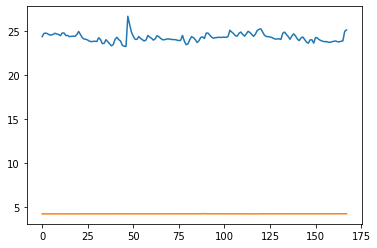

In [4]:
df2["temperature_measured"].plot()
df2["voltage_measured"].plot()

<AxesSubplot:>

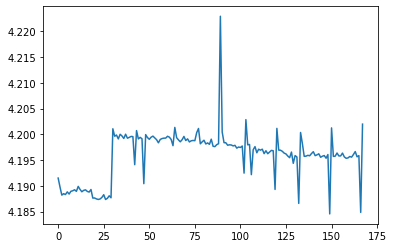

In [5]:
df2["voltage_measured"].plot()

Text(0, 0.5, 'Capacity')

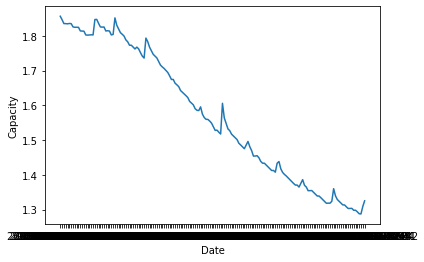

In [10]:
plt.plot(df2["datetime"],df2["capacity"])
plt.xlabel("Date")
plt.ylabel("Capacity")

Text(0, 0.5, 'capacity')

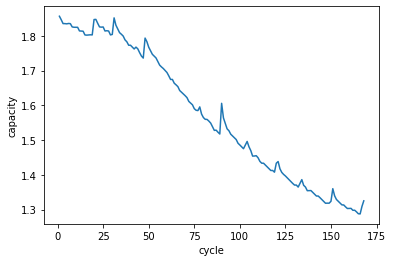

In [9]:
plt.plot(df2["cycle"],df2["capacity"])
plt.xlabel("cycle")
plt.ylabel("capacity")

<AxesSubplot:>

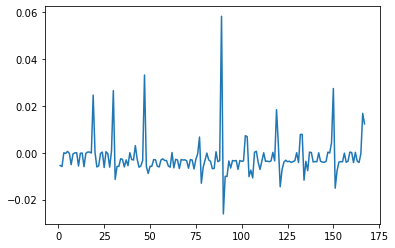

In [50]:
x = df2["capacity"].pct_change()
x.plot()

In [13]:
df2["datetime"] = pd.to_datetime(df2["datetime"],format = '%Y-%m-%d %H:%M:%S')

C:\Users\mehme\AppData\Local\Temp/ipykernel_7964/182081522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["datetime"] = pd.to_datetime(df2["datetime"],format = '%Y-%m-%d %H:%M:%S')


In [14]:
import datetime
col = [0]
for i in range(len(df2)-1):
    x = df2["datetime"][i+1] - df2["datetime"][i]
    if x > datetime.timedelta(hours = 15):
        print(i,x)
        col.append(1)
    else:
        col.append(0)

df2["long_interval"] = col

18 12 days 22:23:44
29 1 days 13:18:47
46 3 days 01:17:31
88 1 days 09:31:18
118 0 days 20:58:12
148 0 days 15:13:26
165 0 days 19:31:37


C:\Users\mehme\AppData\Local\Temp/ipykernel_7964/3569216424.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["long_interval"] = col


In [15]:
df2.drop(['index', 'cycle', 'ambient_temperature', 'datetime', 'voltage_measured', 'current_measured', 'temperature_measured',
       'current_load', 'voltage_load', 'time'],inplace=True,axis=1)
ds = df2.values
ds = ds.astype('float32')
train_size = int(len(ds) * 0.9) 
train_dataset, test_dataset = ds[0:train_size,:], ds[train_size:len(ds),:]

C:\Users\mehme\AppData\Local\Temp/ipykernel_7964/1024189398.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(['index', 'cycle', 'ambient_temperature', 'datetime', 'voltage_measured', 'current_measured', 'temperature_measured',


In [16]:
def exp(step_back,repeat_num,neuron_number,epochs,batch_number):
    arr = []
    for i in range(repeat_num):
        X_train, Y_train = [], []
        for i in range(len(train_dataset)-step_back - 1):
            a = train_dataset[i:(i+step_back), 0]
            a = np.append(a,train_dataset[i+5,1])
            X_train.append(a)
            Y_train.append(train_dataset[i + step_back, 0])
        X_train = np.array(X_train)
        Y_train = np.array(Y_train)
        X_test, Y_test = [], []
        for i in range(len(test_dataset)-step_back - 1):
            a = test_dataset[i:(i+step_back), 0]
            a = np.append(a,test_dataset[i+5,1])
            X_test.append(a)
            Y_test.append(test_dataset[i + step_back, 0])
        X_test = np.array(X_test)
        Y_test = np.array(Y_test)
        model = Sequential()
        model.add(InputLayer((step_back+1,1)))
        model.add(LSTM(neuron_number))
        #model.add(Dense(neuron_number_2, 'relu'))
        #model.add(layers.BatchNormalization())
        model.add(Dense(units = 1))
        model.summary()
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(X_train, Y_train, epochs=epochs,verbose=2)   
        trainScore = model.evaluate(X_train, Y_train, verbose=2)
        print('Train Score: %.4f MSE (%.5f RMSE)' % (trainScore, np.sqrt(trainScore)))
        testScore = model.evaluate(X_test, Y_test, verbose=1)
        print('Test Score: %.4f MSE (%.5f RMSE)' % (testScore, np.sqrt(testScore)))
        arr.append(np.sqrt(testScore))
    return arr

In [83]:
df2["datetime"].

Timestamp('2008-05-05 12:23:59.065476096')

In [54]:
df2[["capacity","long_interval"]][40:45]

,capacity,long_interval
40,1.767872,0
41,1.762315,0
42,1.767617,0
43,1.762668,0
44,1.751730,0


In [35]:
df2.head()

,capacity,long_interval
0,1.856487,0
1,1.846327,0
2,1.835349,0
3,1.835263,0
4,1.834646,0


In [17]:
X_train, Y_train = [], []
for i in range(len(train_dataset)-5 - 1):
    a = train_dataset[i:(i+5), 0]
    a = np.append(a,train_dataset[i+5,1])
    X_train.append(a)
    Y_train.append(train_dataset[i + 5, 0])
X_train = np.array(X_train)
Y_train = np.array(Y_train)


In [67]:
X_train

array([[1.8564874, 1.8463273, 1.8353492, 1.8352625, 1.8346455, 0.       ],
       [1.8463273, 1.8353492, 1.8352625, 1.8346455, 1.8356616, 0.       ],
       [1.8353492, 1.8352625, 1.8346455, 1.8356616, 1.8351462, 0.       ],
       [1.8352625, 1.8346455, 1.8356616, 1.8351462, 1.8257568, 0.       ],
       [1.8346455, 1.8356616, 1.8351462, 1.8257568, 1.8247739, 0.       ],
       [1.8356616, 1.8351462, 1.8257568, 1.8247739, 1.8246132, 0.       ],
       [1.8351462, 1.8257568, 1.8247739, 1.8246132, 1.8246195, 0.       ],
       [1.8257568, 1.8247739, 1.8246132, 1.8246195, 1.814202 , 0.       ],
       [1.8247739, 1.8246132, 1.8246195, 1.814202 , 1.8137522, 0.       ],
       [1.8246132, 1.8246195, 1.814202 , 1.8137522, 1.8134404, 0.       ],
       [1.8246195, 1.814202 , 1.8137522, 1.8134404, 1.802598 , 0.       ],
       [1.814202 , 1.8137522, 1.8134404, 1.802598 , 1.8021069, 0.       ],
       [1.8137522, 1.8134404, 1.802598 , 1.8021069, 1.8025795, 0.       ],
       [1.8134404, 1.8025

In [68]:
dic = {}
#neuron number_1 for LSTM
for i in [3,4,8,16,32,64,128]:
    dic[i] = exp(6,5,i,100,2)
df_1 = pd.DataFrame(dic)
df_melted = pd.melt(df_1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 3)                 60        
                                                                 
 dense_6 (Dense)             (None, 1)                 4         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 - 2s - loss: 2.8323 - 2s/epoch - 303ms/step
Epoch 2/100
5/5 - 0s - loss: 2.7135 - 19ms/epoch - 4ms/step
Epoch 3/100
5/5 - 0s - loss: 2.5997 - 20ms/epoch - 4ms/step
Epoch 4/100
5/5 - 0s - loss: 2.4914 - 25ms/epoch - 5ms/step
Epoch 5/100
5/5 - 0s - loss: 2.3882 - 23ms/epoch - 5ms/step
Epoch 6/100
5/5 - 0s - loss: 2.2902 - 26ms/epoch - 5ms/step
Epoch 7/100
5/5 - 0s - loss: 2.1975 - 22ms/epoch - 4ms/step
Epoch 8/100
5/5 - 0s - loss: 2.108

5/5 - 0s - loss: 1.6252 - 22ms/epoch - 4ms/step
Epoch 11/100
5/5 - 0s - loss: 1.5230 - 22ms/epoch - 4ms/step
Epoch 12/100
5/5 - 0s - loss: 1.4229 - 21ms/epoch - 4ms/step
Epoch 13/100
5/5 - 0s - loss: 1.3237 - 23ms/epoch - 5ms/step
Epoch 14/100
5/5 - 0s - loss: 1.2274 - 24ms/epoch - 5ms/step
Epoch 15/100
5/5 - 0s - loss: 1.1331 - 24ms/epoch - 5ms/step
Epoch 16/100
5/5 - 0s - loss: 1.0408 - 20ms/epoch - 4ms/step
Epoch 17/100
5/5 - 0s - loss: 0.9535 - 19ms/epoch - 4ms/step
Epoch 18/100
5/5 - 0s - loss: 0.8691 - 19ms/epoch - 4ms/step
Epoch 19/100
5/5 - 0s - loss: 0.7907 - 19ms/epoch - 4ms/step
Epoch 20/100
5/5 - 0s - loss: 0.7155 - 19ms/epoch - 4ms/step
Epoch 21/100
5/5 - 0s - loss: 0.6473 - 20ms/epoch - 4ms/step
Epoch 22/100
5/5 - 0s - loss: 0.5839 - 19ms/epoch - 4ms/step
Epoch 23/100
5/5 - 0s - loss: 0.5256 - 19ms/epoch - 4ms/step
Epoch 24/100
5/5 - 0s - loss: 0.4732 - 19ms/epoch - 4ms/step
Epoch 25/100
5/5 - 0s - loss: 0.4257 - 20ms/epoch - 4ms/step
Epoch 26/100
5/5 - 0s - loss: 0.3829 

Epoch 31/100
5/5 - 0s - loss: 2.2955 - 16ms/epoch - 3ms/step
Epoch 32/100
5/5 - 0s - loss: 2.2683 - 16ms/epoch - 3ms/step
Epoch 33/100
5/5 - 0s - loss: 2.2412 - 18ms/epoch - 4ms/step
Epoch 34/100
5/5 - 0s - loss: 2.2146 - 18ms/epoch - 4ms/step
Epoch 35/100
5/5 - 0s - loss: 2.1882 - 16ms/epoch - 3ms/step
Epoch 36/100
5/5 - 0s - loss: 2.1621 - 16ms/epoch - 3ms/step
Epoch 37/100
5/5 - 0s - loss: 2.1361 - 15ms/epoch - 3ms/step
Epoch 38/100
5/5 - 0s - loss: 2.1103 - 15ms/epoch - 3ms/step
Epoch 39/100
5/5 - 0s - loss: 2.0846 - 19ms/epoch - 4ms/step
Epoch 40/100
5/5 - 0s - loss: 2.0589 - 16ms/epoch - 3ms/step
Epoch 41/100
5/5 - 0s - loss: 2.0332 - 15ms/epoch - 3ms/step
Epoch 42/100
5/5 - 0s - loss: 2.0074 - 15ms/epoch - 3ms/step
Epoch 43/100
5/5 - 0s - loss: 1.9815 - 16ms/epoch - 3ms/step
Epoch 44/100
5/5 - 0s - loss: 1.9553 - 15ms/epoch - 3ms/step
Epoch 45/100
5/5 - 0s - loss: 1.9289 - 15ms/epoch - 3ms/step
Epoch 46/100
5/5 - 0s - loss: 1.9021 - 17ms/epoch - 3ms/step
Epoch 47/100
5/5 - 0s - 

5/5 - 0s - loss: 0.1183 - 18ms/epoch - 4ms/step
Epoch 52/100
5/5 - 0s - loss: 0.1109 - 17ms/epoch - 3ms/step
Epoch 53/100
5/5 - 0s - loss: 0.1037 - 16ms/epoch - 3ms/step
Epoch 54/100
5/5 - 0s - loss: 0.0973 - 15ms/epoch - 3ms/step
Epoch 55/100
5/5 - 0s - loss: 0.0913 - 15ms/epoch - 3ms/step
Epoch 56/100
5/5 - 0s - loss: 0.0858 - 17ms/epoch - 3ms/step
Epoch 57/100
5/5 - 0s - loss: 0.0806 - 16ms/epoch - 3ms/step
Epoch 58/100
5/5 - 0s - loss: 0.0760 - 17ms/epoch - 3ms/step
Epoch 59/100
5/5 - 0s - loss: 0.0715 - 17ms/epoch - 3ms/step
Epoch 60/100
5/5 - 0s - loss: 0.0675 - 17ms/epoch - 3ms/step
Epoch 61/100
5/5 - 0s - loss: 0.0638 - 17ms/epoch - 3ms/step
Epoch 62/100
5/5 - 0s - loss: 0.0605 - 16ms/epoch - 3ms/step
Epoch 63/100
5/5 - 0s - loss: 0.0573 - 17ms/epoch - 3ms/step
Epoch 64/100
5/5 - 0s - loss: 0.0544 - 16ms/epoch - 3ms/step
Epoch 65/100
5/5 - 0s - loss: 0.0519 - 17ms/epoch - 3ms/step
Epoch 66/100
5/5 - 0s - loss: 0.0495 - 17ms/epoch - 3ms/step
Epoch 67/100
5/5 - 0s - loss: 0.0474 

Epoch 72/100
5/5 - 0s - loss: 0.0933 - 18ms/epoch - 4ms/step
Epoch 73/100
5/5 - 0s - loss: 0.0856 - 17ms/epoch - 3ms/step
Epoch 74/100
5/5 - 0s - loss: 0.0785 - 16ms/epoch - 3ms/step
Epoch 75/100
5/5 - 0s - loss: 0.0725 - 16ms/epoch - 3ms/step
Epoch 76/100
5/5 - 0s - loss: 0.0669 - 17ms/epoch - 3ms/step
Epoch 77/100
5/5 - 0s - loss: 0.0619 - 15ms/epoch - 3ms/step
Epoch 78/100
5/5 - 0s - loss: 0.0576 - 16ms/epoch - 3ms/step
Epoch 79/100
5/5 - 0s - loss: 0.0537 - 16ms/epoch - 3ms/step
Epoch 80/100
5/5 - 0s - loss: 0.0505 - 16ms/epoch - 3ms/step
Epoch 81/100
5/5 - 0s - loss: 0.0474 - 15ms/epoch - 3ms/step
Epoch 82/100
5/5 - 0s - loss: 0.0449 - 15ms/epoch - 3ms/step
Epoch 83/100
5/5 - 0s - loss: 0.0428 - 16ms/epoch - 3ms/step
Epoch 84/100
5/5 - 0s - loss: 0.0408 - 15ms/epoch - 3ms/step
Epoch 85/100
5/5 - 0s - loss: 0.0392 - 15ms/epoch - 3ms/step
Epoch 86/100
5/5 - 0s - loss: 0.0377 - 15ms/epoch - 3ms/step
Epoch 87/100
5/5 - 0s - loss: 0.0365 - 15ms/epoch - 3ms/step
Epoch 88/100
5/5 - 0s - 

5/5 - 0s - loss: 0.0255 - 16ms/epoch - 3ms/step
Epoch 93/100
5/5 - 0s - loss: 0.0254 - 16ms/epoch - 3ms/step
Epoch 94/100
5/5 - 0s - loss: 0.0254 - 16ms/epoch - 3ms/step
Epoch 95/100
5/5 - 0s - loss: 0.0253 - 16ms/epoch - 3ms/step
Epoch 96/100
5/5 - 0s - loss: 0.0253 - 15ms/epoch - 3ms/step
Epoch 97/100
5/5 - 0s - loss: 0.0252 - 15ms/epoch - 3ms/step
Epoch 98/100
5/5 - 0s - loss: 0.0252 - 15ms/epoch - 3ms/step
Epoch 99/100
5/5 - 0s - loss: 0.0251 - 15ms/epoch - 3ms/step
Epoch 100/100
5/5 - 0s - loss: 0.0251 - 15ms/epoch - 3ms/step
5/5 - 0s - loss: 0.0250 - 350ms/epoch - 70ms/step
Train Score: 0.0250 MSE (0.15820 RMSE)
1/1 [==============================] - 0s 19ms/step - loss: 0.0651
Test Score: 0.0651 MSE (0.25513 RMSE)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 4)                 96        
                                                

Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 - 1s - loss: 3.3463 - 1s/epoch - 273ms/step
Epoch 2/100
5/5 - 0s - loss: 3.2224 - 20ms/epoch - 4ms/step
Epoch 3/100
5/5 - 0s - loss: 3.1061 - 20ms/epoch - 4ms/step
Epoch 4/100
5/5 - 0s - loss: 2.9972 - 20ms/epoch - 4ms/step
Epoch 5/100
5/5 - 0s - loss: 2.8950 - 20ms/epoch - 4ms/step
Epoch 6/100
5/5 - 0s - loss: 2.7990 - 20ms/epoch - 4ms/step
Epoch 7/100
5/5 - 0s - loss: 2.7101 - 19ms/epoch - 4ms/step
Epoch 8/100
5/5 - 0s - loss: 2.6258 - 19ms/epoch - 4ms/step
Epoch 9/100
5/5 - 0s - loss: 2.5465 - 20ms/epoch - 4ms/step
Epoch 10/100
5/5 - 0s - loss: 2.4713 - 19ms/epoch - 4ms/step
Epoch 11/100
5/5 - 0s - loss: 2.4005 - 19ms/epoch - 4ms/step
Epoch 12/100
5/5 - 0s - loss: 2.3326 - 19ms/epoch - 4ms/step
Epoch 13/100
5/5 - 0s - loss: 2.2678 - 19ms/epoch - 4ms/step
Epoch 14/100
5/5 - 0s - loss: 2.2062 - 21ms/epoch - 4ms/step
Epoch 15/100
5/5 - 0s - l

5/5 - 0s - loss: 0.5959 - 18ms/epoch - 4ms/step
Epoch 20/100
5/5 - 0s - loss: 0.5406 - 15ms/epoch - 3ms/step
Epoch 21/100
5/5 - 0s - loss: 0.4887 - 15ms/epoch - 3ms/step
Epoch 22/100
5/5 - 0s - loss: 0.4408 - 15ms/epoch - 3ms/step
Epoch 23/100
5/5 - 0s - loss: 0.3965 - 15ms/epoch - 3ms/step
Epoch 24/100
5/5 - 0s - loss: 0.3552 - 16ms/epoch - 3ms/step
Epoch 25/100
5/5 - 0s - loss: 0.3175 - 14ms/epoch - 3ms/step
Epoch 26/100
5/5 - 0s - loss: 0.2830 - 16ms/epoch - 3ms/step
Epoch 27/100
5/5 - 0s - loss: 0.2517 - 17ms/epoch - 3ms/step
Epoch 28/100
5/5 - 0s - loss: 0.2231 - 17ms/epoch - 3ms/step
Epoch 29/100
5/5 - 0s - loss: 0.1976 - 15ms/epoch - 3ms/step
Epoch 30/100
5/5 - 0s - loss: 0.1743 - 16ms/epoch - 3ms/step
Epoch 31/100
5/5 - 0s - loss: 0.1536 - 16ms/epoch - 3ms/step
Epoch 32/100
5/5 - 0s - loss: 0.1351 - 16ms/epoch - 3ms/step
Epoch 33/100
5/5 - 0s - loss: 0.1185 - 18ms/epoch - 4ms/step
Epoch 34/100
5/5 - 0s - loss: 0.1041 - 16ms/epoch - 3ms/step
Epoch 35/100
5/5 - 0s - loss: 0.0915 

Epoch 40/100
5/5 - 0s - loss: 0.3745 - 19ms/epoch - 4ms/step
Epoch 41/100
5/5 - 0s - loss: 0.3502 - 19ms/epoch - 4ms/step
Epoch 42/100
5/5 - 0s - loss: 0.3272 - 19ms/epoch - 4ms/step
Epoch 43/100
5/5 - 0s - loss: 0.3051 - 17ms/epoch - 3ms/step
Epoch 44/100
5/5 - 0s - loss: 0.2838 - 17ms/epoch - 3ms/step
Epoch 45/100
5/5 - 0s - loss: 0.2641 - 16ms/epoch - 3ms/step
Epoch 46/100
5/5 - 0s - loss: 0.2451 - 19ms/epoch - 4ms/step
Epoch 47/100
5/5 - 0s - loss: 0.2273 - 16ms/epoch - 3ms/step
Epoch 48/100
5/5 - 0s - loss: 0.2104 - 17ms/epoch - 3ms/step
Epoch 49/100
5/5 - 0s - loss: 0.1944 - 18ms/epoch - 4ms/step
Epoch 50/100
5/5 - 0s - loss: 0.1792 - 17ms/epoch - 3ms/step
Epoch 51/100
5/5 - 0s - loss: 0.1648 - 16ms/epoch - 3ms/step
Epoch 52/100
5/5 - 0s - loss: 0.1515 - 18ms/epoch - 4ms/step
Epoch 53/100
5/5 - 0s - loss: 0.1390 - 18ms/epoch - 4ms/step
Epoch 54/100
5/5 - 0s - loss: 0.1271 - 16ms/epoch - 3ms/step
Epoch 55/100
5/5 - 0s - loss: 0.1163 - 17ms/epoch - 3ms/step
Epoch 56/100
5/5 - 0s - 

5/5 - 0s - loss: 0.0191 - 17ms/epoch - 3ms/step
Epoch 61/100
5/5 - 0s - loss: 0.0190 - 18ms/epoch - 4ms/step
Epoch 62/100
5/5 - 0s - loss: 0.0189 - 19ms/epoch - 4ms/step
Epoch 63/100
5/5 - 0s - loss: 0.0189 - 19ms/epoch - 4ms/step
Epoch 64/100
5/5 - 0s - loss: 0.0188 - 17ms/epoch - 3ms/step
Epoch 65/100
5/5 - 0s - loss: 0.0187 - 16ms/epoch - 3ms/step
Epoch 66/100
5/5 - 0s - loss: 0.0186 - 17ms/epoch - 3ms/step
Epoch 67/100
5/5 - 0s - loss: 0.0185 - 16ms/epoch - 3ms/step
Epoch 68/100
5/5 - 0s - loss: 0.0184 - 18ms/epoch - 4ms/step
Epoch 69/100
5/5 - 0s - loss: 0.0183 - 18ms/epoch - 4ms/step
Epoch 70/100
5/5 - 0s - loss: 0.0182 - 18ms/epoch - 4ms/step
Epoch 71/100
5/5 - 0s - loss: 0.0181 - 16ms/epoch - 3ms/step
Epoch 72/100
5/5 - 0s - loss: 0.0180 - 18ms/epoch - 4ms/step
Epoch 73/100
5/5 - 0s - loss: 0.0179 - 17ms/epoch - 3ms/step
Epoch 74/100
5/5 - 0s - loss: 0.0178 - 17ms/epoch - 3ms/step
Epoch 75/100
5/5 - 0s - loss: 0.0177 - 18ms/epoch - 4ms/step
Epoch 76/100
5/5 - 0s - loss: 0.0176 

Epoch 81/100
5/5 - 0s - loss: 0.0185 - 19ms/epoch - 4ms/step
Epoch 82/100
5/5 - 0s - loss: 0.0185 - 19ms/epoch - 4ms/step
Epoch 83/100
5/5 - 0s - loss: 0.0184 - 20ms/epoch - 4ms/step
Epoch 84/100
5/5 - 0s - loss: 0.0184 - 19ms/epoch - 4ms/step
Epoch 85/100
5/5 - 0s - loss: 0.0183 - 18ms/epoch - 4ms/step
Epoch 86/100
5/5 - 0s - loss: 0.0183 - 18ms/epoch - 4ms/step
Epoch 87/100
5/5 - 0s - loss: 0.0182 - 18ms/epoch - 4ms/step
Epoch 88/100
5/5 - 0s - loss: 0.0182 - 19ms/epoch - 4ms/step
Epoch 89/100
5/5 - 0s - loss: 0.0181 - 20ms/epoch - 4ms/step
Epoch 90/100
5/5 - 0s - loss: 0.0181 - 18ms/epoch - 4ms/step
Epoch 91/100
5/5 - 0s - loss: 0.0180 - 18ms/epoch - 4ms/step
Epoch 92/100
5/5 - 0s - loss: 0.0179 - 18ms/epoch - 4ms/step
Epoch 93/100
5/5 - 0s - loss: 0.0179 - 18ms/epoch - 4ms/step
Epoch 94/100
5/5 - 0s - loss: 0.0178 - 18ms/epoch - 4ms/step
Epoch 95/100
5/5 - 0s - loss: 0.0178 - 18ms/epoch - 4ms/step
Epoch 96/100
5/5 - 0s - loss: 0.0177 - 18ms/epoch - 4ms/step
Epoch 97/100
5/5 - 0s - 

Train Score: 0.0111 MSE (0.10526 RMSE)
1/1 [==============================] - 0s 16ms/step - loss: 0.0251
Test Score: 0.0251 MSE (0.15847 RMSE)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 8)                 320       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 - 1s - loss: 2.1571 - 1s/epoch - 273ms/step
Epoch 2/100
5/5 - 0s - loss: 1.9895 - 21ms/epoch - 4ms/step
Epoch 3/100
5/5 - 0s - loss: 1.8266 - 21ms/epoch - 4ms/step
Epoch 4/100
5/5 - 0s - loss: 1.6625 - 19ms/epoch - 4ms/step
Epoch 5/100
5/5 - 0s - loss: 1.5008 - 21ms/epoch - 4ms/step
Epoch 6

Epoch 8/100
5/5 - 0s - loss: 0.4283 - 19ms/epoch - 4ms/step
Epoch 9/100
5/5 - 0s - loss: 0.3524 - 20ms/epoch - 4ms/step
Epoch 10/100
5/5 - 0s - loss: 0.2833 - 19ms/epoch - 4ms/step
Epoch 11/100
5/5 - 0s - loss: 0.2228 - 19ms/epoch - 4ms/step
Epoch 12/100
5/5 - 0s - loss: 0.1703 - 18ms/epoch - 4ms/step
Epoch 13/100
5/5 - 0s - loss: 0.1265 - 18ms/epoch - 4ms/step
Epoch 14/100
5/5 - 0s - loss: 0.0912 - 18ms/epoch - 4ms/step
Epoch 15/100
5/5 - 0s - loss: 0.0651 - 18ms/epoch - 4ms/step
Epoch 16/100
5/5 - 0s - loss: 0.0456 - 19ms/epoch - 4ms/step
Epoch 17/100
5/5 - 0s - loss: 0.0322 - 19ms/epoch - 4ms/step
Epoch 18/100
5/5 - 0s - loss: 0.0245 - 19ms/epoch - 4ms/step
Epoch 19/100
5/5 - 0s - loss: 0.0209 - 18ms/epoch - 4ms/step
Epoch 20/100
5/5 - 0s - loss: 0.0188 - 19ms/epoch - 4ms/step
Epoch 21/100
5/5 - 0s - loss: 0.0183 - 18ms/epoch - 4ms/step
Epoch 22/100
5/5 - 0s - loss: 0.0183 - 18ms/epoch - 4ms/step
Epoch 23/100
5/5 - 0s - loss: 0.0183 - 19ms/epoch - 4ms/step
Epoch 24/100
5/5 - 0s - lo

5/5 - 0s - loss: 0.0084 - 21ms/epoch - 4ms/step
Epoch 29/100
5/5 - 0s - loss: 0.0083 - 20ms/epoch - 4ms/step
Epoch 30/100
5/5 - 0s - loss: 0.0082 - 19ms/epoch - 4ms/step
Epoch 31/100
5/5 - 0s - loss: 0.0081 - 19ms/epoch - 4ms/step
Epoch 32/100
5/5 - 0s - loss: 0.0081 - 19ms/epoch - 4ms/step
Epoch 33/100
5/5 - 0s - loss: 0.0080 - 18ms/epoch - 4ms/step
Epoch 34/100
5/5 - 0s - loss: 0.0080 - 20ms/epoch - 4ms/step
Epoch 35/100
5/5 - 0s - loss: 0.0079 - 18ms/epoch - 4ms/step
Epoch 36/100
5/5 - 0s - loss: 0.0079 - 18ms/epoch - 4ms/step
Epoch 37/100
5/5 - 0s - loss: 0.0078 - 19ms/epoch - 4ms/step
Epoch 38/100
5/5 - 0s - loss: 0.0078 - 19ms/epoch - 4ms/step
Epoch 39/100
5/5 - 0s - loss: 0.0077 - 19ms/epoch - 4ms/step
Epoch 40/100
5/5 - 0s - loss: 0.0077 - 19ms/epoch - 4ms/step
Epoch 41/100
5/5 - 0s - loss: 0.0076 - 19ms/epoch - 4ms/step
Epoch 42/100
5/5 - 0s - loss: 0.0076 - 19ms/epoch - 4ms/step
Epoch 43/100
5/5 - 0s - loss: 0.0075 - 19ms/epoch - 4ms/step
Epoch 44/100
5/5 - 0s - loss: 0.0075 

Epoch 49/100
5/5 - 0s - loss: 0.0097 - 19ms/epoch - 4ms/step
Epoch 50/100
5/5 - 0s - loss: 0.0096 - 20ms/epoch - 4ms/step
Epoch 51/100
5/5 - 0s - loss: 0.0095 - 18ms/epoch - 4ms/step
Epoch 52/100
5/5 - 0s - loss: 0.0094 - 18ms/epoch - 4ms/step
Epoch 53/100
5/5 - 0s - loss: 0.0093 - 18ms/epoch - 4ms/step
Epoch 54/100
5/5 - 0s - loss: 0.0092 - 20ms/epoch - 4ms/step
Epoch 55/100
5/5 - 0s - loss: 0.0091 - 19ms/epoch - 4ms/step
Epoch 56/100
5/5 - 0s - loss: 0.0090 - 20ms/epoch - 4ms/step
Epoch 57/100
5/5 - 0s - loss: 0.0089 - 20ms/epoch - 4ms/step
Epoch 58/100
5/5 - 0s - loss: 0.0088 - 19ms/epoch - 4ms/step
Epoch 59/100
5/5 - 0s - loss: 0.0087 - 19ms/epoch - 4ms/step
Epoch 60/100
5/5 - 0s - loss: 0.0086 - 18ms/epoch - 4ms/step
Epoch 61/100
5/5 - 0s - loss: 0.0085 - 18ms/epoch - 4ms/step
Epoch 62/100
5/5 - 0s - loss: 0.0084 - 19ms/epoch - 4ms/step
Epoch 63/100
5/5 - 0s - loss: 0.0083 - 17ms/epoch - 3ms/step
Epoch 64/100
5/5 - 0s - loss: 0.0082 - 15ms/epoch - 3ms/step
Epoch 65/100
5/5 - 0s - 

5/5 - 0s - loss: 0.0092 - 19ms/epoch - 4ms/step
Epoch 70/100
5/5 - 0s - loss: 0.0091 - 19ms/epoch - 4ms/step
Epoch 71/100
5/5 - 0s - loss: 0.0090 - 19ms/epoch - 4ms/step
Epoch 72/100
5/5 - 0s - loss: 0.0089 - 19ms/epoch - 4ms/step
Epoch 73/100
5/5 - 0s - loss: 0.0087 - 18ms/epoch - 4ms/step
Epoch 74/100
5/5 - 0s - loss: 0.0086 - 19ms/epoch - 4ms/step
Epoch 75/100
5/5 - 0s - loss: 0.0085 - 19ms/epoch - 4ms/step
Epoch 76/100
5/5 - 0s - loss: 0.0084 - 18ms/epoch - 4ms/step
Epoch 77/100
5/5 - 0s - loss: 0.0083 - 19ms/epoch - 4ms/step
Epoch 78/100
5/5 - 0s - loss: 0.0082 - 20ms/epoch - 4ms/step
Epoch 79/100
5/5 - 0s - loss: 0.0080 - 19ms/epoch - 4ms/step
Epoch 80/100
5/5 - 0s - loss: 0.0079 - 18ms/epoch - 4ms/step
Epoch 81/100
5/5 - 0s - loss: 0.0078 - 18ms/epoch - 4ms/step
Epoch 82/100
5/5 - 0s - loss: 0.0077 - 17ms/epoch - 3ms/step
Epoch 83/100
5/5 - 0s - loss: 0.0076 - 16ms/epoch - 3ms/step
Epoch 84/100
5/5 - 0s - loss: 0.0074 - 16ms/epoch - 3ms/step
Epoch 85/100
5/5 - 0s - loss: 0.0073 

Epoch 90/100
5/5 - 0s - loss: 0.0019 - 17ms/epoch - 3ms/step
Epoch 91/100
5/5 - 0s - loss: 0.0018 - 17ms/epoch - 3ms/step
Epoch 92/100
5/5 - 0s - loss: 0.0018 - 16ms/epoch - 3ms/step
Epoch 93/100
5/5 - 0s - loss: 0.0018 - 17ms/epoch - 3ms/step
Epoch 94/100
5/5 - 0s - loss: 0.0017 - 17ms/epoch - 3ms/step
Epoch 95/100
5/5 - 0s - loss: 0.0017 - 17ms/epoch - 3ms/step
Epoch 96/100
5/5 - 0s - loss: 0.0017 - 16ms/epoch - 3ms/step
Epoch 97/100
5/5 - 0s - loss: 0.0016 - 17ms/epoch - 3ms/step
Epoch 98/100
5/5 - 0s - loss: 0.0016 - 19ms/epoch - 4ms/step
Epoch 99/100
5/5 - 0s - loss: 0.0016 - 20ms/epoch - 4ms/step
Epoch 100/100
5/5 - 0s - loss: 0.0015 - 18ms/epoch - 4ms/step
5/5 - 0s - loss: 0.0015 - 371ms/epoch - 74ms/step
Train Score: 0.0015 MSE (0.03896 RMSE)
1/1 [==============================] - 0s 21ms/step - loss: 0.0016
Test Score: 0.0016 MSE (0.03976 RMSE)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape    

                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 - 1s - loss: 2.2497 - 1s/epoch - 268ms/step
Epoch 2/100
5/5 - 0s - loss: 1.7536 - 25ms/epoch - 5ms/step
Epoch 3/100
5/5 - 0s - loss: 1.2938 - 20ms/epoch - 4ms/step
Epoch 4/100
5/5 - 0s - loss: 0.8757 - 20ms/epoch - 4ms/step
Epoch 5/100
5/5 - 0s - loss: 0.4972 - 20ms/epoch - 4ms/step
Epoch 6/100
5/5 - 0s - loss: 0.1958 - 20ms/epoch - 4ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0295 - 20ms/epoch - 4ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0160 - 21ms/epoch - 4ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0494 - 19ms/epoch - 4ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0341 - 20ms/epoch - 4ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0089 - 19ms/epoch - 4ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0044 - 21ms/epoch - 4ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0076 - 20ms/epoch - 4ms/step
Epoch 14/100
5/5

Epoch 15/100
5/5 - 0s - loss: 0.0081 - 20ms/epoch - 4ms/step
Epoch 16/100
5/5 - 0s - loss: 0.0066 - 19ms/epoch - 4ms/step
Epoch 17/100
5/5 - 0s - loss: 0.0065 - 20ms/epoch - 4ms/step
Epoch 18/100
5/5 - 0s - loss: 0.0067 - 19ms/epoch - 4ms/step
Epoch 19/100
5/5 - 0s - loss: 0.0065 - 19ms/epoch - 4ms/step
Epoch 20/100
5/5 - 0s - loss: 0.0062 - 20ms/epoch - 4ms/step
Epoch 21/100
5/5 - 0s - loss: 0.0061 - 20ms/epoch - 4ms/step
Epoch 22/100
5/5 - 0s - loss: 0.0060 - 20ms/epoch - 4ms/step
Epoch 23/100
5/5 - 0s - loss: 0.0060 - 20ms/epoch - 4ms/step
Epoch 24/100
5/5 - 0s - loss: 0.0059 - 20ms/epoch - 4ms/step
Epoch 25/100
5/5 - 0s - loss: 0.0058 - 20ms/epoch - 4ms/step
Epoch 26/100
5/5 - 0s - loss: 0.0057 - 20ms/epoch - 4ms/step
Epoch 27/100
5/5 - 0s - loss: 0.0056 - 19ms/epoch - 4ms/step
Epoch 28/100
5/5 - 0s - loss: 0.0055 - 21ms/epoch - 4ms/step
Epoch 29/100
5/5 - 0s - loss: 0.0054 - 21ms/epoch - 4ms/step
Epoch 30/100
5/5 - 0s - loss: 0.0053 - 20ms/epoch - 4ms/step
Epoch 31/100
5/5 - 0s - 

Epoch 33/100
5/5 - 0s - loss: 0.0046 - 21ms/epoch - 4ms/step
Epoch 34/100
5/5 - 0s - loss: 0.0045 - 20ms/epoch - 4ms/step
Epoch 35/100
5/5 - 0s - loss: 0.0044 - 18ms/epoch - 4ms/step
Epoch 36/100
5/5 - 0s - loss: 0.0043 - 19ms/epoch - 4ms/step
Epoch 37/100
5/5 - 0s - loss: 0.0043 - 20ms/epoch - 4ms/step
Epoch 38/100
5/5 - 0s - loss: 0.0042 - 21ms/epoch - 4ms/step
Epoch 39/100
5/5 - 0s - loss: 0.0041 - 19ms/epoch - 4ms/step
Epoch 40/100
5/5 - 0s - loss: 0.0040 - 19ms/epoch - 4ms/step
Epoch 41/100
5/5 - 0s - loss: 0.0040 - 20ms/epoch - 4ms/step
Epoch 42/100
5/5 - 0s - loss: 0.0039 - 18ms/epoch - 4ms/step
Epoch 43/100
5/5 - 0s - loss: 0.0038 - 19ms/epoch - 4ms/step
Epoch 44/100
5/5 - 0s - loss: 0.0038 - 17ms/epoch - 3ms/step
Epoch 45/100
5/5 - 0s - loss: 0.0037 - 18ms/epoch - 4ms/step
Epoch 46/100
5/5 - 0s - loss: 0.0036 - 21ms/epoch - 4ms/step
Epoch 47/100
5/5 - 0s - loss: 0.0036 - 21ms/epoch - 4ms/step
Epoch 48/100
5/5 - 0s - loss: 0.0035 - 19ms/epoch - 4ms/step
Epoch 49/100
5/5 - 0s - 

Epoch 53/100
5/5 - 0s - loss: 0.0046 - 17ms/epoch - 3ms/step
Epoch 54/100
5/5 - 0s - loss: 0.0045 - 18ms/epoch - 4ms/step
Epoch 55/100
5/5 - 0s - loss: 0.0044 - 17ms/epoch - 3ms/step
Epoch 56/100
5/5 - 0s - loss: 0.0042 - 18ms/epoch - 4ms/step
Epoch 57/100
5/5 - 0s - loss: 0.0042 - 20ms/epoch - 4ms/step
Epoch 58/100
5/5 - 0s - loss: 0.0041 - 18ms/epoch - 4ms/step
Epoch 59/100
5/5 - 0s - loss: 0.0039 - 17ms/epoch - 3ms/step
Epoch 60/100
5/5 - 0s - loss: 0.0039 - 18ms/epoch - 4ms/step
Epoch 61/100
5/5 - 0s - loss: 0.0038 - 18ms/epoch - 4ms/step
Epoch 62/100
5/5 - 0s - loss: 0.0037 - 18ms/epoch - 4ms/step
Epoch 63/100
5/5 - 0s - loss: 0.0036 - 17ms/epoch - 3ms/step
Epoch 64/100
5/5 - 0s - loss: 0.0035 - 20ms/epoch - 4ms/step
Epoch 65/100
5/5 - 0s - loss: 0.0034 - 18ms/epoch - 4ms/step
Epoch 66/100
5/5 - 0s - loss: 0.0033 - 17ms/epoch - 3ms/step
Epoch 67/100
5/5 - 0s - loss: 0.0032 - 16ms/epoch - 3ms/step
Epoch 68/100
5/5 - 0s - loss: 0.0031 - 16ms/epoch - 3ms/step
Epoch 69/100
5/5 - 0s - 

5/5 - 0s - loss: 0.0017 - 17ms/epoch - 3ms/step
Epoch 74/100
5/5 - 0s - loss: 0.0017 - 18ms/epoch - 4ms/step
Epoch 75/100
5/5 - 0s - loss: 0.0016 - 17ms/epoch - 3ms/step
Epoch 76/100
5/5 - 0s - loss: 0.0016 - 17ms/epoch - 3ms/step
Epoch 77/100
5/5 - 0s - loss: 0.0015 - 16ms/epoch - 3ms/step
Epoch 78/100
5/5 - 0s - loss: 0.0015 - 16ms/epoch - 3ms/step
Epoch 79/100
5/5 - 0s - loss: 0.0015 - 16ms/epoch - 3ms/step
Epoch 80/100
5/5 - 0s - loss: 0.0014 - 17ms/epoch - 3ms/step
Epoch 81/100
5/5 - 0s - loss: 0.0014 - 17ms/epoch - 3ms/step
Epoch 82/100
5/5 - 0s - loss: 0.0014 - 17ms/epoch - 3ms/step
Epoch 83/100
5/5 - 0s - loss: 0.0013 - 16ms/epoch - 3ms/step
Epoch 84/100
5/5 - 0s - loss: 0.0013 - 16ms/epoch - 3ms/step
Epoch 85/100
5/5 - 0s - loss: 0.0013 - 16ms/epoch - 3ms/step
Epoch 86/100
5/5 - 0s - loss: 0.0012 - 16ms/epoch - 3ms/step
Epoch 87/100
5/5 - 0s - loss: 0.0012 - 16ms/epoch - 3ms/step
Epoch 88/100
5/5 - 0s - loss: 0.0012 - 16ms/epoch - 3ms/step
Epoch 89/100
5/5 - 0s - loss: 0.0011 

Epoch 91/100
5/5 - 0s - loss: 3.6798e-04 - 22ms/epoch - 4ms/step
Epoch 92/100
5/5 - 0s - loss: 3.5711e-04 - 20ms/epoch - 4ms/step
Epoch 93/100
5/5 - 0s - loss: 3.4854e-04 - 23ms/epoch - 5ms/step
Epoch 94/100
5/5 - 0s - loss: 3.6406e-04 - 21ms/epoch - 4ms/step
Epoch 95/100
5/5 - 0s - loss: 3.4934e-04 - 20ms/epoch - 4ms/step
Epoch 96/100
5/5 - 0s - loss: 3.3172e-04 - 23ms/epoch - 5ms/step
Epoch 97/100
5/5 - 0s - loss: 3.4155e-04 - 18ms/epoch - 4ms/step
Epoch 98/100
5/5 - 0s - loss: 3.1791e-04 - 21ms/epoch - 4ms/step
Epoch 99/100
5/5 - 0s - loss: 3.1089e-04 - 21ms/epoch - 4ms/step
Epoch 100/100
5/5 - 0s - loss: 3.0346e-04 - 22ms/epoch - 4ms/step
5/5 - 0s - loss: 3.0241e-04 - 352ms/epoch - 70ms/step
Train Score: 0.0003 MSE (0.01739 RMSE)
1/1 [==============================] - 0s 17ms/step - loss: 9.9246e-05
Test Score: 0.0001 MSE (0.00996 RMSE)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Par

 lstm_33 (LSTM)              (None, 64)                16896     
                                                                 
 dense_33 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 - 2s - loss: 2.3174 - 2s/epoch - 332ms/step
Epoch 2/100
5/5 - 0s - loss: 1.3977 - 23ms/epoch - 5ms/step
Epoch 3/100
5/5 - 0s - loss: 0.6353 - 25ms/epoch - 5ms/step
Epoch 4/100
5/5 - 0s - loss: 0.1229 - 25ms/epoch - 5ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0466 - 23ms/epoch - 5ms/step
Epoch 6/100
5/5 - 0s - loss: 0.1172 - 26ms/epoch - 5ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0279 - 25ms/epoch - 5ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0071 - 25ms/epoch - 5ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0211 - 24ms/epoch - 5ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0150 - 23ms/epoch - 5ms/step

5/5 - 0s - loss: 0.0104 - 25ms/epoch - 5ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0027 - 24ms/epoch - 5ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0032 - 22ms/epoch - 4ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0040 - 23ms/epoch - 5ms/step
Epoch 14/100
5/5 - 0s - loss: 0.0022 - 24ms/epoch - 5ms/step
Epoch 15/100
5/5 - 0s - loss: 0.0018 - 23ms/epoch - 5ms/step
Epoch 16/100
5/5 - 0s - loss: 0.0022 - 23ms/epoch - 5ms/step
Epoch 17/100
5/5 - 0s - loss: 0.0019 - 24ms/epoch - 5ms/step
Epoch 18/100
5/5 - 0s - loss: 0.0017 - 24ms/epoch - 5ms/step
Epoch 19/100
5/5 - 0s - loss: 0.0017 - 23ms/epoch - 5ms/step
Epoch 20/100
5/5 - 0s - loss: 0.0017 - 24ms/epoch - 5ms/step
Epoch 21/100
5/5 - 0s - loss: 0.0016 - 24ms/epoch - 5ms/step
Epoch 22/100
5/5 - 0s - loss: 0.0016 - 22ms/epoch - 4ms/step
Epoch 23/100
5/5 - 0s - loss: 0.0016 - 25ms/epoch - 5ms/step
Epoch 24/100
5/5 - 0s - loss: 0.0016 - 22ms/epoch - 4ms/step
Epoch 25/100
5/5 - 0s - loss: 0.0015 - 25ms/epoch - 5ms/step
Epoch 26/100
5/5 - 0s - loss: 0.0015 

Epoch 27/100
5/5 - 0s - loss: 0.0023 - 22ms/epoch - 4ms/step
Epoch 28/100
5/5 - 0s - loss: 0.0023 - 25ms/epoch - 5ms/step
Epoch 29/100
5/5 - 0s - loss: 0.0022 - 24ms/epoch - 5ms/step
Epoch 30/100
5/5 - 0s - loss: 0.0022 - 24ms/epoch - 5ms/step
Epoch 31/100
5/5 - 0s - loss: 0.0021 - 25ms/epoch - 5ms/step
Epoch 32/100
5/5 - 0s - loss: 0.0021 - 24ms/epoch - 5ms/step
Epoch 33/100
5/5 - 0s - loss: 0.0020 - 26ms/epoch - 5ms/step
Epoch 34/100
5/5 - 0s - loss: 0.0020 - 22ms/epoch - 4ms/step
Epoch 35/100
5/5 - 0s - loss: 0.0019 - 23ms/epoch - 5ms/step
Epoch 36/100
5/5 - 0s - loss: 0.0019 - 23ms/epoch - 5ms/step
Epoch 37/100
5/5 - 0s - loss: 0.0018 - 24ms/epoch - 5ms/step
Epoch 38/100
5/5 - 0s - loss: 0.0018 - 22ms/epoch - 4ms/step
Epoch 39/100
5/5 - 0s - loss: 0.0017 - 20ms/epoch - 4ms/step
Epoch 40/100
5/5 - 0s - loss: 0.0017 - 22ms/epoch - 4ms/step
Epoch 41/100
5/5 - 0s - loss: 0.0017 - 21ms/epoch - 4ms/step
Epoch 42/100
5/5 - 0s - loss: 0.0016 - 19ms/epoch - 4ms/step
Epoch 43/100
5/5 - 0s - 

Epoch 43/100
5/5 - 0s - loss: 6.4255e-04 - 33ms/epoch - 7ms/step
Epoch 44/100
5/5 - 0s - loss: 6.3121e-04 - 34ms/epoch - 7ms/step
Epoch 45/100
5/5 - 0s - loss: 6.1556e-04 - 33ms/epoch - 7ms/step
Epoch 46/100
5/5 - 0s - loss: 6.0839e-04 - 33ms/epoch - 7ms/step
Epoch 47/100
5/5 - 0s - loss: 5.8486e-04 - 33ms/epoch - 7ms/step
Epoch 48/100
5/5 - 0s - loss: 5.7093e-04 - 32ms/epoch - 6ms/step
Epoch 49/100
5/5 - 0s - loss: 5.5961e-04 - 33ms/epoch - 7ms/step
Epoch 50/100
5/5 - 0s - loss: 5.4303e-04 - 33ms/epoch - 7ms/step
Epoch 51/100
5/5 - 0s - loss: 5.3402e-04 - 32ms/epoch - 6ms/step
Epoch 52/100
5/5 - 0s - loss: 5.2514e-04 - 46ms/epoch - 9ms/step
Epoch 53/100
5/5 - 0s - loss: 5.1462e-04 - 32ms/epoch - 6ms/step
Epoch 54/100
5/5 - 0s - loss: 5.0509e-04 - 34ms/epoch - 7ms/step
Epoch 55/100
5/5 - 0s - loss: 4.8620e-04 - 33ms/epoch - 7ms/step
Epoch 56/100
5/5 - 0s - loss: 4.7693e-04 - 31ms/epoch - 6ms/step
Epoch 57/100
5/5 - 0s - loss: 4.9362e-04 - 32ms/epoch - 6ms/step
Epoch 58/100
5/5 - 0s - l

Epoch 57/100
5/5 - 0s - loss: 4.2226e-04 - 36ms/epoch - 7ms/step
Epoch 58/100
5/5 - 0s - loss: 4.2078e-04 - 37ms/epoch - 7ms/step
Epoch 59/100
5/5 - 0s - loss: 4.0838e-04 - 35ms/epoch - 7ms/step
Epoch 60/100
5/5 - 0s - loss: 4.2228e-04 - 38ms/epoch - 8ms/step
Epoch 61/100
5/5 - 0s - loss: 3.9020e-04 - 35ms/epoch - 7ms/step
Epoch 62/100
5/5 - 0s - loss: 3.9471e-04 - 35ms/epoch - 7ms/step
Epoch 63/100
5/5 - 0s - loss: 3.7767e-04 - 36ms/epoch - 7ms/step
Epoch 64/100
5/5 - 0s - loss: 3.7079e-04 - 38ms/epoch - 8ms/step
Epoch 65/100
5/5 - 0s - loss: 3.6593e-04 - 35ms/epoch - 7ms/step
Epoch 66/100
5/5 - 0s - loss: 3.6469e-04 - 36ms/epoch - 7ms/step
Epoch 67/100
5/5 - 0s - loss: 3.6531e-04 - 35ms/epoch - 7ms/step
Epoch 68/100
5/5 - 0s - loss: 3.6385e-04 - 38ms/epoch - 8ms/step
Epoch 69/100
5/5 - 0s - loss: 3.4198e-04 - 36ms/epoch - 7ms/step
Epoch 70/100
5/5 - 0s - loss: 3.4771e-04 - 37ms/epoch - 7ms/step
Epoch 71/100
5/5 - 0s - loss: 3.3754e-04 - 38ms/epoch - 8ms/step
Epoch 72/100
5/5 - 0s - l

Epoch 71/100
5/5 - 0s - loss: 3.4470e-04 - 36ms/epoch - 7ms/step
Epoch 72/100
5/5 - 0s - loss: 3.2327e-04 - 36ms/epoch - 7ms/step
Epoch 73/100
5/5 - 0s - loss: 3.1625e-04 - 37ms/epoch - 7ms/step
Epoch 74/100
5/5 - 0s - loss: 3.1493e-04 - 37ms/epoch - 7ms/step
Epoch 75/100
5/5 - 0s - loss: 3.2488e-04 - 39ms/epoch - 8ms/step
Epoch 76/100
5/5 - 0s - loss: 3.0208e-04 - 38ms/epoch - 8ms/step
Epoch 77/100
5/5 - 0s - loss: 3.1415e-04 - 35ms/epoch - 7ms/step
Epoch 78/100
5/5 - 0s - loss: 3.0931e-04 - 38ms/epoch - 8ms/step
Epoch 79/100
5/5 - 0s - loss: 3.0080e-04 - 35ms/epoch - 7ms/step
Epoch 80/100
5/5 - 0s - loss: 3.0450e-04 - 36ms/epoch - 7ms/step
Epoch 81/100
5/5 - 0s - loss: 2.9230e-04 - 37ms/epoch - 7ms/step
Epoch 82/100
5/5 - 0s - loss: 2.8990e-04 - 38ms/epoch - 8ms/step
Epoch 83/100
5/5 - 0s - loss: 2.8784e-04 - 36ms/epoch - 7ms/step
Epoch 84/100
5/5 - 0s - loss: 2.8294e-04 - 36ms/epoch - 7ms/step
Epoch 85/100
5/5 - 0s - loss: 2.8080e-04 - 38ms/epoch - 8ms/step
Epoch 86/100
5/5 - 0s - l

Epoch 85/100
5/5 - 0s - loss: 2.6807e-04 - 38ms/epoch - 8ms/step
Epoch 86/100
5/5 - 0s - loss: 2.7919e-04 - 37ms/epoch - 7ms/step
Epoch 87/100
5/5 - 0s - loss: 2.8771e-04 - 39ms/epoch - 8ms/step
Epoch 88/100
5/5 - 0s - loss: 2.5811e-04 - 36ms/epoch - 7ms/step
Epoch 89/100
5/5 - 0s - loss: 2.6339e-04 - 35ms/epoch - 7ms/step
Epoch 90/100
5/5 - 0s - loss: 2.5692e-04 - 40ms/epoch - 8ms/step
Epoch 91/100
5/5 - 0s - loss: 2.4478e-04 - 40ms/epoch - 8ms/step
Epoch 92/100
5/5 - 0s - loss: 2.5672e-04 - 47ms/epoch - 9ms/step
Epoch 93/100
5/5 - 0s - loss: 2.5254e-04 - 52ms/epoch - 10ms/step
Epoch 94/100
5/5 - 0s - loss: 2.4438e-04 - 44ms/epoch - 9ms/step
Epoch 95/100
5/5 - 0s - loss: 2.4722e-04 - 41ms/epoch - 8ms/step
Epoch 96/100
5/5 - 0s - loss: 2.5252e-04 - 40ms/epoch - 8ms/step
Epoch 97/100
5/5 - 0s - loss: 2.4413e-04 - 39ms/epoch - 8ms/step
Epoch 98/100
5/5 - 0s - loss: 2.4325e-04 - 36ms/epoch - 7ms/step
Epoch 99/100
5/5 - 0s - loss: 2.3691e-04 - 37ms/epoch - 7ms/step
Epoch 100/100
5/5 - 0s -

Epoch 99/100
5/5 - 0s - loss: 2.5195e-04 - 34ms/epoch - 7ms/step
Epoch 100/100
5/5 - 0s - loss: 2.4297e-04 - 34ms/epoch - 7ms/step
5/5 - 1s - loss: 2.4427e-04 - 690ms/epoch - 138ms/step
Train Score: 0.0002 MSE (0.01563 RMSE)
1/1 [==============================] - 0s 20ms/step - loss: 7.8706e-05
Test Score: 0.0001 MSE (0.00887 RMSE)


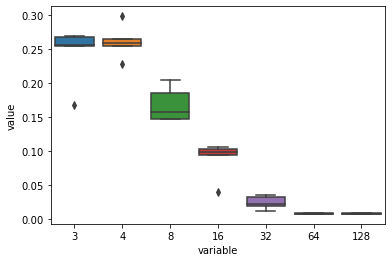

In [70]:
g = sns.boxplot(x='variable', y='value', data=df_melted) #64

In [72]:
import seaborn as sns 
#step_back_number
dic = {}
for i in [4,5,6,7,8]:
    dic[i] = exp(i,5,64,100,2)
df_1 = pd.DataFrame(dic)
df_melted = pd.melt(df_1)

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 64)                16896     
                                                                 
 dense_41 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 - 1s - loss: 2.1268 - 1s/epoch - 291ms/step
Epoch 2/100
5/5 - 0s - loss: 1.5077 - 26ms/epoch - 5ms/step
Epoch 3/100
5/5 - 0s - loss: 0.9518 - 26ms/epoch - 5ms/step
Epoch 4/100
5/5 - 0s - loss: 0.4556 - 25ms/epoch - 5ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0949 - 27ms/epoch - 5ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0238 - 29ms/epoch - 6ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0910 - 28ms/epoch - 6ms/step
Epoch 8/100
5/5 - 0s - lo

5/5 - 0s - loss: 0.0781 - 24ms/epoch - 5ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0225 - 23ms/epoch - 5ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0039 - 21ms/epoch - 4ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0122 - 21ms/epoch - 4ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0116 - 21ms/epoch - 4ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0044 - 23ms/epoch - 5ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0025 - 21ms/epoch - 4ms/step
Epoch 14/100
5/5 - 0s - loss: 0.0038 - 20ms/epoch - 4ms/step
Epoch 15/100
5/5 - 0s - loss: 0.0031 - 23ms/epoch - 5ms/step
Epoch 16/100
5/5 - 0s - loss: 0.0020 - 21ms/epoch - 4ms/step
Epoch 17/100
5/5 - 0s - loss: 0.0023 - 24ms/epoch - 5ms/step
Epoch 18/100
5/5 - 0s - loss: 0.0023 - 21ms/epoch - 4ms/step
Epoch 19/100
5/5 - 0s - loss: 0.0021 - 20ms/epoch - 4ms/step
Epoch 20/100
5/5 - 0s - loss: 0.0020 - 20ms/epoch - 4ms/step
Epoch 21/100
5/5 - 0s - loss: 0.0020 - 20ms/epoch - 4ms/step
Epoch 22/100
5/5 - 0s - loss: 0.0020 - 20ms/epoch - 4ms/step
Epoch 23/100
5/5 - 0s - loss: 0.0019 - 

Epoch 26/100
5/5 - 0s - loss: 0.0019 - 36ms/epoch - 7ms/step
Epoch 27/100
5/5 - 0s - loss: 0.0019 - 33ms/epoch - 7ms/step
Epoch 28/100
5/5 - 0s - loss: 0.0018 - 56ms/epoch - 11ms/step
Epoch 29/100
5/5 - 0s - loss: 0.0018 - 49ms/epoch - 10ms/step
Epoch 30/100
5/5 - 0s - loss: 0.0018 - 45ms/epoch - 9ms/step
Epoch 31/100
5/5 - 0s - loss: 0.0018 - 36ms/epoch - 7ms/step
Epoch 32/100
5/5 - 0s - loss: 0.0018 - 26ms/epoch - 5ms/step
Epoch 33/100
5/5 - 0s - loss: 0.0017 - 23ms/epoch - 5ms/step
Epoch 34/100
5/5 - 0s - loss: 0.0017 - 21ms/epoch - 4ms/step
Epoch 35/100
5/5 - 0s - loss: 0.0017 - 19ms/epoch - 4ms/step
Epoch 36/100
5/5 - 0s - loss: 0.0017 - 19ms/epoch - 4ms/step
Epoch 37/100
5/5 - 0s - loss: 0.0017 - 20ms/epoch - 4ms/step
Epoch 38/100
5/5 - 0s - loss: 0.0016 - 20ms/epoch - 4ms/step
Epoch 39/100
5/5 - 0s - loss: 0.0016 - 20ms/epoch - 4ms/step
Epoch 40/100
5/5 - 0s - loss: 0.0016 - 21ms/epoch - 4ms/step
Epoch 41/100
5/5 - 0s - loss: 0.0016 - 20ms/epoch - 4ms/step
Epoch 42/100
5/5 - 0s 

5/5 - 0s - loss: 0.0015 - 19ms/epoch - 4ms/step
Epoch 45/100
5/5 - 0s - loss: 0.0014 - 23ms/epoch - 5ms/step
Epoch 46/100
5/5 - 0s - loss: 0.0014 - 17ms/epoch - 3ms/step
Epoch 47/100
5/5 - 0s - loss: 0.0014 - 18ms/epoch - 4ms/step
Epoch 48/100
5/5 - 0s - loss: 0.0014 - 19ms/epoch - 4ms/step
Epoch 49/100
5/5 - 0s - loss: 0.0014 - 17ms/epoch - 3ms/step
Epoch 50/100
5/5 - 0s - loss: 0.0014 - 16ms/epoch - 3ms/step
Epoch 51/100
5/5 - 0s - loss: 0.0014 - 17ms/epoch - 3ms/step
Epoch 52/100
5/5 - 0s - loss: 0.0013 - 16ms/epoch - 3ms/step
Epoch 53/100
5/5 - 0s - loss: 0.0013 - 17ms/epoch - 3ms/step
Epoch 54/100
5/5 - 0s - loss: 0.0013 - 19ms/epoch - 4ms/step
Epoch 55/100
5/5 - 0s - loss: 0.0013 - 18ms/epoch - 4ms/step
Epoch 56/100
5/5 - 0s - loss: 0.0013 - 17ms/epoch - 3ms/step
Epoch 57/100
5/5 - 0s - loss: 0.0012 - 19ms/epoch - 4ms/step
Epoch 58/100
5/5 - 0s - loss: 0.0012 - 19ms/epoch - 4ms/step
Epoch 59/100
5/5 - 0s - loss: 0.0012 - 20ms/epoch - 4ms/step
Epoch 60/100
5/5 - 0s - loss: 0.0012 

Epoch 63/100
5/5 - 0s - loss: 0.0011 - 27ms/epoch - 5ms/step
Epoch 64/100
5/5 - 0s - loss: 0.0010 - 22ms/epoch - 4ms/step
Epoch 65/100
5/5 - 0s - loss: 0.0010 - 25ms/epoch - 5ms/step
Epoch 66/100
5/5 - 0s - loss: 0.0010 - 21ms/epoch - 4ms/step
Epoch 67/100
5/5 - 0s - loss: 9.8618e-04 - 23ms/epoch - 5ms/step
Epoch 68/100
5/5 - 0s - loss: 9.6056e-04 - 23ms/epoch - 5ms/step
Epoch 69/100
5/5 - 0s - loss: 9.5520e-04 - 21ms/epoch - 4ms/step
Epoch 70/100
5/5 - 0s - loss: 9.2474e-04 - 21ms/epoch - 4ms/step
Epoch 71/100
5/5 - 0s - loss: 9.1491e-04 - 22ms/epoch - 4ms/step
Epoch 72/100
5/5 - 0s - loss: 9.0078e-04 - 22ms/epoch - 4ms/step
Epoch 73/100
5/5 - 0s - loss: 8.7909e-04 - 20ms/epoch - 4ms/step
Epoch 74/100
5/5 - 0s - loss: 8.7009e-04 - 23ms/epoch - 5ms/step
Epoch 75/100
5/5 - 0s - loss: 8.6147e-04 - 23ms/epoch - 5ms/step
Epoch 76/100
5/5 - 0s - loss: 8.4366e-04 - 24ms/epoch - 5ms/step
Epoch 77/100
5/5 - 0s - loss: 8.1946e-04 - 23ms/epoch - 5ms/step
Epoch 78/100
5/5 - 0s - loss: 8.1400e-04 

Epoch 78/100
5/5 - 0s - loss: 3.8686e-04 - 25ms/epoch - 5ms/step
Epoch 79/100
5/5 - 0s - loss: 3.7880e-04 - 19ms/epoch - 4ms/step
Epoch 80/100
5/5 - 0s - loss: 3.7465e-04 - 19ms/epoch - 4ms/step
Epoch 81/100
5/5 - 0s - loss: 3.6349e-04 - 22ms/epoch - 4ms/step
Epoch 82/100
5/5 - 0s - loss: 3.7057e-04 - 19ms/epoch - 4ms/step
Epoch 83/100
5/5 - 0s - loss: 3.5476e-04 - 22ms/epoch - 4ms/step
Epoch 84/100
5/5 - 0s - loss: 3.5206e-04 - 20ms/epoch - 4ms/step
Epoch 85/100
5/5 - 0s - loss: 3.3492e-04 - 19ms/epoch - 4ms/step
Epoch 86/100
5/5 - 0s - loss: 3.3201e-04 - 21ms/epoch - 4ms/step
Epoch 87/100
5/5 - 0s - loss: 3.2393e-04 - 21ms/epoch - 4ms/step
Epoch 88/100
5/5 - 0s - loss: 3.1906e-04 - 22ms/epoch - 4ms/step
Epoch 89/100
5/5 - 0s - loss: 3.1465e-04 - 22ms/epoch - 4ms/step
Epoch 90/100
5/5 - 0s - loss: 3.0542e-04 - 24ms/epoch - 5ms/step
Epoch 91/100
5/5 - 0s - loss: 3.0179e-04 - 21ms/epoch - 4ms/step
Epoch 92/100
5/5 - 0s - loss: 3.0265e-04 - 22ms/epoch - 4ms/step
Epoch 93/100
5/5 - 0s - l

Epoch 94/100
5/5 - 0s - loss: 3.5641e-04 - 23ms/epoch - 5ms/step
Epoch 95/100
5/5 - 0s - loss: 3.5686e-04 - 25ms/epoch - 5ms/step
Epoch 96/100
5/5 - 0s - loss: 3.4961e-04 - 22ms/epoch - 4ms/step
Epoch 97/100
5/5 - 0s - loss: 3.3443e-04 - 22ms/epoch - 4ms/step
Epoch 98/100
5/5 - 0s - loss: 3.2513e-04 - 18ms/epoch - 4ms/step
Epoch 99/100
5/5 - 0s - loss: 3.1728e-04 - 22ms/epoch - 4ms/step
Epoch 100/100
5/5 - 0s - loss: 3.1049e-04 - 24ms/epoch - 5ms/step
5/5 - 0s - loss: 3.0419e-04 - 348ms/epoch - 70ms/step
Train Score: 0.0003 MSE (0.01744 RMSE)
1/1 [==============================] - 0s 18ms/step - loss: 4.8974e-04
Test Score: 0.0005 MSE (0.02213 RMSE)
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 64)                16896     
                                                                 
 dense_48 (Dense)            (None, 1)                 

 dense_49 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 - 1s - loss: 2.8197 - 1s/epoch - 283ms/step
Epoch 2/100
5/5 - 0s - loss: 1.9106 - 25ms/epoch - 5ms/step
Epoch 3/100
5/5 - 0s - loss: 1.1830 - 25ms/epoch - 5ms/step
Epoch 4/100
5/5 - 0s - loss: 0.5863 - 27ms/epoch - 5ms/step
Epoch 5/100
5/5 - 0s - loss: 0.1579 - 28ms/epoch - 6ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0131 - 26ms/epoch - 5ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0857 - 25ms/epoch - 5ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0555 - 24ms/epoch - 5ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0062 - 26ms/epoch - 5ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0087 - 24ms/epoch - 5ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0148 - 24ms/epoch - 5ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0082 - 25ms/epoch - 5ms/step
Epoch 13/

Epoch 13/100
5/5 - 0s - loss: 0.0030 - 26ms/epoch - 5ms/step
Epoch 14/100
5/5 - 0s - loss: 0.0037 - 25ms/epoch - 5ms/step
Epoch 15/100
5/5 - 0s - loss: 0.0024 - 22ms/epoch - 4ms/step
Epoch 16/100
5/5 - 0s - loss: 0.0020 - 24ms/epoch - 5ms/step
Epoch 17/100
5/5 - 0s - loss: 0.0022 - 23ms/epoch - 5ms/step
Epoch 18/100
5/5 - 0s - loss: 0.0020 - 25ms/epoch - 5ms/step
Epoch 19/100
5/5 - 0s - loss: 0.0018 - 25ms/epoch - 5ms/step
Epoch 20/100
5/5 - 0s - loss: 0.0018 - 25ms/epoch - 5ms/step
Epoch 21/100
5/5 - 0s - loss: 0.0018 - 22ms/epoch - 4ms/step
Epoch 22/100
5/5 - 0s - loss: 0.0017 - 24ms/epoch - 5ms/step
Epoch 23/100
5/5 - 0s - loss: 0.0017 - 23ms/epoch - 5ms/step
Epoch 24/100
5/5 - 0s - loss: 0.0017 - 24ms/epoch - 5ms/step
Epoch 25/100
5/5 - 0s - loss: 0.0017 - 22ms/epoch - 4ms/step
Epoch 26/100
5/5 - 0s - loss: 0.0016 - 23ms/epoch - 5ms/step
Epoch 27/100
5/5 - 0s - loss: 0.0016 - 23ms/epoch - 5ms/step
Epoch 28/100
5/5 - 0s - loss: 0.0016 - 24ms/epoch - 5ms/step
Epoch 29/100
5/5 - 0s - 

Epoch 30/100
5/5 - 0s - loss: 0.0015 - 20ms/epoch - 4ms/step
Epoch 31/100
5/5 - 0s - loss: 0.0015 - 21ms/epoch - 4ms/step
Epoch 32/100
5/5 - 0s - loss: 0.0014 - 24ms/epoch - 5ms/step
Epoch 33/100
5/5 - 0s - loss: 0.0014 - 21ms/epoch - 4ms/step
Epoch 34/100
5/5 - 0s - loss: 0.0014 - 21ms/epoch - 4ms/step
Epoch 35/100
5/5 - 0s - loss: 0.0014 - 22ms/epoch - 4ms/step
Epoch 36/100
5/5 - 0s - loss: 0.0013 - 20ms/epoch - 4ms/step
Epoch 37/100
5/5 - 0s - loss: 0.0013 - 22ms/epoch - 4ms/step
Epoch 38/100
5/5 - 0s - loss: 0.0013 - 23ms/epoch - 5ms/step
Epoch 39/100
5/5 - 0s - loss: 0.0012 - 20ms/epoch - 4ms/step
Epoch 40/100
5/5 - 0s - loss: 0.0012 - 23ms/epoch - 5ms/step
Epoch 41/100
5/5 - 0s - loss: 0.0012 - 21ms/epoch - 4ms/step
Epoch 42/100
5/5 - 0s - loss: 0.0012 - 22ms/epoch - 4ms/step
Epoch 43/100
5/5 - 0s - loss: 0.0012 - 21ms/epoch - 4ms/step
Epoch 44/100
5/5 - 0s - loss: 0.0011 - 22ms/epoch - 4ms/step
Epoch 45/100
5/5 - 0s - loss: 0.0011 - 23ms/epoch - 5ms/step
Epoch 46/100
5/5 - 0s - 

Epoch 46/100
5/5 - 0s - loss: 7.0851e-04 - 23ms/epoch - 5ms/step
Epoch 47/100
5/5 - 0s - loss: 7.0110e-04 - 24ms/epoch - 5ms/step
Epoch 48/100
5/5 - 0s - loss: 6.7815e-04 - 24ms/epoch - 5ms/step
Epoch 49/100
5/5 - 0s - loss: 6.6895e-04 - 24ms/epoch - 5ms/step
Epoch 50/100
5/5 - 0s - loss: 6.4354e-04 - 23ms/epoch - 5ms/step
Epoch 51/100
5/5 - 0s - loss: 6.3717e-04 - 23ms/epoch - 5ms/step
Epoch 52/100
5/5 - 0s - loss: 6.1743e-04 - 23ms/epoch - 5ms/step
Epoch 53/100
5/5 - 0s - loss: 6.0131e-04 - 21ms/epoch - 4ms/step
Epoch 54/100
5/5 - 0s - loss: 6.0212e-04 - 25ms/epoch - 5ms/step
Epoch 55/100
5/5 - 0s - loss: 5.8407e-04 - 22ms/epoch - 4ms/step
Epoch 56/100
5/5 - 0s - loss: 5.6665e-04 - 25ms/epoch - 5ms/step
Epoch 57/100
5/5 - 0s - loss: 5.5404e-04 - 21ms/epoch - 4ms/step
Epoch 58/100
5/5 - 0s - loss: 5.3637e-04 - 24ms/epoch - 5ms/step
Epoch 59/100
5/5 - 0s - loss: 5.2469e-04 - 23ms/epoch - 5ms/step
Epoch 60/100
5/5 - 0s - loss: 5.1463e-04 - 23ms/epoch - 5ms/step
Epoch 61/100
5/5 - 0s - l

Epoch 61/100
5/5 - 0s - loss: 6.1522e-04 - 22ms/epoch - 4ms/step
Epoch 62/100
5/5 - 0s - loss: 6.0512e-04 - 21ms/epoch - 4ms/step
Epoch 63/100
5/5 - 0s - loss: 5.9665e-04 - 19ms/epoch - 4ms/step
Epoch 64/100
5/5 - 0s - loss: 5.8065e-04 - 21ms/epoch - 4ms/step
Epoch 65/100
5/5 - 0s - loss: 5.7316e-04 - 21ms/epoch - 4ms/step
Epoch 66/100
5/5 - 0s - loss: 5.6205e-04 - 22ms/epoch - 4ms/step
Epoch 67/100
5/5 - 0s - loss: 5.4769e-04 - 19ms/epoch - 4ms/step
Epoch 68/100
5/5 - 0s - loss: 5.3848e-04 - 19ms/epoch - 4ms/step
Epoch 69/100
5/5 - 0s - loss: 5.2882e-04 - 18ms/epoch - 4ms/step
Epoch 70/100
5/5 - 0s - loss: 5.2589e-04 - 20ms/epoch - 4ms/step
Epoch 71/100
5/5 - 0s - loss: 5.1166e-04 - 19ms/epoch - 4ms/step
Epoch 72/100
5/5 - 0s - loss: 5.1992e-04 - 20ms/epoch - 4ms/step
Epoch 73/100
5/5 - 0s - loss: 5.0948e-04 - 20ms/epoch - 4ms/step
Epoch 74/100
5/5 - 0s - loss: 4.9442e-04 - 23ms/epoch - 5ms/step
Epoch 75/100
5/5 - 0s - loss: 4.9731e-04 - 21ms/epoch - 4ms/step
Epoch 76/100
5/5 - 0s - l

5/5 - 0s - loss: 4.5548e-04 - 20ms/epoch - 4ms/step
Epoch 77/100
5/5 - 0s - loss: 4.4342e-04 - 21ms/epoch - 4ms/step
Epoch 78/100
5/5 - 0s - loss: 4.3482e-04 - 20ms/epoch - 4ms/step
Epoch 79/100
5/5 - 0s - loss: 4.3605e-04 - 22ms/epoch - 4ms/step
Epoch 80/100
5/5 - 0s - loss: 4.1891e-04 - 20ms/epoch - 4ms/step
Epoch 81/100
5/5 - 0s - loss: 4.1199e-04 - 20ms/epoch - 4ms/step
Epoch 82/100
5/5 - 0s - loss: 4.0520e-04 - 21ms/epoch - 4ms/step
Epoch 83/100
5/5 - 0s - loss: 3.9638e-04 - 20ms/epoch - 4ms/step
Epoch 84/100
5/5 - 0s - loss: 3.9121e-04 - 20ms/epoch - 4ms/step
Epoch 85/100
5/5 - 0s - loss: 3.9245e-04 - 20ms/epoch - 4ms/step
Epoch 86/100
5/5 - 0s - loss: 3.7513e-04 - 22ms/epoch - 4ms/step
Epoch 87/100
5/5 - 0s - loss: 3.8777e-04 - 21ms/epoch - 4ms/step
Epoch 88/100
5/5 - 0s - loss: 3.8490e-04 - 24ms/epoch - 5ms/step
Epoch 89/100
5/5 - 0s - loss: 3.6962e-04 - 22ms/epoch - 4ms/step
Epoch 90/100
5/5 - 0s - loss: 3.7463e-04 - 20ms/epoch - 4ms/step
Epoch 91/100
5/5 - 0s - loss: 3.5518e-

Epoch 92/100
5/5 - 0s - loss: 3.6219e-04 - 26ms/epoch - 5ms/step
Epoch 93/100
5/5 - 0s - loss: 3.5981e-04 - 25ms/epoch - 5ms/step
Epoch 94/100
5/5 - 0s - loss: 3.5899e-04 - 24ms/epoch - 5ms/step
Epoch 95/100
5/5 - 0s - loss: 3.3885e-04 - 25ms/epoch - 5ms/step
Epoch 96/100
5/5 - 0s - loss: 3.5233e-04 - 25ms/epoch - 5ms/step
Epoch 97/100
5/5 - 0s - loss: 3.3731e-04 - 24ms/epoch - 5ms/step
Epoch 98/100
5/5 - 0s - loss: 3.3568e-04 - 22ms/epoch - 4ms/step
Epoch 99/100
5/5 - 0s - loss: 3.3310e-04 - 26ms/epoch - 5ms/step
Epoch 100/100
5/5 - 0s - loss: 3.3863e-04 - 23ms/epoch - 5ms/step
5/5 - 0s - loss: 3.2434e-04 - 355ms/epoch - 71ms/step
Train Score: 0.0003 MSE (0.01801 RMSE)
1/1 [==============================] - 0s 18ms/step - loss: 6.1108e-05
Test Score: 0.0001 MSE (0.00782 RMSE)
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 64)                16

                                                                 
 dense_57 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 - 2s - loss: 2.1428 - 2s/epoch - 313ms/step
Epoch 2/100
5/5 - 0s - loss: 1.0984 - 29ms/epoch - 6ms/step
Epoch 3/100
5/5 - 0s - loss: 0.3363 - 28ms/epoch - 6ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0214 - 30ms/epoch - 6ms/step
Epoch 5/100
5/5 - 0s - loss: 0.1188 - 28ms/epoch - 6ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0610 - 28ms/epoch - 6ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0057 - 28ms/epoch - 6ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0198 - 29ms/epoch - 6ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0213 - 27ms/epoch - 5ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0077 - 27ms/epoch - 5ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0038 - 28ms/epoch - 6ms/step
Epoc

5/5 - 0s - loss: 0.0056 - 20ms/epoch - 4ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0031 - 20ms/epoch - 4ms/step
Epoch 14/100
5/5 - 0s - loss: 0.0020 - 19ms/epoch - 4ms/step
Epoch 15/100
5/5 - 0s - loss: 0.0028 - 20ms/epoch - 4ms/step
Epoch 16/100
5/5 - 0s - loss: 0.0022 - 19ms/epoch - 4ms/step
Epoch 17/100
5/5 - 0s - loss: 0.0019 - 21ms/epoch - 4ms/step
Epoch 18/100
5/5 - 0s - loss: 0.0021 - 34ms/epoch - 7ms/step
Epoch 19/100
5/5 - 0s - loss: 0.0019 - 36ms/epoch - 7ms/step
Epoch 20/100
5/5 - 0s - loss: 0.0018 - 30ms/epoch - 6ms/step
Epoch 21/100
5/5 - 0s - loss: 0.0019 - 30ms/epoch - 6ms/step
Epoch 22/100
5/5 - 0s - loss: 0.0018 - 33ms/epoch - 7ms/step
Epoch 23/100
5/5 - 0s - loss: 0.0018 - 32ms/epoch - 6ms/step
Epoch 24/100
5/5 - 0s - loss: 0.0017 - 24ms/epoch - 5ms/step
Epoch 25/100
5/5 - 0s - loss: 0.0017 - 22ms/epoch - 4ms/step
Epoch 26/100
5/5 - 0s - loss: 0.0016 - 34ms/epoch - 7ms/step
Epoch 27/100
5/5 - 0s - loss: 0.0016 - 32ms/epoch - 6ms/step
Epoch 28/100
5/5 - 0s - loss: 0.0016 

Epoch 29/100
5/5 - 0s - loss: 0.0024 - 22ms/epoch - 4ms/step
Epoch 30/100
5/5 - 0s - loss: 0.0023 - 22ms/epoch - 4ms/step
Epoch 31/100
5/5 - 0s - loss: 0.0023 - 21ms/epoch - 4ms/step
Epoch 32/100
5/5 - 0s - loss: 0.0023 - 22ms/epoch - 4ms/step
Epoch 33/100
5/5 - 0s - loss: 0.0022 - 21ms/epoch - 4ms/step
Epoch 34/100
5/5 - 0s - loss: 0.0021 - 21ms/epoch - 4ms/step
Epoch 35/100
5/5 - 0s - loss: 0.0021 - 21ms/epoch - 4ms/step
Epoch 36/100
5/5 - 0s - loss: 0.0021 - 21ms/epoch - 4ms/step
Epoch 37/100
5/5 - 0s - loss: 0.0020 - 21ms/epoch - 4ms/step
Epoch 38/100
5/5 - 0s - loss: 0.0020 - 21ms/epoch - 4ms/step
Epoch 39/100
5/5 - 0s - loss: 0.0019 - 21ms/epoch - 4ms/step
Epoch 40/100
5/5 - 0s - loss: 0.0019 - 21ms/epoch - 4ms/step
Epoch 41/100
5/5 - 0s - loss: 0.0018 - 21ms/epoch - 4ms/step
Epoch 42/100
5/5 - 0s - loss: 0.0018 - 21ms/epoch - 4ms/step
Epoch 43/100
5/5 - 0s - loss: 0.0018 - 21ms/epoch - 4ms/step
Epoch 44/100
5/5 - 0s - loss: 0.0017 - 22ms/epoch - 4ms/step
Epoch 45/100
5/5 - 0s - 

Epoch 47/100
5/5 - 0s - loss: 0.0016 - 23ms/epoch - 5ms/step
Epoch 48/100
5/5 - 0s - loss: 0.0016 - 24ms/epoch - 5ms/step
Epoch 49/100
5/5 - 0s - loss: 0.0015 - 23ms/epoch - 5ms/step
Epoch 50/100
5/5 - 0s - loss: 0.0015 - 23ms/epoch - 5ms/step
Epoch 51/100
5/5 - 0s - loss: 0.0014 - 23ms/epoch - 5ms/step
Epoch 52/100
5/5 - 0s - loss: 0.0014 - 24ms/epoch - 5ms/step
Epoch 53/100
5/5 - 0s - loss: 0.0014 - 23ms/epoch - 5ms/step
Epoch 54/100
5/5 - 0s - loss: 0.0013 - 29ms/epoch - 6ms/step
Epoch 55/100
5/5 - 0s - loss: 0.0013 - 30ms/epoch - 6ms/step
Epoch 56/100
5/5 - 0s - loss: 0.0013 - 28ms/epoch - 6ms/step
Epoch 57/100
5/5 - 0s - loss: 0.0012 - 31ms/epoch - 6ms/step
Epoch 58/100
5/5 - 0s - loss: 0.0012 - 27ms/epoch - 5ms/step
Epoch 59/100
5/5 - 0s - loss: 0.0012 - 29ms/epoch - 6ms/step
Epoch 60/100
5/5 - 0s - loss: 0.0011 - 25ms/epoch - 5ms/step
Epoch 61/100
5/5 - 0s - loss: 0.0011 - 29ms/epoch - 6ms/step
Epoch 62/100
5/5 - 0s - loss: 0.0011 - 28ms/epoch - 6ms/step
Epoch 63/100
5/5 - 0s - 

Epoch 65/100
5/5 - 0s - loss: 9.6042e-04 - 21ms/epoch - 4ms/step
Epoch 66/100
5/5 - 0s - loss: 9.4538e-04 - 21ms/epoch - 4ms/step
Epoch 67/100
5/5 - 0s - loss: 8.9119e-04 - 21ms/epoch - 4ms/step
Epoch 68/100
5/5 - 0s - loss: 8.7529e-04 - 19ms/epoch - 4ms/step
Epoch 69/100
5/5 - 0s - loss: 8.4257e-04 - 20ms/epoch - 4ms/step
Epoch 70/100
5/5 - 0s - loss: 8.1486e-04 - 22ms/epoch - 4ms/step
Epoch 71/100
5/5 - 0s - loss: 7.9186e-04 - 22ms/epoch - 4ms/step
Epoch 72/100
5/5 - 0s - loss: 7.6400e-04 - 23ms/epoch - 5ms/step
Epoch 73/100
5/5 - 0s - loss: 7.4753e-04 - 23ms/epoch - 5ms/step
Epoch 74/100
5/5 - 0s - loss: 7.2249e-04 - 24ms/epoch - 5ms/step
Epoch 75/100
5/5 - 0s - loss: 7.0080e-04 - 23ms/epoch - 5ms/step
Epoch 76/100
5/5 - 0s - loss: 6.8069e-04 - 23ms/epoch - 5ms/step
Epoch 77/100
5/5 - 0s - loss: 6.6002e-04 - 21ms/epoch - 4ms/step
Epoch 78/100
5/5 - 0s - loss: 6.4666e-04 - 21ms/epoch - 4ms/step
Epoch 79/100
5/5 - 0s - loss: 6.2273e-04 - 20ms/epoch - 4ms/step
Epoch 80/100
5/5 - 0s - l

Epoch 81/100
5/5 - 0s - loss: 5.2370e-04 - 23ms/epoch - 5ms/step
Epoch 82/100
5/5 - 0s - loss: 5.1518e-04 - 22ms/epoch - 4ms/step
Epoch 83/100
5/5 - 0s - loss: 5.0155e-04 - 21ms/epoch - 4ms/step
Epoch 84/100
5/5 - 0s - loss: 4.8341e-04 - 20ms/epoch - 4ms/step
Epoch 85/100
5/5 - 0s - loss: 4.7470e-04 - 20ms/epoch - 4ms/step
Epoch 86/100
5/5 - 0s - loss: 4.7547e-04 - 20ms/epoch - 4ms/step
Epoch 87/100
5/5 - 0s - loss: 4.5497e-04 - 21ms/epoch - 4ms/step
Epoch 88/100
5/5 - 0s - loss: 4.5935e-04 - 23ms/epoch - 5ms/step
Epoch 89/100
5/5 - 0s - loss: 4.3941e-04 - 24ms/epoch - 5ms/step
Epoch 90/100
5/5 - 0s - loss: 4.3422e-04 - 22ms/epoch - 4ms/step
Epoch 91/100
5/5 - 0s - loss: 4.4371e-04 - 24ms/epoch - 5ms/step
Epoch 92/100
5/5 - 0s - loss: 4.3139e-04 - 27ms/epoch - 5ms/step
Epoch 93/100
5/5 - 0s - loss: 4.1872e-04 - 31ms/epoch - 6ms/step
Epoch 94/100
5/5 - 0s - loss: 4.1299e-04 - 32ms/epoch - 6ms/step
Epoch 95/100
5/5 - 0s - loss: 4.1085e-04 - 31ms/epoch - 6ms/step
Epoch 96/100
5/5 - 0s - l

Epoch 98/100
5/5 - 0s - loss: 5.0683e-04 - 27ms/epoch - 5ms/step
Epoch 99/100
5/5 - 0s - loss: 5.1715e-04 - 27ms/epoch - 5ms/step
Epoch 100/100
5/5 - 0s - loss: 4.9229e-04 - 26ms/epoch - 5ms/step
5/5 - 0s - loss: 5.0075e-04 - 427ms/epoch - 85ms/step
Train Score: 0.0005 MSE (0.02238 RMSE)
1/1 [==============================] - 0s 20ms/step - loss: 7.5163e-05
Test Score: 0.0001 MSE (0.00867 RMSE)
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 64)                16896     
                                                                 
 dense_64 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 - 2s - loss: 2.0013 - 2s/epoch 

Epoch 1/100
5/5 - 2s - loss: 2.9769 - 2s/epoch - 344ms/step
Epoch 2/100
5/5 - 0s - loss: 1.6187 - 30ms/epoch - 6ms/step
Epoch 3/100
5/5 - 0s - loss: 0.6116 - 30ms/epoch - 6ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0646 - 28ms/epoch - 6ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0994 - 28ms/epoch - 6ms/step
Epoch 6/100
5/5 - 0s - loss: 0.1037 - 29ms/epoch - 6ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0098 - 28ms/epoch - 6ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0154 - 29ms/epoch - 6ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0254 - 28ms/epoch - 6ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0117 - 28ms/epoch - 6ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0026 - 29ms/epoch - 6ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0056 - 29ms/epoch - 6ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0053 - 28ms/epoch - 6ms/step
Epoch 14/100
5/5 - 0s - loss: 0.0027 - 29ms/epoch - 6ms/step
Epoch 15/100
5/5 - 0s - loss: 0.0029 - 28ms/epoch - 6ms/step
Epoch 16/100
5/5 - 0s - loss: 0.0030 - 28ms/epoch - 6ms/step
Epoch 17/100
5/5 - 0s - loss: 0.0

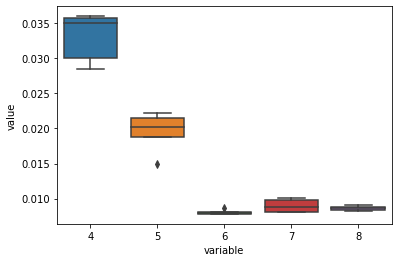

In [73]:
g = sns.boxplot(x='variable', y='value', data=df_melted) #6

In [76]:
#batch_size
dic = {}
for i in [1,2,3,4,5,6,7,8,9,10,15,20]:
    dic[i] = exp(6,5,64,100,i)
df_1 = pd.DataFrame(dic)
df_melted = pd.melt(df_1)

Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_126 (LSTM)             (None, 64)                16896     
                                                                 
 dense_126 (Dense)           (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 - 1s - loss: 2.3085 - 1s/epoch - 283ms/step
Epoch 2/100
5/5 - 0s - loss: 1.4310 - 28ms/epoch - 6ms/step
Epoch 3/100
5/5 - 0s - loss: 0.7012 - 31ms/epoch - 6ms/step
Epoch 4/100
5/5 - 0s - loss: 0.1782 - 30ms/epoch - 6ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0294 - 30ms/epoch - 6ms/step
Epoch 6/100
5/5 - 0s - loss: 0.1143 - 28ms/epoch - 6ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0358 - 26ms/epoch - 5ms/step
Epoch 8/100
5/5 - 0s - l

Epoch 7/100
5/5 - 0s - loss: 0.0063 - 23ms/epoch - 5ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0133 - 23ms/epoch - 5ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0205 - 26ms/epoch - 5ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0089 - 23ms/epoch - 5ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0020 - 22ms/epoch - 4ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0045 - 30ms/epoch - 6ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0037 - 23ms/epoch - 5ms/step
Epoch 14/100
5/5 - 0s - loss: 0.0018 - 23ms/epoch - 5ms/step
Epoch 15/100
5/5 - 0s - loss: 0.0022 - 22ms/epoch - 4ms/step
Epoch 16/100
5/5 - 0s - loss: 0.0022 - 18ms/epoch - 4ms/step
Epoch 17/100
5/5 - 0s - loss: 0.0017 - 22ms/epoch - 4ms/step
Epoch 18/100
5/5 - 0s - loss: 0.0018 - 26ms/epoch - 5ms/step
Epoch 19/100
5/5 - 0s - loss: 0.0018 - 24ms/epoch - 5ms/step
Epoch 20/100
5/5 - 0s - loss: 0.0016 - 22ms/epoch - 4ms/step
Epoch 21/100
5/5 - 0s - loss: 0.0016 - 21ms/epoch - 4ms/step
Epoch 22/100
5/5 - 0s - loss: 0.0016 - 27ms/epoch - 5ms/step
Epoch 23/100
5/5 - 0s - los

Epoch 24/100
5/5 - 0s - loss: 0.0021 - 20ms/epoch - 4ms/step
Epoch 25/100
5/5 - 0s - loss: 0.0021 - 22ms/epoch - 4ms/step
Epoch 26/100
5/5 - 0s - loss: 0.0021 - 21ms/epoch - 4ms/step
Epoch 27/100
5/5 - 0s - loss: 0.0020 - 22ms/epoch - 4ms/step
Epoch 28/100
5/5 - 0s - loss: 0.0020 - 22ms/epoch - 4ms/step
Epoch 29/100
5/5 - 0s - loss: 0.0019 - 22ms/epoch - 4ms/step
Epoch 30/100
5/5 - 0s - loss: 0.0019 - 20ms/epoch - 4ms/step
Epoch 31/100
5/5 - 0s - loss: 0.0019 - 22ms/epoch - 4ms/step
Epoch 32/100
5/5 - 0s - loss: 0.0019 - 22ms/epoch - 4ms/step
Epoch 33/100
5/5 - 0s - loss: 0.0018 - 22ms/epoch - 4ms/step
Epoch 34/100
5/5 - 0s - loss: 0.0018 - 23ms/epoch - 5ms/step
Epoch 35/100
5/5 - 0s - loss: 0.0017 - 23ms/epoch - 5ms/step
Epoch 36/100
5/5 - 0s - loss: 0.0017 - 20ms/epoch - 4ms/step
Epoch 37/100
5/5 - 0s - loss: 0.0017 - 23ms/epoch - 5ms/step
Epoch 38/100
5/5 - 0s - loss: 0.0016 - 22ms/epoch - 4ms/step
Epoch 39/100
5/5 - 0s - loss: 0.0016 - 23ms/epoch - 5ms/step
Epoch 40/100
5/5 - 0s - 

5/5 - 0s - loss: 0.0014 - 30ms/epoch - 6ms/step
Epoch 42/100
5/5 - 0s - loss: 0.0014 - 28ms/epoch - 6ms/step
Epoch 43/100
5/5 - 0s - loss: 0.0014 - 26ms/epoch - 5ms/step
Epoch 44/100
5/5 - 0s - loss: 0.0014 - 28ms/epoch - 6ms/step
Epoch 45/100
5/5 - 0s - loss: 0.0013 - 31ms/epoch - 6ms/step
Epoch 46/100
5/5 - 0s - loss: 0.0013 - 26ms/epoch - 5ms/step
Epoch 47/100
5/5 - 0s - loss: 0.0013 - 25ms/epoch - 5ms/step
Epoch 48/100
5/5 - 0s - loss: 0.0012 - 25ms/epoch - 5ms/step
Epoch 49/100
5/5 - 0s - loss: 0.0012 - 30ms/epoch - 6ms/step
Epoch 50/100
5/5 - 0s - loss: 0.0012 - 28ms/epoch - 6ms/step
Epoch 51/100
5/5 - 0s - loss: 0.0012 - 25ms/epoch - 5ms/step
Epoch 52/100
5/5 - 0s - loss: 0.0011 - 24ms/epoch - 5ms/step
Epoch 53/100
5/5 - 0s - loss: 0.0011 - 24ms/epoch - 5ms/step
Epoch 54/100
5/5 - 0s - loss: 0.0011 - 20ms/epoch - 4ms/step
Epoch 55/100
5/5 - 0s - loss: 0.0011 - 21ms/epoch - 4ms/step
Epoch 56/100
5/5 - 0s - loss: 0.0010 - 18ms/epoch - 4ms/step
Epoch 57/100
5/5 - 0s - loss: 0.0010 

5/5 - 0s - loss: 9.3757e-04 - 22ms/epoch - 4ms/step
Epoch 59/100
5/5 - 0s - loss: 9.2676e-04 - 24ms/epoch - 5ms/step
Epoch 60/100
5/5 - 0s - loss: 8.9317e-04 - 22ms/epoch - 4ms/step
Epoch 61/100
5/5 - 0s - loss: 8.6865e-04 - 21ms/epoch - 4ms/step
Epoch 62/100
5/5 - 0s - loss: 8.4247e-04 - 25ms/epoch - 5ms/step
Epoch 63/100
5/5 - 0s - loss: 8.1731e-04 - 29ms/epoch - 6ms/step
Epoch 64/100
5/5 - 0s - loss: 7.9500e-04 - 31ms/epoch - 6ms/step
Epoch 65/100
5/5 - 0s - loss: 7.7659e-04 - 29ms/epoch - 6ms/step
Epoch 66/100
5/5 - 0s - loss: 7.5343e-04 - 33ms/epoch - 7ms/step
Epoch 67/100
5/5 - 0s - loss: 7.3161e-04 - 24ms/epoch - 5ms/step
Epoch 68/100
5/5 - 0s - loss: 7.1638e-04 - 28ms/epoch - 6ms/step
Epoch 69/100
5/5 - 0s - loss: 7.2582e-04 - 26ms/epoch - 5ms/step
Epoch 70/100
5/5 - 0s - loss: 6.7943e-04 - 28ms/epoch - 6ms/step
Epoch 71/100
5/5 - 0s - loss: 6.6848e-04 - 27ms/epoch - 5ms/step
Epoch 72/100
5/5 - 0s - loss: 6.3912e-04 - 26ms/epoch - 5ms/step
Epoch 73/100
5/5 - 0s - loss: 6.2640e-

Epoch 74/100
5/5 - 0s - loss: 5.4278e-04 - 24ms/epoch - 5ms/step
Epoch 75/100
5/5 - 0s - loss: 5.2941e-04 - 23ms/epoch - 5ms/step
Epoch 76/100
5/5 - 0s - loss: 4.9847e-04 - 23ms/epoch - 5ms/step
Epoch 77/100
5/5 - 0s - loss: 4.8317e-04 - 24ms/epoch - 5ms/step
Epoch 78/100
5/5 - 0s - loss: 4.7122e-04 - 23ms/epoch - 5ms/step
Epoch 79/100
5/5 - 0s - loss: 4.7822e-04 - 22ms/epoch - 4ms/step
Epoch 80/100
5/5 - 0s - loss: 4.6574e-04 - 23ms/epoch - 5ms/step
Epoch 81/100
5/5 - 0s - loss: 4.5303e-04 - 23ms/epoch - 5ms/step
Epoch 82/100
5/5 - 0s - loss: 4.2710e-04 - 23ms/epoch - 5ms/step
Epoch 83/100
5/5 - 0s - loss: 4.1655e-04 - 24ms/epoch - 5ms/step
Epoch 84/100
5/5 - 0s - loss: 4.1181e-04 - 23ms/epoch - 5ms/step
Epoch 85/100
5/5 - 0s - loss: 3.9690e-04 - 25ms/epoch - 5ms/step
Epoch 86/100
5/5 - 0s - loss: 3.9032e-04 - 23ms/epoch - 5ms/step
Epoch 87/100
5/5 - 0s - loss: 3.8177e-04 - 24ms/epoch - 5ms/step
Epoch 88/100
5/5 - 0s - loss: 3.7385e-04 - 22ms/epoch - 4ms/step
Epoch 89/100
5/5 - 0s - l

Epoch 90/100
5/5 - 0s - loss: 4.2430e-04 - 29ms/epoch - 6ms/step
Epoch 91/100
5/5 - 0s - loss: 4.1640e-04 - 28ms/epoch - 6ms/step
Epoch 92/100
5/5 - 0s - loss: 4.0791e-04 - 27ms/epoch - 5ms/step
Epoch 93/100
5/5 - 0s - loss: 4.0049e-04 - 27ms/epoch - 5ms/step
Epoch 94/100
5/5 - 0s - loss: 3.9505e-04 - 24ms/epoch - 5ms/step
Epoch 95/100
5/5 - 0s - loss: 3.8800e-04 - 25ms/epoch - 5ms/step
Epoch 96/100
5/5 - 0s - loss: 3.8256e-04 - 24ms/epoch - 5ms/step
Epoch 97/100
5/5 - 0s - loss: 3.7307e-04 - 26ms/epoch - 5ms/step
Epoch 98/100
5/5 - 0s - loss: 3.6799e-04 - 26ms/epoch - 5ms/step
Epoch 99/100
5/5 - 0s - loss: 3.6625e-04 - 26ms/epoch - 5ms/step
Epoch 100/100
5/5 - 0s - loss: 3.5681e-04 - 24ms/epoch - 5ms/step
5/5 - 0s - loss: 3.5074e-04 - 433ms/epoch - 87ms/step
Train Score: 0.0004 MSE (0.01873 RMSE)
1/1 [==============================] - 0s 20ms/step - loss: 9.9836e-05
Test Score: 0.0001 MSE (0.00999 RMSE)
Model: "sequential_133"
__________________________________________________________

 lstm_134 (LSTM)             (None, 64)                16896     
                                                                 
 dense_134 (Dense)           (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 - 2s - loss: 2.1902 - 2s/epoch - 323ms/step
Epoch 2/100
5/5 - 0s - loss: 1.1714 - 26ms/epoch - 5ms/step
Epoch 3/100
5/5 - 0s - loss: 0.4058 - 29ms/epoch - 6ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0306 - 25ms/epoch - 5ms/step
Epoch 5/100
5/5 - 0s - loss: 0.1020 - 23ms/epoch - 5ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0820 - 24ms/epoch - 5ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0072 - 24ms/epoch - 5ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0139 - 25ms/epoch - 5ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0219 - 25ms/epoch - 5ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0099 - 24ms/epoch - 5ms/step

5/5 - 0s - loss: 0.0222 - 24ms/epoch - 5ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0094 - 23ms/epoch - 5ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0037 - 24ms/epoch - 5ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0064 - 23ms/epoch - 5ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0047 - 23ms/epoch - 5ms/step
Epoch 14/100
5/5 - 0s - loss: 0.0026 - 23ms/epoch - 5ms/step
Epoch 15/100
5/5 - 0s - loss: 0.0032 - 23ms/epoch - 5ms/step
Epoch 16/100
5/5 - 0s - loss: 0.0030 - 23ms/epoch - 5ms/step
Epoch 17/100
5/5 - 0s - loss: 0.0026 - 24ms/epoch - 5ms/step
Epoch 18/100
5/5 - 0s - loss: 0.0025 - 23ms/epoch - 5ms/step
Epoch 19/100
5/5 - 0s - loss: 0.0025 - 22ms/epoch - 4ms/step
Epoch 20/100
5/5 - 0s - loss: 0.0024 - 22ms/epoch - 4ms/step
Epoch 21/100
5/5 - 0s - loss: 0.0024 - 23ms/epoch - 5ms/step
Epoch 22/100
5/5 - 0s - loss: 0.0023 - 23ms/epoch - 5ms/step
Epoch 23/100
5/5 - 0s - loss: 0.0022 - 23ms/epoch - 5ms/step
Epoch 24/100
5/5 - 0s - loss: 0.0022 - 23ms/epoch - 5ms/step
Epoch 25/100
5/5 - 0s - loss: 0.0022 

5/5 - 0s - loss: 0.0019 - 24ms/epoch - 5ms/step
Epoch 27/100
5/5 - 0s - loss: 0.0018 - 24ms/epoch - 5ms/step
Epoch 28/100
5/5 - 0s - loss: 0.0018 - 24ms/epoch - 5ms/step
Epoch 29/100
5/5 - 0s - loss: 0.0018 - 24ms/epoch - 5ms/step
Epoch 30/100
5/5 - 0s - loss: 0.0017 - 24ms/epoch - 5ms/step
Epoch 31/100
5/5 - 0s - loss: 0.0017 - 27ms/epoch - 5ms/step
Epoch 32/100
5/5 - 0s - loss: 0.0017 - 26ms/epoch - 5ms/step
Epoch 33/100
5/5 - 0s - loss: 0.0016 - 23ms/epoch - 5ms/step
Epoch 34/100
5/5 - 0s - loss: 0.0016 - 25ms/epoch - 5ms/step
Epoch 35/100
5/5 - 0s - loss: 0.0016 - 23ms/epoch - 5ms/step
Epoch 36/100
5/5 - 0s - loss: 0.0015 - 24ms/epoch - 5ms/step
Epoch 37/100
5/5 - 0s - loss: 0.0015 - 23ms/epoch - 5ms/step
Epoch 38/100
5/5 - 0s - loss: 0.0014 - 24ms/epoch - 5ms/step
Epoch 39/100
5/5 - 0s - loss: 0.0014 - 22ms/epoch - 4ms/step
Epoch 40/100
5/5 - 0s - loss: 0.0014 - 24ms/epoch - 5ms/step
Epoch 41/100
5/5 - 0s - loss: 0.0013 - 23ms/epoch - 5ms/step
Epoch 42/100
5/5 - 0s - loss: 0.0013 

Epoch 43/100
5/5 - 0s - loss: 8.1748e-04 - 24ms/epoch - 5ms/step
Epoch 44/100
5/5 - 0s - loss: 7.9650e-04 - 24ms/epoch - 5ms/step
Epoch 45/100
5/5 - 0s - loss: 7.8971e-04 - 24ms/epoch - 5ms/step
Epoch 46/100
5/5 - 0s - loss: 7.8029e-04 - 25ms/epoch - 5ms/step
Epoch 47/100
5/5 - 0s - loss: 7.5598e-04 - 23ms/epoch - 5ms/step
Epoch 48/100
5/5 - 0s - loss: 7.3949e-04 - 25ms/epoch - 5ms/step
Epoch 49/100
5/5 - 0s - loss: 7.1519e-04 - 23ms/epoch - 5ms/step
Epoch 50/100
5/5 - 0s - loss: 7.0868e-04 - 25ms/epoch - 5ms/step
Epoch 51/100
5/5 - 0s - loss: 6.9537e-04 - 24ms/epoch - 5ms/step
Epoch 52/100
5/5 - 0s - loss: 6.7865e-04 - 25ms/epoch - 5ms/step
Epoch 53/100
5/5 - 0s - loss: 6.6977e-04 - 25ms/epoch - 5ms/step
Epoch 54/100
5/5 - 0s - loss: 6.5055e-04 - 25ms/epoch - 5ms/step
Epoch 55/100
5/5 - 0s - loss: 6.3591e-04 - 25ms/epoch - 5ms/step
Epoch 56/100
5/5 - 0s - loss: 6.2721e-04 - 23ms/epoch - 5ms/step
Epoch 57/100
5/5 - 0s - loss: 6.1414e-04 - 25ms/epoch - 5ms/step
Epoch 58/100
5/5 - 0s - l

Epoch 59/100
5/5 - 0s - loss: 9.4091e-04 - 26ms/epoch - 5ms/step
Epoch 60/100
5/5 - 0s - loss: 9.1041e-04 - 23ms/epoch - 5ms/step
Epoch 61/100
5/5 - 0s - loss: 8.9880e-04 - 25ms/epoch - 5ms/step
Epoch 62/100
5/5 - 0s - loss: 8.7021e-04 - 24ms/epoch - 5ms/step
Epoch 63/100
5/5 - 0s - loss: 8.4601e-04 - 24ms/epoch - 5ms/step
Epoch 64/100
5/5 - 0s - loss: 8.2678e-04 - 23ms/epoch - 5ms/step
Epoch 65/100
5/5 - 0s - loss: 7.9848e-04 - 24ms/epoch - 5ms/step
Epoch 66/100
5/5 - 0s - loss: 7.8264e-04 - 25ms/epoch - 5ms/step
Epoch 67/100
5/5 - 0s - loss: 7.6673e-04 - 25ms/epoch - 5ms/step
Epoch 68/100
5/5 - 0s - loss: 7.4326e-04 - 24ms/epoch - 5ms/step
Epoch 69/100
5/5 - 0s - loss: 7.2593e-04 - 24ms/epoch - 5ms/step
Epoch 70/100
5/5 - 0s - loss: 7.0433e-04 - 24ms/epoch - 5ms/step
Epoch 71/100
5/5 - 0s - loss: 6.8981e-04 - 24ms/epoch - 5ms/step
Epoch 72/100
5/5 - 0s - loss: 6.6267e-04 - 25ms/epoch - 5ms/step
Epoch 73/100
5/5 - 0s - loss: 6.5841e-04 - 24ms/epoch - 5ms/step
Epoch 74/100
5/5 - 0s - l

Epoch 75/100
5/5 - 0s - loss: 5.1817e-04 - 24ms/epoch - 5ms/step
Epoch 76/100
5/5 - 0s - loss: 5.0618e-04 - 25ms/epoch - 5ms/step
Epoch 77/100
5/5 - 0s - loss: 5.0116e-04 - 25ms/epoch - 5ms/step
Epoch 78/100
5/5 - 0s - loss: 4.8992e-04 - 23ms/epoch - 5ms/step
Epoch 79/100
5/5 - 0s - loss: 4.8466e-04 - 25ms/epoch - 5ms/step
Epoch 80/100
5/5 - 0s - loss: 4.7987e-04 - 25ms/epoch - 5ms/step
Epoch 81/100
5/5 - 0s - loss: 4.6951e-04 - 24ms/epoch - 5ms/step
Epoch 82/100
5/5 - 0s - loss: 4.4559e-04 - 25ms/epoch - 5ms/step
Epoch 83/100
5/5 - 0s - loss: 4.4150e-04 - 24ms/epoch - 5ms/step
Epoch 84/100
5/5 - 0s - loss: 4.3207e-04 - 24ms/epoch - 5ms/step
Epoch 85/100
5/5 - 0s - loss: 4.2514e-04 - 26ms/epoch - 5ms/step
Epoch 86/100
5/5 - 0s - loss: 4.1774e-04 - 25ms/epoch - 5ms/step
Epoch 87/100
5/5 - 0s - loss: 4.0756e-04 - 24ms/epoch - 5ms/step
Epoch 88/100
5/5 - 0s - loss: 4.0867e-04 - 24ms/epoch - 5ms/step
Epoch 89/100
5/5 - 0s - loss: 3.9968e-04 - 24ms/epoch - 5ms/step
Epoch 90/100
5/5 - 0s - l

Epoch 91/100
5/5 - 0s - loss: 4.0623e-04 - 24ms/epoch - 5ms/step
Epoch 92/100
5/5 - 0s - loss: 4.0255e-04 - 24ms/epoch - 5ms/step
Epoch 93/100
5/5 - 0s - loss: 3.9641e-04 - 23ms/epoch - 5ms/step
Epoch 94/100
5/5 - 0s - loss: 3.8838e-04 - 25ms/epoch - 5ms/step
Epoch 95/100
5/5 - 0s - loss: 3.8246e-04 - 23ms/epoch - 5ms/step
Epoch 96/100
5/5 - 0s - loss: 3.8950e-04 - 26ms/epoch - 5ms/step
Epoch 97/100
5/5 - 0s - loss: 3.8700e-04 - 23ms/epoch - 5ms/step
Epoch 98/100
5/5 - 0s - loss: 3.7500e-04 - 25ms/epoch - 5ms/step
Epoch 99/100
5/5 - 0s - loss: 3.7281e-04 - 24ms/epoch - 5ms/step
Epoch 100/100
5/5 - 0s - loss: 3.6724e-04 - 25ms/epoch - 5ms/step
5/5 - 0s - loss: 3.5467e-04 - 396ms/epoch - 79ms/step
Train Score: 0.0004 MSE (0.01883 RMSE)
1/1 [==============================] - 0s 18ms/step - loss: 7.3238e-05
Test Score: 0.0001 MSE (0.00856 RMSE)
Model: "sequential_141"
_________________________________________________________________
 Layer (type)                Output Shape              Pa

 lstm_142 (LSTM)             (None, 64)                16896     
                                                                 
 dense_142 (Dense)           (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 - 2s - loss: 1.9904 - 2s/epoch - 315ms/step
Epoch 2/100
5/5 - 0s - loss: 1.1250 - 29ms/epoch - 6ms/step
Epoch 3/100
5/5 - 0s - loss: 0.4279 - 29ms/epoch - 6ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0402 - 28ms/epoch - 6ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0889 - 30ms/epoch - 6ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0808 - 27ms/epoch - 5ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0072 - 25ms/epoch - 5ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0152 - 26ms/epoch - 5ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0211 - 27ms/epoch - 5ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0080 - 28ms/epoch - 6ms/step

Epoch 10/100
5/5 - 0s - loss: 0.0213 - 26ms/epoch - 5ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0103 - 24ms/epoch - 5ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0027 - 25ms/epoch - 5ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0053 - 24ms/epoch - 5ms/step
Epoch 14/100
5/5 - 0s - loss: 0.0047 - 23ms/epoch - 5ms/step
Epoch 15/100
5/5 - 0s - loss: 0.0024 - 22ms/epoch - 4ms/step
Epoch 16/100
5/5 - 0s - loss: 0.0029 - 23ms/epoch - 5ms/step
Epoch 17/100
5/5 - 0s - loss: 0.0030 - 24ms/epoch - 5ms/step
Epoch 18/100
5/5 - 0s - loss: 0.0024 - 27ms/epoch - 5ms/step
Epoch 19/100
5/5 - 0s - loss: 0.0024 - 25ms/epoch - 5ms/step
Epoch 20/100
5/5 - 0s - loss: 0.0023 - 26ms/epoch - 5ms/step
Epoch 21/100
5/5 - 0s - loss: 0.0022 - 25ms/epoch - 5ms/step
Epoch 22/100
5/5 - 0s - loss: 0.0022 - 25ms/epoch - 5ms/step
Epoch 23/100
5/5 - 0s - loss: 0.0022 - 26ms/epoch - 5ms/step
Epoch 24/100
5/5 - 0s - loss: 0.0021 - 24ms/epoch - 5ms/step
Epoch 25/100
5/5 - 0s - loss: 0.0021 - 23ms/epoch - 5ms/step
Epoch 26/100
5/5 - 0s - 

5/5 - 0s - loss: 0.0017 - 24ms/epoch - 5ms/step
Epoch 28/100
5/5 - 0s - loss: 0.0016 - 23ms/epoch - 5ms/step
Epoch 29/100
5/5 - 0s - loss: 0.0016 - 24ms/epoch - 5ms/step
Epoch 30/100
5/5 - 0s - loss: 0.0016 - 24ms/epoch - 5ms/step
Epoch 31/100
5/5 - 0s - loss: 0.0015 - 23ms/epoch - 5ms/step
Epoch 32/100
5/5 - 0s - loss: 0.0015 - 24ms/epoch - 5ms/step
Epoch 33/100
5/5 - 0s - loss: 0.0015 - 24ms/epoch - 5ms/step
Epoch 34/100
5/5 - 0s - loss: 0.0015 - 24ms/epoch - 5ms/step
Epoch 35/100
5/5 - 0s - loss: 0.0014 - 23ms/epoch - 5ms/step
Epoch 36/100
5/5 - 0s - loss: 0.0014 - 24ms/epoch - 5ms/step
Epoch 37/100
5/5 - 0s - loss: 0.0014 - 24ms/epoch - 5ms/step
Epoch 38/100
5/5 - 0s - loss: 0.0013 - 24ms/epoch - 5ms/step
Epoch 39/100
5/5 - 0s - loss: 0.0013 - 23ms/epoch - 5ms/step
Epoch 40/100
5/5 - 0s - loss: 0.0013 - 24ms/epoch - 5ms/step
Epoch 41/100
5/5 - 0s - loss: 0.0013 - 24ms/epoch - 5ms/step
Epoch 42/100
5/5 - 0s - loss: 0.0012 - 23ms/epoch - 5ms/step
Epoch 43/100
5/5 - 0s - loss: 0.0012 

Epoch 44/100
5/5 - 0s - loss: 0.0012 - 23ms/epoch - 5ms/step
Epoch 45/100
5/5 - 0s - loss: 0.0011 - 22ms/epoch - 4ms/step
Epoch 46/100
5/5 - 0s - loss: 0.0012 - 23ms/epoch - 5ms/step
Epoch 47/100
5/5 - 0s - loss: 0.0011 - 22ms/epoch - 4ms/step
Epoch 48/100
5/5 - 0s - loss: 0.0011 - 22ms/epoch - 4ms/step
Epoch 49/100
5/5 - 0s - loss: 0.0010 - 20ms/epoch - 4ms/step
Epoch 50/100
5/5 - 0s - loss: 0.0010 - 21ms/epoch - 4ms/step
Epoch 51/100
5/5 - 0s - loss: 9.9501e-04 - 23ms/epoch - 5ms/step
Epoch 52/100
5/5 - 0s - loss: 9.7103e-04 - 21ms/epoch - 4ms/step
Epoch 53/100
5/5 - 0s - loss: 9.5225e-04 - 22ms/epoch - 4ms/step
Epoch 54/100
5/5 - 0s - loss: 9.2792e-04 - 21ms/epoch - 4ms/step
Epoch 55/100
5/5 - 0s - loss: 9.1229e-04 - 22ms/epoch - 4ms/step
Epoch 56/100
5/5 - 0s - loss: 8.9510e-04 - 23ms/epoch - 5ms/step
Epoch 57/100
5/5 - 0s - loss: 8.6670e-04 - 22ms/epoch - 4ms/step
Epoch 58/100
5/5 - 0s - loss: 8.5140e-04 - 23ms/epoch - 5ms/step
Epoch 59/100
5/5 - 0s - loss: 8.3036e-04 - 21ms/epoch

5/5 - 0s - loss: 8.5397e-04 - 21ms/epoch - 4ms/step
Epoch 61/100
5/5 - 0s - loss: 8.2460e-04 - 24ms/epoch - 5ms/step
Epoch 62/100
5/5 - 0s - loss: 8.1341e-04 - 22ms/epoch - 4ms/step
Epoch 63/100
5/5 - 0s - loss: 7.9064e-04 - 26ms/epoch - 5ms/step
Epoch 64/100
5/5 - 0s - loss: 7.5850e-04 - 23ms/epoch - 5ms/step
Epoch 65/100
5/5 - 0s - loss: 7.4074e-04 - 25ms/epoch - 5ms/step
Epoch 66/100
5/5 - 0s - loss: 7.3105e-04 - 25ms/epoch - 5ms/step
Epoch 67/100
5/5 - 0s - loss: 6.9434e-04 - 25ms/epoch - 5ms/step
Epoch 68/100
5/5 - 0s - loss: 6.8792e-04 - 25ms/epoch - 5ms/step
Epoch 69/100
5/5 - 0s - loss: 6.6143e-04 - 25ms/epoch - 5ms/step
Epoch 70/100
5/5 - 0s - loss: 6.6103e-04 - 25ms/epoch - 5ms/step
Epoch 71/100
5/5 - 0s - loss: 6.3600e-04 - 23ms/epoch - 5ms/step
Epoch 72/100
5/5 - 0s - loss: 6.1243e-04 - 25ms/epoch - 5ms/step
Epoch 73/100
5/5 - 0s - loss: 6.0519e-04 - 24ms/epoch - 5ms/step
Epoch 74/100
5/5 - 0s - loss: 5.8312e-04 - 26ms/epoch - 5ms/step
Epoch 75/100
5/5 - 0s - loss: 5.8320e-

5/5 - 0s - loss: 4.9801e-04 - 24ms/epoch - 5ms/step
Epoch 76/100
5/5 - 0s - loss: 4.8317e-04 - 23ms/epoch - 5ms/step
Epoch 77/100
5/5 - 0s - loss: 4.7478e-04 - 24ms/epoch - 5ms/step
Epoch 78/100
5/5 - 0s - loss: 4.8248e-04 - 24ms/epoch - 5ms/step
Epoch 79/100
5/5 - 0s - loss: 4.5464e-04 - 24ms/epoch - 5ms/step
Epoch 80/100
5/5 - 0s - loss: 4.6893e-04 - 24ms/epoch - 5ms/step
Epoch 81/100
5/5 - 0s - loss: 4.3761e-04 - 23ms/epoch - 5ms/step
Epoch 82/100
5/5 - 0s - loss: 4.4557e-04 - 23ms/epoch - 5ms/step
Epoch 83/100
5/5 - 0s - loss: 4.3008e-04 - 24ms/epoch - 5ms/step
Epoch 84/100
5/5 - 0s - loss: 4.3145e-04 - 24ms/epoch - 5ms/step
Epoch 85/100
5/5 - 0s - loss: 4.1350e-04 - 24ms/epoch - 5ms/step
Epoch 86/100
5/5 - 0s - loss: 4.0822e-04 - 25ms/epoch - 5ms/step
Epoch 87/100
5/5 - 0s - loss: 4.0300e-04 - 23ms/epoch - 5ms/step
Epoch 88/100
5/5 - 0s - loss: 3.9627e-04 - 24ms/epoch - 5ms/step
Epoch 89/100
5/5 - 0s - loss: 3.9564e-04 - 23ms/epoch - 5ms/step
Epoch 90/100
5/5 - 0s - loss: 3.8078e-

Epoch 91/100
5/5 - 0s - loss: 3.4762e-04 - 25ms/epoch - 5ms/step
Epoch 92/100
5/5 - 0s - loss: 3.4294e-04 - 25ms/epoch - 5ms/step
Epoch 93/100
5/5 - 0s - loss: 3.3588e-04 - 25ms/epoch - 5ms/step
Epoch 94/100
5/5 - 0s - loss: 3.2994e-04 - 25ms/epoch - 5ms/step
Epoch 95/100
5/5 - 0s - loss: 3.2424e-04 - 23ms/epoch - 5ms/step
Epoch 96/100
5/5 - 0s - loss: 3.1975e-04 - 24ms/epoch - 5ms/step
Epoch 97/100
5/5 - 0s - loss: 3.1544e-04 - 24ms/epoch - 5ms/step
Epoch 98/100
5/5 - 0s - loss: 3.1124e-04 - 26ms/epoch - 5ms/step
Epoch 99/100
5/5 - 0s - loss: 3.1212e-04 - 23ms/epoch - 5ms/step
Epoch 100/100
5/5 - 0s - loss: 3.0545e-04 - 26ms/epoch - 5ms/step
5/5 - 0s - loss: 3.0479e-04 - 427ms/epoch - 85ms/step
Train Score: 0.0003 MSE (0.01746 RMSE)
1/1 [==============================] - 0s 19ms/step - loss: 6.3816e-05
Test Score: 0.0001 MSE (0.00799 RMSE)
Model: "sequential_149"
_________________________________________________________________
 Layer (type)                Output Shape              Pa

 lstm_150 (LSTM)             (None, 64)                16896     
                                                                 
 dense_150 (Dense)           (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 - 2s - loss: 2.7549 - 2s/epoch - 353ms/step
Epoch 2/100
5/5 - 0s - loss: 1.8829 - 30ms/epoch - 6ms/step
Epoch 3/100
5/5 - 0s - loss: 1.1545 - 27ms/epoch - 5ms/step
Epoch 4/100
5/5 - 0s - loss: 0.5153 - 28ms/epoch - 6ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0862 - 26ms/epoch - 5ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0542 - 25ms/epoch - 5ms/step
Epoch 7/100
5/5 - 0s - loss: 0.1060 - 26ms/epoch - 5ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0229 - 27ms/epoch - 5ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0076 - 29ms/epoch - 6ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0204 - 27ms/epoch - 5ms/step

Epoch 11/100
5/5 - 0s - loss: 0.0094 - 23ms/epoch - 5ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0029 - 21ms/epoch - 4ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0045 - 20ms/epoch - 4ms/step
Epoch 14/100
5/5 - 0s - loss: 0.0044 - 20ms/epoch - 4ms/step
Epoch 15/100
5/5 - 0s - loss: 0.0027 - 21ms/epoch - 4ms/step
Epoch 16/100
5/5 - 0s - loss: 0.0027 - 22ms/epoch - 4ms/step
Epoch 17/100
5/5 - 0s - loss: 0.0029 - 22ms/epoch - 4ms/step
Epoch 18/100
5/5 - 0s - loss: 0.0025 - 21ms/epoch - 4ms/step
Epoch 19/100
5/5 - 0s - loss: 0.0024 - 23ms/epoch - 5ms/step
Epoch 20/100
5/5 - 0s - loss: 0.0024 - 21ms/epoch - 4ms/step
Epoch 21/100
5/5 - 0s - loss: 0.0023 - 24ms/epoch - 5ms/step
Epoch 22/100
5/5 - 0s - loss: 0.0022 - 23ms/epoch - 5ms/step
Epoch 23/100
5/5 - 0s - loss: 0.0022 - 23ms/epoch - 5ms/step
Epoch 24/100
5/5 - 0s - loss: 0.0022 - 24ms/epoch - 5ms/step
Epoch 25/100
5/5 - 0s - loss: 0.0021 - 24ms/epoch - 5ms/step
Epoch 26/100
5/5 - 0s - loss: 0.0021 - 24ms/epoch - 5ms/step
Epoch 27/100
5/5 - 0s - 

Epoch 28/100
5/5 - 0s - loss: 0.0016 - 22ms/epoch - 4ms/step
Epoch 29/100
5/5 - 0s - loss: 0.0015 - 22ms/epoch - 4ms/step
Epoch 30/100
5/5 - 0s - loss: 0.0015 - 21ms/epoch - 4ms/step
Epoch 31/100
5/5 - 0s - loss: 0.0015 - 24ms/epoch - 5ms/step
Epoch 32/100
5/5 - 0s - loss: 0.0015 - 22ms/epoch - 4ms/step
Epoch 33/100
5/5 - 0s - loss: 0.0014 - 21ms/epoch - 4ms/step
Epoch 34/100
5/5 - 0s - loss: 0.0014 - 21ms/epoch - 4ms/step
Epoch 35/100
5/5 - 0s - loss: 0.0014 - 22ms/epoch - 4ms/step
Epoch 36/100
5/5 - 0s - loss: 0.0014 - 22ms/epoch - 4ms/step
Epoch 37/100
5/5 - 0s - loss: 0.0013 - 21ms/epoch - 4ms/step
Epoch 38/100
5/5 - 0s - loss: 0.0013 - 19ms/epoch - 4ms/step
Epoch 39/100
5/5 - 0s - loss: 0.0013 - 22ms/epoch - 4ms/step
Epoch 40/100
5/5 - 0s - loss: 0.0013 - 23ms/epoch - 5ms/step
Epoch 41/100
5/5 - 0s - loss: 0.0012 - 24ms/epoch - 5ms/step
Epoch 42/100
5/5 - 0s - loss: 0.0012 - 25ms/epoch - 5ms/step
Epoch 43/100
5/5 - 0s - loss: 0.0012 - 22ms/epoch - 4ms/step
Epoch 44/100
5/5 - 0s - 

Epoch 45/100
5/5 - 0s - loss: 0.0012 - 25ms/epoch - 5ms/step
Epoch 46/100
5/5 - 0s - loss: 0.0011 - 26ms/epoch - 5ms/step
Epoch 47/100
5/5 - 0s - loss: 0.0011 - 24ms/epoch - 5ms/step
Epoch 48/100
5/5 - 0s - loss: 0.0011 - 23ms/epoch - 5ms/step
Epoch 49/100
5/5 - 0s - loss: 0.0011 - 24ms/epoch - 5ms/step
Epoch 50/100
5/5 - 0s - loss: 0.0010 - 24ms/epoch - 5ms/step
Epoch 51/100
5/5 - 0s - loss: 0.0010 - 24ms/epoch - 5ms/step
Epoch 52/100
5/5 - 0s - loss: 9.7467e-04 - 25ms/epoch - 5ms/step
Epoch 53/100
5/5 - 0s - loss: 9.4799e-04 - 24ms/epoch - 5ms/step
Epoch 54/100
5/5 - 0s - loss: 9.3774e-04 - 24ms/epoch - 5ms/step
Epoch 55/100
5/5 - 0s - loss: 9.0597e-04 - 25ms/epoch - 5ms/step
Epoch 56/100
5/5 - 0s - loss: 8.7969e-04 - 24ms/epoch - 5ms/step
Epoch 57/100
5/5 - 0s - loss: 8.6516e-04 - 24ms/epoch - 5ms/step
Epoch 58/100
5/5 - 0s - loss: 8.5885e-04 - 24ms/epoch - 5ms/step
Epoch 59/100
5/5 - 0s - loss: 8.1973e-04 - 26ms/epoch - 5ms/step
Epoch 60/100
5/5 - 0s - loss: 8.0138e-04 - 23ms/epoch

5/5 - 0s - loss: 7.9711e-04 - 25ms/epoch - 5ms/step
Epoch 62/100
5/5 - 0s - loss: 7.6762e-04 - 24ms/epoch - 5ms/step
Epoch 63/100
5/5 - 0s - loss: 7.4127e-04 - 25ms/epoch - 5ms/step
Epoch 64/100
5/5 - 0s - loss: 7.2323e-04 - 25ms/epoch - 5ms/step
Epoch 65/100
5/5 - 0s - loss: 6.9909e-04 - 25ms/epoch - 5ms/step
Epoch 66/100
5/5 - 0s - loss: 6.8513e-04 - 26ms/epoch - 5ms/step
Epoch 67/100
5/5 - 0s - loss: 6.6159e-04 - 24ms/epoch - 5ms/step
Epoch 68/100
5/5 - 0s - loss: 6.5198e-04 - 25ms/epoch - 5ms/step
Epoch 69/100
5/5 - 0s - loss: 6.3094e-04 - 25ms/epoch - 5ms/step
Epoch 70/100
5/5 - 0s - loss: 6.1085e-04 - 25ms/epoch - 5ms/step
Epoch 71/100
5/5 - 0s - loss: 5.9465e-04 - 27ms/epoch - 5ms/step
Epoch 72/100
5/5 - 0s - loss: 5.7772e-04 - 24ms/epoch - 5ms/step
Epoch 73/100
5/5 - 0s - loss: 5.6347e-04 - 25ms/epoch - 5ms/step
Epoch 74/100
5/5 - 0s - loss: 5.4563e-04 - 24ms/epoch - 5ms/step
Epoch 75/100
5/5 - 0s - loss: 5.3921e-04 - 25ms/epoch - 5ms/step
Epoch 76/100
5/5 - 0s - loss: 5.1800e-

5/5 - 0s - loss: 5.3995e-04 - 25ms/epoch - 5ms/step
Epoch 78/100
5/5 - 0s - loss: 4.9771e-04 - 25ms/epoch - 5ms/step
Epoch 79/100
5/5 - 0s - loss: 5.0660e-04 - 25ms/epoch - 5ms/step
Epoch 80/100
5/5 - 0s - loss: 4.8417e-04 - 25ms/epoch - 5ms/step
Epoch 81/100
5/5 - 0s - loss: 4.7568e-04 - 24ms/epoch - 5ms/step
Epoch 82/100
5/5 - 0s - loss: 4.5595e-04 - 26ms/epoch - 5ms/step
Epoch 83/100
5/5 - 0s - loss: 4.4926e-04 - 24ms/epoch - 5ms/step
Epoch 84/100
5/5 - 0s - loss: 4.2685e-04 - 24ms/epoch - 5ms/step
Epoch 85/100
5/5 - 0s - loss: 4.3795e-04 - 25ms/epoch - 5ms/step
Epoch 86/100
5/5 - 0s - loss: 4.2228e-04 - 25ms/epoch - 5ms/step
Epoch 87/100
5/5 - 0s - loss: 4.0264e-04 - 25ms/epoch - 5ms/step
Epoch 88/100
5/5 - 0s - loss: 4.0770e-04 - 24ms/epoch - 5ms/step
Epoch 89/100
5/5 - 0s - loss: 3.8731e-04 - 26ms/epoch - 5ms/step
Epoch 90/100
5/5 - 0s - loss: 3.8251e-04 - 24ms/epoch - 5ms/step
Epoch 91/100
5/5 - 0s - loss: 3.7146e-04 - 25ms/epoch - 5ms/step
Epoch 92/100
5/5 - 0s - loss: 3.5705e-

Epoch 94/100
5/5 - 0s - loss: 4.1118e-04 - 27ms/epoch - 5ms/step
Epoch 95/100
5/5 - 0s - loss: 3.9559e-04 - 23ms/epoch - 5ms/step
Epoch 96/100
5/5 - 0s - loss: 3.9721e-04 - 24ms/epoch - 5ms/step
Epoch 97/100
5/5 - 0s - loss: 3.8067e-04 - 23ms/epoch - 5ms/step
Epoch 98/100
5/5 - 0s - loss: 3.7511e-04 - 24ms/epoch - 5ms/step
Epoch 99/100
5/5 - 0s - loss: 3.6661e-04 - 24ms/epoch - 5ms/step
Epoch 100/100
5/5 - 0s - loss: 3.5673e-04 - 26ms/epoch - 5ms/step
5/5 - 0s - loss: 3.5135e-04 - 425ms/epoch - 85ms/step
Train Score: 0.0004 MSE (0.01874 RMSE)
1/1 [==============================] - 0s 20ms/step - loss: 1.0962e-04
Test Score: 0.0001 MSE (0.01047 RMSE)
Model: "sequential_157"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_157 (LSTM)             (None, 64)                16896     
                                                                 
 dense_157 (Dense)           (None, 1)                

 dense_158 (Dense)           (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 - 2s - loss: 2.4261 - 2s/epoch - 345ms/step
Epoch 2/100
5/5 - 0s - loss: 1.4925 - 26ms/epoch - 5ms/step
Epoch 3/100
5/5 - 0s - loss: 0.7231 - 25ms/epoch - 5ms/step
Epoch 4/100
5/5 - 0s - loss: 0.1675 - 26ms/epoch - 5ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0313 - 25ms/epoch - 5ms/step
Epoch 6/100
5/5 - 0s - loss: 0.1196 - 25ms/epoch - 5ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0321 - 26ms/epoch - 5ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0066 - 27ms/epoch - 5ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0214 - 26ms/epoch - 5ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0150 - 25ms/epoch - 5ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0033 - 26ms/epoch - 5ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0035 - 26ms/epoch - 5ms/step
Epoch 13/

Epoch 12/100
5/5 - 0s - loss: 0.0039 - 24ms/epoch - 5ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0051 - 21ms/epoch - 4ms/step
Epoch 14/100
5/5 - 0s - loss: 0.0027 - 24ms/epoch - 5ms/step
Epoch 15/100
5/5 - 0s - loss: 0.0021 - 22ms/epoch - 4ms/step
Epoch 16/100
5/5 - 0s - loss: 0.0025 - 23ms/epoch - 5ms/step
Epoch 17/100
5/5 - 0s - loss: 0.0020 - 23ms/epoch - 5ms/step
Epoch 18/100
5/5 - 0s - loss: 0.0018 - 21ms/epoch - 4ms/step
Epoch 19/100
5/5 - 0s - loss: 0.0019 - 25ms/epoch - 5ms/step
Epoch 20/100
5/5 - 0s - loss: 0.0018 - 23ms/epoch - 5ms/step
Epoch 21/100
5/5 - 0s - loss: 0.0017 - 25ms/epoch - 5ms/step
Epoch 22/100
5/5 - 0s - loss: 0.0017 - 23ms/epoch - 5ms/step
Epoch 23/100
5/5 - 0s - loss: 0.0017 - 25ms/epoch - 5ms/step
Epoch 24/100
5/5 - 0s - loss: 0.0016 - 23ms/epoch - 5ms/step
Epoch 25/100
5/5 - 0s - loss: 0.0016 - 25ms/epoch - 5ms/step
Epoch 26/100
5/5 - 0s - loss: 0.0016 - 26ms/epoch - 5ms/step
Epoch 27/100
5/5 - 0s - loss: 0.0015 - 27ms/epoch - 5ms/step
Epoch 28/100
5/5 - 0s - 

Epoch 29/100
5/5 - 0s - loss: 0.0020 - 24ms/epoch - 5ms/step
Epoch 30/100
5/5 - 0s - loss: 0.0019 - 24ms/epoch - 5ms/step
Epoch 31/100
5/5 - 0s - loss: 0.0019 - 24ms/epoch - 5ms/step
Epoch 32/100
5/5 - 0s - loss: 0.0019 - 24ms/epoch - 5ms/step
Epoch 33/100
5/5 - 0s - loss: 0.0018 - 25ms/epoch - 5ms/step
Epoch 34/100
5/5 - 0s - loss: 0.0018 - 24ms/epoch - 5ms/step
Epoch 35/100
5/5 - 0s - loss: 0.0017 - 24ms/epoch - 5ms/step
Epoch 36/100
5/5 - 0s - loss: 0.0017 - 25ms/epoch - 5ms/step
Epoch 37/100
5/5 - 0s - loss: 0.0017 - 24ms/epoch - 5ms/step
Epoch 38/100
5/5 - 0s - loss: 0.0016 - 24ms/epoch - 5ms/step
Epoch 39/100
5/5 - 0s - loss: 0.0016 - 23ms/epoch - 5ms/step
Epoch 40/100
5/5 - 0s - loss: 0.0015 - 24ms/epoch - 5ms/step
Epoch 41/100
5/5 - 0s - loss: 0.0015 - 24ms/epoch - 5ms/step
Epoch 42/100
5/5 - 0s - loss: 0.0015 - 24ms/epoch - 5ms/step
Epoch 43/100
5/5 - 0s - loss: 0.0014 - 24ms/epoch - 5ms/step
Epoch 44/100
5/5 - 0s - loss: 0.0014 - 24ms/epoch - 5ms/step
Epoch 45/100
5/5 - 0s - 

Epoch 46/100
5/5 - 0s - loss: 0.0011 - 22ms/epoch - 4ms/step
Epoch 47/100
5/5 - 0s - loss: 0.0010 - 23ms/epoch - 5ms/step
Epoch 48/100
5/5 - 0s - loss: 0.0010 - 21ms/epoch - 4ms/step
Epoch 49/100
5/5 - 0s - loss: 9.7954e-04 - 21ms/epoch - 4ms/step
Epoch 50/100
5/5 - 0s - loss: 9.5258e-04 - 21ms/epoch - 4ms/step
Epoch 51/100
5/5 - 0s - loss: 9.4740e-04 - 19ms/epoch - 4ms/step
Epoch 52/100
5/5 - 0s - loss: 9.1107e-04 - 24ms/epoch - 5ms/step
Epoch 53/100
5/5 - 0s - loss: 8.8905e-04 - 24ms/epoch - 5ms/step
Epoch 54/100
5/5 - 0s - loss: 8.7906e-04 - 23ms/epoch - 5ms/step
Epoch 55/100
5/5 - 0s - loss: 8.4268e-04 - 24ms/epoch - 5ms/step
Epoch 56/100
5/5 - 0s - loss: 8.4416e-04 - 23ms/epoch - 5ms/step
Epoch 57/100
5/5 - 0s - loss: 8.1511e-04 - 23ms/epoch - 5ms/step
Epoch 58/100
5/5 - 0s - loss: 7.7974e-04 - 22ms/epoch - 4ms/step
Epoch 59/100
5/5 - 0s - loss: 7.5628e-04 - 24ms/epoch - 5ms/step
Epoch 60/100
5/5 - 0s - loss: 7.3653e-04 - 23ms/epoch - 5ms/step
Epoch 61/100
5/5 - 0s - loss: 7.1719e

Epoch 62/100
5/5 - 0s - loss: 7.4509e-04 - 25ms/epoch - 5ms/step
Epoch 63/100
5/5 - 0s - loss: 7.1303e-04 - 23ms/epoch - 5ms/step
Epoch 64/100
5/5 - 0s - loss: 6.9732e-04 - 24ms/epoch - 5ms/step
Epoch 65/100
5/5 - 0s - loss: 6.7727e-04 - 24ms/epoch - 5ms/step
Epoch 66/100
5/5 - 0s - loss: 6.5717e-04 - 24ms/epoch - 5ms/step
Epoch 67/100
5/5 - 0s - loss: 6.4025e-04 - 24ms/epoch - 5ms/step
Epoch 68/100
5/5 - 0s - loss: 6.2589e-04 - 24ms/epoch - 5ms/step
Epoch 69/100
5/5 - 0s - loss: 6.0920e-04 - 24ms/epoch - 5ms/step
Epoch 70/100
5/5 - 0s - loss: 5.9562e-04 - 24ms/epoch - 5ms/step
Epoch 71/100
5/5 - 0s - loss: 5.7639e-04 - 24ms/epoch - 5ms/step
Epoch 72/100
5/5 - 0s - loss: 5.6712e-04 - 25ms/epoch - 5ms/step
Epoch 73/100
5/5 - 0s - loss: 5.4899e-04 - 23ms/epoch - 5ms/step
Epoch 74/100
5/5 - 0s - loss: 5.3481e-04 - 25ms/epoch - 5ms/step
Epoch 75/100
5/5 - 0s - loss: 5.1771e-04 - 23ms/epoch - 5ms/step
Epoch 76/100
5/5 - 0s - loss: 5.0669e-04 - 25ms/epoch - 5ms/step
Epoch 77/100
5/5 - 0s - l

Epoch 77/100
5/5 - 0s - loss: 4.2209e-04 - 24ms/epoch - 5ms/step
Epoch 78/100
5/5 - 0s - loss: 3.9513e-04 - 24ms/epoch - 5ms/step
Epoch 79/100
5/5 - 0s - loss: 3.9833e-04 - 24ms/epoch - 5ms/step
Epoch 80/100
5/5 - 0s - loss: 3.7584e-04 - 25ms/epoch - 5ms/step
Epoch 81/100
5/5 - 0s - loss: 3.8159e-04 - 23ms/epoch - 5ms/step
Epoch 82/100
5/5 - 0s - loss: 3.7457e-04 - 26ms/epoch - 5ms/step
Epoch 83/100
5/5 - 0s - loss: 3.5822e-04 - 24ms/epoch - 5ms/step
Epoch 84/100
5/5 - 0s - loss: 3.6036e-04 - 25ms/epoch - 5ms/step
Epoch 85/100
5/5 - 0s - loss: 3.4236e-04 - 23ms/epoch - 5ms/step
Epoch 86/100
5/5 - 0s - loss: 3.4541e-04 - 25ms/epoch - 5ms/step
Epoch 87/100
5/5 - 0s - loss: 3.5130e-04 - 24ms/epoch - 5ms/step
Epoch 88/100
5/5 - 0s - loss: 3.2362e-04 - 25ms/epoch - 5ms/step
Epoch 89/100
5/5 - 0s - loss: 3.2719e-04 - 24ms/epoch - 5ms/step
Epoch 90/100
5/5 - 0s - loss: 3.2053e-04 - 25ms/epoch - 5ms/step
Epoch 91/100
5/5 - 0s - loss: 3.1102e-04 - 25ms/epoch - 5ms/step
Epoch 92/100
5/5 - 0s - l

Epoch 92/100
5/5 - 0s - loss: 3.7675e-04 - 25ms/epoch - 5ms/step
Epoch 93/100
5/5 - 0s - loss: 3.7217e-04 - 25ms/epoch - 5ms/step
Epoch 94/100
5/5 - 0s - loss: 3.6688e-04 - 23ms/epoch - 5ms/step
Epoch 95/100
5/5 - 0s - loss: 3.6152e-04 - 24ms/epoch - 5ms/step
Epoch 96/100
5/5 - 0s - loss: 3.5685e-04 - 22ms/epoch - 4ms/step
Epoch 97/100
5/5 - 0s - loss: 3.5549e-04 - 24ms/epoch - 5ms/step
Epoch 98/100
5/5 - 0s - loss: 3.5014e-04 - 23ms/epoch - 5ms/step
Epoch 99/100
5/5 - 0s - loss: 3.4960e-04 - 24ms/epoch - 5ms/step
Epoch 100/100
5/5 - 0s - loss: 3.4251e-04 - 23ms/epoch - 5ms/step
5/5 - 0s - loss: 3.4097e-04 - 481ms/epoch - 96ms/step
Train Score: 0.0003 MSE (0.01847 RMSE)
1/1 [==============================] - 0s 20ms/step - loss: 7.6279e-05
Test Score: 0.0001 MSE (0.00873 RMSE)
Model: "sequential_165"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_165 (LSTM)             (None, 64)                1

                                                                 
 dense_166 (Dense)           (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 - 2s - loss: 2.0585 - 2s/epoch - 355ms/step
Epoch 2/100
5/5 - 0s - loss: 1.0159 - 24ms/epoch - 5ms/step
Epoch 3/100
5/5 - 0s - loss: 0.2792 - 23ms/epoch - 5ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0216 - 22ms/epoch - 4ms/step
Epoch 5/100
5/5 - 0s - loss: 0.1274 - 21ms/epoch - 4ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0486 - 20ms/epoch - 4ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0042 - 24ms/epoch - 5ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0208 - 22ms/epoch - 4ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0187 - 22ms/epoch - 4ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0044 - 22ms/epoch - 4ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0030 - 21ms/epoch - 4ms/step
Epoc

Epoch 11/100
5/5 - 0s - loss: 0.0093 - 18ms/epoch - 4ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0029 - 17ms/epoch - 3ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0051 - 17ms/epoch - 3ms/step
Epoch 14/100
5/5 - 0s - loss: 0.0047 - 19ms/epoch - 4ms/step
Epoch 15/100
5/5 - 0s - loss: 0.0028 - 18ms/epoch - 4ms/step
Epoch 16/100
5/5 - 0s - loss: 0.0029 - 19ms/epoch - 4ms/step
Epoch 17/100
5/5 - 0s - loss: 0.0030 - 20ms/epoch - 4ms/step
Epoch 18/100
5/5 - 0s - loss: 0.0025 - 20ms/epoch - 4ms/step
Epoch 19/100
5/5 - 0s - loss: 0.0025 - 19ms/epoch - 4ms/step
Epoch 20/100
5/5 - 0s - loss: 0.0025 - 19ms/epoch - 4ms/step
Epoch 21/100
5/5 - 0s - loss: 0.0024 - 18ms/epoch - 4ms/step
Epoch 22/100
5/5 - 0s - loss: 0.0023 - 18ms/epoch - 4ms/step
Epoch 23/100
5/5 - 0s - loss: 0.0023 - 24ms/epoch - 5ms/step
Epoch 24/100
5/5 - 0s - loss: 0.0022 - 24ms/epoch - 5ms/step
Epoch 25/100
5/5 - 0s - loss: 0.0022 - 25ms/epoch - 5ms/step
Epoch 26/100
5/5 - 0s - loss: 0.0022 - 27ms/epoch - 5ms/step
Epoch 27/100
5/5 - 0s - 

5/5 - 0s - loss: 0.0023 - 19ms/epoch - 4ms/step
Epoch 29/100
5/5 - 0s - loss: 0.0022 - 18ms/epoch - 4ms/step
Epoch 30/100
5/5 - 0s - loss: 0.0022 - 18ms/epoch - 4ms/step
Epoch 31/100
5/5 - 0s - loss: 0.0021 - 19ms/epoch - 4ms/step
Epoch 32/100
5/5 - 0s - loss: 0.0021 - 21ms/epoch - 4ms/step
Epoch 33/100
5/5 - 0s - loss: 0.0020 - 19ms/epoch - 4ms/step
Epoch 34/100
5/5 - 0s - loss: 0.0020 - 17ms/epoch - 3ms/step
Epoch 35/100
5/5 - 0s - loss: 0.0019 - 18ms/epoch - 4ms/step
Epoch 36/100
5/5 - 0s - loss: 0.0019 - 19ms/epoch - 4ms/step
Epoch 37/100
5/5 - 0s - loss: 0.0019 - 21ms/epoch - 4ms/step
Epoch 38/100
5/5 - 0s - loss: 0.0018 - 20ms/epoch - 4ms/step
Epoch 39/100
5/5 - 0s - loss: 0.0018 - 21ms/epoch - 4ms/step
Epoch 40/100
5/5 - 0s - loss: 0.0017 - 18ms/epoch - 4ms/step
Epoch 41/100
5/5 - 0s - loss: 0.0017 - 17ms/epoch - 3ms/step
Epoch 42/100
5/5 - 0s - loss: 0.0017 - 18ms/epoch - 4ms/step
Epoch 43/100
5/5 - 0s - loss: 0.0016 - 18ms/epoch - 4ms/step
Epoch 44/100
5/5 - 0s - loss: 0.0016 

Epoch 46/100
5/5 - 0s - loss: 0.0010 - 26ms/epoch - 5ms/step
Epoch 47/100
5/5 - 0s - loss: 9.7467e-04 - 25ms/epoch - 5ms/step
Epoch 48/100
5/5 - 0s - loss: 9.5187e-04 - 26ms/epoch - 5ms/step
Epoch 49/100
5/5 - 0s - loss: 9.2721e-04 - 26ms/epoch - 5ms/step
Epoch 50/100
5/5 - 0s - loss: 9.1498e-04 - 25ms/epoch - 5ms/step
Epoch 51/100
5/5 - 0s - loss: 8.9933e-04 - 25ms/epoch - 5ms/step
Epoch 52/100
5/5 - 0s - loss: 8.6172e-04 - 26ms/epoch - 5ms/step
Epoch 53/100
5/5 - 0s - loss: 8.3329e-04 - 23ms/epoch - 5ms/step
Epoch 54/100
5/5 - 0s - loss: 8.1307e-04 - 28ms/epoch - 6ms/step
Epoch 55/100
5/5 - 0s - loss: 7.8759e-04 - 24ms/epoch - 5ms/step
Epoch 56/100
5/5 - 0s - loss: 7.7116e-04 - 24ms/epoch - 5ms/step
Epoch 57/100
5/5 - 0s - loss: 7.5771e-04 - 26ms/epoch - 5ms/step
Epoch 58/100
5/5 - 0s - loss: 7.3299e-04 - 24ms/epoch - 5ms/step
Epoch 59/100
5/5 - 0s - loss: 7.1713e-04 - 25ms/epoch - 5ms/step
Epoch 60/100
5/5 - 0s - loss: 6.9050e-04 - 24ms/epoch - 5ms/step
Epoch 61/100
5/5 - 0s - loss:

5/5 - 0s - loss: 6.6292e-04 - 24ms/epoch - 5ms/step
Epoch 62/100
5/5 - 0s - loss: 6.4000e-04 - 26ms/epoch - 5ms/step
Epoch 63/100
5/5 - 0s - loss: 6.2943e-04 - 25ms/epoch - 5ms/step
Epoch 64/100
5/5 - 0s - loss: 6.1227e-04 - 24ms/epoch - 5ms/step
Epoch 65/100
5/5 - 0s - loss: 6.1762e-04 - 22ms/epoch - 4ms/step
Epoch 66/100
5/5 - 0s - loss: 5.8608e-04 - 23ms/epoch - 5ms/step
Epoch 67/100
5/5 - 0s - loss: 5.8224e-04 - 24ms/epoch - 5ms/step
Epoch 68/100
5/5 - 0s - loss: 5.5782e-04 - 24ms/epoch - 5ms/step
Epoch 69/100
5/5 - 0s - loss: 5.5554e-04 - 25ms/epoch - 5ms/step
Epoch 70/100
5/5 - 0s - loss: 5.4048e-04 - 24ms/epoch - 5ms/step
Epoch 71/100
5/5 - 0s - loss: 5.2462e-04 - 24ms/epoch - 5ms/step
Epoch 72/100
5/5 - 0s - loss: 5.1362e-04 - 25ms/epoch - 5ms/step
Epoch 73/100
5/5 - 0s - loss: 5.0044e-04 - 23ms/epoch - 5ms/step
Epoch 74/100
5/5 - 0s - loss: 4.9400e-04 - 26ms/epoch - 5ms/step
Epoch 75/100
5/5 - 0s - loss: 4.8785e-04 - 24ms/epoch - 5ms/step
Epoch 76/100
5/5 - 0s - loss: 4.7168e-

Epoch 77/100
5/5 - 0s - loss: 5.0475e-04 - 24ms/epoch - 5ms/step
Epoch 78/100
5/5 - 0s - loss: 4.9188e-04 - 24ms/epoch - 5ms/step
Epoch 79/100
5/5 - 0s - loss: 4.7815e-04 - 25ms/epoch - 5ms/step
Epoch 80/100
5/5 - 0s - loss: 4.7934e-04 - 24ms/epoch - 5ms/step
Epoch 81/100
5/5 - 0s - loss: 4.7511e-04 - 23ms/epoch - 5ms/step
Epoch 82/100
5/5 - 0s - loss: 4.5107e-04 - 25ms/epoch - 5ms/step
Epoch 83/100
5/5 - 0s - loss: 4.5712e-04 - 23ms/epoch - 5ms/step
Epoch 84/100
5/5 - 0s - loss: 4.4274e-04 - 24ms/epoch - 5ms/step
Epoch 85/100
5/5 - 0s - loss: 4.2758e-04 - 23ms/epoch - 5ms/step
Epoch 86/100
5/5 - 0s - loss: 4.3277e-04 - 24ms/epoch - 5ms/step
Epoch 87/100
5/5 - 0s - loss: 4.0549e-04 - 23ms/epoch - 5ms/step
Epoch 88/100
5/5 - 0s - loss: 4.1177e-04 - 25ms/epoch - 5ms/step
Epoch 89/100
5/5 - 0s - loss: 3.9131e-04 - 24ms/epoch - 5ms/step
Epoch 90/100
5/5 - 0s - loss: 3.8673e-04 - 24ms/epoch - 5ms/step
Epoch 91/100
5/5 - 0s - loss: 3.7832e-04 - 24ms/epoch - 5ms/step
Epoch 92/100
5/5 - 0s - l

Epoch 93/100
5/5 - 0s - loss: 4.2621e-04 - 25ms/epoch - 5ms/step
Epoch 94/100
5/5 - 0s - loss: 4.1476e-04 - 24ms/epoch - 5ms/step
Epoch 95/100
5/5 - 0s - loss: 4.1284e-04 - 24ms/epoch - 5ms/step
Epoch 96/100
5/5 - 0s - loss: 4.0840e-04 - 25ms/epoch - 5ms/step
Epoch 97/100
5/5 - 0s - loss: 3.9863e-04 - 23ms/epoch - 5ms/step
Epoch 98/100
5/5 - 0s - loss: 4.0054e-04 - 24ms/epoch - 5ms/step
Epoch 99/100
5/5 - 0s - loss: 3.9430e-04 - 24ms/epoch - 5ms/step
Epoch 100/100
5/5 - 0s - loss: 3.8183e-04 - 25ms/epoch - 5ms/step
5/5 - 0s - loss: 3.7858e-04 - 422ms/epoch - 84ms/step
Train Score: 0.0004 MSE (0.01946 RMSE)
1/1 [==============================] - 0s 20ms/step - loss: 1.1518e-04
Test Score: 0.0001 MSE (0.01073 RMSE)
Model: "sequential_173"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_173 (LSTM)             (None, 64)                16896     
                                                       

                                                                 
 dense_174 (Dense)           (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 - 2s - loss: 1.9903 - 2s/epoch - 405ms/step
Epoch 2/100
5/5 - 0s - loss: 1.0675 - 25ms/epoch - 5ms/step
Epoch 3/100
5/5 - 0s - loss: 0.3628 - 26ms/epoch - 5ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0248 - 25ms/epoch - 5ms/step
Epoch 5/100
5/5 - 0s - loss: 0.1042 - 24ms/epoch - 5ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0684 - 25ms/epoch - 5ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0052 - 24ms/epoch - 5ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0160 - 25ms/epoch - 5ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0202 - 25ms/epoch - 5ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0077 - 26ms/epoch - 5ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0024 - 23ms/epoch - 5ms/step
Epoc

5/5 - 0s - loss: 0.0026 - 25ms/epoch - 5ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0056 - 24ms/epoch - 5ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0033 - 24ms/epoch - 5ms/step
Epoch 14/100
5/5 - 0s - loss: 0.0019 - 24ms/epoch - 5ms/step
Epoch 15/100
5/5 - 0s - loss: 0.0026 - 24ms/epoch - 5ms/step
Epoch 16/100
5/5 - 0s - loss: 0.0022 - 25ms/epoch - 5ms/step
Epoch 17/100
5/5 - 0s - loss: 0.0019 - 25ms/epoch - 5ms/step
Epoch 18/100
5/5 - 0s - loss: 0.0020 - 24ms/epoch - 5ms/step
Epoch 19/100
5/5 - 0s - loss: 0.0018 - 24ms/epoch - 5ms/step
Epoch 20/100
5/5 - 0s - loss: 0.0018 - 24ms/epoch - 5ms/step
Epoch 21/100
5/5 - 0s - loss: 0.0018 - 24ms/epoch - 5ms/step
Epoch 22/100
5/5 - 0s - loss: 0.0017 - 24ms/epoch - 5ms/step
Epoch 23/100
5/5 - 0s - loss: 0.0017 - 25ms/epoch - 5ms/step
Epoch 24/100
5/5 - 0s - loss: 0.0016 - 26ms/epoch - 5ms/step
Epoch 25/100
5/5 - 0s - loss: 0.0016 - 23ms/epoch - 5ms/step
Epoch 26/100
5/5 - 0s - loss: 0.0016 - 25ms/epoch - 5ms/step
Epoch 27/100
5/5 - 0s - loss: 0.0016 

Epoch 28/100
5/5 - 0s - loss: 0.0016 - 22ms/epoch - 4ms/step
Epoch 29/100
5/5 - 0s - loss: 0.0016 - 23ms/epoch - 5ms/step
Epoch 30/100
5/5 - 0s - loss: 0.0016 - 22ms/epoch - 4ms/step
Epoch 31/100
5/5 - 0s - loss: 0.0016 - 23ms/epoch - 5ms/step
Epoch 32/100
5/5 - 0s - loss: 0.0015 - 21ms/epoch - 4ms/step
Epoch 33/100
5/5 - 0s - loss: 0.0015 - 25ms/epoch - 5ms/step
Epoch 34/100
5/5 - 0s - loss: 0.0015 - 21ms/epoch - 4ms/step
Epoch 35/100
5/5 - 0s - loss: 0.0014 - 23ms/epoch - 5ms/step
Epoch 36/100
5/5 - 0s - loss: 0.0014 - 25ms/epoch - 5ms/step
Epoch 37/100
5/5 - 0s - loss: 0.0014 - 24ms/epoch - 5ms/step
Epoch 38/100
5/5 - 0s - loss: 0.0013 - 22ms/epoch - 4ms/step
Epoch 39/100
5/5 - 0s - loss: 0.0013 - 23ms/epoch - 5ms/step
Epoch 40/100
5/5 - 0s - loss: 0.0013 - 25ms/epoch - 5ms/step
Epoch 41/100
5/5 - 0s - loss: 0.0013 - 22ms/epoch - 4ms/step
Epoch 42/100
5/5 - 0s - loss: 0.0012 - 24ms/epoch - 5ms/step
Epoch 43/100
5/5 - 0s - loss: 0.0012 - 24ms/epoch - 5ms/step
Epoch 44/100
5/5 - 0s - 

Epoch 45/100
5/5 - 0s - loss: 0.0012 - 26ms/epoch - 5ms/step
Epoch 46/100
5/5 - 0s - loss: 0.0012 - 23ms/epoch - 5ms/step
Epoch 47/100
5/5 - 0s - loss: 0.0011 - 22ms/epoch - 4ms/step
Epoch 48/100
5/5 - 0s - loss: 0.0011 - 22ms/epoch - 4ms/step
Epoch 49/100
5/5 - 0s - loss: 0.0011 - 20ms/epoch - 4ms/step
Epoch 50/100
5/5 - 0s - loss: 0.0010 - 21ms/epoch - 4ms/step
Epoch 51/100
5/5 - 0s - loss: 0.0010 - 21ms/epoch - 4ms/step
Epoch 52/100
5/5 - 0s - loss: 9.8635e-04 - 22ms/epoch - 4ms/step
Epoch 53/100
5/5 - 0s - loss: 9.6273e-04 - 21ms/epoch - 4ms/step
Epoch 54/100
5/5 - 0s - loss: 9.2615e-04 - 23ms/epoch - 5ms/step
Epoch 55/100
5/5 - 0s - loss: 9.0256e-04 - 21ms/epoch - 4ms/step
Epoch 56/100
5/5 - 0s - loss: 8.7261e-04 - 24ms/epoch - 5ms/step
Epoch 57/100
5/5 - 0s - loss: 8.5847e-04 - 21ms/epoch - 4ms/step
Epoch 58/100
5/5 - 0s - loss: 8.1810e-04 - 23ms/epoch - 5ms/step
Epoch 59/100
5/5 - 0s - loss: 7.9983e-04 - 20ms/epoch - 4ms/step
Epoch 60/100
5/5 - 0s - loss: 7.7399e-04 - 21ms/epoch

5/5 - 0s - loss: 8.0205e-04 - 24ms/epoch - 5ms/step
Epoch 62/100
5/5 - 0s - loss: 7.7298e-04 - 22ms/epoch - 4ms/step
Epoch 63/100
5/5 - 0s - loss: 7.5276e-04 - 23ms/epoch - 5ms/step
Epoch 64/100
5/5 - 0s - loss: 7.4146e-04 - 26ms/epoch - 5ms/step
Epoch 65/100
5/5 - 0s - loss: 7.4637e-04 - 25ms/epoch - 5ms/step
Epoch 66/100
5/5 - 0s - loss: 7.0205e-04 - 23ms/epoch - 5ms/step
Epoch 67/100
5/5 - 0s - loss: 6.9179e-04 - 24ms/epoch - 5ms/step
Epoch 68/100
5/5 - 0s - loss: 6.6366e-04 - 22ms/epoch - 4ms/step
Epoch 69/100
5/5 - 0s - loss: 6.5608e-04 - 24ms/epoch - 5ms/step
Epoch 70/100
5/5 - 0s - loss: 6.3384e-04 - 23ms/epoch - 5ms/step
Epoch 71/100
5/5 - 0s - loss: 6.2060e-04 - 24ms/epoch - 5ms/step
Epoch 72/100
5/5 - 0s - loss: 6.0966e-04 - 23ms/epoch - 5ms/step
Epoch 73/100
5/5 - 0s - loss: 5.9118e-04 - 23ms/epoch - 5ms/step
Epoch 74/100
5/5 - 0s - loss: 5.8995e-04 - 23ms/epoch - 5ms/step
Epoch 75/100
5/5 - 0s - loss: 5.6268e-04 - 24ms/epoch - 5ms/step
Epoch 76/100
5/5 - 0s - loss: 5.5603e-

Epoch 76/100
5/5 - 0s - loss: 4.3554e-04 - 24ms/epoch - 5ms/step
Epoch 77/100
5/5 - 0s - loss: 4.2120e-04 - 25ms/epoch - 5ms/step
Epoch 78/100
5/5 - 0s - loss: 4.1885e-04 - 24ms/epoch - 5ms/step
Epoch 79/100
5/5 - 0s - loss: 4.1172e-04 - 24ms/epoch - 5ms/step
Epoch 80/100
5/5 - 0s - loss: 3.9884e-04 - 24ms/epoch - 5ms/step
Epoch 81/100
5/5 - 0s - loss: 3.9715e-04 - 24ms/epoch - 5ms/step
Epoch 82/100
5/5 - 0s - loss: 3.7994e-04 - 25ms/epoch - 5ms/step
Epoch 83/100
5/5 - 0s - loss: 3.7728e-04 - 23ms/epoch - 5ms/step
Epoch 84/100
5/5 - 0s - loss: 3.6935e-04 - 25ms/epoch - 5ms/step
Epoch 85/100
5/5 - 0s - loss: 3.6104e-04 - 23ms/epoch - 5ms/step
Epoch 86/100
5/5 - 0s - loss: 3.5573e-04 - 25ms/epoch - 5ms/step
Epoch 87/100
5/5 - 0s - loss: 3.5084e-04 - 23ms/epoch - 5ms/step
Epoch 88/100
5/5 - 0s - loss: 3.4406e-04 - 25ms/epoch - 5ms/step
Epoch 89/100
5/5 - 0s - loss: 3.3814e-04 - 24ms/epoch - 5ms/step
Epoch 90/100
5/5 - 0s - loss: 3.3210e-04 - 24ms/epoch - 5ms/step
Epoch 91/100
5/5 - 0s - l

Epoch 92/100
5/5 - 0s - loss: 3.6621e-04 - 24ms/epoch - 5ms/step
Epoch 93/100
5/5 - 0s - loss: 3.5543e-04 - 23ms/epoch - 5ms/step
Epoch 94/100
5/5 - 0s - loss: 3.5938e-04 - 24ms/epoch - 5ms/step
Epoch 95/100
5/5 - 0s - loss: 3.5749e-04 - 23ms/epoch - 5ms/step
Epoch 96/100
5/5 - 0s - loss: 3.4699e-04 - 25ms/epoch - 5ms/step
Epoch 97/100
5/5 - 0s - loss: 3.3536e-04 - 24ms/epoch - 5ms/step
Epoch 98/100
5/5 - 0s - loss: 3.2915e-04 - 25ms/epoch - 5ms/step
Epoch 99/100
5/5 - 0s - loss: 3.2668e-04 - 23ms/epoch - 5ms/step
Epoch 100/100
5/5 - 0s - loss: 3.2242e-04 - 25ms/epoch - 5ms/step
5/5 - 0s - loss: 3.1866e-04 - 442ms/epoch - 88ms/step
Train Score: 0.0003 MSE (0.01785 RMSE)
1/1 [==============================] - 0s 26ms/step - loss: 6.7404e-05
Test Score: 0.0001 MSE (0.00821 RMSE)
Model: "sequential_181"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_181 (LSTM)             (None, 64)                1

 lstm_182 (LSTM)             (None, 64)                16896     
                                                                 
 dense_182 (Dense)           (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 - 2s - loss: 2.7826 - 2s/epoch - 400ms/step
Epoch 2/100
5/5 - 0s - loss: 1.8469 - 25ms/epoch - 5ms/step
Epoch 3/100
5/5 - 0s - loss: 1.0933 - 26ms/epoch - 5ms/step
Epoch 4/100
5/5 - 0s - loss: 0.4855 - 25ms/epoch - 5ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0869 - 24ms/epoch - 5ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0408 - 24ms/epoch - 5ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0976 - 25ms/epoch - 5ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0256 - 26ms/epoch - 5ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0047 - 25ms/epoch - 5ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0170 - 25ms/epoch - 5ms/step

Epoch 11/100
5/5 - 0s - loss: 0.0058 - 24ms/epoch - 5ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0046 - 24ms/epoch - 5ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0021 - 24ms/epoch - 5ms/step
Epoch 14/100
5/5 - 0s - loss: 0.0029 - 25ms/epoch - 5ms/step
Epoch 15/100
5/5 - 0s - loss: 0.0025 - 23ms/epoch - 5ms/step
Epoch 16/100
5/5 - 0s - loss: 0.0018 - 25ms/epoch - 5ms/step
Epoch 17/100
5/5 - 0s - loss: 0.0021 - 24ms/epoch - 5ms/step
Epoch 18/100
5/5 - 0s - loss: 0.0019 - 25ms/epoch - 5ms/step
Epoch 19/100
5/5 - 0s - loss: 0.0018 - 25ms/epoch - 5ms/step
Epoch 20/100
5/5 - 0s - loss: 0.0018 - 24ms/epoch - 5ms/step
Epoch 21/100
5/5 - 0s - loss: 0.0017 - 25ms/epoch - 5ms/step
Epoch 22/100
5/5 - 0s - loss: 0.0018 - 23ms/epoch - 5ms/step
Epoch 23/100
5/5 - 0s - loss: 0.0017 - 26ms/epoch - 5ms/step
Epoch 24/100
5/5 - 0s - loss: 0.0017 - 23ms/epoch - 5ms/step
Epoch 25/100
5/5 - 0s - loss: 0.0017 - 25ms/epoch - 5ms/step
Epoch 26/100
5/5 - 0s - loss: 0.0016 - 24ms/epoch - 5ms/step
Epoch 27/100
5/5 - 0s - 

Epoch 28/100
5/5 - 0s - loss: 0.0014 - 26ms/epoch - 5ms/step
Epoch 29/100
5/5 - 0s - loss: 0.0014 - 21ms/epoch - 4ms/step
Epoch 30/100
5/5 - 0s - loss: 0.0014 - 20ms/epoch - 4ms/step
Epoch 31/100
5/5 - 0s - loss: 0.0013 - 25ms/epoch - 5ms/step
Epoch 32/100
5/5 - 0s - loss: 0.0013 - 21ms/epoch - 4ms/step
Epoch 33/100
5/5 - 0s - loss: 0.0013 - 21ms/epoch - 4ms/step
Epoch 34/100
5/5 - 0s - loss: 0.0013 - 20ms/epoch - 4ms/step
Epoch 35/100
5/5 - 0s - loss: 0.0012 - 19ms/epoch - 4ms/step
Epoch 36/100
5/5 - 0s - loss: 0.0012 - 19ms/epoch - 4ms/step
Epoch 37/100
5/5 - 0s - loss: 0.0012 - 21ms/epoch - 4ms/step
Epoch 38/100
5/5 - 0s - loss: 0.0012 - 20ms/epoch - 4ms/step
Epoch 39/100
5/5 - 0s - loss: 0.0011 - 20ms/epoch - 4ms/step
Epoch 40/100
5/5 - 0s - loss: 0.0011 - 20ms/epoch - 4ms/step
Epoch 41/100
5/5 - 0s - loss: 0.0011 - 21ms/epoch - 4ms/step
Epoch 42/100
5/5 - 0s - loss: 0.0011 - 19ms/epoch - 4ms/step
Epoch 43/100
5/5 - 0s - loss: 0.0010 - 19ms/epoch - 4ms/step
Epoch 44/100
5/5 - 0s - 

5/5 - 0s - loss: 0.0010 - 25ms/epoch - 5ms/step
Epoch 45/100
5/5 - 0s - loss: 0.0010 - 23ms/epoch - 5ms/step
Epoch 46/100
5/5 - 0s - loss: 9.9545e-04 - 24ms/epoch - 5ms/step
Epoch 47/100
5/5 - 0s - loss: 9.7669e-04 - 23ms/epoch - 5ms/step
Epoch 48/100
5/5 - 0s - loss: 9.5878e-04 - 25ms/epoch - 5ms/step
Epoch 49/100
5/5 - 0s - loss: 9.5198e-04 - 24ms/epoch - 5ms/step
Epoch 50/100
5/5 - 0s - loss: 9.2931e-04 - 26ms/epoch - 5ms/step
Epoch 51/100
5/5 - 0s - loss: 9.1701e-04 - 23ms/epoch - 5ms/step
Epoch 52/100
5/5 - 0s - loss: 9.0489e-04 - 25ms/epoch - 5ms/step
Epoch 53/100
5/5 - 0s - loss: 8.9236e-04 - 23ms/epoch - 5ms/step
Epoch 54/100
5/5 - 0s - loss: 8.7526e-04 - 24ms/epoch - 5ms/step
Epoch 55/100
5/5 - 0s - loss: 8.6427e-04 - 21ms/epoch - 4ms/step
Epoch 56/100
5/5 - 0s - loss: 8.4992e-04 - 24ms/epoch - 5ms/step
Epoch 57/100
5/5 - 0s - loss: 8.3847e-04 - 24ms/epoch - 5ms/step
Epoch 58/100
5/5 - 0s - loss: 8.3688e-04 - 24ms/epoch - 5ms/step
Epoch 59/100
5/5 - 0s - loss: 8.2452e-04 - 22m

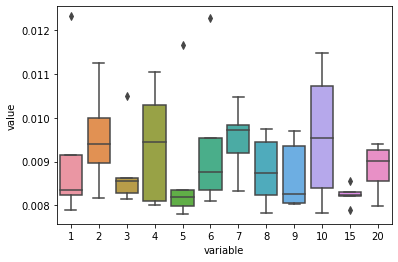

In [77]:
g = sns.boxplot(x='variable', y='value', data=df_melted) #3 

In [79]:
#epoch_number
dic = {}
for i in [50,100,250,500,1000]:
    dic[i] = exp(6,5,64,i,5)
df_1 = pd.DataFrame(dic)
df_melted = pd.melt(df_1)

Model: "sequential_194"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_194 (LSTM)             (None, 64)                16896     
                                                                 
 dense_194 (Dense)           (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 2s - loss: 1.8861 - 2s/epoch - 318ms/step
Epoch 2/50
5/5 - 0s - loss: 1.0239 - 31ms/epoch - 6ms/step
Epoch 3/50
5/5 - 0s - loss: 0.3374 - 30ms/epoch - 6ms/step
Epoch 4/50
5/5 - 0s - loss: 0.0220 - 31ms/epoch - 6ms/step
Epoch 5/50
5/5 - 0s - loss: 0.1125 - 30ms/epoch - 6ms/step
Epoch 6/50
5/5 - 0s - loss: 0.0613 - 31ms/epoch - 6ms/step
Epoch 7/50
5/5 - 0s - loss: 0.0045 - 30ms/epoch - 6ms/step
Epoch 8/50
5/5 - 0s - loss: 0.0

                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 1s - loss: 2.4457 - 1s/epoch - 279ms/step
Epoch 2/50
5/5 - 0s - loss: 1.3642 - 26ms/epoch - 5ms/step
Epoch 3/50
5/5 - 0s - loss: 0.5676 - 27ms/epoch - 5ms/step
Epoch 4/50
5/5 - 0s - loss: 0.0919 - 24ms/epoch - 5ms/step
Epoch 5/50
5/5 - 0s - loss: 0.0466 - 25ms/epoch - 5ms/step
Epoch 6/50
5/5 - 0s - loss: 0.1085 - 24ms/epoch - 5ms/step
Epoch 7/50
5/5 - 0s - loss: 0.0283 - 25ms/epoch - 5ms/step
Epoch 8/50
5/5 - 0s - loss: 0.0055 - 25ms/epoch - 5ms/step
Epoch 9/50
5/5 - 0s - loss: 0.0183 - 24ms/epoch - 5ms/step
Epoch 10/50
5/5 - 0s - loss: 0.0148 - 26ms/epoch - 5ms/step
Epoch 11/50
5/5 - 0s - loss: 0.0043 - 25ms/epoch - 5ms/step
Epoch 12/50
5/5 - 0s - loss: 0.0030 - 25ms/epoch - 5ms/step
Epoch 13/50
5/5 - 0s - loss: 0.0049 - 25ms/epoch - 5ms/step
Epoch 14/50
5/5 - 0s - loss

5/5 - 0s - loss: 0.0217 - 27ms/epoch - 5ms/step
Epoch 5/50
5/5 - 0s - loss: 0.1209 - 25ms/epoch - 5ms/step
Epoch 6/50
5/5 - 0s - loss: 0.0427 - 21ms/epoch - 4ms/step
Epoch 7/50
5/5 - 0s - loss: 0.0043 - 25ms/epoch - 5ms/step
Epoch 8/50
5/5 - 0s - loss: 0.0200 - 24ms/epoch - 5ms/step
Epoch 9/50
5/5 - 0s - loss: 0.0168 - 25ms/epoch - 5ms/step
Epoch 10/50
5/5 - 0s - loss: 0.0037 - 24ms/epoch - 5ms/step
Epoch 11/50
5/5 - 0s - loss: 0.0027 - 24ms/epoch - 5ms/step
Epoch 12/50
5/5 - 0s - loss: 0.0047 - 22ms/epoch - 4ms/step
Epoch 13/50
5/5 - 0s - loss: 0.0022 - 24ms/epoch - 5ms/step
Epoch 14/50
5/5 - 0s - loss: 0.0014 - 24ms/epoch - 5ms/step
Epoch 15/50
5/5 - 0s - loss: 0.0020 - 24ms/epoch - 5ms/step
Epoch 16/50
5/5 - 0s - loss: 0.0015 - 23ms/epoch - 5ms/step
Epoch 17/50
5/5 - 0s - loss: 0.0013 - 22ms/epoch - 4ms/step
Epoch 18/50
5/5 - 0s - loss: 0.0014 - 21ms/epoch - 4ms/step
Epoch 19/50
5/5 - 0s - loss: 0.0013 - 22ms/epoch - 4ms/step
Epoch 20/50
5/5 - 0s - loss: 0.0012 - 22ms/epoch - 4ms/st

Epoch 72/100
5/5 - 0s - loss: 5.5074e-04 - 22ms/epoch - 4ms/step
Epoch 73/100
5/5 - 0s - loss: 5.1897e-04 - 21ms/epoch - 4ms/step
Epoch 74/100
5/5 - 0s - loss: 5.1885e-04 - 25ms/epoch - 5ms/step
Epoch 75/100
5/5 - 0s - loss: 5.0145e-04 - 21ms/epoch - 4ms/step
Epoch 76/100
5/5 - 0s - loss: 4.9016e-04 - 24ms/epoch - 5ms/step
Epoch 77/100
5/5 - 0s - loss: 4.8083e-04 - 21ms/epoch - 4ms/step
Epoch 78/100
5/5 - 0s - loss: 4.7354e-04 - 21ms/epoch - 4ms/step
Epoch 79/100
5/5 - 0s - loss: 4.6597e-04 - 22ms/epoch - 4ms/step
Epoch 80/100
5/5 - 0s - loss: 4.5295e-04 - 20ms/epoch - 4ms/step
Epoch 81/100
5/5 - 0s - loss: 4.4108e-04 - 19ms/epoch - 4ms/step
Epoch 82/100
5/5 - 0s - loss: 4.3020e-04 - 21ms/epoch - 4ms/step
Epoch 83/100
5/5 - 0s - loss: 4.3043e-04 - 22ms/epoch - 4ms/step
Epoch 84/100
5/5 - 0s - loss: 4.1699e-04 - 22ms/epoch - 4ms/step
Epoch 85/100
5/5 - 0s - loss: 4.1894e-04 - 20ms/epoch - 4ms/step
Epoch 86/100
5/5 - 0s - loss: 4.0291e-04 - 19ms/epoch - 4ms/step
Epoch 87/100
5/5 - 0s - l

Epoch 89/100
5/5 - 0s - loss: 4.9835e-04 - 25ms/epoch - 5ms/step
Epoch 90/100
5/5 - 0s - loss: 4.8696e-04 - 24ms/epoch - 5ms/step
Epoch 91/100
5/5 - 0s - loss: 4.7659e-04 - 24ms/epoch - 5ms/step
Epoch 92/100
5/5 - 0s - loss: 4.5829e-04 - 20ms/epoch - 4ms/step
Epoch 93/100
5/5 - 0s - loss: 4.6012e-04 - 21ms/epoch - 4ms/step
Epoch 94/100
5/5 - 0s - loss: 4.3619e-04 - 24ms/epoch - 5ms/step
Epoch 95/100
5/5 - 0s - loss: 4.3515e-04 - 22ms/epoch - 4ms/step
Epoch 96/100
5/5 - 0s - loss: 4.1532e-04 - 23ms/epoch - 5ms/step
Epoch 97/100
5/5 - 0s - loss: 4.0920e-04 - 22ms/epoch - 4ms/step
Epoch 98/100
5/5 - 0s - loss: 3.9708e-04 - 25ms/epoch - 5ms/step
Epoch 99/100
5/5 - 0s - loss: 3.9554e-04 - 23ms/epoch - 5ms/step
Epoch 100/100
5/5 - 0s - loss: 3.7949e-04 - 25ms/epoch - 5ms/step
5/5 - 0s - loss: 3.7330e-04 - 342ms/epoch - 68ms/step
Train Score: 0.0004 MSE (0.01932 RMSE)
1/1 [==============================] - 0s 18ms/step - loss: 1.7064e-04
Test Score: 0.0002 MSE (0.01306 RMSE)
Model: "sequentia

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_202 (LSTM)             (None, 64)                16896     
                                                                 
 dense_202 (Dense)           (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 - 2s - loss: 1.4978 - 2s/epoch - 322ms/step
Epoch 2/100
5/5 - 0s - loss: 0.6911 - 27ms/epoch - 5ms/step
Epoch 3/100
5/5 - 0s - loss: 0.1497 - 28ms/epoch - 6ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0315 - 26ms/epoch - 5ms/step
Epoch 5/100
5/5 - 0s - loss: 0.1008 - 25ms/epoch - 5ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0224 - 25ms/epoch - 5ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0074 - 24ms/epoch - 5ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0206 - 24ms/epoch

5/5 - 0s - loss: 0.0906 - 19ms/epoch - 4ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0108 - 17ms/epoch - 3ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0113 - 18ms/epoch - 4ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0213 - 17ms/epoch - 3ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0111 - 18ms/epoch - 4ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0027 - 17ms/epoch - 3ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0044 - 18ms/epoch - 4ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0045 - 17ms/epoch - 3ms/step
Epoch 14/100
5/5 - 0s - loss: 0.0022 - 19ms/epoch - 4ms/step
Epoch 15/100
5/5 - 0s - loss: 0.0024 - 17ms/epoch - 3ms/step
Epoch 16/100
5/5 - 0s - loss: 0.0026 - 18ms/epoch - 4ms/step
Epoch 17/100
5/5 - 0s - loss: 0.0020 - 17ms/epoch - 3ms/step
Epoch 18/100
5/5 - 0s - loss: 0.0019 - 17ms/epoch - 3ms/step
Epoch 19/100
5/5 - 0s - loss: 0.0019 - 17ms/epoch - 3ms/step
Epoch 20/100
5/5 - 0s - loss: 0.0018 - 19ms/epoch - 4ms/step
Epoch 21/100
5/5 - 0s - loss: 0.0018 - 19ms/epoch - 4ms/step
Epoch 22/100
5/5 - 0s - loss: 0.0017 - 1

Epoch 23/250
5/5 - 0s - loss: 0.0020 - 18ms/epoch - 4ms/step
Epoch 24/250
5/5 - 0s - loss: 0.0019 - 18ms/epoch - 4ms/step
Epoch 25/250
5/5 - 0s - loss: 0.0019 - 17ms/epoch - 3ms/step
Epoch 26/250
5/5 - 0s - loss: 0.0019 - 18ms/epoch - 4ms/step
Epoch 27/250
5/5 - 0s - loss: 0.0018 - 19ms/epoch - 4ms/step
Epoch 28/250
5/5 - 0s - loss: 0.0018 - 18ms/epoch - 4ms/step
Epoch 29/250
5/5 - 0s - loss: 0.0018 - 18ms/epoch - 4ms/step
Epoch 30/250
5/5 - 0s - loss: 0.0017 - 18ms/epoch - 4ms/step
Epoch 31/250
5/5 - 0s - loss: 0.0017 - 20ms/epoch - 4ms/step
Epoch 32/250
5/5 - 0s - loss: 0.0017 - 21ms/epoch - 4ms/step
Epoch 33/250
5/5 - 0s - loss: 0.0016 - 22ms/epoch - 4ms/step
Epoch 34/250
5/5 - 0s - loss: 0.0016 - 21ms/epoch - 4ms/step
Epoch 35/250
5/5 - 0s - loss: 0.0016 - 21ms/epoch - 4ms/step
Epoch 36/250
5/5 - 0s - loss: 0.0015 - 21ms/epoch - 4ms/step
Epoch 37/250
5/5 - 0s - loss: 0.0015 - 22ms/epoch - 4ms/step
Epoch 38/250
5/5 - 0s - loss: 0.0015 - 20ms/epoch - 4ms/step
Epoch 39/250
5/5 - 0s - 

Epoch 151/250
5/5 - 0s - loss: 3.0619e-04 - 18ms/epoch - 4ms/step
Epoch 152/250
5/5 - 0s - loss: 3.1264e-04 - 17ms/epoch - 3ms/step
Epoch 153/250
5/5 - 0s - loss: 3.0657e-04 - 18ms/epoch - 4ms/step
Epoch 154/250
5/5 - 0s - loss: 3.0612e-04 - 18ms/epoch - 4ms/step
Epoch 155/250
5/5 - 0s - loss: 3.0422e-04 - 17ms/epoch - 3ms/step
Epoch 156/250
5/5 - 0s - loss: 3.0437e-04 - 18ms/epoch - 4ms/step
Epoch 157/250
5/5 - 0s - loss: 3.1616e-04 - 18ms/epoch - 4ms/step
Epoch 158/250
5/5 - 0s - loss: 3.3023e-04 - 25ms/epoch - 5ms/step
Epoch 159/250
5/5 - 0s - loss: 3.1904e-04 - 20ms/epoch - 4ms/step
Epoch 160/250
5/5 - 0s - loss: 3.3706e-04 - 17ms/epoch - 3ms/step
Epoch 161/250
5/5 - 0s - loss: 3.1107e-04 - 20ms/epoch - 4ms/step
Epoch 162/250
5/5 - 0s - loss: 3.1271e-04 - 20ms/epoch - 4ms/step
Epoch 163/250
5/5 - 0s - loss: 3.0024e-04 - 20ms/epoch - 4ms/step
Epoch 164/250
5/5 - 0s - loss: 3.0424e-04 - 21ms/epoch - 4ms/step
Epoch 165/250
5/5 - 0s - loss: 2.9950e-04 - 20ms/epoch - 4ms/step
Epoch 166/

Epoch 13/250
5/5 - 0s - loss: 0.0048 - 21ms/epoch - 4ms/step
Epoch 14/250
5/5 - 0s - loss: 0.0028 - 19ms/epoch - 4ms/step
Epoch 15/250
5/5 - 0s - loss: 0.0021 - 18ms/epoch - 4ms/step
Epoch 16/250
5/5 - 0s - loss: 0.0025 - 18ms/epoch - 4ms/step
Epoch 17/250
5/5 - 0s - loss: 0.0021 - 17ms/epoch - 3ms/step
Epoch 18/250
5/5 - 0s - loss: 0.0018 - 18ms/epoch - 4ms/step
Epoch 19/250
5/5 - 0s - loss: 0.0020 - 18ms/epoch - 4ms/step
Epoch 20/250
5/5 - 0s - loss: 0.0018 - 17ms/epoch - 3ms/step
Epoch 21/250
5/5 - 0s - loss: 0.0017 - 18ms/epoch - 4ms/step
Epoch 22/250
5/5 - 0s - loss: 0.0018 - 17ms/epoch - 3ms/step
Epoch 23/250
5/5 - 0s - loss: 0.0017 - 17ms/epoch - 3ms/step
Epoch 24/250
5/5 - 0s - loss: 0.0017 - 17ms/epoch - 3ms/step
Epoch 25/250
5/5 - 0s - loss: 0.0017 - 17ms/epoch - 3ms/step
Epoch 26/250
5/5 - 0s - loss: 0.0016 - 18ms/epoch - 4ms/step
Epoch 27/250
5/5 - 0s - loss: 0.0016 - 19ms/epoch - 4ms/step
Epoch 28/250
5/5 - 0s - loss: 0.0016 - 17ms/epoch - 3ms/step
Epoch 29/250
5/5 - 0s - 

Epoch 141/250
5/5 - 0s - loss: 2.6050e-04 - 23ms/epoch - 5ms/step
Epoch 142/250
5/5 - 0s - loss: 2.6540e-04 - 23ms/epoch - 5ms/step
Epoch 143/250
5/5 - 0s - loss: 2.6342e-04 - 20ms/epoch - 4ms/step
Epoch 144/250
5/5 - 0s - loss: 2.5232e-04 - 22ms/epoch - 4ms/step
Epoch 145/250
5/5 - 0s - loss: 2.7299e-04 - 21ms/epoch - 4ms/step
Epoch 146/250
5/5 - 0s - loss: 2.6347e-04 - 22ms/epoch - 4ms/step
Epoch 147/250
5/5 - 0s - loss: 2.6549e-04 - 21ms/epoch - 4ms/step
Epoch 148/250
5/5 - 0s - loss: 2.5705e-04 - 20ms/epoch - 4ms/step
Epoch 149/250
5/5 - 0s - loss: 2.5287e-04 - 20ms/epoch - 4ms/step
Epoch 150/250
5/5 - 0s - loss: 2.5235e-04 - 22ms/epoch - 4ms/step
Epoch 151/250
5/5 - 0s - loss: 2.5604e-04 - 20ms/epoch - 4ms/step
Epoch 152/250
5/5 - 0s - loss: 2.6077e-04 - 22ms/epoch - 4ms/step
Epoch 153/250
5/5 - 0s - loss: 2.6125e-04 - 26ms/epoch - 5ms/step
Epoch 154/250
5/5 - 0s - loss: 2.6293e-04 - 22ms/epoch - 4ms/step
Epoch 155/250
5/5 - 0s - loss: 2.5028e-04 - 23ms/epoch - 5ms/step
Epoch 156/

Epoch 2/250
5/5 - 0s - loss: 1.5295 - 28ms/epoch - 6ms/step
Epoch 3/250
5/5 - 0s - loss: 0.6407 - 27ms/epoch - 5ms/step
Epoch 4/250
5/5 - 0s - loss: 0.1034 - 26ms/epoch - 5ms/step
Epoch 5/250
5/5 - 0s - loss: 0.0510 - 25ms/epoch - 5ms/step
Epoch 6/250
5/5 - 0s - loss: 0.1199 - 25ms/epoch - 5ms/step
Epoch 7/250
5/5 - 0s - loss: 0.0326 - 27ms/epoch - 5ms/step
Epoch 8/250
5/5 - 0s - loss: 0.0050 - 25ms/epoch - 5ms/step
Epoch 9/250
5/5 - 0s - loss: 0.0189 - 25ms/epoch - 5ms/step
Epoch 10/250
5/5 - 0s - loss: 0.0171 - 26ms/epoch - 5ms/step
Epoch 11/250
5/5 - 0s - loss: 0.0056 - 24ms/epoch - 5ms/step
Epoch 12/250
5/5 - 0s - loss: 0.0028 - 26ms/epoch - 5ms/step
Epoch 13/250
5/5 - 0s - loss: 0.0049 - 25ms/epoch - 5ms/step
Epoch 14/250
5/5 - 0s - loss: 0.0036 - 25ms/epoch - 5ms/step
Epoch 15/250
5/5 - 0s - loss: 0.0023 - 25ms/epoch - 5ms/step
Epoch 16/250
5/5 - 0s - loss: 0.0025 - 24ms/epoch - 5ms/step
Epoch 17/250
5/5 - 0s - loss: 0.0025 - 26ms/epoch - 5ms/step
Epoch 18/250
5/5 - 0s - loss: 0.

Epoch 131/250
5/5 - 0s - loss: 2.4509e-04 - 23ms/epoch - 5ms/step
Epoch 132/250
5/5 - 0s - loss: 2.4378e-04 - 21ms/epoch - 4ms/step
Epoch 133/250
5/5 - 0s - loss: 2.4311e-04 - 19ms/epoch - 4ms/step
Epoch 134/250
5/5 - 0s - loss: 2.4307e-04 - 20ms/epoch - 4ms/step
Epoch 135/250
5/5 - 0s - loss: 2.4166e-04 - 20ms/epoch - 4ms/step
Epoch 136/250
5/5 - 0s - loss: 2.4281e-04 - 20ms/epoch - 4ms/step
Epoch 137/250
5/5 - 0s - loss: 2.4402e-04 - 21ms/epoch - 4ms/step
Epoch 138/250
5/5 - 0s - loss: 2.4307e-04 - 21ms/epoch - 4ms/step
Epoch 139/250
5/5 - 0s - loss: 2.3970e-04 - 20ms/epoch - 4ms/step
Epoch 140/250
5/5 - 0s - loss: 2.3893e-04 - 21ms/epoch - 4ms/step
Epoch 141/250
5/5 - 0s - loss: 2.3854e-04 - 21ms/epoch - 4ms/step
Epoch 142/250
5/5 - 0s - loss: 2.3896e-04 - 22ms/epoch - 4ms/step
Epoch 143/250
5/5 - 0s - loss: 2.3867e-04 - 22ms/epoch - 4ms/step
Epoch 144/250
5/5 - 0s - loss: 2.3804e-04 - 22ms/epoch - 4ms/step
Epoch 145/250
5/5 - 0s - loss: 2.3898e-04 - 22ms/epoch - 4ms/step
Epoch 146/

 Layer (type)                Output Shape              Param #   
 lstm_207 (LSTM)             (None, 64)                16896     
                                                                 
 dense_207 (Dense)           (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
5/5 - 1s - loss: 1.6234 - 1s/epoch - 291ms/step
Epoch 2/250
5/5 - 0s - loss: 0.7403 - 27ms/epoch - 5ms/step
Epoch 3/250
5/5 - 0s - loss: 0.1370 - 25ms/epoch - 5ms/step
Epoch 4/250
5/5 - 0s - loss: 0.0550 - 24ms/epoch - 5ms/step
Epoch 5/250
5/5 - 0s - loss: 0.1158 - 22ms/epoch - 4ms/step
Epoch 6/250
5/5 - 0s - loss: 0.0187 - 21ms/epoch - 4ms/step
Epoch 7/250
5/5 - 0s - loss: 0.0123 - 24ms/epoch - 5ms/step
Epoch 8/250
5/5 - 0s - loss: 0.0253 - 23ms/epoch - 5ms/step
Epoch 9/250
5/5 - 0s - loss: 0.0127 - 30ms/epoch - 6ms

Epoch 121/250
5/5 - 0s - loss: 3.2259e-04 - 22ms/epoch - 4ms/step
Epoch 122/250
5/5 - 0s - loss: 3.2561e-04 - 18ms/epoch - 4ms/step
Epoch 123/250
5/5 - 0s - loss: 3.3310e-04 - 21ms/epoch - 4ms/step
Epoch 124/250
5/5 - 0s - loss: 3.1773e-04 - 21ms/epoch - 4ms/step
Epoch 125/250
5/5 - 0s - loss: 3.2446e-04 - 22ms/epoch - 4ms/step
Epoch 126/250
5/5 - 0s - loss: 3.1979e-04 - 22ms/epoch - 4ms/step
Epoch 127/250
5/5 - 0s - loss: 3.1422e-04 - 20ms/epoch - 4ms/step
Epoch 128/250
5/5 - 0s - loss: 3.1092e-04 - 17ms/epoch - 3ms/step
Epoch 129/250
5/5 - 0s - loss: 3.1444e-04 - 22ms/epoch - 4ms/step
Epoch 130/250
5/5 - 0s - loss: 3.1303e-04 - 21ms/epoch - 4ms/step
Epoch 131/250
5/5 - 0s - loss: 3.1199e-04 - 19ms/epoch - 4ms/step
Epoch 132/250
5/5 - 0s - loss: 3.2850e-04 - 22ms/epoch - 4ms/step
Epoch 133/250
5/5 - 0s - loss: 3.2615e-04 - 21ms/epoch - 4ms/step
Epoch 134/250
5/5 - 0s - loss: 3.1232e-04 - 23ms/epoch - 5ms/step
Epoch 135/250
5/5 - 0s - loss: 3.0802e-04 - 24ms/epoch - 5ms/step
Epoch 136/

5/5 - 0s - loss: 2.4369e-04 - 24ms/epoch - 5ms/step
Epoch 246/250
5/5 - 0s - loss: 2.5180e-04 - 24ms/epoch - 5ms/step
Epoch 247/250
5/5 - 0s - loss: 2.4863e-04 - 22ms/epoch - 4ms/step
Epoch 248/250
5/5 - 0s - loss: 2.5101e-04 - 22ms/epoch - 4ms/step
Epoch 249/250
5/5 - 0s - loss: 2.4923e-04 - 18ms/epoch - 4ms/step
Epoch 250/250
5/5 - 0s - loss: 2.5007e-04 - 21ms/epoch - 4ms/step
5/5 - 0s - loss: 2.4128e-04 - 462ms/epoch - 92ms/step
Train Score: 0.0002 MSE (0.01553 RMSE)
1/1 [==============================] - 0s 19ms/step - loss: 1.8542e-04
Test Score: 0.0002 MSE (0.01362 RMSE)
Model: "sequential_208"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_208 (LSTM)             (None, 64)                16896     
                                                                 
 dense_208 (Dense)           (None, 1)                 65        
                                                              

Epoch 111/250
5/5 - 0s - loss: 2.4914e-04 - 22ms/epoch - 4ms/step
Epoch 112/250
5/5 - 0s - loss: 2.5704e-04 - 21ms/epoch - 4ms/step
Epoch 113/250
5/5 - 0s - loss: 2.6404e-04 - 22ms/epoch - 4ms/step
Epoch 114/250
5/5 - 0s - loss: 2.5298e-04 - 23ms/epoch - 5ms/step
Epoch 115/250
5/5 - 0s - loss: 2.5699e-04 - 20ms/epoch - 4ms/step
Epoch 116/250
5/5 - 0s - loss: 2.5001e-04 - 22ms/epoch - 4ms/step
Epoch 117/250
5/5 - 0s - loss: 2.4585e-04 - 22ms/epoch - 4ms/step
Epoch 118/250
5/5 - 0s - loss: 2.5173e-04 - 22ms/epoch - 4ms/step
Epoch 119/250
5/5 - 0s - loss: 2.4879e-04 - 23ms/epoch - 5ms/step
Epoch 120/250
5/5 - 0s - loss: 2.4330e-04 - 22ms/epoch - 4ms/step
Epoch 121/250
5/5 - 0s - loss: 2.4149e-04 - 22ms/epoch - 4ms/step
Epoch 122/250
5/5 - 0s - loss: 2.4387e-04 - 22ms/epoch - 4ms/step
Epoch 123/250
5/5 - 0s - loss: 2.4083e-04 - 21ms/epoch - 4ms/step
Epoch 124/250
5/5 - 0s - loss: 2.4927e-04 - 22ms/epoch - 4ms/step
Epoch 125/250
5/5 - 0s - loss: 2.4227e-04 - 21ms/epoch - 4ms/step
Epoch 126/

5/5 - 0s - loss: 2.1809e-04 - 24ms/epoch - 5ms/step
Epoch 236/250
5/5 - 0s - loss: 2.3315e-04 - 23ms/epoch - 5ms/step
Epoch 237/250
5/5 - 0s - loss: 2.2615e-04 - 23ms/epoch - 5ms/step
Epoch 238/250
5/5 - 0s - loss: 2.2823e-04 - 23ms/epoch - 5ms/step
Epoch 239/250
5/5 - 0s - loss: 2.3057e-04 - 24ms/epoch - 5ms/step
Epoch 240/250
5/5 - 0s - loss: 2.2662e-04 - 22ms/epoch - 4ms/step
Epoch 241/250
5/5 - 0s - loss: 2.3274e-04 - 23ms/epoch - 5ms/step
Epoch 242/250
5/5 - 0s - loss: 2.4833e-04 - 22ms/epoch - 4ms/step
Epoch 243/250
5/5 - 0s - loss: 2.5837e-04 - 23ms/epoch - 5ms/step
Epoch 244/250
5/5 - 0s - loss: 2.3011e-04 - 22ms/epoch - 4ms/step
Epoch 245/250
5/5 - 0s - loss: 2.2710e-04 - 24ms/epoch - 5ms/step
Epoch 246/250
5/5 - 0s - loss: 2.2616e-04 - 23ms/epoch - 5ms/step
Epoch 247/250
5/5 - 0s - loss: 2.3075e-04 - 22ms/epoch - 4ms/step
Epoch 248/250
5/5 - 0s - loss: 2.2308e-04 - 23ms/epoch - 5ms/step
Epoch 249/250
5/5 - 0s - loss: 2.2182e-04 - 22ms/epoch - 4ms/step
Epoch 250/250
5/5 - 0s -

Epoch 101/500
5/5 - 0s - loss: 3.2008e-04 - 26ms/epoch - 5ms/step
Epoch 102/500
5/5 - 0s - loss: 3.1586e-04 - 19ms/epoch - 4ms/step
Epoch 103/500
5/5 - 0s - loss: 3.1101e-04 - 23ms/epoch - 5ms/step
Epoch 104/500
5/5 - 0s - loss: 3.0725e-04 - 20ms/epoch - 4ms/step
Epoch 105/500
5/5 - 0s - loss: 3.0186e-04 - 22ms/epoch - 4ms/step
Epoch 106/500
5/5 - 0s - loss: 3.0596e-04 - 24ms/epoch - 5ms/step
Epoch 107/500
5/5 - 0s - loss: 2.9476e-04 - 24ms/epoch - 5ms/step
Epoch 108/500
5/5 - 0s - loss: 2.9219e-04 - 19ms/epoch - 4ms/step
Epoch 109/500
5/5 - 0s - loss: 2.9341e-04 - 20ms/epoch - 4ms/step
Epoch 110/500
5/5 - 0s - loss: 2.7954e-04 - 26ms/epoch - 5ms/step
Epoch 111/500
5/5 - 0s - loss: 2.8530e-04 - 27ms/epoch - 5ms/step
Epoch 112/500
5/5 - 0s - loss: 2.8338e-04 - 21ms/epoch - 4ms/step
Epoch 113/500
5/5 - 0s - loss: 2.7350e-04 - 25ms/epoch - 5ms/step
Epoch 114/500
5/5 - 0s - loss: 2.7313e-04 - 20ms/epoch - 4ms/step
Epoch 115/500
5/5 - 0s - loss: 2.6763e-04 - 23ms/epoch - 5ms/step
Epoch 116/

5/5 - 0s - loss: 2.3321e-04 - 23ms/epoch - 5ms/step
Epoch 226/500
5/5 - 0s - loss: 2.2635e-04 - 18ms/epoch - 4ms/step
Epoch 227/500
5/5 - 0s - loss: 2.3382e-04 - 21ms/epoch - 4ms/step
Epoch 228/500
5/5 - 0s - loss: 2.2645e-04 - 21ms/epoch - 4ms/step
Epoch 229/500
5/5 - 0s - loss: 2.3734e-04 - 17ms/epoch - 3ms/step
Epoch 230/500
5/5 - 0s - loss: 2.2773e-04 - 22ms/epoch - 4ms/step
Epoch 231/500
5/5 - 0s - loss: 2.2888e-04 - 21ms/epoch - 4ms/step
Epoch 232/500
5/5 - 0s - loss: 2.2989e-04 - 19ms/epoch - 4ms/step
Epoch 233/500
5/5 - 0s - loss: 2.3281e-04 - 22ms/epoch - 4ms/step
Epoch 234/500
5/5 - 0s - loss: 2.5460e-04 - 21ms/epoch - 4ms/step
Epoch 235/500
5/5 - 0s - loss: 2.6248e-04 - 19ms/epoch - 4ms/step
Epoch 236/500
5/5 - 0s - loss: 2.5445e-04 - 22ms/epoch - 4ms/step
Epoch 237/500
5/5 - 0s - loss: 2.3272e-04 - 21ms/epoch - 4ms/step
Epoch 238/500
5/5 - 0s - loss: 2.4263e-04 - 22ms/epoch - 4ms/step
Epoch 239/500
5/5 - 0s - loss: 2.4278e-04 - 22ms/epoch - 4ms/step
Epoch 240/500
5/5 - 0s -

Epoch 350/500
5/5 - 0s - loss: 2.3601e-04 - 20ms/epoch - 4ms/step
Epoch 351/500
5/5 - 0s - loss: 2.2446e-04 - 25ms/epoch - 5ms/step
Epoch 352/500
5/5 - 0s - loss: 2.2805e-04 - 22ms/epoch - 4ms/step
Epoch 353/500
5/5 - 0s - loss: 2.2236e-04 - 24ms/epoch - 5ms/step
Epoch 354/500
5/5 - 0s - loss: 2.2563e-04 - 21ms/epoch - 4ms/step
Epoch 355/500
5/5 - 0s - loss: 2.2345e-04 - 23ms/epoch - 5ms/step
Epoch 356/500
5/5 - 0s - loss: 2.3278e-04 - 22ms/epoch - 4ms/step
Epoch 357/500
5/5 - 0s - loss: 2.3901e-04 - 22ms/epoch - 4ms/step
Epoch 358/500
5/5 - 0s - loss: 2.2805e-04 - 22ms/epoch - 4ms/step
Epoch 359/500
5/5 - 0s - loss: 2.2742e-04 - 21ms/epoch - 4ms/step
Epoch 360/500
5/5 - 0s - loss: 2.4007e-04 - 25ms/epoch - 5ms/step
Epoch 361/500
5/5 - 0s - loss: 2.2734e-04 - 21ms/epoch - 4ms/step
Epoch 362/500
5/5 - 0s - loss: 2.2273e-04 - 23ms/epoch - 5ms/step
Epoch 363/500
5/5 - 0s - loss: 2.3531e-04 - 21ms/epoch - 4ms/step
Epoch 364/500
5/5 - 0s - loss: 2.2919e-04 - 23ms/epoch - 5ms/step
Epoch 365/

5/5 - 0s - loss: 2.2766e-04 - 19ms/epoch - 4ms/step
Epoch 475/500
5/5 - 0s - loss: 2.2356e-04 - 25ms/epoch - 5ms/step
Epoch 476/500
5/5 - 0s - loss: 2.2796e-04 - 25ms/epoch - 5ms/step
Epoch 477/500
5/5 - 0s - loss: 2.4045e-04 - 25ms/epoch - 5ms/step
Epoch 478/500
5/5 - 0s - loss: 2.3910e-04 - 21ms/epoch - 4ms/step
Epoch 479/500
5/5 - 0s - loss: 2.3287e-04 - 23ms/epoch - 5ms/step
Epoch 480/500
5/5 - 0s - loss: 2.4932e-04 - 27ms/epoch - 5ms/step
Epoch 481/500
5/5 - 0s - loss: 2.4197e-04 - 23ms/epoch - 5ms/step
Epoch 482/500
5/5 - 0s - loss: 2.3088e-04 - 21ms/epoch - 4ms/step
Epoch 483/500
5/5 - 0s - loss: 2.2522e-04 - 21ms/epoch - 4ms/step
Epoch 484/500
5/5 - 0s - loss: 2.2233e-04 - 23ms/epoch - 5ms/step
Epoch 485/500
5/5 - 0s - loss: 2.3731e-04 - 19ms/epoch - 4ms/step
Epoch 486/500
5/5 - 0s - loss: 2.2709e-04 - 22ms/epoch - 4ms/step
Epoch 487/500
5/5 - 0s - loss: 2.2461e-04 - 20ms/epoch - 4ms/step
Epoch 488/500
5/5 - 0s - loss: 2.4004e-04 - 24ms/epoch - 5ms/step
Epoch 489/500
5/5 - 0s -

Epoch 90/500
5/5 - 0s - loss: 3.8834e-04 - 22ms/epoch - 4ms/step
Epoch 91/500
5/5 - 0s - loss: 3.8147e-04 - 22ms/epoch - 4ms/step
Epoch 92/500
5/5 - 0s - loss: 3.8247e-04 - 19ms/epoch - 4ms/step
Epoch 93/500
5/5 - 0s - loss: 3.7918e-04 - 21ms/epoch - 4ms/step
Epoch 94/500
5/5 - 0s - loss: 3.6165e-04 - 21ms/epoch - 4ms/step
Epoch 95/500
5/5 - 0s - loss: 3.6441e-04 - 20ms/epoch - 4ms/step
Epoch 96/500
5/5 - 0s - loss: 3.4892e-04 - 22ms/epoch - 4ms/step
Epoch 97/500
5/5 - 0s - loss: 3.5291e-04 - 23ms/epoch - 5ms/step
Epoch 98/500
5/5 - 0s - loss: 3.4355e-04 - 18ms/epoch - 4ms/step
Epoch 99/500
5/5 - 0s - loss: 3.4101e-04 - 22ms/epoch - 4ms/step
Epoch 100/500
5/5 - 0s - loss: 3.3186e-04 - 20ms/epoch - 4ms/step
Epoch 101/500
5/5 - 0s - loss: 3.2863e-04 - 19ms/epoch - 4ms/step
Epoch 102/500
5/5 - 0s - loss: 3.2529e-04 - 21ms/epoch - 4ms/step
Epoch 103/500
5/5 - 0s - loss: 3.2821e-04 - 21ms/epoch - 4ms/step
Epoch 104/500
5/5 - 0s - loss: 3.3075e-04 - 22ms/epoch - 4ms/step
Epoch 105/500
5/5 - 

Epoch 215/500
5/5 - 0s - loss: 2.4151e-04 - 23ms/epoch - 5ms/step
Epoch 216/500
5/5 - 0s - loss: 2.4028e-04 - 21ms/epoch - 4ms/step
Epoch 217/500
5/5 - 0s - loss: 2.4187e-04 - 21ms/epoch - 4ms/step
Epoch 218/500
5/5 - 0s - loss: 2.4147e-04 - 18ms/epoch - 4ms/step
Epoch 219/500
5/5 - 0s - loss: 2.4195e-04 - 21ms/epoch - 4ms/step
Epoch 220/500
5/5 - 0s - loss: 2.5151e-04 - 22ms/epoch - 4ms/step
Epoch 221/500
5/5 - 0s - loss: 2.3921e-04 - 22ms/epoch - 4ms/step
Epoch 222/500
5/5 - 0s - loss: 2.4020e-04 - 19ms/epoch - 4ms/step
Epoch 223/500
5/5 - 0s - loss: 2.3938e-04 - 22ms/epoch - 4ms/step
Epoch 224/500
5/5 - 0s - loss: 2.3905e-04 - 21ms/epoch - 4ms/step
Epoch 225/500
5/5 - 0s - loss: 2.5476e-04 - 18ms/epoch - 4ms/step
Epoch 226/500
5/5 - 0s - loss: 2.4429e-04 - 22ms/epoch - 4ms/step
Epoch 227/500
5/5 - 0s - loss: 2.4268e-04 - 23ms/epoch - 5ms/step
Epoch 228/500
5/5 - 0s - loss: 2.4115e-04 - 17ms/epoch - 3ms/step
Epoch 229/500
5/5 - 0s - loss: 2.3814e-04 - 23ms/epoch - 5ms/step
Epoch 230/

5/5 - 0s - loss: 2.3223e-04 - 25ms/epoch - 5ms/step
Epoch 340/500
5/5 - 0s - loss: 2.3318e-04 - 22ms/epoch - 4ms/step
Epoch 341/500
5/5 - 0s - loss: 2.3148e-04 - 20ms/epoch - 4ms/step
Epoch 342/500
5/5 - 0s - loss: 2.3302e-04 - 22ms/epoch - 4ms/step
Epoch 343/500
5/5 - 0s - loss: 2.3096e-04 - 19ms/epoch - 4ms/step
Epoch 344/500
5/5 - 0s - loss: 2.3195e-04 - 22ms/epoch - 4ms/step
Epoch 345/500
5/5 - 0s - loss: 2.3552e-04 - 19ms/epoch - 4ms/step
Epoch 346/500
5/5 - 0s - loss: 2.4083e-04 - 20ms/epoch - 4ms/step
Epoch 347/500
5/5 - 0s - loss: 2.6537e-04 - 22ms/epoch - 4ms/step
Epoch 348/500
5/5 - 0s - loss: 2.3487e-04 - 21ms/epoch - 4ms/step
Epoch 349/500
5/5 - 0s - loss: 2.2864e-04 - 20ms/epoch - 4ms/step
Epoch 350/500
5/5 - 0s - loss: 2.5101e-04 - 20ms/epoch - 4ms/step
Epoch 351/500
5/5 - 0s - loss: 2.5397e-04 - 20ms/epoch - 4ms/step
Epoch 352/500
5/5 - 0s - loss: 2.7731e-04 - 21ms/epoch - 4ms/step
Epoch 353/500
5/5 - 0s - loss: 3.0181e-04 - 20ms/epoch - 4ms/step
Epoch 354/500
5/5 - 0s -

Epoch 464/500
5/5 - 0s - loss: 2.2484e-04 - 24ms/epoch - 5ms/step
Epoch 465/500
5/5 - 0s - loss: 2.3035e-04 - 25ms/epoch - 5ms/step
Epoch 466/500
5/5 - 0s - loss: 2.3932e-04 - 23ms/epoch - 5ms/step
Epoch 467/500
5/5 - 0s - loss: 2.3635e-04 - 24ms/epoch - 5ms/step
Epoch 468/500
5/5 - 0s - loss: 2.4103e-04 - 23ms/epoch - 5ms/step
Epoch 469/500
5/5 - 0s - loss: 2.3130e-04 - 24ms/epoch - 5ms/step
Epoch 470/500
5/5 - 0s - loss: 2.3766e-04 - 24ms/epoch - 5ms/step
Epoch 471/500
5/5 - 0s - loss: 2.3289e-04 - 25ms/epoch - 5ms/step
Epoch 472/500
5/5 - 0s - loss: 2.2607e-04 - 24ms/epoch - 5ms/step
Epoch 473/500
5/5 - 0s - loss: 2.2503e-04 - 24ms/epoch - 5ms/step
Epoch 474/500
5/5 - 0s - loss: 2.3174e-04 - 25ms/epoch - 5ms/step
Epoch 475/500
5/5 - 0s - loss: 2.3735e-04 - 24ms/epoch - 5ms/step
Epoch 476/500
5/5 - 0s - loss: 2.5694e-04 - 24ms/epoch - 5ms/step
Epoch 477/500
5/5 - 0s - loss: 2.6582e-04 - 23ms/epoch - 5ms/step
Epoch 478/500
5/5 - 0s - loss: 2.7949e-04 - 24ms/epoch - 5ms/step
Epoch 479/

Epoch 79/500
5/5 - 0s - loss: 5.0749e-04 - 25ms/epoch - 5ms/step
Epoch 80/500
5/5 - 0s - loss: 5.0212e-04 - 25ms/epoch - 5ms/step
Epoch 81/500
5/5 - 0s - loss: 4.9701e-04 - 24ms/epoch - 5ms/step
Epoch 82/500
5/5 - 0s - loss: 4.8647e-04 - 27ms/epoch - 5ms/step
Epoch 83/500
5/5 - 0s - loss: 4.7912e-04 - 27ms/epoch - 5ms/step
Epoch 84/500
5/5 - 0s - loss: 4.7276e-04 - 28ms/epoch - 6ms/step
Epoch 85/500
5/5 - 0s - loss: 4.6481e-04 - 28ms/epoch - 6ms/step
Epoch 86/500
5/5 - 0s - loss: 4.6276e-04 - 25ms/epoch - 5ms/step
Epoch 87/500
5/5 - 0s - loss: 4.7431e-04 - 25ms/epoch - 5ms/step
Epoch 88/500
5/5 - 0s - loss: 4.4984e-04 - 29ms/epoch - 6ms/step
Epoch 89/500
5/5 - 0s - loss: 4.5504e-04 - 27ms/epoch - 5ms/step
Epoch 90/500
5/5 - 0s - loss: 4.3572e-04 - 25ms/epoch - 5ms/step
Epoch 91/500
5/5 - 0s - loss: 4.3161e-04 - 28ms/epoch - 6ms/step
Epoch 92/500
5/5 - 0s - loss: 4.2674e-04 - 28ms/epoch - 6ms/step
Epoch 93/500
5/5 - 0s - loss: 4.2069e-04 - 27ms/epoch - 5ms/step
Epoch 94/500
5/5 - 0s - l

Epoch 204/500
5/5 - 0s - loss: 2.5938e-04 - 28ms/epoch - 6ms/step
Epoch 205/500
5/5 - 0s - loss: 2.6976e-04 - 27ms/epoch - 5ms/step
Epoch 206/500
5/5 - 0s - loss: 2.7871e-04 - 25ms/epoch - 5ms/step
Epoch 207/500
5/5 - 0s - loss: 2.6155e-04 - 25ms/epoch - 5ms/step
Epoch 208/500
5/5 - 0s - loss: 2.6211e-04 - 24ms/epoch - 5ms/step
Epoch 209/500
5/5 - 0s - loss: 2.6523e-04 - 25ms/epoch - 5ms/step
Epoch 210/500
5/5 - 0s - loss: 2.5968e-04 - 23ms/epoch - 5ms/step
Epoch 211/500
5/5 - 0s - loss: 2.6093e-04 - 24ms/epoch - 5ms/step
Epoch 212/500
5/5 - 0s - loss: 2.5853e-04 - 24ms/epoch - 5ms/step
Epoch 213/500
5/5 - 0s - loss: 2.6065e-04 - 40ms/epoch - 8ms/step
Epoch 214/500
5/5 - 0s - loss: 2.5505e-04 - 26ms/epoch - 5ms/step
Epoch 215/500
5/5 - 0s - loss: 2.5943e-04 - 26ms/epoch - 5ms/step
Epoch 216/500
5/5 - 0s - loss: 2.5794e-04 - 27ms/epoch - 5ms/step
Epoch 217/500
5/5 - 0s - loss: 2.5556e-04 - 27ms/epoch - 5ms/step
Epoch 218/500
5/5 - 0s - loss: 2.5720e-04 - 24ms/epoch - 5ms/step
Epoch 219/

5/5 - 0s - loss: 2.2637e-04 - 19ms/epoch - 4ms/step
Epoch 329/500
5/5 - 0s - loss: 2.2964e-04 - 22ms/epoch - 4ms/step
Epoch 330/500
5/5 - 0s - loss: 2.3220e-04 - 22ms/epoch - 4ms/step
Epoch 331/500
5/5 - 0s - loss: 2.2859e-04 - 18ms/epoch - 4ms/step
Epoch 332/500
5/5 - 0s - loss: 2.4050e-04 - 23ms/epoch - 5ms/step
Epoch 333/500
5/5 - 0s - loss: 2.3645e-04 - 24ms/epoch - 5ms/step
Epoch 334/500
5/5 - 0s - loss: 2.3982e-04 - 23ms/epoch - 5ms/step
Epoch 335/500
5/5 - 0s - loss: 2.5241e-04 - 26ms/epoch - 5ms/step
Epoch 336/500
5/5 - 0s - loss: 2.5016e-04 - 26ms/epoch - 5ms/step
Epoch 337/500
5/5 - 0s - loss: 2.3993e-04 - 24ms/epoch - 5ms/step
Epoch 338/500
5/5 - 0s - loss: 2.2966e-04 - 28ms/epoch - 6ms/step
Epoch 339/500
5/5 - 0s - loss: 2.2448e-04 - 28ms/epoch - 6ms/step
Epoch 340/500
5/5 - 0s - loss: 2.2996e-04 - 26ms/epoch - 5ms/step
Epoch 341/500
5/5 - 0s - loss: 2.3583e-04 - 25ms/epoch - 5ms/step
Epoch 342/500
5/5 - 0s - loss: 2.7885e-04 - 24ms/epoch - 5ms/step
Epoch 343/500
5/5 - 0s -

Epoch 453/500
5/5 - 0s - loss: 2.2085e-04 - 23ms/epoch - 5ms/step
Epoch 454/500
5/5 - 0s - loss: 2.3041e-04 - 27ms/epoch - 5ms/step
Epoch 455/500
5/5 - 0s - loss: 2.2461e-04 - 26ms/epoch - 5ms/step
Epoch 456/500
5/5 - 0s - loss: 2.2926e-04 - 22ms/epoch - 4ms/step
Epoch 457/500
5/5 - 0s - loss: 2.2451e-04 - 25ms/epoch - 5ms/step
Epoch 458/500
5/5 - 0s - loss: 2.2563e-04 - 22ms/epoch - 4ms/step
Epoch 459/500
5/5 - 0s - loss: 2.2747e-04 - 24ms/epoch - 5ms/step
Epoch 460/500
5/5 - 0s - loss: 2.2666e-04 - 22ms/epoch - 4ms/step
Epoch 461/500
5/5 - 0s - loss: 2.2831e-04 - 25ms/epoch - 5ms/step
Epoch 462/500
5/5 - 0s - loss: 2.2110e-04 - 22ms/epoch - 4ms/step
Epoch 463/500
5/5 - 0s - loss: 2.2452e-04 - 25ms/epoch - 5ms/step
Epoch 464/500
5/5 - 0s - loss: 2.4932e-04 - 22ms/epoch - 4ms/step
Epoch 465/500
5/5 - 0s - loss: 2.2164e-04 - 25ms/epoch - 5ms/step
Epoch 466/500
5/5 - 0s - loss: 2.2517e-04 - 22ms/epoch - 4ms/step
Epoch 467/500
5/5 - 0s - loss: 2.3619e-04 - 25ms/epoch - 5ms/step
Epoch 468/

5/5 - 0s - loss: 6.6634e-04 - 21ms/epoch - 4ms/step
Epoch 69/500
5/5 - 0s - loss: 6.4484e-04 - 22ms/epoch - 4ms/step
Epoch 70/500
5/5 - 0s - loss: 6.2864e-04 - 17ms/epoch - 3ms/step
Epoch 71/500
5/5 - 0s - loss: 6.0613e-04 - 21ms/epoch - 4ms/step
Epoch 72/500
5/5 - 0s - loss: 5.9063e-04 - 20ms/epoch - 4ms/step
Epoch 73/500
5/5 - 0s - loss: 5.7106e-04 - 22ms/epoch - 4ms/step
Epoch 74/500
5/5 - 0s - loss: 5.5409e-04 - 19ms/epoch - 4ms/step
Epoch 75/500
5/5 - 0s - loss: 5.3829e-04 - 21ms/epoch - 4ms/step
Epoch 76/500
5/5 - 0s - loss: 5.2531e-04 - 21ms/epoch - 4ms/step
Epoch 77/500
5/5 - 0s - loss: 5.0726e-04 - 17ms/epoch - 3ms/step
Epoch 78/500
5/5 - 0s - loss: 4.9763e-04 - 21ms/epoch - 4ms/step
Epoch 79/500
5/5 - 0s - loss: 5.0581e-04 - 20ms/epoch - 4ms/step
Epoch 80/500
5/5 - 0s - loss: 4.6231e-04 - 19ms/epoch - 4ms/step
Epoch 81/500
5/5 - 0s - loss: 4.6602e-04 - 21ms/epoch - 4ms/step
Epoch 82/500
5/5 - 0s - loss: 4.4279e-04 - 21ms/epoch - 4ms/step
Epoch 83/500
5/5 - 0s - loss: 4.3746e-

Epoch 193/500
5/5 - 0s - loss: 2.3679e-04 - 21ms/epoch - 4ms/step
Epoch 194/500
5/5 - 0s - loss: 2.3778e-04 - 25ms/epoch - 5ms/step
Epoch 195/500
5/5 - 0s - loss: 2.3424e-04 - 22ms/epoch - 4ms/step
Epoch 196/500
5/5 - 0s - loss: 2.6184e-04 - 24ms/epoch - 5ms/step
Epoch 197/500
5/5 - 0s - loss: 2.4439e-04 - 21ms/epoch - 4ms/step
Epoch 198/500
5/5 - 0s - loss: 2.2583e-04 - 24ms/epoch - 5ms/step
Epoch 199/500
5/5 - 0s - loss: 2.4787e-04 - 21ms/epoch - 4ms/step
Epoch 200/500
5/5 - 0s - loss: 2.3558e-04 - 24ms/epoch - 5ms/step
Epoch 201/500
5/5 - 0s - loss: 2.3167e-04 - 22ms/epoch - 4ms/step
Epoch 202/500
5/5 - 0s - loss: 2.3497e-04 - 24ms/epoch - 5ms/step
Epoch 203/500
5/5 - 0s - loss: 2.3088e-04 - 23ms/epoch - 5ms/step
Epoch 204/500
5/5 - 0s - loss: 2.3267e-04 - 25ms/epoch - 5ms/step
Epoch 205/500
5/5 - 0s - loss: 2.3494e-04 - 23ms/epoch - 5ms/step
Epoch 206/500
5/5 - 0s - loss: 2.2966e-04 - 24ms/epoch - 5ms/step
Epoch 207/500
5/5 - 0s - loss: 2.3645e-04 - 21ms/epoch - 4ms/step
Epoch 208/

5/5 - 0s - loss: 2.3451e-04 - 22ms/epoch - 4ms/step
Epoch 318/500
5/5 - 0s - loss: 2.3246e-04 - 26ms/epoch - 5ms/step
Epoch 319/500
5/5 - 0s - loss: 2.3492e-04 - 22ms/epoch - 4ms/step
Epoch 320/500
5/5 - 0s - loss: 2.2849e-04 - 25ms/epoch - 5ms/step
Epoch 321/500
5/5 - 0s - loss: 2.3321e-04 - 24ms/epoch - 5ms/step
Epoch 322/500
5/5 - 0s - loss: 2.3029e-04 - 24ms/epoch - 5ms/step
Epoch 323/500
5/5 - 0s - loss: 2.3771e-04 - 22ms/epoch - 4ms/step
Epoch 324/500
5/5 - 0s - loss: 2.3308e-04 - 24ms/epoch - 5ms/step
Epoch 325/500
5/5 - 0s - loss: 2.3059e-04 - 22ms/epoch - 4ms/step
Epoch 326/500
5/5 - 0s - loss: 2.5742e-04 - 25ms/epoch - 5ms/step
Epoch 327/500
5/5 - 0s - loss: 2.4017e-04 - 22ms/epoch - 4ms/step
Epoch 328/500
5/5 - 0s - loss: 2.2873e-04 - 24ms/epoch - 5ms/step
Epoch 329/500
5/5 - 0s - loss: 2.2781e-04 - 22ms/epoch - 4ms/step
Epoch 330/500
5/5 - 0s - loss: 2.3115e-04 - 25ms/epoch - 5ms/step
Epoch 331/500
5/5 - 0s - loss: 2.4162e-04 - 22ms/epoch - 4ms/step
Epoch 332/500
5/5 - 0s -

Epoch 442/500
5/5 - 0s - loss: 2.5027e-04 - 27ms/epoch - 5ms/step
Epoch 443/500
5/5 - 0s - loss: 2.3585e-04 - 23ms/epoch - 5ms/step
Epoch 444/500
5/5 - 0s - loss: 2.3863e-04 - 26ms/epoch - 5ms/step
Epoch 445/500
5/5 - 0s - loss: 2.4412e-04 - 23ms/epoch - 5ms/step
Epoch 446/500
5/5 - 0s - loss: 2.4114e-04 - 25ms/epoch - 5ms/step
Epoch 447/500
5/5 - 0s - loss: 2.5201e-04 - 22ms/epoch - 4ms/step
Epoch 448/500
5/5 - 0s - loss: 2.4204e-04 - 24ms/epoch - 5ms/step
Epoch 449/500
5/5 - 0s - loss: 2.3962e-04 - 22ms/epoch - 4ms/step
Epoch 450/500
5/5 - 0s - loss: 2.4162e-04 - 24ms/epoch - 5ms/step
Epoch 451/500
5/5 - 0s - loss: 3.1529e-04 - 22ms/epoch - 4ms/step
Epoch 452/500
5/5 - 0s - loss: 3.2405e-04 - 24ms/epoch - 5ms/step
Epoch 453/500
5/5 - 0s - loss: 3.7806e-04 - 23ms/epoch - 5ms/step
Epoch 454/500
5/5 - 0s - loss: 3.6211e-04 - 25ms/epoch - 5ms/step
Epoch 455/500
5/5 - 0s - loss: 4.2487e-04 - 23ms/epoch - 5ms/step
Epoch 456/500
5/5 - 0s - loss: 2.6324e-04 - 24ms/epoch - 5ms/step
Epoch 457/

5/5 - 0s - loss: 0.0010 - 27ms/epoch - 5ms/step
Epoch 58/500
5/5 - 0s - loss: 0.0010 - 20ms/epoch - 4ms/step
Epoch 59/500
5/5 - 0s - loss: 9.8644e-04 - 23ms/epoch - 5ms/step
Epoch 60/500
5/5 - 0s - loss: 9.4967e-04 - 20ms/epoch - 4ms/step
Epoch 61/500
5/5 - 0s - loss: 9.2882e-04 - 23ms/epoch - 5ms/step
Epoch 62/500
5/5 - 0s - loss: 8.9113e-04 - 27ms/epoch - 5ms/step
Epoch 63/500
5/5 - 0s - loss: 8.6155e-04 - 24ms/epoch - 5ms/step
Epoch 64/500
5/5 - 0s - loss: 8.3779e-04 - 27ms/epoch - 5ms/step
Epoch 65/500
5/5 - 0s - loss: 8.1739e-04 - 26ms/epoch - 5ms/step
Epoch 66/500
5/5 - 0s - loss: 7.9115e-04 - 23ms/epoch - 5ms/step
Epoch 67/500
5/5 - 0s - loss: 7.6780e-04 - 25ms/epoch - 5ms/step
Epoch 68/500
5/5 - 0s - loss: 7.3753e-04 - 23ms/epoch - 5ms/step
Epoch 69/500
5/5 - 0s - loss: 7.1187e-04 - 25ms/epoch - 5ms/step
Epoch 70/500
5/5 - 0s - loss: 6.8886e-04 - 23ms/epoch - 5ms/step
Epoch 71/500
5/5 - 0s - loss: 6.7407e-04 - 24ms/epoch - 5ms/step
Epoch 72/500
5/5 - 0s - loss: 6.5269e-04 - 23m

5/5 - 0s - loss: 2.4001e-04 - 24ms/epoch - 5ms/step
Epoch 183/500
5/5 - 0s - loss: 2.4086e-04 - 27ms/epoch - 5ms/step
Epoch 184/500
5/5 - 0s - loss: 2.4308e-04 - 22ms/epoch - 4ms/step
Epoch 185/500
5/5 - 0s - loss: 2.6573e-04 - 25ms/epoch - 5ms/step
Epoch 186/500
5/5 - 0s - loss: 2.3820e-04 - 23ms/epoch - 5ms/step
Epoch 187/500
5/5 - 0s - loss: 2.3852e-04 - 24ms/epoch - 5ms/step
Epoch 188/500
5/5 - 0s - loss: 2.4159e-04 - 23ms/epoch - 5ms/step
Epoch 189/500
5/5 - 0s - loss: 2.4540e-04 - 25ms/epoch - 5ms/step
Epoch 190/500
5/5 - 0s - loss: 2.3562e-04 - 23ms/epoch - 5ms/step
Epoch 191/500
5/5 - 0s - loss: 2.4030e-04 - 26ms/epoch - 5ms/step
Epoch 192/500
5/5 - 0s - loss: 2.3398e-04 - 24ms/epoch - 5ms/step
Epoch 193/500
5/5 - 0s - loss: 2.4358e-04 - 26ms/epoch - 5ms/step
Epoch 194/500
5/5 - 0s - loss: 2.4248e-04 - 26ms/epoch - 5ms/step
Epoch 195/500
5/5 - 0s - loss: 2.3549e-04 - 22ms/epoch - 4ms/step
Epoch 196/500
5/5 - 0s - loss: 2.3794e-04 - 26ms/epoch - 5ms/step
Epoch 197/500
5/5 - 0s -

Epoch 307/500
5/5 - 0s - loss: 2.6354e-04 - 24ms/epoch - 5ms/step
Epoch 308/500
5/5 - 0s - loss: 2.3981e-04 - 24ms/epoch - 5ms/step
Epoch 309/500
5/5 - 0s - loss: 2.4702e-04 - 24ms/epoch - 5ms/step
Epoch 310/500
5/5 - 0s - loss: 2.4595e-04 - 25ms/epoch - 5ms/step
Epoch 311/500
5/5 - 0s - loss: 2.3476e-04 - 24ms/epoch - 5ms/step
Epoch 312/500
5/5 - 0s - loss: 2.5185e-04 - 25ms/epoch - 5ms/step
Epoch 313/500
5/5 - 0s - loss: 2.4317e-04 - 23ms/epoch - 5ms/step
Epoch 314/500
5/5 - 0s - loss: 2.3866e-04 - 25ms/epoch - 5ms/step
Epoch 315/500
5/5 - 0s - loss: 2.7360e-04 - 23ms/epoch - 5ms/step
Epoch 316/500
5/5 - 0s - loss: 2.7408e-04 - 25ms/epoch - 5ms/step
Epoch 317/500
5/5 - 0s - loss: 2.4418e-04 - 24ms/epoch - 5ms/step
Epoch 318/500
5/5 - 0s - loss: 2.3723e-04 - 24ms/epoch - 5ms/step
Epoch 319/500
5/5 - 0s - loss: 2.4035e-04 - 25ms/epoch - 5ms/step
Epoch 320/500
5/5 - 0s - loss: 2.4676e-04 - 25ms/epoch - 5ms/step
Epoch 321/500
5/5 - 0s - loss: 2.6623e-04 - 24ms/epoch - 5ms/step
Epoch 322/

5/5 - 0s - loss: 2.3473e-04 - 23ms/epoch - 5ms/step
Epoch 432/500
5/5 - 0s - loss: 2.6522e-04 - 23ms/epoch - 5ms/step
Epoch 433/500
5/5 - 0s - loss: 2.2782e-04 - 19ms/epoch - 4ms/step
Epoch 434/500
5/5 - 0s - loss: 2.4116e-04 - 22ms/epoch - 4ms/step
Epoch 435/500
5/5 - 0s - loss: 2.5757e-04 - 23ms/epoch - 5ms/step
Epoch 436/500
5/5 - 0s - loss: 2.2639e-04 - 19ms/epoch - 4ms/step
Epoch 437/500
5/5 - 0s - loss: 2.2972e-04 - 22ms/epoch - 4ms/step
Epoch 438/500
5/5 - 0s - loss: 2.2972e-04 - 21ms/epoch - 4ms/step
Epoch 439/500
5/5 - 0s - loss: 2.3048e-04 - 17ms/epoch - 3ms/step
Epoch 440/500
5/5 - 0s - loss: 2.3116e-04 - 21ms/epoch - 4ms/step
Epoch 441/500
5/5 - 0s - loss: 2.3458e-04 - 21ms/epoch - 4ms/step
Epoch 442/500
5/5 - 0s - loss: 2.3806e-04 - 19ms/epoch - 4ms/step
Epoch 443/500
5/5 - 0s - loss: 3.0451e-04 - 21ms/epoch - 4ms/step
Epoch 444/500
5/5 - 0s - loss: 2.4128e-04 - 21ms/epoch - 4ms/step
Epoch 445/500
5/5 - 0s - loss: 2.4723e-04 - 22ms/epoch - 4ms/step
Epoch 446/500
5/5 - 0s -

Epoch 45/1000
5/5 - 0s - loss: 0.0011 - 29ms/epoch - 6ms/step
Epoch 46/1000
5/5 - 0s - loss: 0.0011 - 26ms/epoch - 5ms/step
Epoch 47/1000
5/5 - 0s - loss: 0.0011 - 27ms/epoch - 5ms/step
Epoch 48/1000
5/5 - 0s - loss: 0.0010 - 29ms/epoch - 6ms/step
Epoch 49/1000
5/5 - 0s - loss: 0.0010 - 27ms/epoch - 5ms/step
Epoch 50/1000
5/5 - 0s - loss: 9.8950e-04 - 28ms/epoch - 6ms/step
Epoch 51/1000
5/5 - 0s - loss: 9.6826e-04 - 29ms/epoch - 6ms/step
Epoch 52/1000
5/5 - 0s - loss: 9.5428e-04 - 24ms/epoch - 5ms/step
Epoch 53/1000
5/5 - 0s - loss: 9.2164e-04 - 27ms/epoch - 5ms/step
Epoch 54/1000
5/5 - 0s - loss: 8.9247e-04 - 24ms/epoch - 5ms/step
Epoch 55/1000
5/5 - 0s - loss: 8.6934e-04 - 28ms/epoch - 6ms/step
Epoch 56/1000
5/5 - 0s - loss: 8.4813e-04 - 27ms/epoch - 5ms/step
Epoch 57/1000
5/5 - 0s - loss: 8.3083e-04 - 25ms/epoch - 5ms/step
Epoch 58/1000
5/5 - 0s - loss: 8.0277e-04 - 27ms/epoch - 5ms/step
Epoch 59/1000
5/5 - 0s - loss: 7.8075e-04 - 30ms/epoch - 6ms/step
Epoch 60/1000
5/5 - 0s - loss:

Epoch 169/1000
5/5 - 0s - loss: 2.3335e-04 - 25ms/epoch - 5ms/step
Epoch 170/1000
5/5 - 0s - loss: 2.3506e-04 - 25ms/epoch - 5ms/step
Epoch 171/1000
5/5 - 0s - loss: 2.3969e-04 - 24ms/epoch - 5ms/step
Epoch 172/1000
5/5 - 0s - loss: 2.4630e-04 - 25ms/epoch - 5ms/step
Epoch 173/1000
5/5 - 0s - loss: 2.4123e-04 - 24ms/epoch - 5ms/step
Epoch 174/1000
5/5 - 0s - loss: 2.3901e-04 - 26ms/epoch - 5ms/step
Epoch 175/1000
5/5 - 0s - loss: 2.4140e-04 - 25ms/epoch - 5ms/step
Epoch 176/1000
5/5 - 0s - loss: 2.3973e-04 - 25ms/epoch - 5ms/step
Epoch 177/1000
5/5 - 0s - loss: 2.3462e-04 - 24ms/epoch - 5ms/step
Epoch 178/1000
5/5 - 0s - loss: 2.3989e-04 - 25ms/epoch - 5ms/step
Epoch 179/1000
5/5 - 0s - loss: 2.3957e-04 - 25ms/epoch - 5ms/step
Epoch 180/1000
5/5 - 0s - loss: 2.3948e-04 - 27ms/epoch - 5ms/step
Epoch 181/1000
5/5 - 0s - loss: 2.3010e-04 - 26ms/epoch - 5ms/step
Epoch 182/1000
5/5 - 0s - loss: 2.3472e-04 - 26ms/epoch - 5ms/step
Epoch 183/1000
5/5 - 0s - loss: 2.4685e-04 - 26ms/epoch - 5ms/

Epoch 292/1000
5/5 - 0s - loss: 2.3069e-04 - 23ms/epoch - 5ms/step
Epoch 293/1000
5/5 - 0s - loss: 2.2894e-04 - 23ms/epoch - 5ms/step
Epoch 294/1000
5/5 - 0s - loss: 2.2631e-04 - 27ms/epoch - 5ms/step
Epoch 295/1000
5/5 - 0s - loss: 2.2542e-04 - 25ms/epoch - 5ms/step
Epoch 296/1000
5/5 - 0s - loss: 2.3280e-04 - 23ms/epoch - 5ms/step
Epoch 297/1000
5/5 - 0s - loss: 2.3811e-04 - 25ms/epoch - 5ms/step
Epoch 298/1000
5/5 - 0s - loss: 2.2954e-04 - 24ms/epoch - 5ms/step
Epoch 299/1000
5/5 - 0s - loss: 2.3371e-04 - 25ms/epoch - 5ms/step
Epoch 300/1000
5/5 - 0s - loss: 2.5147e-04 - 23ms/epoch - 5ms/step
Epoch 301/1000
5/5 - 0s - loss: 2.2799e-04 - 25ms/epoch - 5ms/step
Epoch 302/1000
5/5 - 0s - loss: 2.2630e-04 - 25ms/epoch - 5ms/step
Epoch 303/1000
5/5 - 0s - loss: 2.2672e-04 - 27ms/epoch - 5ms/step
Epoch 304/1000
5/5 - 0s - loss: 2.2526e-04 - 27ms/epoch - 5ms/step
Epoch 305/1000
5/5 - 0s - loss: 2.4203e-04 - 24ms/epoch - 5ms/step
Epoch 306/1000
5/5 - 0s - loss: 2.3162e-04 - 26ms/epoch - 5ms/

Epoch 415/1000
5/5 - 0s - loss: 2.8449e-04 - 18ms/epoch - 4ms/step
Epoch 416/1000
5/5 - 0s - loss: 2.9134e-04 - 21ms/epoch - 4ms/step
Epoch 417/1000
5/5 - 0s - loss: 2.6175e-04 - 23ms/epoch - 5ms/step
Epoch 418/1000
5/5 - 0s - loss: 3.1557e-04 - 23ms/epoch - 5ms/step
Epoch 419/1000
5/5 - 0s - loss: 2.4848e-04 - 20ms/epoch - 4ms/step
Epoch 420/1000
5/5 - 0s - loss: 2.2481e-04 - 24ms/epoch - 5ms/step
Epoch 421/1000
5/5 - 0s - loss: 2.5581e-04 - 22ms/epoch - 4ms/step
Epoch 422/1000
5/5 - 0s - loss: 2.2674e-04 - 20ms/epoch - 4ms/step
Epoch 423/1000
5/5 - 0s - loss: 2.4083e-04 - 24ms/epoch - 5ms/step
Epoch 424/1000
5/5 - 0s - loss: 2.3623e-04 - 23ms/epoch - 5ms/step
Epoch 425/1000
5/5 - 0s - loss: 2.3099e-04 - 30ms/epoch - 6ms/step
Epoch 426/1000
5/5 - 0s - loss: 2.7137e-04 - 31ms/epoch - 6ms/step
Epoch 427/1000
5/5 - 0s - loss: 2.6439e-04 - 32ms/epoch - 6ms/step
Epoch 428/1000
5/5 - 0s - loss: 2.8188e-04 - 30ms/epoch - 6ms/step
Epoch 429/1000
5/5 - 0s - loss: 2.5703e-04 - 29ms/epoch - 6ms/

Epoch 538/1000
5/5 - 0s - loss: 2.7330e-04 - 27ms/epoch - 5ms/step
Epoch 539/1000
5/5 - 0s - loss: 3.5719e-04 - 23ms/epoch - 5ms/step
Epoch 540/1000
5/5 - 0s - loss: 2.7157e-04 - 25ms/epoch - 5ms/step
Epoch 541/1000
5/5 - 0s - loss: 2.5096e-04 - 25ms/epoch - 5ms/step
Epoch 542/1000
5/5 - 0s - loss: 2.7477e-04 - 26ms/epoch - 5ms/step
Epoch 543/1000
5/5 - 0s - loss: 3.4567e-04 - 24ms/epoch - 5ms/step
Epoch 544/1000
5/5 - 0s - loss: 2.9921e-04 - 25ms/epoch - 5ms/step
Epoch 545/1000
5/5 - 0s - loss: 3.0695e-04 - 24ms/epoch - 5ms/step
Epoch 546/1000
5/5 - 0s - loss: 3.1888e-04 - 25ms/epoch - 5ms/step
Epoch 547/1000
5/5 - 0s - loss: 3.0959e-04 - 26ms/epoch - 5ms/step
Epoch 548/1000
5/5 - 0s - loss: 2.7925e-04 - 24ms/epoch - 5ms/step
Epoch 549/1000
5/5 - 0s - loss: 2.7842e-04 - 27ms/epoch - 5ms/step
Epoch 550/1000
5/5 - 0s - loss: 2.2345e-04 - 25ms/epoch - 5ms/step
Epoch 551/1000
5/5 - 0s - loss: 2.2450e-04 - 23ms/epoch - 5ms/step
Epoch 552/1000
5/5 - 0s - loss: 2.9458e-04 - 25ms/epoch - 5ms/

Epoch 661/1000
5/5 - 0s - loss: 2.3056e-04 - 22ms/epoch - 4ms/step
Epoch 662/1000
5/5 - 0s - loss: 2.7921e-04 - 25ms/epoch - 5ms/step
Epoch 663/1000
5/5 - 0s - loss: 2.4653e-04 - 24ms/epoch - 5ms/step
Epoch 664/1000
5/5 - 0s - loss: 3.5221e-04 - 24ms/epoch - 5ms/step
Epoch 665/1000
5/5 - 0s - loss: 2.8129e-04 - 24ms/epoch - 5ms/step
Epoch 666/1000
5/5 - 0s - loss: 3.2009e-04 - 25ms/epoch - 5ms/step
Epoch 667/1000
5/5 - 0s - loss: 2.6757e-04 - 26ms/epoch - 5ms/step
Epoch 668/1000
5/5 - 0s - loss: 2.2445e-04 - 23ms/epoch - 5ms/step
Epoch 669/1000
5/5 - 0s - loss: 2.1507e-04 - 26ms/epoch - 5ms/step
Epoch 670/1000
5/5 - 0s - loss: 2.7469e-04 - 23ms/epoch - 5ms/step
Epoch 671/1000
5/5 - 0s - loss: 3.0361e-04 - 25ms/epoch - 5ms/step
Epoch 672/1000
5/5 - 0s - loss: 2.7325e-04 - 23ms/epoch - 5ms/step
Epoch 673/1000
5/5 - 0s - loss: 2.6998e-04 - 26ms/epoch - 5ms/step
Epoch 674/1000
5/5 - 0s - loss: 2.6984e-04 - 24ms/epoch - 5ms/step
Epoch 675/1000
5/5 - 0s - loss: 3.7590e-04 - 26ms/epoch - 5ms/

Epoch 784/1000
5/5 - 0s - loss: 2.4757e-04 - 26ms/epoch - 5ms/step
Epoch 785/1000
5/5 - 0s - loss: 2.3214e-04 - 26ms/epoch - 5ms/step
Epoch 786/1000
5/5 - 0s - loss: 2.9027e-04 - 23ms/epoch - 5ms/step
Epoch 787/1000
5/5 - 0s - loss: 3.2086e-04 - 25ms/epoch - 5ms/step
Epoch 788/1000
5/5 - 0s - loss: 2.7887e-04 - 23ms/epoch - 5ms/step
Epoch 789/1000
5/5 - 0s - loss: 2.9771e-04 - 25ms/epoch - 5ms/step
Epoch 790/1000
5/5 - 0s - loss: 2.7593e-04 - 22ms/epoch - 4ms/step
Epoch 791/1000
5/5 - 0s - loss: 2.3313e-04 - 25ms/epoch - 5ms/step
Epoch 792/1000
5/5 - 0s - loss: 2.0831e-04 - 23ms/epoch - 5ms/step
Epoch 793/1000
5/5 - 0s - loss: 2.3154e-04 - 25ms/epoch - 5ms/step
Epoch 794/1000
5/5 - 0s - loss: 2.4525e-04 - 22ms/epoch - 4ms/step
Epoch 795/1000
5/5 - 0s - loss: 2.7581e-04 - 25ms/epoch - 5ms/step
Epoch 796/1000
5/5 - 0s - loss: 3.3744e-04 - 24ms/epoch - 5ms/step
Epoch 797/1000
5/5 - 0s - loss: 3.8949e-04 - 26ms/epoch - 5ms/step
Epoch 798/1000
5/5 - 0s - loss: 3.0734e-04 - 27ms/epoch - 5ms/

Epoch 907/1000
5/5 - 0s - loss: 2.3828e-04 - 23ms/epoch - 5ms/step
Epoch 908/1000
5/5 - 0s - loss: 2.1146e-04 - 27ms/epoch - 5ms/step
Epoch 909/1000
5/5 - 0s - loss: 2.1249e-04 - 24ms/epoch - 5ms/step
Epoch 910/1000
5/5 - 0s - loss: 2.2592e-04 - 27ms/epoch - 5ms/step
Epoch 911/1000
5/5 - 0s - loss: 2.3281e-04 - 25ms/epoch - 5ms/step
Epoch 912/1000
5/5 - 0s - loss: 2.0328e-04 - 23ms/epoch - 5ms/step
Epoch 913/1000
5/5 - 0s - loss: 2.8428e-04 - 25ms/epoch - 5ms/step
Epoch 914/1000
5/5 - 0s - loss: 3.4603e-04 - 23ms/epoch - 5ms/step
Epoch 915/1000
5/5 - 0s - loss: 2.4218e-04 - 24ms/epoch - 5ms/step
Epoch 916/1000
5/5 - 0s - loss: 2.1073e-04 - 22ms/epoch - 4ms/step
Epoch 917/1000
5/5 - 0s - loss: 2.1006e-04 - 25ms/epoch - 5ms/step
Epoch 918/1000
5/5 - 0s - loss: 2.2968e-04 - 23ms/epoch - 5ms/step
Epoch 919/1000
5/5 - 0s - loss: 2.2681e-04 - 25ms/epoch - 5ms/step
Epoch 920/1000
5/5 - 0s - loss: 2.5372e-04 - 23ms/epoch - 5ms/step
Epoch 921/1000
5/5 - 0s - loss: 2.8664e-04 - 25ms/epoch - 5ms/

Epoch 18/1000
5/5 - 0s - loss: 0.0020 - 23ms/epoch - 5ms/step
Epoch 19/1000
5/5 - 0s - loss: 0.0019 - 25ms/epoch - 5ms/step
Epoch 20/1000
5/5 - 0s - loss: 0.0019 - 28ms/epoch - 6ms/step
Epoch 21/1000
5/5 - 0s - loss: 0.0018 - 25ms/epoch - 5ms/step
Epoch 22/1000
5/5 - 0s - loss: 0.0018 - 25ms/epoch - 5ms/step
Epoch 23/1000
5/5 - 0s - loss: 0.0017 - 23ms/epoch - 5ms/step
Epoch 24/1000
5/5 - 0s - loss: 0.0017 - 25ms/epoch - 5ms/step
Epoch 25/1000
5/5 - 0s - loss: 0.0017 - 23ms/epoch - 5ms/step
Epoch 26/1000
5/5 - 0s - loss: 0.0016 - 25ms/epoch - 5ms/step
Epoch 27/1000
5/5 - 0s - loss: 0.0016 - 24ms/epoch - 5ms/step
Epoch 28/1000
5/5 - 0s - loss: 0.0016 - 24ms/epoch - 5ms/step
Epoch 29/1000
5/5 - 0s - loss: 0.0016 - 21ms/epoch - 4ms/step
Epoch 30/1000
5/5 - 0s - loss: 0.0015 - 25ms/epoch - 5ms/step
Epoch 31/1000
5/5 - 0s - loss: 0.0015 - 23ms/epoch - 5ms/step
Epoch 32/1000
5/5 - 0s - loss: 0.0015 - 25ms/epoch - 5ms/step
Epoch 33/1000
5/5 - 0s - loss: 0.0015 - 23ms/epoch - 5ms/step
Epoch 34

Epoch 144/1000
5/5 - 0s - loss: 2.9289e-04 - 27ms/epoch - 5ms/step
Epoch 145/1000
5/5 - 0s - loss: 2.9502e-04 - 23ms/epoch - 5ms/step
Epoch 146/1000
5/5 - 0s - loss: 2.9761e-04 - 25ms/epoch - 5ms/step
Epoch 147/1000
5/5 - 0s - loss: 2.9408e-04 - 23ms/epoch - 5ms/step
Epoch 148/1000
5/5 - 0s - loss: 2.8925e-04 - 25ms/epoch - 5ms/step
Epoch 149/1000
5/5 - 0s - loss: 2.9238e-04 - 23ms/epoch - 5ms/step
Epoch 150/1000
5/5 - 0s - loss: 2.8900e-04 - 25ms/epoch - 5ms/step
Epoch 151/1000
5/5 - 0s - loss: 2.9173e-04 - 23ms/epoch - 5ms/step
Epoch 152/1000
5/5 - 0s - loss: 2.9324e-04 - 26ms/epoch - 5ms/step
Epoch 153/1000
5/5 - 0s - loss: 2.8820e-04 - 23ms/epoch - 5ms/step
Epoch 154/1000
5/5 - 0s - loss: 2.9814e-04 - 25ms/epoch - 5ms/step
Epoch 155/1000
5/5 - 0s - loss: 2.7949e-04 - 23ms/epoch - 5ms/step
Epoch 156/1000
5/5 - 0s - loss: 2.8325e-04 - 38ms/epoch - 8ms/step
Epoch 157/1000
5/5 - 0s - loss: 2.9460e-04 - 26ms/epoch - 5ms/step
Epoch 158/1000
5/5 - 0s - loss: 3.0349e-04 - 26ms/epoch - 5ms/

Epoch 267/1000
5/5 - 0s - loss: 2.3219e-04 - 26ms/epoch - 5ms/step
Epoch 268/1000
5/5 - 0s - loss: 2.3062e-04 - 25ms/epoch - 5ms/step
Epoch 269/1000
5/5 - 0s - loss: 2.3695e-04 - 22ms/epoch - 4ms/step
Epoch 270/1000
5/5 - 0s - loss: 2.4196e-04 - 24ms/epoch - 5ms/step
Epoch 271/1000
5/5 - 0s - loss: 2.5186e-04 - 22ms/epoch - 4ms/step
Epoch 272/1000
5/5 - 0s - loss: 2.5282e-04 - 24ms/epoch - 5ms/step
Epoch 273/1000
5/5 - 0s - loss: 2.2744e-04 - 21ms/epoch - 4ms/step
Epoch 274/1000
5/5 - 0s - loss: 2.4191e-04 - 24ms/epoch - 5ms/step
Epoch 275/1000
5/5 - 0s - loss: 2.2629e-04 - 22ms/epoch - 4ms/step
Epoch 276/1000
5/5 - 0s - loss: 2.4899e-04 - 25ms/epoch - 5ms/step
Epoch 277/1000
5/5 - 0s - loss: 2.3639e-04 - 23ms/epoch - 5ms/step
Epoch 278/1000
5/5 - 0s - loss: 2.4704e-04 - 25ms/epoch - 5ms/step
Epoch 279/1000
5/5 - 0s - loss: 2.6328e-04 - 23ms/epoch - 5ms/step
Epoch 280/1000
5/5 - 0s - loss: 2.5411e-04 - 25ms/epoch - 5ms/step
Epoch 281/1000
5/5 - 0s - loss: 2.2775e-04 - 23ms/epoch - 5ms/

Epoch 390/1000
5/5 - 0s - loss: 2.3920e-04 - 24ms/epoch - 5ms/step
Epoch 391/1000
5/5 - 0s - loss: 2.1925e-04 - 25ms/epoch - 5ms/step
Epoch 392/1000
5/5 - 0s - loss: 2.2875e-04 - 24ms/epoch - 5ms/step
Epoch 393/1000
5/5 - 0s - loss: 2.5214e-04 - 25ms/epoch - 5ms/step
Epoch 394/1000
5/5 - 0s - loss: 2.4146e-04 - 24ms/epoch - 5ms/step
Epoch 395/1000
5/5 - 0s - loss: 2.4350e-04 - 25ms/epoch - 5ms/step
Epoch 396/1000
5/5 - 0s - loss: 2.3553e-04 - 25ms/epoch - 5ms/step
Epoch 397/1000
5/5 - 0s - loss: 2.4870e-04 - 24ms/epoch - 5ms/step
Epoch 398/1000
5/5 - 0s - loss: 2.4305e-04 - 25ms/epoch - 5ms/step
Epoch 399/1000
5/5 - 0s - loss: 2.2176e-04 - 24ms/epoch - 5ms/step
Epoch 400/1000
5/5 - 0s - loss: 2.2939e-04 - 24ms/epoch - 5ms/step
Epoch 401/1000
5/5 - 0s - loss: 2.2948e-04 - 40ms/epoch - 8ms/step
Epoch 402/1000
5/5 - 0s - loss: 2.3536e-04 - 22ms/epoch - 4ms/step
Epoch 403/1000
5/5 - 0s - loss: 2.1858e-04 - 23ms/epoch - 5ms/step
Epoch 404/1000
5/5 - 0s - loss: 2.3385e-04 - 24ms/epoch - 5ms/

Epoch 513/1000
5/5 - 0s - loss: 2.4959e-04 - 21ms/epoch - 4ms/step
Epoch 514/1000
5/5 - 0s - loss: 2.7024e-04 - 25ms/epoch - 5ms/step
Epoch 515/1000
5/5 - 0s - loss: 2.3693e-04 - 23ms/epoch - 5ms/step
Epoch 516/1000
5/5 - 0s - loss: 2.8369e-04 - 23ms/epoch - 5ms/step
Epoch 517/1000
5/5 - 0s - loss: 2.3399e-04 - 24ms/epoch - 5ms/step
Epoch 518/1000
5/5 - 0s - loss: 2.3362e-04 - 24ms/epoch - 5ms/step
Epoch 519/1000
5/5 - 0s - loss: 2.1847e-04 - 23ms/epoch - 5ms/step
Epoch 520/1000
5/5 - 0s - loss: 2.2782e-04 - 24ms/epoch - 5ms/step
Epoch 521/1000
5/5 - 0s - loss: 2.4938e-04 - 24ms/epoch - 5ms/step
Epoch 522/1000
5/5 - 0s - loss: 2.2012e-04 - 23ms/epoch - 5ms/step
Epoch 523/1000
5/5 - 0s - loss: 2.2094e-04 - 24ms/epoch - 5ms/step
Epoch 524/1000
5/5 - 0s - loss: 2.2810e-04 - 24ms/epoch - 5ms/step
Epoch 525/1000
5/5 - 0s - loss: 2.1805e-04 - 24ms/epoch - 5ms/step
Epoch 526/1000
5/5 - 0s - loss: 2.2952e-04 - 24ms/epoch - 5ms/step
Epoch 527/1000
5/5 - 0s - loss: 2.5517e-04 - 25ms/epoch - 5ms/

Epoch 636/1000
5/5 - 0s - loss: 2.7197e-04 - 27ms/epoch - 5ms/step
Epoch 637/1000
5/5 - 0s - loss: 2.3394e-04 - 26ms/epoch - 5ms/step
Epoch 638/1000
5/5 - 0s - loss: 2.2427e-04 - 25ms/epoch - 5ms/step
Epoch 639/1000
5/5 - 0s - loss: 2.1908e-04 - 25ms/epoch - 5ms/step
Epoch 640/1000
5/5 - 0s - loss: 2.2482e-04 - 25ms/epoch - 5ms/step
Epoch 641/1000
5/5 - 0s - loss: 2.4834e-04 - 26ms/epoch - 5ms/step
Epoch 642/1000
5/5 - 0s - loss: 2.7024e-04 - 26ms/epoch - 5ms/step
Epoch 643/1000
5/5 - 0s - loss: 2.8334e-04 - 24ms/epoch - 5ms/step
Epoch 644/1000
5/5 - 0s - loss: 2.5810e-04 - 25ms/epoch - 5ms/step
Epoch 645/1000
5/5 - 0s - loss: 2.1311e-04 - 25ms/epoch - 5ms/step
Epoch 646/1000
5/5 - 0s - loss: 2.4182e-04 - 26ms/epoch - 5ms/step
Epoch 647/1000
5/5 - 0s - loss: 2.6939e-04 - 24ms/epoch - 5ms/step
Epoch 648/1000
5/5 - 0s - loss: 3.0816e-04 - 25ms/epoch - 5ms/step
Epoch 649/1000
5/5 - 0s - loss: 2.2107e-04 - 25ms/epoch - 5ms/step
Epoch 650/1000
5/5 - 0s - loss: 2.5112e-04 - 24ms/epoch - 5ms/

Epoch 759/1000
5/5 - 0s - loss: 2.1156e-04 - 25ms/epoch - 5ms/step
Epoch 760/1000
5/5 - 0s - loss: 2.1267e-04 - 26ms/epoch - 5ms/step
Epoch 761/1000
5/5 - 0s - loss: 2.1246e-04 - 24ms/epoch - 5ms/step
Epoch 762/1000
5/5 - 0s - loss: 2.1303e-04 - 24ms/epoch - 5ms/step
Epoch 763/1000
5/5 - 0s - loss: 2.6565e-04 - 25ms/epoch - 5ms/step
Epoch 764/1000
5/5 - 0s - loss: 2.3005e-04 - 24ms/epoch - 5ms/step
Epoch 765/1000
5/5 - 0s - loss: 2.5829e-04 - 24ms/epoch - 5ms/step
Epoch 766/1000
5/5 - 0s - loss: 2.2594e-04 - 24ms/epoch - 5ms/step
Epoch 767/1000
5/5 - 0s - loss: 2.1172e-04 - 24ms/epoch - 5ms/step
Epoch 768/1000
5/5 - 0s - loss: 2.1256e-04 - 25ms/epoch - 5ms/step
Epoch 769/1000
5/5 - 0s - loss: 2.1954e-04 - 25ms/epoch - 5ms/step
Epoch 770/1000
5/5 - 0s - loss: 2.1744e-04 - 24ms/epoch - 5ms/step
Epoch 771/1000
5/5 - 0s - loss: 2.2151e-04 - 25ms/epoch - 5ms/step
Epoch 772/1000
5/5 - 0s - loss: 2.2273e-04 - 24ms/epoch - 5ms/step
Epoch 773/1000
5/5 - 0s - loss: 2.1805e-04 - 24ms/epoch - 5ms/

Epoch 882/1000
5/5 - 0s - loss: 2.1824e-04 - 24ms/epoch - 5ms/step
Epoch 883/1000
5/5 - 0s - loss: 2.1527e-04 - 23ms/epoch - 5ms/step
Epoch 884/1000
5/5 - 0s - loss: 2.4735e-04 - 24ms/epoch - 5ms/step
Epoch 885/1000
5/5 - 0s - loss: 2.7845e-04 - 24ms/epoch - 5ms/step
Epoch 886/1000
5/5 - 0s - loss: 3.0578e-04 - 24ms/epoch - 5ms/step
Epoch 887/1000
5/5 - 0s - loss: 3.0254e-04 - 24ms/epoch - 5ms/step
Epoch 888/1000
5/5 - 0s - loss: 2.6664e-04 - 25ms/epoch - 5ms/step
Epoch 889/1000
5/5 - 0s - loss: 3.0408e-04 - 23ms/epoch - 5ms/step
Epoch 890/1000
5/5 - 0s - loss: 4.1535e-04 - 25ms/epoch - 5ms/step
Epoch 891/1000
5/5 - 0s - loss: 3.3950e-04 - 24ms/epoch - 5ms/step
Epoch 892/1000
5/5 - 0s - loss: 4.1458e-04 - 24ms/epoch - 5ms/step
Epoch 893/1000
5/5 - 0s - loss: 3.1829e-04 - 24ms/epoch - 5ms/step
Epoch 894/1000
5/5 - 0s - loss: 3.2882e-04 - 24ms/epoch - 5ms/step
Epoch 895/1000
5/5 - 0s - loss: 3.5934e-04 - 24ms/epoch - 5ms/step
Epoch 896/1000
5/5 - 0s - loss: 2.5919e-04 - 24ms/epoch - 5ms/

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_216 (LSTM)             (None, 64)                16896     
                                                                 
 dense_216 (Dense)           (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
5/5 - 2s - loss: 2.1688 - 2s/epoch - 344ms/step
Epoch 2/1000
5/5 - 0s - loss: 1.3793 - 27ms/epoch - 5ms/step
Epoch 3/1000
5/5 - 0s - loss: 0.7403 - 27ms/epoch - 5ms/step
Epoch 4/1000
5/5 - 0s - loss: 0.2341 - 25ms/epoch - 5ms/step
Epoch 5/1000
5/5 - 0s - loss: 0.0161 - 25ms/epoch - 5ms/step
Epoch 6/1000
5/5 - 0s - loss: 0.0917 - 26ms/epoch - 5ms/step
Epoch 7/1000
5/5 - 0s - loss: 0.0545 - 26ms/epoch - 5ms/step
Epoch 8/1000
5/5 - 0s - loss: 0.0048 - 24

5/5 - 0s - loss: 2.9004e-04 - 24ms/epoch - 5ms/step
Epoch 119/1000
5/5 - 0s - loss: 2.8670e-04 - 25ms/epoch - 5ms/step
Epoch 120/1000
5/5 - 0s - loss: 2.8226e-04 - 24ms/epoch - 5ms/step
Epoch 121/1000
5/5 - 0s - loss: 2.9497e-04 - 25ms/epoch - 5ms/step
Epoch 122/1000
5/5 - 0s - loss: 2.8614e-04 - 23ms/epoch - 5ms/step
Epoch 123/1000
5/5 - 0s - loss: 2.8389e-04 - 25ms/epoch - 5ms/step
Epoch 124/1000
5/5 - 0s - loss: 2.8240e-04 - 24ms/epoch - 5ms/step
Epoch 125/1000
5/5 - 0s - loss: 2.7788e-04 - 25ms/epoch - 5ms/step
Epoch 126/1000
5/5 - 0s - loss: 2.8207e-04 - 24ms/epoch - 5ms/step
Epoch 127/1000
5/5 - 0s - loss: 2.7396e-04 - 25ms/epoch - 5ms/step
Epoch 128/1000
5/5 - 0s - loss: 2.7586e-04 - 25ms/epoch - 5ms/step
Epoch 129/1000
5/5 - 0s - loss: 2.7149e-04 - 24ms/epoch - 5ms/step
Epoch 130/1000
5/5 - 0s - loss: 2.7010e-04 - 24ms/epoch - 5ms/step
Epoch 131/1000
5/5 - 0s - loss: 2.7183e-04 - 23ms/epoch - 5ms/step
Epoch 132/1000
5/5 - 0s - loss: 2.6909e-04 - 25ms/epoch - 5ms/step
Epoch 133/

Epoch 241/1000
5/5 - 0s - loss: 2.3642e-04 - 25ms/epoch - 5ms/step
Epoch 242/1000
5/5 - 0s - loss: 2.2853e-04 - 22ms/epoch - 4ms/step
Epoch 243/1000
5/5 - 0s - loss: 2.3361e-04 - 21ms/epoch - 4ms/step
Epoch 244/1000
5/5 - 0s - loss: 2.4312e-04 - 21ms/epoch - 4ms/step
Epoch 245/1000
5/5 - 0s - loss: 2.5075e-04 - 22ms/epoch - 4ms/step
Epoch 246/1000
5/5 - 0s - loss: 2.4952e-04 - 22ms/epoch - 4ms/step
Epoch 247/1000
5/5 - 0s - loss: 2.3631e-04 - 22ms/epoch - 4ms/step
Epoch 248/1000
5/5 - 0s - loss: 2.3835e-04 - 20ms/epoch - 4ms/step
Epoch 249/1000
5/5 - 0s - loss: 2.2445e-04 - 22ms/epoch - 4ms/step
Epoch 250/1000
5/5 - 0s - loss: 2.3907e-04 - 22ms/epoch - 4ms/step
Epoch 251/1000
5/5 - 0s - loss: 2.4074e-04 - 20ms/epoch - 4ms/step
Epoch 252/1000
5/5 - 0s - loss: 2.6425e-04 - 22ms/epoch - 4ms/step
Epoch 253/1000
5/5 - 0s - loss: 2.6800e-04 - 23ms/epoch - 5ms/step
Epoch 254/1000
5/5 - 0s - loss: 2.6164e-04 - 22ms/epoch - 4ms/step
Epoch 255/1000
5/5 - 0s - loss: 2.4846e-04 - 22ms/epoch - 4ms/

Epoch 364/1000
5/5 - 0s - loss: 2.4204e-04 - 25ms/epoch - 5ms/step
Epoch 365/1000
5/5 - 0s - loss: 2.3488e-04 - 25ms/epoch - 5ms/step
Epoch 366/1000
5/5 - 0s - loss: 2.4180e-04 - 24ms/epoch - 5ms/step
Epoch 367/1000
5/5 - 0s - loss: 2.3656e-04 - 24ms/epoch - 5ms/step
Epoch 368/1000
5/5 - 0s - loss: 2.3695e-04 - 25ms/epoch - 5ms/step
Epoch 369/1000
5/5 - 0s - loss: 2.4408e-04 - 23ms/epoch - 5ms/step
Epoch 370/1000
5/5 - 0s - loss: 2.3614e-04 - 25ms/epoch - 5ms/step
Epoch 371/1000
5/5 - 0s - loss: 2.3224e-04 - 25ms/epoch - 5ms/step
Epoch 372/1000
5/5 - 0s - loss: 2.2771e-04 - 24ms/epoch - 5ms/step
Epoch 373/1000
5/5 - 0s - loss: 2.2959e-04 - 25ms/epoch - 5ms/step
Epoch 374/1000
5/5 - 0s - loss: 2.4118e-04 - 31ms/epoch - 6ms/step
Epoch 375/1000
5/5 - 0s - loss: 2.2702e-04 - 27ms/epoch - 5ms/step
Epoch 376/1000
5/5 - 0s - loss: 2.2490e-04 - 30ms/epoch - 6ms/step
Epoch 377/1000
5/5 - 0s - loss: 2.3387e-04 - 28ms/epoch - 6ms/step
Epoch 378/1000
5/5 - 0s - loss: 2.3242e-04 - 29ms/epoch - 6ms/

Epoch 487/1000
5/5 - 0s - loss: 2.7714e-04 - 24ms/epoch - 5ms/step
Epoch 488/1000
5/5 - 0s - loss: 2.5281e-04 - 25ms/epoch - 5ms/step
Epoch 489/1000
5/5 - 0s - loss: 2.3231e-04 - 23ms/epoch - 5ms/step
Epoch 490/1000
5/5 - 0s - loss: 2.6586e-04 - 26ms/epoch - 5ms/step
Epoch 491/1000
5/5 - 0s - loss: 2.4178e-04 - 25ms/epoch - 5ms/step
Epoch 492/1000
5/5 - 0s - loss: 2.5116e-04 - 25ms/epoch - 5ms/step
Epoch 493/1000
5/5 - 0s - loss: 2.5765e-04 - 25ms/epoch - 5ms/step
Epoch 494/1000
5/5 - 0s - loss: 2.2832e-04 - 24ms/epoch - 5ms/step
Epoch 495/1000
5/5 - 0s - loss: 2.5074e-04 - 25ms/epoch - 5ms/step
Epoch 496/1000
5/5 - 0s - loss: 2.2746e-04 - 23ms/epoch - 5ms/step
Epoch 497/1000
5/5 - 0s - loss: 2.4882e-04 - 26ms/epoch - 5ms/step
Epoch 498/1000
5/5 - 0s - loss: 2.2053e-04 - 25ms/epoch - 5ms/step
Epoch 499/1000
5/5 - 0s - loss: 2.3480e-04 - 25ms/epoch - 5ms/step
Epoch 500/1000
5/5 - 0s - loss: 2.2655e-04 - 25ms/epoch - 5ms/step
Epoch 501/1000
5/5 - 0s - loss: 2.4789e-04 - 40ms/epoch - 8ms/

Epoch 610/1000
5/5 - 0s - loss: 2.5618e-04 - 26ms/epoch - 5ms/step
Epoch 611/1000
5/5 - 0s - loss: 2.3908e-04 - 24ms/epoch - 5ms/step
Epoch 612/1000
5/5 - 0s - loss: 2.2192e-04 - 23ms/epoch - 5ms/step
Epoch 613/1000
5/5 - 0s - loss: 2.2217e-04 - 26ms/epoch - 5ms/step
Epoch 614/1000
5/5 - 0s - loss: 2.2783e-04 - 27ms/epoch - 5ms/step
Epoch 615/1000
5/5 - 0s - loss: 2.3625e-04 - 22ms/epoch - 4ms/step
Epoch 616/1000
5/5 - 0s - loss: 2.2530e-04 - 24ms/epoch - 5ms/step
Epoch 617/1000
5/5 - 0s - loss: 2.5908e-04 - 25ms/epoch - 5ms/step
Epoch 618/1000
5/5 - 0s - loss: 2.2136e-04 - 27ms/epoch - 5ms/step
Epoch 619/1000
5/5 - 0s - loss: 2.4756e-04 - 28ms/epoch - 6ms/step
Epoch 620/1000
5/5 - 0s - loss: 2.8138e-04 - 25ms/epoch - 5ms/step
Epoch 621/1000
5/5 - 0s - loss: 3.2357e-04 - 25ms/epoch - 5ms/step
Epoch 622/1000
5/5 - 0s - loss: 3.4489e-04 - 23ms/epoch - 5ms/step
Epoch 623/1000
5/5 - 0s - loss: 2.4272e-04 - 22ms/epoch - 4ms/step
Epoch 624/1000
5/5 - 0s - loss: 3.0845e-04 - 20ms/epoch - 4ms/

Epoch 733/1000
5/5 - 0s - loss: 2.6863e-04 - 26ms/epoch - 5ms/step
Epoch 734/1000
5/5 - 0s - loss: 2.1986e-04 - 27ms/epoch - 5ms/step
Epoch 735/1000
5/5 - 0s - loss: 2.1244e-04 - 26ms/epoch - 5ms/step
Epoch 736/1000
5/5 - 0s - loss: 2.2417e-04 - 26ms/epoch - 5ms/step
Epoch 737/1000
5/5 - 0s - loss: 3.0889e-04 - 26ms/epoch - 5ms/step
Epoch 738/1000
5/5 - 0s - loss: 3.0418e-04 - 26ms/epoch - 5ms/step
Epoch 739/1000
5/5 - 0s - loss: 2.4000e-04 - 27ms/epoch - 5ms/step
Epoch 740/1000
5/5 - 0s - loss: 2.2223e-04 - 28ms/epoch - 6ms/step
Epoch 741/1000
5/5 - 0s - loss: 2.5013e-04 - 26ms/epoch - 5ms/step
Epoch 742/1000
5/5 - 0s - loss: 2.2012e-04 - 26ms/epoch - 5ms/step
Epoch 743/1000
5/5 - 0s - loss: 2.1846e-04 - 27ms/epoch - 5ms/step
Epoch 744/1000
5/5 - 0s - loss: 2.4165e-04 - 26ms/epoch - 5ms/step
Epoch 745/1000
5/5 - 0s - loss: 2.2612e-04 - 27ms/epoch - 5ms/step
Epoch 746/1000
5/5 - 0s - loss: 2.5740e-04 - 27ms/epoch - 5ms/step
Epoch 747/1000
5/5 - 0s - loss: 2.4326e-04 - 28ms/epoch - 6ms/

Epoch 856/1000
5/5 - 0s - loss: 3.0399e-04 - 29ms/epoch - 6ms/step
Epoch 857/1000
5/5 - 0s - loss: 2.7799e-04 - 30ms/epoch - 6ms/step
Epoch 858/1000
5/5 - 0s - loss: 2.7967e-04 - 28ms/epoch - 6ms/step
Epoch 859/1000
5/5 - 0s - loss: 2.4002e-04 - 26ms/epoch - 5ms/step
Epoch 860/1000
5/5 - 0s - loss: 2.2774e-04 - 25ms/epoch - 5ms/step
Epoch 861/1000
5/5 - 0s - loss: 2.6943e-04 - 27ms/epoch - 5ms/step
Epoch 862/1000
5/5 - 0s - loss: 2.3325e-04 - 26ms/epoch - 5ms/step
Epoch 863/1000
5/5 - 0s - loss: 3.0533e-04 - 26ms/epoch - 5ms/step
Epoch 864/1000
5/5 - 0s - loss: 3.3794e-04 - 27ms/epoch - 5ms/step
Epoch 865/1000
5/5 - 0s - loss: 2.7674e-04 - 26ms/epoch - 5ms/step
Epoch 866/1000
5/5 - 0s - loss: 2.2963e-04 - 28ms/epoch - 6ms/step
Epoch 867/1000
5/5 - 0s - loss: 2.0683e-04 - 28ms/epoch - 6ms/step
Epoch 868/1000
5/5 - 0s - loss: 2.5913e-04 - 27ms/epoch - 5ms/step
Epoch 869/1000
5/5 - 0s - loss: 2.1290e-04 - 26ms/epoch - 5ms/step
Epoch 870/1000
5/5 - 0s - loss: 2.3160e-04 - 27ms/epoch - 5ms/

Epoch 979/1000
5/5 - 0s - loss: 2.5796e-04 - 31ms/epoch - 6ms/step
Epoch 980/1000
5/5 - 0s - loss: 2.2119e-04 - 31ms/epoch - 6ms/step
Epoch 981/1000
5/5 - 0s - loss: 2.0940e-04 - 29ms/epoch - 6ms/step
Epoch 982/1000
5/5 - 0s - loss: 3.0741e-04 - 28ms/epoch - 6ms/step
Epoch 983/1000
5/5 - 0s - loss: 2.3209e-04 - 27ms/epoch - 5ms/step
Epoch 984/1000
5/5 - 0s - loss: 2.2580e-04 - 28ms/epoch - 6ms/step
Epoch 985/1000
5/5 - 0s - loss: 2.1596e-04 - 25ms/epoch - 5ms/step
Epoch 986/1000
5/5 - 0s - loss: 2.4573e-04 - 25ms/epoch - 5ms/step
Epoch 987/1000
5/5 - 0s - loss: 2.6783e-04 - 26ms/epoch - 5ms/step
Epoch 988/1000
5/5 - 0s - loss: 2.6278e-04 - 28ms/epoch - 6ms/step
Epoch 989/1000
5/5 - 0s - loss: 3.3445e-04 - 30ms/epoch - 6ms/step
Epoch 990/1000
5/5 - 0s - loss: 2.8282e-04 - 31ms/epoch - 6ms/step
Epoch 991/1000
5/5 - 0s - loss: 2.5016e-04 - 28ms/epoch - 6ms/step
Epoch 992/1000
5/5 - 0s - loss: 2.4241e-04 - 29ms/epoch - 6ms/step
Epoch 993/1000
5/5 - 0s - loss: 2.1013e-04 - 31ms/epoch - 6ms/

Epoch 93/1000
5/5 - 0s - loss: 3.3008e-04 - 26ms/epoch - 5ms/step
Epoch 94/1000
5/5 - 0s - loss: 3.2515e-04 - 26ms/epoch - 5ms/step
Epoch 95/1000
5/5 - 0s - loss: 3.2915e-04 - 26ms/epoch - 5ms/step
Epoch 96/1000
5/5 - 0s - loss: 3.0916e-04 - 26ms/epoch - 5ms/step
Epoch 97/1000
5/5 - 0s - loss: 3.2399e-04 - 27ms/epoch - 5ms/step
Epoch 98/1000
5/5 - 0s - loss: 3.0280e-04 - 26ms/epoch - 5ms/step
Epoch 99/1000
5/5 - 0s - loss: 3.0188e-04 - 26ms/epoch - 5ms/step
Epoch 100/1000
5/5 - 0s - loss: 2.9505e-04 - 27ms/epoch - 5ms/step
Epoch 101/1000
5/5 - 0s - loss: 2.9056e-04 - 27ms/epoch - 5ms/step
Epoch 102/1000
5/5 - 0s - loss: 2.9204e-04 - 29ms/epoch - 6ms/step
Epoch 103/1000
5/5 - 0s - loss: 3.0059e-04 - 27ms/epoch - 5ms/step
Epoch 104/1000
5/5 - 0s - loss: 2.7616e-04 - 28ms/epoch - 6ms/step
Epoch 105/1000
5/5 - 0s - loss: 2.9083e-04 - 27ms/epoch - 5ms/step
Epoch 106/1000
5/5 - 0s - loss: 2.8160e-04 - 28ms/epoch - 6ms/step
Epoch 107/1000
5/5 - 0s - loss: 2.8049e-04 - 25ms/epoch - 5ms/step
Ep

Epoch 216/1000
5/5 - 0s - loss: 2.3578e-04 - 23ms/epoch - 5ms/step
Epoch 217/1000
5/5 - 0s - loss: 2.2907e-04 - 24ms/epoch - 5ms/step
Epoch 218/1000
5/5 - 0s - loss: 2.3831e-04 - 23ms/epoch - 5ms/step
Epoch 219/1000
5/5 - 0s - loss: 2.2664e-04 - 25ms/epoch - 5ms/step
Epoch 220/1000
5/5 - 0s - loss: 2.2713e-04 - 23ms/epoch - 5ms/step
Epoch 221/1000
5/5 - 0s - loss: 2.2726e-04 - 24ms/epoch - 5ms/step
Epoch 222/1000
5/5 - 0s - loss: 2.2982e-04 - 24ms/epoch - 5ms/step
Epoch 223/1000
5/5 - 0s - loss: 2.4318e-04 - 23ms/epoch - 5ms/step
Epoch 224/1000
5/5 - 0s - loss: 2.3788e-04 - 23ms/epoch - 5ms/step
Epoch 225/1000
5/5 - 0s - loss: 2.3105e-04 - 25ms/epoch - 5ms/step
Epoch 226/1000
5/5 - 0s - loss: 2.2441e-04 - 23ms/epoch - 5ms/step
Epoch 227/1000
5/5 - 0s - loss: 2.3647e-04 - 25ms/epoch - 5ms/step
Epoch 228/1000
5/5 - 0s - loss: 2.2735e-04 - 24ms/epoch - 5ms/step
Epoch 229/1000
5/5 - 0s - loss: 2.3125e-04 - 25ms/epoch - 5ms/step
Epoch 230/1000
5/5 - 0s - loss: 2.3817e-04 - 23ms/epoch - 5ms/

Epoch 339/1000
5/5 - 0s - loss: 2.2347e-04 - 24ms/epoch - 5ms/step
Epoch 340/1000
5/5 - 0s - loss: 2.2820e-04 - 23ms/epoch - 5ms/step
Epoch 341/1000
5/5 - 0s - loss: 2.2526e-04 - 24ms/epoch - 5ms/step
Epoch 342/1000
5/5 - 0s - loss: 2.2742e-04 - 24ms/epoch - 5ms/step
Epoch 343/1000
5/5 - 0s - loss: 2.3559e-04 - 24ms/epoch - 5ms/step
Epoch 344/1000
5/5 - 0s - loss: 2.3655e-04 - 24ms/epoch - 5ms/step
Epoch 345/1000
5/5 - 0s - loss: 2.4536e-04 - 25ms/epoch - 5ms/step
Epoch 346/1000
5/5 - 0s - loss: 2.3148e-04 - 25ms/epoch - 5ms/step
Epoch 347/1000
5/5 - 0s - loss: 2.3632e-04 - 25ms/epoch - 5ms/step
Epoch 348/1000
5/5 - 0s - loss: 2.2491e-04 - 24ms/epoch - 5ms/step
Epoch 349/1000
5/5 - 0s - loss: 2.2986e-04 - 23ms/epoch - 5ms/step
Epoch 350/1000
5/5 - 0s - loss: 2.3466e-04 - 24ms/epoch - 5ms/step
Epoch 351/1000
5/5 - 0s - loss: 2.3324e-04 - 23ms/epoch - 5ms/step
Epoch 352/1000
5/5 - 0s - loss: 2.2717e-04 - 24ms/epoch - 5ms/step
Epoch 353/1000
5/5 - 0s - loss: 2.2651e-04 - 23ms/epoch - 5ms/

Epoch 462/1000
5/5 - 0s - loss: 2.9194e-04 - 24ms/epoch - 5ms/step
Epoch 463/1000
5/5 - 0s - loss: 2.5468e-04 - 24ms/epoch - 5ms/step
Epoch 464/1000
5/5 - 0s - loss: 2.5792e-04 - 24ms/epoch - 5ms/step
Epoch 465/1000
5/5 - 0s - loss: 2.8909e-04 - 25ms/epoch - 5ms/step
Epoch 466/1000
5/5 - 0s - loss: 2.7045e-04 - 24ms/epoch - 5ms/step
Epoch 467/1000
5/5 - 0s - loss: 2.4591e-04 - 24ms/epoch - 5ms/step
Epoch 468/1000
5/5 - 0s - loss: 2.3013e-04 - 26ms/epoch - 5ms/step
Epoch 469/1000
5/5 - 0s - loss: 2.2651e-04 - 24ms/epoch - 5ms/step
Epoch 470/1000
5/5 - 0s - loss: 2.3858e-04 - 24ms/epoch - 5ms/step
Epoch 471/1000
5/5 - 0s - loss: 2.8234e-04 - 23ms/epoch - 5ms/step
Epoch 472/1000
5/5 - 0s - loss: 2.5944e-04 - 25ms/epoch - 5ms/step
Epoch 473/1000
5/5 - 0s - loss: 2.2409e-04 - 24ms/epoch - 5ms/step
Epoch 474/1000
5/5 - 0s - loss: 2.2481e-04 - 25ms/epoch - 5ms/step
Epoch 475/1000
5/5 - 0s - loss: 2.5055e-04 - 24ms/epoch - 5ms/step
Epoch 476/1000
5/5 - 0s - loss: 2.2416e-04 - 25ms/epoch - 5ms/

Epoch 585/1000
5/5 - 0s - loss: 2.6442e-04 - 25ms/epoch - 5ms/step
Epoch 586/1000
5/5 - 0s - loss: 2.6046e-04 - 24ms/epoch - 5ms/step
Epoch 587/1000
5/5 - 0s - loss: 2.7379e-04 - 24ms/epoch - 5ms/step
Epoch 588/1000
5/5 - 0s - loss: 2.2955e-04 - 24ms/epoch - 5ms/step
Epoch 589/1000
5/5 - 0s - loss: 2.4785e-04 - 25ms/epoch - 5ms/step
Epoch 590/1000
5/5 - 0s - loss: 3.6721e-04 - 26ms/epoch - 5ms/step
Epoch 591/1000
5/5 - 0s - loss: 3.5894e-04 - 24ms/epoch - 5ms/step
Epoch 592/1000
5/5 - 0s - loss: 3.2404e-04 - 25ms/epoch - 5ms/step
Epoch 593/1000
5/5 - 0s - loss: 3.0058e-04 - 24ms/epoch - 5ms/step
Epoch 594/1000
5/5 - 0s - loss: 2.7046e-04 - 24ms/epoch - 5ms/step
Epoch 595/1000
5/5 - 0s - loss: 2.3778e-04 - 24ms/epoch - 5ms/step
Epoch 596/1000
5/5 - 0s - loss: 2.4584e-04 - 24ms/epoch - 5ms/step
Epoch 597/1000
5/5 - 0s - loss: 2.5418e-04 - 25ms/epoch - 5ms/step
Epoch 598/1000
5/5 - 0s - loss: 2.8863e-04 - 25ms/epoch - 5ms/step
Epoch 599/1000
5/5 - 0s - loss: 2.3904e-04 - 25ms/epoch - 5ms/

Epoch 708/1000
5/5 - 0s - loss: 2.5206e-04 - 24ms/epoch - 5ms/step
Epoch 709/1000
5/5 - 0s - loss: 2.2477e-04 - 24ms/epoch - 5ms/step
Epoch 710/1000
5/5 - 0s - loss: 2.3372e-04 - 24ms/epoch - 5ms/step
Epoch 711/1000
5/5 - 0s - loss: 2.4707e-04 - 23ms/epoch - 5ms/step
Epoch 712/1000
5/5 - 0s - loss: 2.3646e-04 - 24ms/epoch - 5ms/step
Epoch 713/1000
5/5 - 0s - loss: 3.0888e-04 - 22ms/epoch - 4ms/step
Epoch 714/1000
5/5 - 0s - loss: 3.8372e-04 - 25ms/epoch - 5ms/step
Epoch 715/1000
5/5 - 0s - loss: 4.2487e-04 - 24ms/epoch - 5ms/step
Epoch 716/1000
5/5 - 0s - loss: 3.4268e-04 - 25ms/epoch - 5ms/step
Epoch 717/1000
5/5 - 0s - loss: 3.0479e-04 - 24ms/epoch - 5ms/step
Epoch 718/1000
5/5 - 0s - loss: 2.8779e-04 - 24ms/epoch - 5ms/step
Epoch 719/1000
5/5 - 0s - loss: 2.4993e-04 - 25ms/epoch - 5ms/step
Epoch 720/1000
5/5 - 0s - loss: 2.8557e-04 - 25ms/epoch - 5ms/step
Epoch 721/1000
5/5 - 0s - loss: 3.4190e-04 - 24ms/epoch - 5ms/step
Epoch 722/1000
5/5 - 0s - loss: 3.1012e-04 - 25ms/epoch - 5ms/

Epoch 831/1000
5/5 - 0s - loss: 2.7322e-04 - 25ms/epoch - 5ms/step
Epoch 832/1000
5/5 - 0s - loss: 2.7355e-04 - 25ms/epoch - 5ms/step
Epoch 833/1000
5/5 - 0s - loss: 2.7083e-04 - 25ms/epoch - 5ms/step
Epoch 834/1000
5/5 - 0s - loss: 2.2826e-04 - 23ms/epoch - 5ms/step
Epoch 835/1000
5/5 - 0s - loss: 2.3801e-04 - 26ms/epoch - 5ms/step
Epoch 836/1000
5/5 - 0s - loss: 2.3327e-04 - 25ms/epoch - 5ms/step
Epoch 837/1000
5/5 - 0s - loss: 2.2798e-04 - 25ms/epoch - 5ms/step
Epoch 838/1000
5/5 - 0s - loss: 2.2975e-04 - 24ms/epoch - 5ms/step
Epoch 839/1000
5/5 - 0s - loss: 2.1345e-04 - 23ms/epoch - 5ms/step
Epoch 840/1000
5/5 - 0s - loss: 2.5003e-04 - 24ms/epoch - 5ms/step
Epoch 841/1000
5/5 - 0s - loss: 2.7855e-04 - 24ms/epoch - 5ms/step
Epoch 842/1000
5/5 - 0s - loss: 2.8387e-04 - 25ms/epoch - 5ms/step
Epoch 843/1000
5/5 - 0s - loss: 3.3741e-04 - 23ms/epoch - 5ms/step
Epoch 844/1000
5/5 - 0s - loss: 2.4236e-04 - 24ms/epoch - 5ms/step
Epoch 845/1000
5/5 - 0s - loss: 2.2204e-04 - 24ms/epoch - 5ms/

Epoch 954/1000
5/5 - 0s - loss: 3.1915e-04 - 24ms/epoch - 5ms/step
Epoch 955/1000
5/5 - 0s - loss: 3.3542e-04 - 25ms/epoch - 5ms/step
Epoch 956/1000
5/5 - 0s - loss: 2.4908e-04 - 25ms/epoch - 5ms/step
Epoch 957/1000
5/5 - 0s - loss: 2.1750e-04 - 24ms/epoch - 5ms/step
Epoch 958/1000
5/5 - 0s - loss: 2.3597e-04 - 25ms/epoch - 5ms/step
Epoch 959/1000
5/5 - 0s - loss: 2.1982e-04 - 24ms/epoch - 5ms/step
Epoch 960/1000
5/5 - 0s - loss: 2.7684e-04 - 24ms/epoch - 5ms/step
Epoch 961/1000
5/5 - 0s - loss: 2.3806e-04 - 24ms/epoch - 5ms/step
Epoch 962/1000
5/5 - 0s - loss: 2.4474e-04 - 24ms/epoch - 5ms/step
Epoch 963/1000
5/5 - 0s - loss: 2.1533e-04 - 25ms/epoch - 5ms/step
Epoch 964/1000
5/5 - 0s - loss: 2.2907e-04 - 25ms/epoch - 5ms/step
Epoch 965/1000
5/5 - 0s - loss: 2.0821e-04 - 25ms/epoch - 5ms/step
Epoch 966/1000
5/5 - 0s - loss: 2.2658e-04 - 24ms/epoch - 5ms/step
Epoch 967/1000
5/5 - 0s - loss: 2.3440e-04 - 25ms/epoch - 5ms/step
Epoch 968/1000
5/5 - 0s - loss: 2.3340e-04 - 23ms/epoch - 5ms/

Epoch 68/1000
5/5 - 0s - loss: 7.3243e-04 - 25ms/epoch - 5ms/step
Epoch 69/1000
5/5 - 0s - loss: 7.1385e-04 - 26ms/epoch - 5ms/step
Epoch 70/1000
5/5 - 0s - loss: 6.9432e-04 - 27ms/epoch - 5ms/step
Epoch 71/1000
5/5 - 0s - loss: 6.7629e-04 - 26ms/epoch - 5ms/step
Epoch 72/1000
5/5 - 0s - loss: 6.5785e-04 - 26ms/epoch - 5ms/step
Epoch 73/1000
5/5 - 0s - loss: 6.3862e-04 - 27ms/epoch - 5ms/step
Epoch 74/1000
5/5 - 0s - loss: 6.2336e-04 - 27ms/epoch - 5ms/step
Epoch 75/1000
5/5 - 0s - loss: 6.0777e-04 - 27ms/epoch - 5ms/step
Epoch 76/1000
5/5 - 0s - loss: 5.9057e-04 - 26ms/epoch - 5ms/step
Epoch 77/1000
5/5 - 0s - loss: 5.8479e-04 - 27ms/epoch - 5ms/step
Epoch 78/1000
5/5 - 0s - loss: 5.6935e-04 - 27ms/epoch - 5ms/step
Epoch 79/1000
5/5 - 0s - loss: 5.4982e-04 - 27ms/epoch - 5ms/step
Epoch 80/1000
5/5 - 0s - loss: 5.3867e-04 - 28ms/epoch - 6ms/step
Epoch 81/1000
5/5 - 0s - loss: 5.3150e-04 - 27ms/epoch - 5ms/step
Epoch 82/1000
5/5 - 0s - loss: 5.1190e-04 - 29ms/epoch - 6ms/step
Epoch 83/1

Epoch 191/1000
5/5 - 0s - loss: 2.3322e-04 - 27ms/epoch - 5ms/step
Epoch 192/1000
5/5 - 0s - loss: 2.3812e-04 - 27ms/epoch - 5ms/step
Epoch 193/1000
5/5 - 0s - loss: 2.3609e-04 - 27ms/epoch - 5ms/step
Epoch 194/1000
5/5 - 0s - loss: 2.3556e-04 - 27ms/epoch - 5ms/step
Epoch 195/1000
5/5 - 0s - loss: 2.3501e-04 - 25ms/epoch - 5ms/step
Epoch 196/1000
5/5 - 0s - loss: 2.4034e-04 - 28ms/epoch - 6ms/step
Epoch 197/1000
5/5 - 0s - loss: 2.3745e-04 - 26ms/epoch - 5ms/step
Epoch 198/1000
5/5 - 0s - loss: 2.3919e-04 - 26ms/epoch - 5ms/step
Epoch 199/1000
5/5 - 0s - loss: 2.3508e-04 - 27ms/epoch - 5ms/step
Epoch 200/1000
5/5 - 0s - loss: 2.3884e-04 - 25ms/epoch - 5ms/step
Epoch 201/1000
5/5 - 0s - loss: 2.3386e-04 - 27ms/epoch - 5ms/step
Epoch 202/1000
5/5 - 0s - loss: 2.3395e-04 - 27ms/epoch - 5ms/step
Epoch 203/1000
5/5 - 0s - loss: 2.3266e-04 - 26ms/epoch - 5ms/step
Epoch 204/1000
5/5 - 0s - loss: 2.3129e-04 - 27ms/epoch - 5ms/step
Epoch 205/1000
5/5 - 0s - loss: 2.3419e-04 - 27ms/epoch - 5ms/

Epoch 314/1000
5/5 - 0s - loss: 2.2502e-04 - 26ms/epoch - 5ms/step
Epoch 315/1000
5/5 - 0s - loss: 2.2354e-04 - 27ms/epoch - 5ms/step
Epoch 316/1000
5/5 - 0s - loss: 2.2357e-04 - 27ms/epoch - 5ms/step
Epoch 317/1000
5/5 - 0s - loss: 2.2503e-04 - 26ms/epoch - 5ms/step
Epoch 318/1000
5/5 - 0s - loss: 2.2520e-04 - 26ms/epoch - 5ms/step
Epoch 319/1000
5/5 - 0s - loss: 2.2586e-04 - 27ms/epoch - 5ms/step
Epoch 320/1000
5/5 - 0s - loss: 2.3196e-04 - 27ms/epoch - 5ms/step
Epoch 321/1000
5/5 - 0s - loss: 2.2536e-04 - 27ms/epoch - 5ms/step
Epoch 322/1000
5/5 - 0s - loss: 2.3216e-04 - 27ms/epoch - 5ms/step
Epoch 323/1000
5/5 - 0s - loss: 2.2999e-04 - 26ms/epoch - 5ms/step
Epoch 324/1000
5/5 - 0s - loss: 2.2401e-04 - 27ms/epoch - 5ms/step
Epoch 325/1000
5/5 - 0s - loss: 2.2509e-04 - 27ms/epoch - 5ms/step
Epoch 326/1000
5/5 - 0s - loss: 2.3069e-04 - 26ms/epoch - 5ms/step
Epoch 327/1000
5/5 - 0s - loss: 2.2783e-04 - 28ms/epoch - 6ms/step
Epoch 328/1000
5/5 - 0s - loss: 2.2395e-04 - 26ms/epoch - 5ms/

Epoch 437/1000
5/5 - 0s - loss: 2.3002e-04 - 21ms/epoch - 4ms/step
Epoch 438/1000
5/5 - 0s - loss: 2.2595e-04 - 21ms/epoch - 4ms/step
Epoch 439/1000
5/5 - 0s - loss: 2.2111e-04 - 21ms/epoch - 4ms/step
Epoch 440/1000
5/5 - 0s - loss: 2.2171e-04 - 21ms/epoch - 4ms/step
Epoch 441/1000
5/5 - 0s - loss: 2.2495e-04 - 24ms/epoch - 5ms/step
Epoch 442/1000
5/5 - 0s - loss: 2.3659e-04 - 22ms/epoch - 4ms/step
Epoch 443/1000
5/5 - 0s - loss: 2.2164e-04 - 25ms/epoch - 5ms/step
Epoch 444/1000
5/5 - 0s - loss: 2.2946e-04 - 23ms/epoch - 5ms/step
Epoch 445/1000
5/5 - 0s - loss: 2.3501e-04 - 23ms/epoch - 5ms/step
Epoch 446/1000
5/5 - 0s - loss: 2.7165e-04 - 21ms/epoch - 4ms/step
Epoch 447/1000
5/5 - 0s - loss: 2.3408e-04 - 22ms/epoch - 4ms/step
Epoch 448/1000
5/5 - 0s - loss: 2.3982e-04 - 21ms/epoch - 4ms/step
Epoch 449/1000
5/5 - 0s - loss: 2.4289e-04 - 22ms/epoch - 4ms/step
Epoch 450/1000
5/5 - 0s - loss: 2.2887e-04 - 22ms/epoch - 4ms/step
Epoch 451/1000
5/5 - 0s - loss: 2.4249e-04 - 21ms/epoch - 4ms/

Epoch 560/1000
5/5 - 0s - loss: 2.2301e-04 - 26ms/epoch - 5ms/step
Epoch 561/1000
5/5 - 0s - loss: 2.2050e-04 - 27ms/epoch - 5ms/step
Epoch 562/1000
5/5 - 0s - loss: 2.2598e-04 - 25ms/epoch - 5ms/step
Epoch 563/1000
5/5 - 0s - loss: 3.1338e-04 - 25ms/epoch - 5ms/step
Epoch 564/1000
5/5 - 0s - loss: 2.6097e-04 - 26ms/epoch - 5ms/step
Epoch 565/1000
5/5 - 0s - loss: 2.6057e-04 - 27ms/epoch - 5ms/step
Epoch 566/1000
5/5 - 0s - loss: 2.8372e-04 - 27ms/epoch - 5ms/step
Epoch 567/1000
5/5 - 0s - loss: 2.3825e-04 - 28ms/epoch - 6ms/step
Epoch 568/1000
5/5 - 0s - loss: 2.5936e-04 - 27ms/epoch - 5ms/step
Epoch 569/1000
5/5 - 0s - loss: 2.3035e-04 - 26ms/epoch - 5ms/step
Epoch 570/1000
5/5 - 0s - loss: 2.2876e-04 - 26ms/epoch - 5ms/step
Epoch 571/1000
5/5 - 0s - loss: 2.2921e-04 - 27ms/epoch - 5ms/step
Epoch 572/1000
5/5 - 0s - loss: 2.3680e-04 - 28ms/epoch - 6ms/step
Epoch 573/1000
5/5 - 0s - loss: 2.1867e-04 - 26ms/epoch - 5ms/step
Epoch 574/1000
5/5 - 0s - loss: 2.2484e-04 - 27ms/epoch - 5ms/

Epoch 683/1000
5/5 - 0s - loss: 2.2188e-04 - 26ms/epoch - 5ms/step
Epoch 684/1000
5/5 - 0s - loss: 2.1695e-04 - 26ms/epoch - 5ms/step
Epoch 685/1000
5/5 - 0s - loss: 3.0139e-04 - 26ms/epoch - 5ms/step
Epoch 686/1000
5/5 - 0s - loss: 2.6955e-04 - 25ms/epoch - 5ms/step
Epoch 687/1000
5/5 - 0s - loss: 3.3941e-04 - 26ms/epoch - 5ms/step
Epoch 688/1000
5/5 - 0s - loss: 3.0772e-04 - 26ms/epoch - 5ms/step
Epoch 689/1000
5/5 - 0s - loss: 2.7628e-04 - 27ms/epoch - 5ms/step
Epoch 690/1000
5/5 - 0s - loss: 2.5414e-04 - 25ms/epoch - 5ms/step
Epoch 691/1000
5/5 - 0s - loss: 2.3097e-04 - 27ms/epoch - 5ms/step
Epoch 692/1000
5/5 - 0s - loss: 2.9400e-04 - 26ms/epoch - 5ms/step
Epoch 693/1000
5/5 - 0s - loss: 2.4577e-04 - 25ms/epoch - 5ms/step
Epoch 694/1000
5/5 - 0s - loss: 2.9682e-04 - 27ms/epoch - 5ms/step
Epoch 695/1000
5/5 - 0s - loss: 2.5710e-04 - 27ms/epoch - 5ms/step
Epoch 696/1000
5/5 - 0s - loss: 2.5529e-04 - 26ms/epoch - 5ms/step
Epoch 697/1000
5/5 - 0s - loss: 3.0032e-04 - 26ms/epoch - 5ms/

Epoch 806/1000
5/5 - 0s - loss: 2.2488e-04 - 27ms/epoch - 5ms/step
Epoch 807/1000
5/5 - 0s - loss: 2.1559e-04 - 26ms/epoch - 5ms/step
Epoch 808/1000
5/5 - 0s - loss: 2.1366e-04 - 27ms/epoch - 5ms/step
Epoch 809/1000
5/5 - 0s - loss: 2.2226e-04 - 26ms/epoch - 5ms/step
Epoch 810/1000
5/5 - 0s - loss: 2.1475e-04 - 26ms/epoch - 5ms/step
Epoch 811/1000
5/5 - 0s - loss: 2.2432e-04 - 26ms/epoch - 5ms/step
Epoch 812/1000
5/5 - 0s - loss: 2.1687e-04 - 27ms/epoch - 5ms/step
Epoch 813/1000
5/5 - 0s - loss: 2.1278e-04 - 25ms/epoch - 5ms/step
Epoch 814/1000
5/5 - 0s - loss: 2.3722e-04 - 26ms/epoch - 5ms/step
Epoch 815/1000
5/5 - 0s - loss: 2.3299e-04 - 26ms/epoch - 5ms/step
Epoch 816/1000
5/5 - 0s - loss: 2.5784e-04 - 25ms/epoch - 5ms/step
Epoch 817/1000
5/5 - 0s - loss: 2.5623e-04 - 27ms/epoch - 5ms/step
Epoch 818/1000
5/5 - 0s - loss: 2.5959e-04 - 26ms/epoch - 5ms/step
Epoch 819/1000
5/5 - 0s - loss: 2.1695e-04 - 25ms/epoch - 5ms/step
Epoch 820/1000
5/5 - 0s - loss: 2.3997e-04 - 26ms/epoch - 5ms/

Epoch 929/1000
5/5 - 0s - loss: 2.4129e-04 - 27ms/epoch - 5ms/step
Epoch 930/1000
5/5 - 0s - loss: 2.0909e-04 - 27ms/epoch - 5ms/step
Epoch 931/1000
5/5 - 0s - loss: 2.3483e-04 - 27ms/epoch - 5ms/step
Epoch 932/1000
5/5 - 0s - loss: 2.3884e-04 - 27ms/epoch - 5ms/step
Epoch 933/1000
5/5 - 0s - loss: 2.3065e-04 - 25ms/epoch - 5ms/step
Epoch 934/1000
5/5 - 0s - loss: 2.4577e-04 - 26ms/epoch - 5ms/step
Epoch 935/1000
5/5 - 0s - loss: 2.1398e-04 - 27ms/epoch - 5ms/step
Epoch 936/1000
5/5 - 0s - loss: 2.2120e-04 - 26ms/epoch - 5ms/step
Epoch 937/1000
5/5 - 0s - loss: 2.4608e-04 - 27ms/epoch - 5ms/step
Epoch 938/1000
5/5 - 0s - loss: 2.3151e-04 - 27ms/epoch - 5ms/step
Epoch 939/1000
5/5 - 0s - loss: 2.2311e-04 - 26ms/epoch - 5ms/step
Epoch 940/1000
5/5 - 0s - loss: 2.3467e-04 - 25ms/epoch - 5ms/step
Epoch 941/1000
5/5 - 0s - loss: 2.2502e-04 - 27ms/epoch - 5ms/step
Epoch 942/1000
5/5 - 0s - loss: 2.2828e-04 - 25ms/epoch - 5ms/step
Epoch 943/1000
5/5 - 0s - loss: 2.6445e-04 - 25ms/epoch - 5ms/

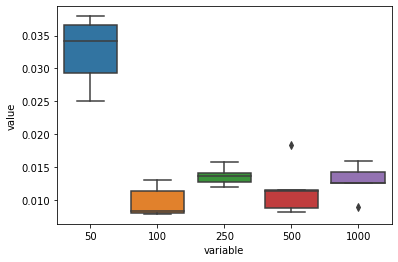

In [80]:
g = sns.boxplot(x='variable', y='value', data=df_melted) #100

In [20]:
dic = {}
for i in [50,70,80,90,100]:
    dic[i] = exp(6,5,64,i,5)
df_1 = pd.DataFrame(dic)
df_melted = pd.melt(df_1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                16896     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 1s - loss: 1.8470 - 1s/epoch - 275ms/step
Epoch 2/50
5/5 - 0s - loss: 0.9524 - 29ms/epoch - 6ms/step
Epoch 3/50
5/5 - 0s - loss: 0.3109 - 27ms/epoch - 5ms/step
Epoch 4/50
5/5 - 0s - loss: 0.0212 - 29ms/epoch - 6ms/step
Epoch 5/50
5/5 - 0s - loss: 0.0915 - 29ms/epoch - 6ms/step
Epoch 6/50
5/5 - 0s - loss: 0.0657 - 27ms/epoch - 5ms/step
Epoch 7/50
5/5 - 0s - loss: 0.0069 - 29ms/epoch - 6ms/step
Epoch 8/50
5/5 - 0s - loss: 0.012

                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 1s - loss: 2.7635 - 1s/epoch - 289ms/step
Epoch 2/50
5/5 - 0s - loss: 1.7767 - 25ms/epoch - 5ms/step
Epoch 3/50
5/5 - 0s - loss: 1.0318 - 25ms/epoch - 5ms/step
Epoch 4/50
5/5 - 0s - loss: 0.4501 - 25ms/epoch - 5ms/step
Epoch 5/50
5/5 - 0s - loss: 0.0809 - 24ms/epoch - 5ms/step
Epoch 6/50
5/5 - 0s - loss: 0.0294 - 26ms/epoch - 5ms/step
Epoch 7/50
5/5 - 0s - loss: 0.0914 - 25ms/epoch - 5ms/step
Epoch 8/50
5/5 - 0s - loss: 0.0337 - 25ms/epoch - 5ms/step
Epoch 9/50
5/5 - 0s - loss: 0.0042 - 25ms/epoch - 5ms/step
Epoch 10/50
5/5 - 0s - loss: 0.0131 - 25ms/epoch - 5ms/step
Epoch 11/50
5/5 - 0s - loss: 0.0143 - 26ms/epoch - 5ms/step
Epoch 12/50
5/5 - 0s - loss: 0.0063 - 23ms/epoch - 5ms/step
Epoch 13/50
5/5 - 0s - loss: 0.0026 - 22ms/epoch - 4ms/step
Epoch 14/50
5/5 - 0s - loss

5/5 - 0s - loss: 0.0208 - 28ms/epoch - 6ms/step
Epoch 5/50
5/5 - 0s - loss: 0.0954 - 26ms/epoch - 5ms/step
Epoch 6/50
5/5 - 0s - loss: 0.0555 - 24ms/epoch - 5ms/step
Epoch 7/50
5/5 - 0s - loss: 0.0034 - 24ms/epoch - 5ms/step
Epoch 8/50
5/5 - 0s - loss: 0.0175 - 23ms/epoch - 5ms/step
Epoch 9/50
5/5 - 0s - loss: 0.0179 - 23ms/epoch - 5ms/step
Epoch 10/50
5/5 - 0s - loss: 0.0044 - 23ms/epoch - 5ms/step
Epoch 11/50
5/5 - 0s - loss: 0.0026 - 24ms/epoch - 5ms/step
Epoch 12/50
5/5 - 0s - loss: 0.0049 - 22ms/epoch - 4ms/step
Epoch 13/50
5/5 - 0s - loss: 0.0022 - 21ms/epoch - 4ms/step
Epoch 14/50
5/5 - 0s - loss: 0.0016 - 20ms/epoch - 4ms/step
Epoch 15/50
5/5 - 0s - loss: 0.0021 - 25ms/epoch - 5ms/step
Epoch 16/50
5/5 - 0s - loss: 0.0015 - 21ms/epoch - 4ms/step
Epoch 17/50
5/5 - 0s - loss: 0.0014 - 24ms/epoch - 5ms/step
Epoch 18/50
5/5 - 0s - loss: 0.0015 - 17ms/epoch - 3ms/step
Epoch 19/50
5/5 - 0s - loss: 0.0013 - 23ms/epoch - 5ms/step
Epoch 20/50
5/5 - 0s - loss: 0.0013 - 24ms/epoch - 5ms/st

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 64)                16896     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
5/5 - 2s - loss: 1.8714 - 2s/epoch - 411ms/step
Epoch 2/70
5/5 - 0s - loss: 0.9712 - 26ms/epoch - 5ms/step
Epoch 3/70
5/5 - 0s - loss: 0.2712 - 25ms/epoch - 5ms/step
Epoch 4/70
5/5 - 0s - loss: 0.0304 - 26ms/epoch - 5ms/step
Epoch 5/70
5/5 - 0s - loss: 0.1325 - 24ms/epoch - 5ms/step
Epoch 6/70
5/5 - 0s - loss: 0.0312 - 26ms/epoch - 5ms/step
Epoch 7/70
5/5 - 0s - loss: 0.0093 - 28ms/epoch - 6ms/step
Epoch 8/70
5/5 - 0s - loss: 0.02

Epoch 40/70
5/5 - 0s - loss: 0.0010 - 25ms/epoch - 5ms/step
Epoch 41/70
5/5 - 0s - loss: 0.0010 - 25ms/epoch - 5ms/step
Epoch 42/70
5/5 - 0s - loss: 9.8288e-04 - 30ms/epoch - 6ms/step
Epoch 43/70
5/5 - 0s - loss: 9.6493e-04 - 25ms/epoch - 5ms/step
Epoch 44/70
5/5 - 0s - loss: 9.3704e-04 - 20ms/epoch - 4ms/step
Epoch 45/70
5/5 - 0s - loss: 9.1914e-04 - 19ms/epoch - 4ms/step
Epoch 46/70
5/5 - 0s - loss: 8.9926e-04 - 19ms/epoch - 4ms/step
Epoch 47/70
5/5 - 0s - loss: 8.7571e-04 - 22ms/epoch - 4ms/step
Epoch 48/70
5/5 - 0s - loss: 8.6213e-04 - 23ms/epoch - 5ms/step
Epoch 49/70
5/5 - 0s - loss: 8.3934e-04 - 20ms/epoch - 4ms/step
Epoch 50/70
5/5 - 0s - loss: 8.1985e-04 - 24ms/epoch - 5ms/step
Epoch 51/70
5/5 - 0s - loss: 8.0048e-04 - 21ms/epoch - 4ms/step
Epoch 52/70
5/5 - 0s - loss: 7.8592e-04 - 19ms/epoch - 4ms/step
Epoch 53/70
5/5 - 0s - loss: 7.6137e-04 - 16ms/epoch - 3ms/step
Epoch 54/70
5/5 - 0s - loss: 7.4342e-04 - 20ms/epoch - 4ms/step
Epoch 55/70
5/5 - 0s - loss: 7.2455e-04 - 19ms/e

Epoch 4/70
5/5 - 0s - loss: 0.2903 - 27ms/epoch - 5ms/step
Epoch 5/70
5/5 - 0s - loss: 0.0208 - 25ms/epoch - 5ms/step
Epoch 6/70
5/5 - 0s - loss: 0.1164 - 24ms/epoch - 5ms/step
Epoch 7/70
5/5 - 0s - loss: 0.0508 - 24ms/epoch - 5ms/step
Epoch 8/70
5/5 - 0s - loss: 0.0042 - 25ms/epoch - 5ms/step
Epoch 9/70
5/5 - 0s - loss: 0.0228 - 25ms/epoch - 5ms/step
Epoch 10/70
5/5 - 0s - loss: 0.0187 - 25ms/epoch - 5ms/step
Epoch 11/70
5/5 - 0s - loss: 0.0043 - 24ms/epoch - 5ms/step
Epoch 12/70
5/5 - 0s - loss: 0.0041 - 25ms/epoch - 5ms/step
Epoch 13/70
5/5 - 0s - loss: 0.0056 - 24ms/epoch - 5ms/step
Epoch 14/70
5/5 - 0s - loss: 0.0026 - 26ms/epoch - 5ms/step
Epoch 15/70
5/5 - 0s - loss: 0.0024 - 23ms/epoch - 5ms/step
Epoch 16/70
5/5 - 0s - loss: 0.0026 - 25ms/epoch - 5ms/step
Epoch 17/70
5/5 - 0s - loss: 0.0019 - 23ms/epoch - 5ms/step
Epoch 18/70
5/5 - 0s - loss: 0.0020 - 23ms/epoch - 5ms/step
Epoch 19/70
5/5 - 0s - loss: 0.0019 - 23ms/epoch - 5ms/step
Epoch 20/70
5/5 - 0s - loss: 0.0017 - 24ms/epo

Epoch 55/80
5/5 - 0s - loss: 9.6429e-04 - 20ms/epoch - 4ms/step
Epoch 56/80
5/5 - 0s - loss: 9.5187e-04 - 19ms/epoch - 4ms/step
Epoch 57/80
5/5 - 0s - loss: 9.1247e-04 - 16ms/epoch - 3ms/step
Epoch 58/80
5/5 - 0s - loss: 8.9470e-04 - 16ms/epoch - 3ms/step
Epoch 59/80
5/5 - 0s - loss: 8.6842e-04 - 16ms/epoch - 3ms/step
Epoch 60/80
5/5 - 0s - loss: 8.4266e-04 - 17ms/epoch - 3ms/step
Epoch 61/80
5/5 - 0s - loss: 8.2449e-04 - 16ms/epoch - 3ms/step
Epoch 62/80
5/5 - 0s - loss: 8.0065e-04 - 16ms/epoch - 3ms/step
Epoch 63/80
5/5 - 0s - loss: 7.8740e-04 - 21ms/epoch - 4ms/step
Epoch 64/80
5/5 - 0s - loss: 7.5710e-04 - 19ms/epoch - 4ms/step
Epoch 65/80
5/5 - 0s - loss: 7.4050e-04 - 19ms/epoch - 4ms/step
Epoch 66/80
5/5 - 0s - loss: 7.2181e-04 - 18ms/epoch - 4ms/step
Epoch 67/80
5/5 - 0s - loss: 7.0475e-04 - 17ms/epoch - 3ms/step
Epoch 68/80
5/5 - 0s - loss: 6.8501e-04 - 16ms/epoch - 3ms/step
Epoch 69/80
5/5 - 0s - loss: 6.6882e-04 - 16ms/epoch - 3ms/step
Epoch 70/80
5/5 - 0s - loss: 6.5097e-04 

Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
5/5 - 2s - loss: 1.9705 - 2s/epoch - 303ms/step
Epoch 2/80
5/5 - 0s - loss: 0.9718 - 29ms/epoch - 6ms/step
Epoch 3/80
5/5 - 0s - loss: 0.2739 - 27ms/epoch - 5ms/step
Epoch 4/80
5/5 - 0s - loss: 0.0207 - 26ms/epoch - 5ms/step
Epoch 5/80
5/5 - 0s - loss: 0.1169 - 29ms/epoch - 6ms/step
Epoch 6/80
5/5 - 0s - loss: 0.0570 - 29ms/epoch - 6ms/step
Epoch 7/80
5/5 - 0s - loss: 0.0042 - 25ms/epoch - 5ms/step
Epoch 8/80
5/5 - 0s - loss: 0.0172 - 26ms/epoch - 5ms/step
Epoch 9/80
5/5 - 0s - loss: 0.0194 - 23ms/epoch - 5ms/step
Epoch 10/80
5/5 - 0s - loss: 0.0067 - 27ms/epoch - 5ms/step
Epoch 11/80
5/5 - 0s - loss: 0.0026 - 27ms/epoch - 5ms/step
Epoch 12/80
5/5 - 0s - loss: 0.0049 - 24ms/epoch - 5ms/step
Epoch 13/80
5/5 - 0s - loss: 0.0035 - 27ms/epoch - 5ms/step
Epoch 14/80
5/5 - 0s - loss: 0.0021 - 23ms/epoch - 5ms/step
Epoch 15/80
5/5 - 0s - loss: 0.0025 - 20ms/epoch - 4ms/step
Epoch 16/80
5/5 - 0

Epoch 40/80
5/5 - 0s - loss: 0.0016 - 23ms/epoch - 5ms/step
Epoch 41/80
5/5 - 0s - loss: 0.0016 - 19ms/epoch - 4ms/step
Epoch 42/80
5/5 - 0s - loss: 0.0015 - 20ms/epoch - 4ms/step
Epoch 43/80
5/5 - 0s - loss: 0.0015 - 20ms/epoch - 4ms/step
Epoch 44/80
5/5 - 0s - loss: 0.0014 - 19ms/epoch - 4ms/step
Epoch 45/80
5/5 - 0s - loss: 0.0014 - 20ms/epoch - 4ms/step
Epoch 46/80
5/5 - 0s - loss: 0.0014 - 20ms/epoch - 4ms/step
Epoch 47/80
5/5 - 0s - loss: 0.0013 - 21ms/epoch - 4ms/step
Epoch 48/80
5/5 - 0s - loss: 0.0013 - 18ms/epoch - 4ms/step
Epoch 49/80
5/5 - 0s - loss: 0.0013 - 21ms/epoch - 4ms/step
Epoch 50/80
5/5 - 0s - loss: 0.0012 - 20ms/epoch - 4ms/step
Epoch 51/80
5/5 - 0s - loss: 0.0012 - 17ms/epoch - 3ms/step
Epoch 52/80
5/5 - 0s - loss: 0.0011 - 21ms/epoch - 4ms/step
Epoch 53/80
5/5 - 0s - loss: 0.0011 - 20ms/epoch - 4ms/step
Epoch 54/80
5/5 - 0s - loss: 0.0011 - 21ms/epoch - 4ms/step
Epoch 55/80
5/5 - 0s - loss: 0.0011 - 18ms/epoch - 4ms/step
Epoch 56/80
5/5 - 0s - loss: 0.0010 - 21

Epoch 79/80
5/5 - 0s - loss: 4.8194e-04 - 21ms/epoch - 4ms/step
Epoch 80/80
5/5 - 0s - loss: 4.7093e-04 - 20ms/epoch - 4ms/step
5/5 - 0s - loss: 4.6133e-04 - 344ms/epoch - 69ms/step
Train Score: 0.0005 MSE (0.02148 RMSE)
1/1 [==============================] - 0s 17ms/step - loss: 2.4272e-04
Test Score: 0.0002 MSE (0.01558 RMSE)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 64)                16896     
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/90
5/5 - 2s - loss: 2.7936 - 2s/epoch - 333ms/step
Epoch 2/90
5/5 - 0s - loss: 1.7809 - 25ms/epoch - 5ms/st

Epoch 14/90
5/5 - 0s - loss: 0.0018 - 19ms/epoch - 4ms/step
Epoch 15/90
5/5 - 0s - loss: 0.0025 - 20ms/epoch - 4ms/step
Epoch 16/90
5/5 - 0s - loss: 0.0021 - 20ms/epoch - 4ms/step
Epoch 17/90
5/5 - 0s - loss: 0.0016 - 19ms/epoch - 4ms/step
Epoch 18/90
5/5 - 0s - loss: 0.0018 - 20ms/epoch - 4ms/step
Epoch 19/90
5/5 - 0s - loss: 0.0017 - 19ms/epoch - 4ms/step
Epoch 20/90
5/5 - 0s - loss: 0.0015 - 19ms/epoch - 4ms/step
Epoch 21/90
5/5 - 0s - loss: 0.0015 - 19ms/epoch - 4ms/step
Epoch 22/90
5/5 - 0s - loss: 0.0015 - 20ms/epoch - 4ms/step
Epoch 23/90
5/5 - 0s - loss: 0.0015 - 19ms/epoch - 4ms/step
Epoch 24/90
5/5 - 0s - loss: 0.0014 - 19ms/epoch - 4ms/step
Epoch 25/90
5/5 - 0s - loss: 0.0014 - 20ms/epoch - 4ms/step
Epoch 26/90
5/5 - 0s - loss: 0.0014 - 20ms/epoch - 4ms/step
Epoch 27/90
5/5 - 0s - loss: 0.0014 - 20ms/epoch - 4ms/step
Epoch 28/90
5/5 - 0s - loss: 0.0013 - 20ms/epoch - 4ms/step
Epoch 29/90
5/5 - 0s - loss: 0.0013 - 19ms/epoch - 4ms/step
Epoch 30/90
5/5 - 0s - loss: 0.0013 - 19

Epoch 43/90
5/5 - 0s - loss: 0.0012 - 22ms/epoch - 4ms/step
Epoch 44/90
5/5 - 0s - loss: 0.0012 - 21ms/epoch - 4ms/step
Epoch 45/90
5/5 - 0s - loss: 0.0012 - 19ms/epoch - 4ms/step
Epoch 46/90
5/5 - 0s - loss: 0.0011 - 20ms/epoch - 4ms/step
Epoch 47/90
5/5 - 0s - loss: 0.0011 - 19ms/epoch - 4ms/step
Epoch 48/90
5/5 - 0s - loss: 0.0011 - 21ms/epoch - 4ms/step
Epoch 49/90
5/5 - 0s - loss: 0.0011 - 19ms/epoch - 4ms/step
Epoch 50/90
5/5 - 0s - loss: 0.0010 - 21ms/epoch - 4ms/step
Epoch 51/90
5/5 - 0s - loss: 0.0010 - 19ms/epoch - 4ms/step
Epoch 52/90
5/5 - 0s - loss: 9.8217e-04 - 21ms/epoch - 4ms/step
Epoch 53/90
5/5 - 0s - loss: 9.5452e-04 - 18ms/epoch - 4ms/step
Epoch 54/90
5/5 - 0s - loss: 9.2989e-04 - 19ms/epoch - 4ms/step
Epoch 55/90
5/5 - 0s - loss: 9.0898e-04 - 21ms/epoch - 4ms/step
Epoch 56/90
5/5 - 0s - loss: 8.8280e-04 - 21ms/epoch - 4ms/step
Epoch 57/90
5/5 - 0s - loss: 8.6391e-04 - 18ms/epoch - 4ms/step
Epoch 58/90
5/5 - 0s - loss: 8.3734e-04 - 21ms/epoch - 4ms/step
Epoch 59/90


Epoch 72/90
5/5 - 0s - loss: 6.6130e-04 - 23ms/epoch - 5ms/step
Epoch 73/90
5/5 - 0s - loss: 6.5218e-04 - 22ms/epoch - 4ms/step
Epoch 74/90
5/5 - 0s - loss: 6.2467e-04 - 22ms/epoch - 4ms/step
Epoch 75/90
5/5 - 0s - loss: 6.1164e-04 - 21ms/epoch - 4ms/step
Epoch 76/90
5/5 - 0s - loss: 5.8611e-04 - 23ms/epoch - 5ms/step
Epoch 77/90
5/5 - 0s - loss: 5.9304e-04 - 21ms/epoch - 4ms/step
Epoch 78/90
5/5 - 0s - loss: 5.5882e-04 - 22ms/epoch - 4ms/step
Epoch 79/90
5/5 - 0s - loss: 5.4805e-04 - 24ms/epoch - 5ms/step
Epoch 80/90
5/5 - 0s - loss: 5.3985e-04 - 23ms/epoch - 5ms/step
Epoch 81/90
5/5 - 0s - loss: 5.1774e-04 - 22ms/epoch - 4ms/step
Epoch 82/90
5/5 - 0s - loss: 5.0176e-04 - 21ms/epoch - 4ms/step
Epoch 83/90
5/5 - 0s - loss: 4.8631e-04 - 23ms/epoch - 5ms/step
Epoch 84/90
5/5 - 0s - loss: 4.8533e-04 - 22ms/epoch - 4ms/step
Epoch 85/90
5/5 - 0s - loss: 4.6505e-04 - 24ms/epoch - 5ms/step
Epoch 86/90
5/5 - 0s - loss: 4.6771e-04 - 22ms/epoch - 4ms/step
Epoch 87/90
5/5 - 0s - loss: 4.5565e-04 

                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 - 2s - loss: 2.5716 - 2s/epoch - 328ms/step
Epoch 2/100
5/5 - 0s - loss: 1.5841 - 23ms/epoch - 5ms/step
Epoch 3/100
5/5 - 0s - loss: 0.7567 - 25ms/epoch - 5ms/step
Epoch 4/100
5/5 - 0s - loss: 0.1636 - 23ms/epoch - 5ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0385 - 25ms/epoch - 5ms/step
Epoch 6/100
5/5 - 0s - loss: 0.1254 - 23ms/epoch - 5ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0330 - 25ms/epoch - 5ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0064 - 23ms/epoch - 5ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0221 - 25ms/epoch - 5ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0168 - 22ms/epoch - 4ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0043 - 24ms/epoch - 5ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0041 - 22ms/epoch - 4ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0056 - 25ms/epoch - 5ms/step
Epoch 14/100
5

Epoch 14/100
5/5 - 0s - loss: 0.0025 - 24ms/epoch - 5ms/step
Epoch 15/100
5/5 - 0s - loss: 0.0026 - 25ms/epoch - 5ms/step
Epoch 16/100
5/5 - 0s - loss: 0.0030 - 24ms/epoch - 5ms/step
Epoch 17/100
5/5 - 0s - loss: 0.0023 - 25ms/epoch - 5ms/step
Epoch 18/100
5/5 - 0s - loss: 0.0022 - 23ms/epoch - 5ms/step
Epoch 19/100
5/5 - 0s - loss: 0.0022 - 25ms/epoch - 5ms/step
Epoch 20/100
5/5 - 0s - loss: 0.0021 - 24ms/epoch - 5ms/step
Epoch 21/100
5/5 - 0s - loss: 0.0021 - 24ms/epoch - 5ms/step
Epoch 22/100
5/5 - 0s - loss: 0.0020 - 24ms/epoch - 5ms/step
Epoch 23/100
5/5 - 0s - loss: 0.0020 - 24ms/epoch - 5ms/step
Epoch 24/100
5/5 - 0s - loss: 0.0019 - 24ms/epoch - 5ms/step
Epoch 25/100
5/5 - 0s - loss: 0.0019 - 24ms/epoch - 5ms/step
Epoch 26/100
5/5 - 0s - loss: 0.0019 - 23ms/epoch - 5ms/step
Epoch 27/100
5/5 - 0s - loss: 0.0018 - 24ms/epoch - 5ms/step
Epoch 28/100
5/5 - 0s - loss: 0.0018 - 25ms/epoch - 5ms/step
Epoch 29/100
5/5 - 0s - loss: 0.0018 - 24ms/epoch - 5ms/step
Epoch 30/100
5/5 - 0s - 

Epoch 31/100
5/5 - 0s - loss: 0.0011 - 22ms/epoch - 4ms/step
Epoch 32/100
5/5 - 0s - loss: 0.0011 - 21ms/epoch - 4ms/step
Epoch 33/100
5/5 - 0s - loss: 0.0010 - 23ms/epoch - 5ms/step
Epoch 34/100
5/5 - 0s - loss: 0.0011 - 21ms/epoch - 4ms/step
Epoch 35/100
5/5 - 0s - loss: 0.0010 - 22ms/epoch - 4ms/step
Epoch 36/100
5/5 - 0s - loss: 9.9074e-04 - 22ms/epoch - 4ms/step
Epoch 37/100
5/5 - 0s - loss: 9.6086e-04 - 23ms/epoch - 5ms/step
Epoch 38/100
5/5 - 0s - loss: 9.5911e-04 - 23ms/epoch - 5ms/step
Epoch 39/100
5/5 - 0s - loss: 9.3477e-04 - 24ms/epoch - 5ms/step
Epoch 40/100
5/5 - 0s - loss: 9.2332e-04 - 20ms/epoch - 4ms/step
Epoch 41/100
5/5 - 0s - loss: 9.0469e-04 - 24ms/epoch - 5ms/step
Epoch 42/100
5/5 - 0s - loss: 8.9464e-04 - 22ms/epoch - 4ms/step
Epoch 43/100
5/5 - 0s - loss: 8.8068e-04 - 22ms/epoch - 4ms/step
Epoch 44/100
5/5 - 0s - loss: 8.6425e-04 - 23ms/epoch - 5ms/step
Epoch 45/100
5/5 - 0s - loss: 8.5165e-04 - 22ms/epoch - 4ms/step
Epoch 46/100
5/5 - 0s - loss: 8.3545e-04 - 23

Epoch 47/100
5/5 - 0s - loss: 0.0011 - 23ms/epoch - 5ms/step
Epoch 48/100
5/5 - 0s - loss: 0.0011 - 24ms/epoch - 5ms/step
Epoch 49/100
5/5 - 0s - loss: 0.0011 - 25ms/epoch - 5ms/step
Epoch 50/100
5/5 - 0s - loss: 0.0010 - 26ms/epoch - 5ms/step
Epoch 51/100
5/5 - 0s - loss: 0.0010 - 24ms/epoch - 5ms/step
Epoch 52/100
5/5 - 0s - loss: 9.5775e-04 - 25ms/epoch - 5ms/step
Epoch 53/100
5/5 - 0s - loss: 9.4216e-04 - 23ms/epoch - 5ms/step
Epoch 54/100
5/5 - 0s - loss: 9.1322e-04 - 27ms/epoch - 5ms/step
Epoch 55/100
5/5 - 0s - loss: 8.8561e-04 - 22ms/epoch - 4ms/step
Epoch 56/100
5/5 - 0s - loss: 8.6051e-04 - 23ms/epoch - 5ms/step
Epoch 57/100
5/5 - 0s - loss: 8.3628e-04 - 24ms/epoch - 5ms/step
Epoch 58/100
5/5 - 0s - loss: 8.1413e-04 - 24ms/epoch - 5ms/step
Epoch 59/100
5/5 - 0s - loss: 7.9194e-04 - 24ms/epoch - 5ms/step
Epoch 60/100
5/5 - 0s - loss: 7.7051e-04 - 25ms/epoch - 5ms/step
Epoch 61/100
5/5 - 0s - loss: 7.5446e-04 - 25ms/epoch - 5ms/step
Epoch 62/100
5/5 - 0s - loss: 7.3074e-04 - 25

Epoch 63/100
5/5 - 0s - loss: 6.2466e-04 - 23ms/epoch - 5ms/step
Epoch 64/100
5/5 - 0s - loss: 6.1365e-04 - 23ms/epoch - 5ms/step
Epoch 65/100
5/5 - 0s - loss: 6.0255e-04 - 22ms/epoch - 4ms/step
Epoch 66/100
5/5 - 0s - loss: 5.8035e-04 - 22ms/epoch - 4ms/step
Epoch 67/100
5/5 - 0s - loss: 5.6651e-04 - 23ms/epoch - 5ms/step
Epoch 68/100
5/5 - 0s - loss: 5.5146e-04 - 24ms/epoch - 5ms/step
Epoch 69/100
5/5 - 0s - loss: 5.3940e-04 - 24ms/epoch - 5ms/step
Epoch 70/100
5/5 - 0s - loss: 5.2565e-04 - 24ms/epoch - 5ms/step
Epoch 71/100
5/5 - 0s - loss: 5.1262e-04 - 23ms/epoch - 5ms/step
Epoch 72/100
5/5 - 0s - loss: 5.0112e-04 - 23ms/epoch - 5ms/step
Epoch 73/100
5/5 - 0s - loss: 4.8830e-04 - 24ms/epoch - 5ms/step
Epoch 74/100
5/5 - 0s - loss: 4.8101e-04 - 23ms/epoch - 5ms/step
Epoch 75/100
5/5 - 0s - loss: 4.6615e-04 - 23ms/epoch - 5ms/step
Epoch 76/100
5/5 - 0s - loss: 4.5816e-04 - 23ms/epoch - 5ms/step
Epoch 77/100
5/5 - 0s - loss: 4.4887e-04 - 23ms/epoch - 5ms/step
Epoch 78/100
5/5 - 0s - l

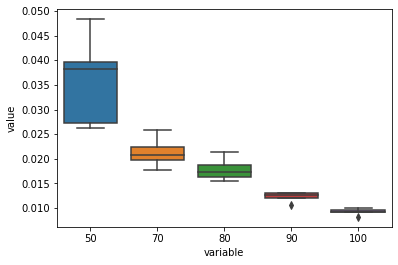

In [21]:
g = sns.boxplot(x='variable', y='value', data=df_melted) #100

In [22]:
dic = {}
for i in [100,125,150,175,200]:
    dic[i] = exp(6,5,64,i,5)
df_1 = pd.DataFrame(dic)
df_melted = pd.melt(df_1)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 64)                16896     
                                                                 
 dense_30 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 - 1s - loss: 2.1267 - 1s/epoch - 285ms/step
Epoch 2/100
5/5 - 0s - loss: 1.2468 - 24ms/epoch - 5ms/step
Epoch 3/100
5/5 - 0s - loss: 0.5155 - 29ms/epoch - 6ms/step
Epoch 4/100
5/5 - 0s - loss: 0.0641 - 25ms/epoch - 5ms/step
Epoch 5/100
5/5 - 0s - loss: 0.0742 - 26ms/epoch - 5ms/step
Epoch 6/100
5/5 - 0s - loss: 0.0950 - 27ms/epoch - 5ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0102 - 27ms/epoch - 5ms/step
Epoch 8/100
5/5 - 0s - lo

Epoch 6/100
5/5 - 0s - loss: 0.1103 - 27ms/epoch - 5ms/step
Epoch 7/100
5/5 - 0s - loss: 0.0550 - 26ms/epoch - 5ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0052 - 24ms/epoch - 5ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0182 - 27ms/epoch - 5ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0187 - 25ms/epoch - 5ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0061 - 25ms/epoch - 5ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0035 - 22ms/epoch - 4ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0057 - 23ms/epoch - 5ms/step
Epoch 14/100
5/5 - 0s - loss: 0.0037 - 20ms/epoch - 4ms/step
Epoch 15/100
5/5 - 0s - loss: 0.0024 - 23ms/epoch - 5ms/step
Epoch 16/100
5/5 - 0s - loss: 0.0030 - 23ms/epoch - 5ms/step
Epoch 17/100
5/5 - 0s - loss: 0.0027 - 22ms/epoch - 4ms/step
Epoch 18/100
5/5 - 0s - loss: 0.0023 - 22ms/epoch - 4ms/step
Epoch 19/100
5/5 - 0s - loss: 0.0024 - 23ms/epoch - 5ms/step
Epoch 20/100
5/5 - 0s - loss: 0.0023 - 26ms/epoch - 5ms/step
Epoch 21/100
5/5 - 0s - loss: 0.0022 - 21ms/epoch - 4ms/step
Epoch 22/100
5/5 - 0s - loss

Epoch 23/100
5/5 - 0s - loss: 0.0021 - 23ms/epoch - 5ms/step
Epoch 24/100
5/5 - 0s - loss: 0.0021 - 23ms/epoch - 5ms/step
Epoch 25/100
5/5 - 0s - loss: 0.0020 - 21ms/epoch - 4ms/step
Epoch 26/100
5/5 - 0s - loss: 0.0020 - 20ms/epoch - 4ms/step
Epoch 27/100
5/5 - 0s - loss: 0.0019 - 19ms/epoch - 4ms/step
Epoch 28/100
5/5 - 0s - loss: 0.0019 - 20ms/epoch - 4ms/step
Epoch 29/100
5/5 - 0s - loss: 0.0019 - 22ms/epoch - 4ms/step
Epoch 30/100
5/5 - 0s - loss: 0.0018 - 20ms/epoch - 4ms/step
Epoch 31/100
5/5 - 0s - loss: 0.0018 - 18ms/epoch - 4ms/step
Epoch 32/100
5/5 - 0s - loss: 0.0018 - 19ms/epoch - 4ms/step
Epoch 33/100
5/5 - 0s - loss: 0.0017 - 21ms/epoch - 4ms/step
Epoch 34/100
5/5 - 0s - loss: 0.0017 - 19ms/epoch - 4ms/step
Epoch 35/100
5/5 - 0s - loss: 0.0016 - 18ms/epoch - 4ms/step
Epoch 36/100
5/5 - 0s - loss: 0.0016 - 21ms/epoch - 4ms/step
Epoch 37/100
5/5 - 0s - loss: 0.0016 - 20ms/epoch - 4ms/step
Epoch 38/100
5/5 - 0s - loss: 0.0015 - 19ms/epoch - 4ms/step
Epoch 39/100
5/5 - 0s - 

Epoch 40/100
5/5 - 0s - loss: 8.9136e-04 - 26ms/epoch - 5ms/step
Epoch 41/100
5/5 - 0s - loss: 8.6408e-04 - 22ms/epoch - 4ms/step
Epoch 42/100
5/5 - 0s - loss: 8.5252e-04 - 24ms/epoch - 5ms/step
Epoch 43/100
5/5 - 0s - loss: 8.2985e-04 - 18ms/epoch - 4ms/step
Epoch 44/100
5/5 - 0s - loss: 8.1908e-04 - 22ms/epoch - 4ms/step
Epoch 45/100
5/5 - 0s - loss: 8.0523e-04 - 25ms/epoch - 5ms/step
Epoch 46/100
5/5 - 0s - loss: 7.9097e-04 - 20ms/epoch - 4ms/step
Epoch 47/100
5/5 - 0s - loss: 7.8892e-04 - 21ms/epoch - 4ms/step
Epoch 48/100
5/5 - 0s - loss: 7.6832e-04 - 20ms/epoch - 4ms/step
Epoch 49/100
5/5 - 0s - loss: 7.5072e-04 - 22ms/epoch - 4ms/step
Epoch 50/100
5/5 - 0s - loss: 7.3987e-04 - 21ms/epoch - 4ms/step
Epoch 51/100
5/5 - 0s - loss: 7.3041e-04 - 24ms/epoch - 5ms/step
Epoch 52/100
5/5 - 0s - loss: 7.0853e-04 - 25ms/epoch - 5ms/step
Epoch 53/100
5/5 - 0s - loss: 7.0177e-04 - 19ms/epoch - 4ms/step
Epoch 54/100
5/5 - 0s - loss: 6.9496e-04 - 24ms/epoch - 5ms/step
Epoch 55/100
5/5 - 0s - l

Epoch 55/100
5/5 - 0s - loss: 5.8560e-04 - 23ms/epoch - 5ms/step
Epoch 56/100
5/5 - 0s - loss: 5.7386e-04 - 21ms/epoch - 4ms/step
Epoch 57/100
5/5 - 0s - loss: 5.6489e-04 - 21ms/epoch - 4ms/step
Epoch 58/100
5/5 - 0s - loss: 5.5090e-04 - 21ms/epoch - 4ms/step
Epoch 59/100
5/5 - 0s - loss: 5.3521e-04 - 19ms/epoch - 4ms/step
Epoch 60/100
5/5 - 0s - loss: 5.2330e-04 - 19ms/epoch - 4ms/step
Epoch 61/100
5/5 - 0s - loss: 5.1236e-04 - 20ms/epoch - 4ms/step
Epoch 62/100
5/5 - 0s - loss: 5.0823e-04 - 20ms/epoch - 4ms/step
Epoch 63/100
5/5 - 0s - loss: 4.8771e-04 - 19ms/epoch - 4ms/step
Epoch 64/100
5/5 - 0s - loss: 4.8013e-04 - 19ms/epoch - 4ms/step
Epoch 65/100
5/5 - 0s - loss: 4.6647e-04 - 20ms/epoch - 4ms/step
Epoch 66/100
5/5 - 0s - loss: 4.6755e-04 - 23ms/epoch - 5ms/step
Epoch 67/100
5/5 - 0s - loss: 4.4787e-04 - 21ms/epoch - 4ms/step
Epoch 68/100
5/5 - 0s - loss: 4.4663e-04 - 21ms/epoch - 4ms/step
Epoch 69/100
5/5 - 0s - loss: 4.3481e-04 - 22ms/epoch - 4ms/step
Epoch 70/100
5/5 - 0s - l

Epoch 71/125
5/5 - 0s - loss: 5.5416e-04 - 24ms/epoch - 5ms/step
Epoch 72/125
5/5 - 0s - loss: 5.3897e-04 - 21ms/epoch - 4ms/step
Epoch 73/125
5/5 - 0s - loss: 5.2632e-04 - 26ms/epoch - 5ms/step
Epoch 74/125
5/5 - 0s - loss: 5.0979e-04 - 22ms/epoch - 4ms/step
Epoch 75/125
5/5 - 0s - loss: 5.0402e-04 - 24ms/epoch - 5ms/step
Epoch 76/125
5/5 - 0s - loss: 4.8405e-04 - 22ms/epoch - 4ms/step
Epoch 77/125
5/5 - 0s - loss: 4.8200e-04 - 23ms/epoch - 5ms/step
Epoch 78/125
5/5 - 0s - loss: 4.6226e-04 - 22ms/epoch - 4ms/step
Epoch 79/125
5/5 - 0s - loss: 4.6524e-04 - 20ms/epoch - 4ms/step
Epoch 80/125
5/5 - 0s - loss: 4.4901e-04 - 24ms/epoch - 5ms/step
Epoch 81/125
5/5 - 0s - loss: 4.3076e-04 - 22ms/epoch - 4ms/step
Epoch 82/125
5/5 - 0s - loss: 4.2289e-04 - 23ms/epoch - 5ms/step
Epoch 83/125
5/5 - 0s - loss: 4.1337e-04 - 21ms/epoch - 4ms/step
Epoch 84/125
5/5 - 0s - loss: 4.1653e-04 - 23ms/epoch - 5ms/step
Epoch 85/125
5/5 - 0s - loss: 3.9067e-04 - 23ms/epoch - 5ms/step
Epoch 86/125
5/5 - 0s - l

Epoch 61/125
5/5 - 0s - loss: 7.1332e-04 - 20ms/epoch - 4ms/step
Epoch 62/125
5/5 - 0s - loss: 6.8732e-04 - 19ms/epoch - 4ms/step
Epoch 63/125
5/5 - 0s - loss: 6.6363e-04 - 19ms/epoch - 4ms/step
Epoch 64/125
5/5 - 0s - loss: 6.4967e-04 - 19ms/epoch - 4ms/step
Epoch 65/125
5/5 - 0s - loss: 6.3128e-04 - 21ms/epoch - 4ms/step
Epoch 66/125
5/5 - 0s - loss: 6.1253e-04 - 20ms/epoch - 4ms/step
Epoch 67/125
5/5 - 0s - loss: 6.0492e-04 - 19ms/epoch - 4ms/step
Epoch 68/125
5/5 - 0s - loss: 5.8134e-04 - 20ms/epoch - 4ms/step
Epoch 69/125
5/5 - 0s - loss: 5.7415e-04 - 20ms/epoch - 4ms/step
Epoch 70/125
5/5 - 0s - loss: 5.5393e-04 - 21ms/epoch - 4ms/step
Epoch 71/125
5/5 - 0s - loss: 5.4441e-04 - 20ms/epoch - 4ms/step
Epoch 72/125
5/5 - 0s - loss: 5.3658e-04 - 19ms/epoch - 4ms/step
Epoch 73/125
5/5 - 0s - loss: 5.1242e-04 - 20ms/epoch - 4ms/step
Epoch 74/125
5/5 - 0s - loss: 5.2078e-04 - 19ms/epoch - 4ms/step
Epoch 75/125
5/5 - 0s - loss: 4.9394e-04 - 20ms/epoch - 4ms/step
Epoch 76/125
5/5 - 0s - l

5/5 - 0s - loss: 0.0018 - 22ms/epoch - 4ms/step
Epoch 52/125
5/5 - 0s - loss: 0.0018 - 22ms/epoch - 4ms/step
Epoch 53/125
5/5 - 0s - loss: 0.0017 - 25ms/epoch - 5ms/step
Epoch 54/125
5/5 - 0s - loss: 0.0017 - 24ms/epoch - 5ms/step
Epoch 55/125
5/5 - 0s - loss: 0.0016 - 26ms/epoch - 5ms/step
Epoch 56/125
5/5 - 0s - loss: 0.0015 - 26ms/epoch - 5ms/step
Epoch 57/125
5/5 - 0s - loss: 0.0015 - 24ms/epoch - 5ms/step
Epoch 58/125
5/5 - 0s - loss: 0.0014 - 23ms/epoch - 5ms/step
Epoch 59/125
5/5 - 0s - loss: 0.0014 - 22ms/epoch - 4ms/step
Epoch 60/125
5/5 - 0s - loss: 0.0013 - 21ms/epoch - 4ms/step
Epoch 61/125
5/5 - 0s - loss: 0.0013 - 19ms/epoch - 4ms/step
Epoch 62/125
5/5 - 0s - loss: 0.0012 - 23ms/epoch - 5ms/step
Epoch 63/125
5/5 - 0s - loss: 0.0012 - 20ms/epoch - 4ms/step
Epoch 64/125
5/5 - 0s - loss: 0.0011 - 22ms/epoch - 4ms/step
Epoch 65/125
5/5 - 0s - loss: 0.0011 - 22ms/epoch - 4ms/step
Epoch 66/125
5/5 - 0s - loss: 0.0011 - 23ms/epoch - 5ms/step
Epoch 67/125
5/5 - 0s - loss: 0.0010 

Epoch 42/125
5/5 - 0s - loss: 0.0012 - 18ms/epoch - 4ms/step
Epoch 43/125
5/5 - 0s - loss: 0.0011 - 18ms/epoch - 4ms/step
Epoch 44/125
5/5 - 0s - loss: 0.0011 - 19ms/epoch - 4ms/step
Epoch 45/125
5/5 - 0s - loss: 0.0011 - 19ms/epoch - 4ms/step
Epoch 46/125
5/5 - 0s - loss: 0.0011 - 21ms/epoch - 4ms/step
Epoch 47/125
5/5 - 0s - loss: 0.0010 - 20ms/epoch - 4ms/step
Epoch 48/125
5/5 - 0s - loss: 0.0010 - 19ms/epoch - 4ms/step
Epoch 49/125
5/5 - 0s - loss: 9.8597e-04 - 20ms/epoch - 4ms/step
Epoch 50/125
5/5 - 0s - loss: 9.6009e-04 - 24ms/epoch - 5ms/step
Epoch 51/125
5/5 - 0s - loss: 9.3899e-04 - 21ms/epoch - 4ms/step
Epoch 52/125
5/5 - 0s - loss: 9.3456e-04 - 21ms/epoch - 4ms/step
Epoch 53/125
5/5 - 0s - loss: 9.0724e-04 - 18ms/epoch - 4ms/step
Epoch 54/125
5/5 - 0s - loss: 8.8032e-04 - 18ms/epoch - 4ms/step
Epoch 55/125
5/5 - 0s - loss: 8.6718e-04 - 19ms/epoch - 4ms/step
Epoch 56/125
5/5 - 0s - loss: 8.3743e-04 - 20ms/epoch - 4ms/step
Epoch 57/125
5/5 - 0s - loss: 8.1007e-04 - 20ms/epoch

Epoch 32/125
5/5 - 0s - loss: 0.0027 - 25ms/epoch - 5ms/step
Epoch 33/125
5/5 - 0s - loss: 0.0026 - 25ms/epoch - 5ms/step
Epoch 34/125
5/5 - 0s - loss: 0.0025 - 23ms/epoch - 5ms/step
Epoch 35/125
5/5 - 0s - loss: 0.0025 - 23ms/epoch - 5ms/step
Epoch 36/125
5/5 - 0s - loss: 0.0024 - 21ms/epoch - 4ms/step
Epoch 37/125
5/5 - 0s - loss: 0.0024 - 22ms/epoch - 4ms/step
Epoch 38/125
5/5 - 0s - loss: 0.0023 - 25ms/epoch - 5ms/step
Epoch 39/125
5/5 - 0s - loss: 0.0023 - 24ms/epoch - 5ms/step
Epoch 40/125
5/5 - 0s - loss: 0.0022 - 23ms/epoch - 5ms/step
Epoch 41/125
5/5 - 0s - loss: 0.0022 - 23ms/epoch - 5ms/step
Epoch 42/125
5/5 - 0s - loss: 0.0021 - 23ms/epoch - 5ms/step
Epoch 43/125
5/5 - 0s - loss: 0.0021 - 23ms/epoch - 5ms/step
Epoch 44/125
5/5 - 0s - loss: 0.0020 - 23ms/epoch - 5ms/step
Epoch 45/125
5/5 - 0s - loss: 0.0020 - 21ms/epoch - 4ms/step
Epoch 46/125
5/5 - 0s - loss: 0.0019 - 22ms/epoch - 4ms/step
Epoch 47/125
5/5 - 0s - loss: 0.0019 - 23ms/epoch - 5ms/step
Epoch 48/125
5/5 - 0s - 

Epoch 23/150
5/5 - 0s - loss: 0.0019 - 22ms/epoch - 4ms/step
Epoch 24/150
5/5 - 0s - loss: 0.0019 - 25ms/epoch - 5ms/step
Epoch 25/150
5/5 - 0s - loss: 0.0019 - 22ms/epoch - 4ms/step
Epoch 26/150
5/5 - 0s - loss: 0.0018 - 24ms/epoch - 5ms/step
Epoch 27/150
5/5 - 0s - loss: 0.0018 - 22ms/epoch - 4ms/step
Epoch 28/150
5/5 - 0s - loss: 0.0018 - 24ms/epoch - 5ms/step
Epoch 29/150
5/5 - 0s - loss: 0.0017 - 23ms/epoch - 5ms/step
Epoch 30/150
5/5 - 0s - loss: 0.0017 - 23ms/epoch - 5ms/step
Epoch 31/150
5/5 - 0s - loss: 0.0017 - 21ms/epoch - 4ms/step
Epoch 32/150
5/5 - 0s - loss: 0.0016 - 20ms/epoch - 4ms/step
Epoch 33/150
5/5 - 0s - loss: 0.0016 - 25ms/epoch - 5ms/step
Epoch 34/150
5/5 - 0s - loss: 0.0016 - 25ms/epoch - 5ms/step
Epoch 35/150
5/5 - 0s - loss: 0.0015 - 24ms/epoch - 5ms/step
Epoch 36/150
5/5 - 0s - loss: 0.0015 - 21ms/epoch - 4ms/step
Epoch 37/150
5/5 - 0s - loss: 0.0015 - 24ms/epoch - 5ms/step
Epoch 38/150
5/5 - 0s - loss: 0.0014 - 24ms/epoch - 5ms/step
Epoch 39/150
5/5 - 0s - 

5/5 - 0s - loss: 2.4736e-04 - 21ms/epoch - 4ms/step
5/5 - 0s - loss: 2.4923e-04 - 342ms/epoch - 68ms/step
Train Score: 0.0002 MSE (0.01579 RMSE)
1/1 [==============================] - 0s 17ms/step - loss: 1.0524e-04
Test Score: 0.0001 MSE (0.01026 RMSE)
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 64)                16896     
                                                                 
 dense_41 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
5/5 - 1s - loss: 2.5355 - 1s/epoch - 279ms/step
Epoch 2/150
5/5 - 0s - loss: 1.5576 - 26ms/epoch - 5ms/step
Epoch 3/150
5/5 - 0s - loss: 0.7717 - 24ms/epoch - 5ms/step
Epoch 4/150

Epoch 116/150
5/5 - 0s - loss: 2.6330e-04 - 22ms/epoch - 4ms/step
Epoch 117/150
5/5 - 0s - loss: 2.6990e-04 - 20ms/epoch - 4ms/step
Epoch 118/150
5/5 - 0s - loss: 2.5358e-04 - 22ms/epoch - 4ms/step
Epoch 119/150
5/5 - 0s - loss: 2.6231e-04 - 20ms/epoch - 4ms/step
Epoch 120/150
5/5 - 0s - loss: 2.5153e-04 - 21ms/epoch - 4ms/step
Epoch 121/150
5/5 - 0s - loss: 2.5495e-04 - 22ms/epoch - 4ms/step
Epoch 122/150
5/5 - 0s - loss: 2.4980e-04 - 22ms/epoch - 4ms/step
Epoch 123/150
5/5 - 0s - loss: 2.4789e-04 - 21ms/epoch - 4ms/step
Epoch 124/150
5/5 - 0s - loss: 2.4713e-04 - 21ms/epoch - 4ms/step
Epoch 125/150
5/5 - 0s - loss: 2.4495e-04 - 20ms/epoch - 4ms/step
Epoch 126/150
5/5 - 0s - loss: 2.4280e-04 - 21ms/epoch - 4ms/step
Epoch 127/150
5/5 - 0s - loss: 2.4166e-04 - 21ms/epoch - 4ms/step
Epoch 128/150
5/5 - 0s - loss: 2.4812e-04 - 24ms/epoch - 5ms/step
Epoch 129/150
5/5 - 0s - loss: 2.4983e-04 - 21ms/epoch - 4ms/step
Epoch 130/150
5/5 - 0s - loss: 2.4400e-04 - 23ms/epoch - 5ms/step
Epoch 131/

Epoch 82/150
5/5 - 0s - loss: 4.8028e-04 - 24ms/epoch - 5ms/step
Epoch 83/150
5/5 - 0s - loss: 4.5433e-04 - 23ms/epoch - 5ms/step
Epoch 84/150
5/5 - 0s - loss: 4.4427e-04 - 21ms/epoch - 4ms/step
Epoch 85/150
5/5 - 0s - loss: 4.3845e-04 - 22ms/epoch - 4ms/step
Epoch 86/150
5/5 - 0s - loss: 4.2097e-04 - 25ms/epoch - 5ms/step
Epoch 87/150
5/5 - 0s - loss: 4.1868e-04 - 21ms/epoch - 4ms/step
Epoch 88/150
5/5 - 0s - loss: 4.0815e-04 - 23ms/epoch - 5ms/step
Epoch 89/150
5/5 - 0s - loss: 3.9524e-04 - 25ms/epoch - 5ms/step
Epoch 90/150
5/5 - 0s - loss: 3.8439e-04 - 23ms/epoch - 5ms/step
Epoch 91/150
5/5 - 0s - loss: 3.7882e-04 - 23ms/epoch - 5ms/step
Epoch 92/150
5/5 - 0s - loss: 3.7048e-04 - 20ms/epoch - 4ms/step
Epoch 93/150
5/5 - 0s - loss: 3.6253e-04 - 22ms/epoch - 4ms/step
Epoch 94/150
5/5 - 0s - loss: 3.5204e-04 - 21ms/epoch - 4ms/step
Epoch 95/150
5/5 - 0s - loss: 3.4833e-04 - 24ms/epoch - 5ms/step
Epoch 96/150
5/5 - 0s - loss: 3.4183e-04 - 23ms/epoch - 5ms/step
Epoch 97/150
5/5 - 0s - l

Epoch 47/150
5/5 - 0s - loss: 9.7003e-04 - 26ms/epoch - 5ms/step
Epoch 48/150
5/5 - 0s - loss: 9.4503e-04 - 25ms/epoch - 5ms/step
Epoch 49/150
5/5 - 0s - loss: 9.2207e-04 - 26ms/epoch - 5ms/step
Epoch 50/150
5/5 - 0s - loss: 9.0329e-04 - 26ms/epoch - 5ms/step
Epoch 51/150
5/5 - 0s - loss: 8.9068e-04 - 24ms/epoch - 5ms/step
Epoch 52/150
5/5 - 0s - loss: 8.5659e-04 - 26ms/epoch - 5ms/step
Epoch 53/150
5/5 - 0s - loss: 8.5179e-04 - 24ms/epoch - 5ms/step
Epoch 54/150
5/5 - 0s - loss: 8.1411e-04 - 25ms/epoch - 5ms/step
Epoch 55/150
5/5 - 0s - loss: 8.1956e-04 - 23ms/epoch - 5ms/step
Epoch 56/150
5/5 - 0s - loss: 7.7166e-04 - 24ms/epoch - 5ms/step
Epoch 57/150
5/5 - 0s - loss: 7.8994e-04 - 24ms/epoch - 5ms/step
Epoch 58/150
5/5 - 0s - loss: 7.5916e-04 - 25ms/epoch - 5ms/step
Epoch 59/150
5/5 - 0s - loss: 7.3721e-04 - 25ms/epoch - 5ms/step
Epoch 60/150
5/5 - 0s - loss: 7.3979e-04 - 23ms/epoch - 5ms/step
Epoch 61/150
5/5 - 0s - loss: 7.0551e-04 - 24ms/epoch - 5ms/step
Epoch 62/150
5/5 - 0s - l

Epoch 10/150
5/5 - 0s - loss: 0.0146 - 26ms/epoch - 5ms/step
Epoch 11/150
5/5 - 0s - loss: 0.0035 - 24ms/epoch - 5ms/step
Epoch 12/150
5/5 - 0s - loss: 0.0034 - 21ms/epoch - 4ms/step
Epoch 13/150
5/5 - 0s - loss: 0.0050 - 26ms/epoch - 5ms/step
Epoch 14/150
5/5 - 0s - loss: 0.0030 - 23ms/epoch - 5ms/step
Epoch 15/150
5/5 - 0s - loss: 0.0022 - 23ms/epoch - 5ms/step
Epoch 16/150
5/5 - 0s - loss: 0.0027 - 23ms/epoch - 5ms/step
Epoch 17/150
5/5 - 0s - loss: 0.0024 - 24ms/epoch - 5ms/step
Epoch 18/150
5/5 - 0s - loss: 0.0022 - 23ms/epoch - 5ms/step
Epoch 19/150
5/5 - 0s - loss: 0.0022 - 24ms/epoch - 5ms/step
Epoch 20/150
5/5 - 0s - loss: 0.0020 - 22ms/epoch - 4ms/step
Epoch 21/150
5/5 - 0s - loss: 0.0020 - 25ms/epoch - 5ms/step
Epoch 22/150
5/5 - 0s - loss: 0.0020 - 23ms/epoch - 5ms/step
Epoch 23/150
5/5 - 0s - loss: 0.0019 - 23ms/epoch - 5ms/step
Epoch 24/150
5/5 - 0s - loss: 0.0019 - 21ms/epoch - 4ms/step
Epoch 25/150
5/5 - 0s - loss: 0.0019 - 23ms/epoch - 5ms/step
Epoch 26/150
5/5 - 0s - 

Epoch 139/150
5/5 - 0s - loss: 2.9027e-04 - 23ms/epoch - 5ms/step
Epoch 140/150
5/5 - 0s - loss: 2.9024e-04 - 23ms/epoch - 5ms/step
Epoch 141/150
5/5 - 0s - loss: 2.8727e-04 - 22ms/epoch - 4ms/step
Epoch 142/150
5/5 - 0s - loss: 2.8777e-04 - 21ms/epoch - 4ms/step
Epoch 143/150
5/5 - 0s - loss: 2.8714e-04 - 21ms/epoch - 4ms/step
Epoch 144/150
5/5 - 0s - loss: 2.8313e-04 - 21ms/epoch - 4ms/step
Epoch 145/150
5/5 - 0s - loss: 2.8424e-04 - 19ms/epoch - 4ms/step
Epoch 146/150
5/5 - 0s - loss: 2.8088e-04 - 21ms/epoch - 4ms/step
Epoch 147/150
5/5 - 0s - loss: 2.8501e-04 - 21ms/epoch - 4ms/step
Epoch 148/150
5/5 - 0s - loss: 2.8036e-04 - 23ms/epoch - 5ms/step
Epoch 149/150
5/5 - 0s - loss: 2.9118e-04 - 20ms/epoch - 4ms/step
Epoch 150/150
5/5 - 0s - loss: 2.7647e-04 - 19ms/epoch - 4ms/step
5/5 - 0s - loss: 2.8531e-04 - 394ms/epoch - 79ms/step
Train Score: 0.0003 MSE (0.01689 RMSE)
1/1 [==============================] - 0s 20ms/step - loss: 6.3799e-05
Test Score: 0.0001 MSE (0.00799 RMSE)
Model:

Epoch 105/175
5/5 - 0s - loss: 3.5032e-04 - 20ms/epoch - 4ms/step
Epoch 106/175
5/5 - 0s - loss: 3.4816e-04 - 21ms/epoch - 4ms/step
Epoch 107/175
5/5 - 0s - loss: 3.4994e-04 - 19ms/epoch - 4ms/step
Epoch 108/175
5/5 - 0s - loss: 3.4229e-04 - 20ms/epoch - 4ms/step
Epoch 109/175
5/5 - 0s - loss: 3.3389e-04 - 22ms/epoch - 4ms/step
Epoch 110/175
5/5 - 0s - loss: 3.3797e-04 - 22ms/epoch - 4ms/step
Epoch 111/175
5/5 - 0s - loss: 3.2789e-04 - 20ms/epoch - 4ms/step
Epoch 112/175
5/5 - 0s - loss: 3.2713e-04 - 22ms/epoch - 4ms/step
Epoch 113/175
5/5 - 0s - loss: 3.1960e-04 - 21ms/epoch - 4ms/step
Epoch 114/175
5/5 - 0s - loss: 3.1731e-04 - 21ms/epoch - 4ms/step
Epoch 115/175
5/5 - 0s - loss: 3.1529e-04 - 22ms/epoch - 4ms/step
Epoch 116/175
5/5 - 0s - loss: 3.2040e-04 - 21ms/epoch - 4ms/step
Epoch 117/175
5/5 - 0s - loss: 3.0635e-04 - 21ms/epoch - 4ms/step
Epoch 118/175
5/5 - 0s - loss: 3.1843e-04 - 21ms/epoch - 4ms/step
Epoch 119/175
5/5 - 0s - loss: 3.2483e-04 - 20ms/epoch - 4ms/step
Epoch 120/

5/5 - 0s - loss: 9.9912e-04 - 25ms/epoch - 5ms/step
Epoch 45/175
5/5 - 0s - loss: 9.8499e-04 - 23ms/epoch - 5ms/step
Epoch 46/175
5/5 - 0s - loss: 9.5662e-04 - 24ms/epoch - 5ms/step
Epoch 47/175
5/5 - 0s - loss: 9.4707e-04 - 23ms/epoch - 5ms/step
Epoch 48/175
5/5 - 0s - loss: 9.4706e-04 - 25ms/epoch - 5ms/step
Epoch 49/175
5/5 - 0s - loss: 8.9847e-04 - 22ms/epoch - 4ms/step
Epoch 50/175
5/5 - 0s - loss: 8.9251e-04 - 24ms/epoch - 5ms/step
Epoch 51/175
5/5 - 0s - loss: 8.6523e-04 - 23ms/epoch - 5ms/step
Epoch 52/175
5/5 - 0s - loss: 8.4684e-04 - 25ms/epoch - 5ms/step
Epoch 53/175
5/5 - 0s - loss: 8.2898e-04 - 23ms/epoch - 5ms/step
Epoch 54/175
5/5 - 0s - loss: 8.0992e-04 - 24ms/epoch - 5ms/step
Epoch 55/175
5/5 - 0s - loss: 7.9820e-04 - 23ms/epoch - 5ms/step
Epoch 56/175
5/5 - 0s - loss: 7.7836e-04 - 37ms/epoch - 7ms/step
Epoch 57/175
5/5 - 0s - loss: 7.7183e-04 - 23ms/epoch - 5ms/step
Epoch 58/175
5/5 - 0s - loss: 7.5012e-04 - 23ms/epoch - 5ms/step
Epoch 59/175
5/5 - 0s - loss: 7.2564e-

5/5 - 0s - loss: 2.7297e-04 - 24ms/epoch - 5ms/step
Epoch 170/175
5/5 - 0s - loss: 2.7315e-04 - 23ms/epoch - 5ms/step
Epoch 171/175
5/5 - 0s - loss: 2.7204e-04 - 23ms/epoch - 5ms/step
Epoch 172/175
5/5 - 0s - loss: 2.7296e-04 - 23ms/epoch - 5ms/step
Epoch 173/175
5/5 - 0s - loss: 2.8551e-04 - 23ms/epoch - 5ms/step
Epoch 174/175
5/5 - 0s - loss: 2.6943e-04 - 22ms/epoch - 4ms/step
Epoch 175/175
5/5 - 0s - loss: 2.7139e-04 - 23ms/epoch - 5ms/step
5/5 - 0s - loss: 2.6761e-04 - 451ms/epoch - 90ms/step
Train Score: 0.0003 MSE (0.01636 RMSE)
1/1 [==============================] - 0s 18ms/step - loss: 1.3937e-04
Test Score: 0.0001 MSE (0.01181 RMSE)
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, 64)                16896     
                                                                 
 dense_47 (Dense)            (None, 1)                 65      

Epoch 110/175
5/5 - 0s - loss: 3.2061e-04 - 23ms/epoch - 5ms/step
Epoch 111/175
5/5 - 0s - loss: 3.2472e-04 - 22ms/epoch - 4ms/step
Epoch 112/175
5/5 - 0s - loss: 3.2554e-04 - 25ms/epoch - 5ms/step
Epoch 113/175
5/5 - 0s - loss: 3.1365e-04 - 26ms/epoch - 5ms/step
Epoch 114/175
5/5 - 0s - loss: 3.1792e-04 - 25ms/epoch - 5ms/step
Epoch 115/175
5/5 - 0s - loss: 3.0762e-04 - 25ms/epoch - 5ms/step
Epoch 116/175
5/5 - 0s - loss: 3.0421e-04 - 24ms/epoch - 5ms/step
Epoch 117/175
5/5 - 0s - loss: 3.0343e-04 - 24ms/epoch - 5ms/step
Epoch 118/175
5/5 - 0s - loss: 3.0159e-04 - 21ms/epoch - 4ms/step
Epoch 119/175
5/5 - 0s - loss: 2.9964e-04 - 24ms/epoch - 5ms/step
Epoch 120/175
5/5 - 0s - loss: 3.0033e-04 - 23ms/epoch - 5ms/step
Epoch 121/175
5/5 - 0s - loss: 2.9780e-04 - 25ms/epoch - 5ms/step
Epoch 122/175
5/5 - 0s - loss: 2.9930e-04 - 22ms/epoch - 4ms/step
Epoch 123/175
5/5 - 0s - loss: 3.0898e-04 - 21ms/epoch - 4ms/step
Epoch 124/175
5/5 - 0s - loss: 2.8656e-04 - 22ms/epoch - 4ms/step
Epoch 125/

Epoch 50/175
5/5 - 0s - loss: 9.7786e-04 - 25ms/epoch - 5ms/step
Epoch 51/175
5/5 - 0s - loss: 9.5660e-04 - 20ms/epoch - 4ms/step
Epoch 52/175
5/5 - 0s - loss: 9.2949e-04 - 21ms/epoch - 4ms/step
Epoch 53/175
5/5 - 0s - loss: 9.0870e-04 - 26ms/epoch - 5ms/step
Epoch 54/175
5/5 - 0s - loss: 8.8439e-04 - 22ms/epoch - 4ms/step
Epoch 55/175
5/5 - 0s - loss: 8.6231e-04 - 21ms/epoch - 4ms/step
Epoch 56/175
5/5 - 0s - loss: 8.3770e-04 - 22ms/epoch - 4ms/step
Epoch 57/175
5/5 - 0s - loss: 8.2020e-04 - 24ms/epoch - 5ms/step
Epoch 58/175
5/5 - 0s - loss: 7.9526e-04 - 23ms/epoch - 5ms/step
Epoch 59/175
5/5 - 0s - loss: 7.7496e-04 - 23ms/epoch - 5ms/step
Epoch 60/175
5/5 - 0s - loss: 7.5962e-04 - 22ms/epoch - 4ms/step
Epoch 61/175
5/5 - 0s - loss: 7.3328e-04 - 21ms/epoch - 4ms/step
Epoch 62/175
5/5 - 0s - loss: 7.3525e-04 - 18ms/epoch - 4ms/step
Epoch 63/175
5/5 - 0s - loss: 7.1455e-04 - 22ms/epoch - 4ms/step
Epoch 64/175
5/5 - 0s - loss: 6.9105e-04 - 25ms/epoch - 5ms/step
Epoch 65/175
5/5 - 0s - l

Epoch 175/175
5/5 - 0s - loss: 2.3271e-04 - 20ms/epoch - 4ms/step
5/5 - 0s - loss: 2.3154e-04 - 437ms/epoch - 87ms/step
Train Score: 0.0002 MSE (0.01522 RMSE)
1/1 [==============================] - 0s 20ms/step - loss: 1.2777e-04
Test Score: 0.0001 MSE (0.01130 RMSE)
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 64)                16896     
                                                                 
 dense_49 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/175
5/5 - 2s - loss: 2.0468 - 2s/epoch - 372ms/step
Epoch 2/175
5/5 - 0s - loss: 1.1589 - 27ms/epoch - 5ms/step
Epoch 3/175
5/5 - 0s - loss: 0.4008 - 25ms/epoch - 5ms/st

Epoch 115/175
5/5 - 0s - loss: 2.9721e-04 - 24ms/epoch - 5ms/step
Epoch 116/175
5/5 - 0s - loss: 2.9905e-04 - 21ms/epoch - 4ms/step
Epoch 117/175
5/5 - 0s - loss: 2.9588e-04 - 22ms/epoch - 4ms/step
Epoch 118/175
5/5 - 0s - loss: 2.8571e-04 - 26ms/epoch - 5ms/step
Epoch 119/175
5/5 - 0s - loss: 3.0558e-04 - 23ms/epoch - 5ms/step
Epoch 120/175
5/5 - 0s - loss: 3.0269e-04 - 22ms/epoch - 4ms/step
Epoch 121/175
5/5 - 0s - loss: 2.9412e-04 - 22ms/epoch - 4ms/step
Epoch 122/175
5/5 - 0s - loss: 2.8462e-04 - 23ms/epoch - 5ms/step
Epoch 123/175
5/5 - 0s - loss: 2.9391e-04 - 23ms/epoch - 5ms/step
Epoch 124/175
5/5 - 0s - loss: 2.7925e-04 - 25ms/epoch - 5ms/step
Epoch 125/175
5/5 - 0s - loss: 2.7893e-04 - 23ms/epoch - 5ms/step
Epoch 126/175
5/5 - 0s - loss: 2.7955e-04 - 21ms/epoch - 4ms/step
Epoch 127/175
5/5 - 0s - loss: 2.8425e-04 - 22ms/epoch - 4ms/step
Epoch 128/175
5/5 - 0s - loss: 2.8763e-04 - 25ms/epoch - 5ms/step
Epoch 129/175
5/5 - 0s - loss: 2.7760e-04 - 22ms/epoch - 4ms/step
Epoch 130/

Epoch 55/200
5/5 - 0s - loss: 8.2750e-04 - 25ms/epoch - 5ms/step
Epoch 56/200
5/5 - 0s - loss: 8.0226e-04 - 24ms/epoch - 5ms/step
Epoch 57/200
5/5 - 0s - loss: 7.8984e-04 - 22ms/epoch - 4ms/step
Epoch 58/200
5/5 - 0s - loss: 7.7691e-04 - 24ms/epoch - 5ms/step
Epoch 59/200
5/5 - 0s - loss: 7.5366e-04 - 23ms/epoch - 5ms/step
Epoch 60/200
5/5 - 0s - loss: 7.3742e-04 - 23ms/epoch - 5ms/step
Epoch 61/200
5/5 - 0s - loss: 7.1378e-04 - 22ms/epoch - 4ms/step
Epoch 62/200
5/5 - 0s - loss: 6.9891e-04 - 24ms/epoch - 5ms/step
Epoch 63/200
5/5 - 0s - loss: 6.8174e-04 - 22ms/epoch - 4ms/step
Epoch 64/200
5/5 - 0s - loss: 6.6058e-04 - 22ms/epoch - 4ms/step
Epoch 65/200
5/5 - 0s - loss: 6.6285e-04 - 23ms/epoch - 5ms/step
Epoch 66/200
5/5 - 0s - loss: 6.4282e-04 - 23ms/epoch - 5ms/step
Epoch 67/200
5/5 - 0s - loss: 6.2869e-04 - 23ms/epoch - 5ms/step
Epoch 68/200
5/5 - 0s - loss: 6.0531e-04 - 22ms/epoch - 4ms/step
Epoch 69/200
5/5 - 0s - loss: 5.9151e-04 - 23ms/epoch - 5ms/step
Epoch 70/200
5/5 - 0s - l

Epoch 180/200
5/5 - 0s - loss: 2.3686e-04 - 22ms/epoch - 4ms/step
Epoch 181/200
5/5 - 0s - loss: 2.3422e-04 - 23ms/epoch - 5ms/step
Epoch 182/200
5/5 - 0s - loss: 2.3460e-04 - 22ms/epoch - 4ms/step
Epoch 183/200
5/5 - 0s - loss: 2.3643e-04 - 23ms/epoch - 5ms/step
Epoch 184/200
5/5 - 0s - loss: 2.5360e-04 - 22ms/epoch - 4ms/step
Epoch 185/200
5/5 - 0s - loss: 2.5822e-04 - 22ms/epoch - 4ms/step
Epoch 186/200
5/5 - 0s - loss: 2.3288e-04 - 22ms/epoch - 4ms/step
Epoch 187/200
5/5 - 0s - loss: 2.4208e-04 - 24ms/epoch - 5ms/step
Epoch 188/200
5/5 - 0s - loss: 2.3723e-04 - 24ms/epoch - 5ms/step
Epoch 189/200
5/5 - 0s - loss: 2.3641e-04 - 23ms/epoch - 5ms/step
Epoch 190/200
5/5 - 0s - loss: 2.3479e-04 - 29ms/epoch - 6ms/step
Epoch 191/200
5/5 - 0s - loss: 2.3189e-04 - 23ms/epoch - 5ms/step
Epoch 192/200
5/5 - 0s - loss: 2.3222e-04 - 27ms/epoch - 5ms/step
Epoch 193/200
5/5 - 0s - loss: 2.3199e-04 - 24ms/epoch - 5ms/step
Epoch 194/200
5/5 - 0s - loss: 2.2728e-04 - 27ms/epoch - 5ms/step
Epoch 195/

Epoch 96/200
5/5 - 0s - loss: 3.3394e-04 - 24ms/epoch - 5ms/step
Epoch 97/200
5/5 - 0s - loss: 3.2657e-04 - 23ms/epoch - 5ms/step
Epoch 98/200
5/5 - 0s - loss: 3.2049e-04 - 25ms/epoch - 5ms/step
Epoch 99/200
5/5 - 0s - loss: 3.1358e-04 - 25ms/epoch - 5ms/step
Epoch 100/200
5/5 - 0s - loss: 3.3405e-04 - 25ms/epoch - 5ms/step
Epoch 101/200
5/5 - 0s - loss: 3.1382e-04 - 23ms/epoch - 5ms/step
Epoch 102/200
5/5 - 0s - loss: 3.0940e-04 - 25ms/epoch - 5ms/step
Epoch 103/200
5/5 - 0s - loss: 3.0486e-04 - 22ms/epoch - 4ms/step
Epoch 104/200
5/5 - 0s - loss: 2.9266e-04 - 25ms/epoch - 5ms/step
Epoch 105/200
5/5 - 0s - loss: 2.9217e-04 - 23ms/epoch - 5ms/step
Epoch 106/200
5/5 - 0s - loss: 3.0028e-04 - 25ms/epoch - 5ms/step
Epoch 107/200
5/5 - 0s - loss: 2.8158e-04 - 23ms/epoch - 5ms/step
Epoch 108/200
5/5 - 0s - loss: 2.8060e-04 - 26ms/epoch - 5ms/step
Epoch 109/200
5/5 - 0s - loss: 2.8154e-04 - 24ms/epoch - 5ms/step
Epoch 110/200
5/5 - 0s - loss: 2.7318e-04 - 24ms/epoch - 5ms/step
Epoch 111/200


Epoch 8/200
5/5 - 0s - loss: 0.0100 - 36ms/epoch - 7ms/step
Epoch 9/200
5/5 - 0s - loss: 0.0239 - 25ms/epoch - 5ms/step
Epoch 10/200
5/5 - 0s - loss: 0.0131 - 23ms/epoch - 5ms/step
Epoch 11/200
5/5 - 0s - loss: 0.0027 - 20ms/epoch - 4ms/step
Epoch 12/200
5/5 - 0s - loss: 0.0050 - 20ms/epoch - 4ms/step
Epoch 13/200
5/5 - 0s - loss: 0.0047 - 20ms/epoch - 4ms/step
Epoch 14/200
5/5 - 0s - loss: 0.0022 - 18ms/epoch - 4ms/step
Epoch 15/200
5/5 - 0s - loss: 0.0025 - 21ms/epoch - 4ms/step
Epoch 16/200
5/5 - 0s - loss: 0.0024 - 20ms/epoch - 4ms/step
Epoch 17/200
5/5 - 0s - loss: 0.0018 - 21ms/epoch - 4ms/step
Epoch 18/200
5/5 - 0s - loss: 0.0019 - 20ms/epoch - 4ms/step
Epoch 19/200
5/5 - 0s - loss: 0.0018 - 22ms/epoch - 4ms/step
Epoch 20/200
5/5 - 0s - loss: 0.0017 - 20ms/epoch - 4ms/step
Epoch 21/200
5/5 - 0s - loss: 0.0018 - 20ms/epoch - 4ms/step
Epoch 22/200
5/5 - 0s - loss: 0.0017 - 20ms/epoch - 4ms/step
Epoch 23/200
5/5 - 0s - loss: 0.0016 - 20ms/epoch - 4ms/step
Epoch 24/200
5/5 - 0s - lo

5/5 - 0s - loss: 2.7756e-04 - 19ms/epoch - 4ms/step
Epoch 137/200
5/5 - 0s - loss: 2.7849e-04 - 20ms/epoch - 4ms/step
Epoch 138/200
5/5 - 0s - loss: 2.9133e-04 - 19ms/epoch - 4ms/step
Epoch 139/200
5/5 - 0s - loss: 2.7060e-04 - 19ms/epoch - 4ms/step
Epoch 140/200
5/5 - 0s - loss: 2.8231e-04 - 20ms/epoch - 4ms/step
Epoch 141/200
5/5 - 0s - loss: 2.6992e-04 - 19ms/epoch - 4ms/step
Epoch 142/200
5/5 - 0s - loss: 2.6414e-04 - 19ms/epoch - 4ms/step
Epoch 143/200
5/5 - 0s - loss: 2.6569e-04 - 20ms/epoch - 4ms/step
Epoch 144/200
5/5 - 0s - loss: 2.6807e-04 - 20ms/epoch - 4ms/step
Epoch 145/200
5/5 - 0s - loss: 2.6148e-04 - 20ms/epoch - 4ms/step
Epoch 146/200
5/5 - 0s - loss: 2.6514e-04 - 20ms/epoch - 4ms/step
Epoch 147/200
5/5 - 0s - loss: 2.6474e-04 - 21ms/epoch - 4ms/step
Epoch 148/200
5/5 - 0s - loss: 2.6151e-04 - 20ms/epoch - 4ms/step
Epoch 149/200
5/5 - 0s - loss: 2.6222e-04 - 20ms/epoch - 4ms/step
Epoch 150/200
5/5 - 0s - loss: 2.6544e-04 - 19ms/epoch - 4ms/step
Epoch 151/200
5/5 - 0s -

Epoch 51/200
5/5 - 0s - loss: 0.0011 - 26ms/epoch - 5ms/step
Epoch 52/200
5/5 - 0s - loss: 0.0011 - 22ms/epoch - 4ms/step
Epoch 53/200
5/5 - 0s - loss: 0.0010 - 23ms/epoch - 5ms/step
Epoch 54/200
5/5 - 0s - loss: 0.0010 - 21ms/epoch - 4ms/step
Epoch 55/200
5/5 - 0s - loss: 9.8562e-04 - 23ms/epoch - 5ms/step
Epoch 56/200
5/5 - 0s - loss: 9.6909e-04 - 21ms/epoch - 4ms/step
Epoch 57/200
5/5 - 0s - loss: 9.4060e-04 - 23ms/epoch - 5ms/step
Epoch 58/200
5/5 - 0s - loss: 9.2005e-04 - 22ms/epoch - 4ms/step
Epoch 59/200
5/5 - 0s - loss: 8.9593e-04 - 23ms/epoch - 5ms/step
Epoch 60/200
5/5 - 0s - loss: 8.7463e-04 - 25ms/epoch - 5ms/step
Epoch 61/200
5/5 - 0s - loss: 8.5755e-04 - 24ms/epoch - 5ms/step
Epoch 62/200
5/5 - 0s - loss: 8.3258e-04 - 22ms/epoch - 4ms/step
Epoch 63/200
5/5 - 0s - loss: 8.2063e-04 - 23ms/epoch - 5ms/step
Epoch 64/200
5/5 - 0s - loss: 7.9223e-04 - 22ms/epoch - 4ms/step
Epoch 65/200
5/5 - 0s - loss: 7.8174e-04 - 24ms/epoch - 5ms/step
Epoch 66/200
5/5 - 0s - loss: 7.6997e-04 

5/5 - 0s - loss: 2.7132e-04 - 21ms/epoch - 4ms/step
Epoch 177/200
5/5 - 0s - loss: 2.7440e-04 - 21ms/epoch - 4ms/step
Epoch 178/200
5/5 - 0s - loss: 2.6178e-04 - 22ms/epoch - 4ms/step
Epoch 179/200
5/5 - 0s - loss: 2.7860e-04 - 21ms/epoch - 4ms/step
Epoch 180/200
5/5 - 0s - loss: 2.7684e-04 - 22ms/epoch - 4ms/step
Epoch 181/200
5/5 - 0s - loss: 2.6720e-04 - 21ms/epoch - 4ms/step
Epoch 182/200
5/5 - 0s - loss: 2.6855e-04 - 23ms/epoch - 5ms/step
Epoch 183/200
5/5 - 0s - loss: 2.7347e-04 - 24ms/epoch - 5ms/step
Epoch 184/200
5/5 - 0s - loss: 2.5905e-04 - 22ms/epoch - 4ms/step
Epoch 185/200
5/5 - 0s - loss: 2.6336e-04 - 21ms/epoch - 4ms/step
Epoch 186/200
5/5 - 0s - loss: 2.6183e-04 - 22ms/epoch - 4ms/step
Epoch 187/200
5/5 - 0s - loss: 2.5764e-04 - 21ms/epoch - 4ms/step
Epoch 188/200
5/5 - 0s - loss: 2.6614e-04 - 22ms/epoch - 4ms/step
Epoch 189/200
5/5 - 0s - loss: 2.6083e-04 - 21ms/epoch - 4ms/step
Epoch 190/200
5/5 - 0s - loss: 2.5923e-04 - 22ms/epoch - 4ms/step
Epoch 191/200
5/5 - 0s -

5/5 - 0s - loss: 4.1468e-04 - 23ms/epoch - 5ms/step
Epoch 93/200
5/5 - 0s - loss: 4.0413e-04 - 22ms/epoch - 4ms/step
Epoch 94/200
5/5 - 0s - loss: 3.9313e-04 - 22ms/epoch - 4ms/step
Epoch 95/200
5/5 - 0s - loss: 3.8270e-04 - 22ms/epoch - 4ms/step
Epoch 96/200
5/5 - 0s - loss: 3.7263e-04 - 19ms/epoch - 4ms/step
Epoch 97/200
5/5 - 0s - loss: 3.6571e-04 - 18ms/epoch - 4ms/step
Epoch 98/200
5/5 - 0s - loss: 3.6347e-04 - 19ms/epoch - 4ms/step
Epoch 99/200
5/5 - 0s - loss: 3.5647e-04 - 19ms/epoch - 4ms/step
Epoch 100/200
5/5 - 0s - loss: 3.4247e-04 - 19ms/epoch - 4ms/step
Epoch 101/200
5/5 - 0s - loss: 3.4470e-04 - 23ms/epoch - 5ms/step
Epoch 102/200
5/5 - 0s - loss: 3.3214e-04 - 21ms/epoch - 4ms/step
Epoch 103/200
5/5 - 0s - loss: 3.3272e-04 - 21ms/epoch - 4ms/step
Epoch 104/200
5/5 - 0s - loss: 3.2151e-04 - 22ms/epoch - 4ms/step
Epoch 105/200
5/5 - 0s - loss: 3.1453e-04 - 20ms/epoch - 4ms/step
Epoch 106/200
5/5 - 0s - loss: 3.1356e-04 - 23ms/epoch - 5ms/step
Epoch 107/200
5/5 - 0s - loss: 

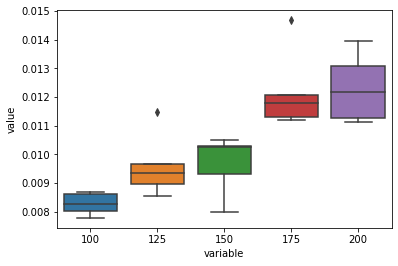

In [23]:
g = sns.boxplot(x='variable', y='value', data=df_melted) #100

In [25]:
dic = {}
for i in [65,70,75,80,90]:
    train_size = int(len(ds) * i/100) 
    train_dataset, test_dataset = ds[0:train_size,:], ds[train_size:len(ds),:]
    dic[i] = exp(6,5,128,100,7)
    df_1 = pd.DataFrame(dic)
df_melted = pd.melt(df_1)

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_55 (LSTM)              (None, 128)               66560     
                                                                 
 dense_55 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 - 1s - loss: 2.4223 - 1s/epoch - 345ms/step
Epoch 2/100
4/4 - 0s - loss: 1.1964 - 33ms/epoch - 8ms/step
Epoch 3/100
4/4 - 0s - loss: 0.2709 - 33ms/epoch - 8ms/step
Epoch 4/100
4/4 - 0s - loss: 0.0977 - 29ms/epoch - 7ms/step
Epoch 5/100
4/4 - 0s - loss: 0.1757 - 34ms/epoch - 8ms/step
Epoch 6/100
4/4 - 0s - loss: 0.0086 - 29ms/epoch - 7ms/step
Epoch 7/100
4/4 - 0s - loss: 0.0431 - 29ms/epoch - 7ms/step
Epoch 8/100
4/4 - 0s - lo

Epoch 5/100
4/4 - 0s - loss: 0.2023 - 34ms/epoch - 8ms/step
Epoch 6/100
4/4 - 0s - loss: 0.0164 - 31ms/epoch - 8ms/step
Epoch 7/100
4/4 - 0s - loss: 0.0294 - 31ms/epoch - 8ms/step
Epoch 8/100
4/4 - 0s - loss: 0.0569 - 31ms/epoch - 8ms/step
Epoch 9/100
4/4 - 0s - loss: 0.0320 - 31ms/epoch - 8ms/step
Epoch 10/100
4/4 - 0s - loss: 0.0040 - 32ms/epoch - 8ms/step
Epoch 11/100
4/4 - 0s - loss: 0.0072 - 31ms/epoch - 8ms/step
Epoch 12/100
4/4 - 0s - loss: 0.0125 - 30ms/epoch - 8ms/step
Epoch 13/100
4/4 - 0s - loss: 0.0041 - 31ms/epoch - 8ms/step
Epoch 14/100
4/4 - 0s - loss: 0.0013 - 32ms/epoch - 8ms/step
Epoch 15/100
4/4 - 0s - loss: 0.0041 - 46ms/epoch - 11ms/step
Epoch 16/100
4/4 - 0s - loss: 0.0033 - 30ms/epoch - 7ms/step
Epoch 17/100
4/4 - 0s - loss: 0.0011 - 29ms/epoch - 7ms/step
Epoch 18/100
4/4 - 0s - loss: 0.0014 - 29ms/epoch - 7ms/step
Epoch 19/100
4/4 - 0s - loss: 0.0015 - 30ms/epoch - 7ms/step
Epoch 20/100
4/4 - 0s - loss: 9.9659e-04 - 29ms/epoch - 7ms/step
Epoch 21/100
4/4 - 0s - 

Epoch 20/100
4/4 - 0s - loss: 0.0010 - 25ms/epoch - 6ms/step
Epoch 21/100
4/4 - 0s - loss: 0.0012 - 28ms/epoch - 7ms/step
Epoch 22/100
4/4 - 0s - loss: 0.0010 - 29ms/epoch - 7ms/step
Epoch 23/100
4/4 - 0s - loss: 0.0011 - 25ms/epoch - 6ms/step
Epoch 24/100
4/4 - 0s - loss: 0.0011 - 27ms/epoch - 7ms/step
Epoch 25/100
4/4 - 0s - loss: 9.9265e-04 - 28ms/epoch - 7ms/step
Epoch 26/100
4/4 - 0s - loss: 9.8270e-04 - 26ms/epoch - 6ms/step
Epoch 27/100
4/4 - 0s - loss: 9.7895e-04 - 28ms/epoch - 7ms/step
Epoch 28/100
4/4 - 0s - loss: 9.5258e-04 - 26ms/epoch - 6ms/step
Epoch 29/100
4/4 - 0s - loss: 9.5985e-04 - 27ms/epoch - 7ms/step
Epoch 30/100
4/4 - 0s - loss: 9.4361e-04 - 25ms/epoch - 6ms/step
Epoch 31/100
4/4 - 0s - loss: 9.4562e-04 - 23ms/epoch - 6ms/step
Epoch 32/100
4/4 - 0s - loss: 9.5145e-04 - 22ms/epoch - 5ms/step
Epoch 33/100
4/4 - 0s - loss: 9.2602e-04 - 23ms/epoch - 6ms/step
Epoch 34/100
4/4 - 0s - loss: 9.2254e-04 - 21ms/epoch - 5ms/step
Epoch 35/100
4/4 - 0s - loss: 9.2440e-04 - 24

4/4 - 0s - loss: 7.9395e-04 - 22ms/epoch - 5ms/step
Epoch 35/100
4/4 - 0s - loss: 8.7833e-04 - 22ms/epoch - 5ms/step
Epoch 36/100
4/4 - 0s - loss: 7.8522e-04 - 24ms/epoch - 6ms/step
Epoch 37/100
4/4 - 0s - loss: 8.4838e-04 - 22ms/epoch - 5ms/step
Epoch 38/100
4/4 - 0s - loss: 8.1576e-04 - 24ms/epoch - 6ms/step
Epoch 39/100
4/4 - 0s - loss: 7.9195e-04 - 22ms/epoch - 5ms/step
Epoch 40/100
4/4 - 0s - loss: 8.1396e-04 - 24ms/epoch - 6ms/step
Epoch 41/100
4/4 - 0s - loss: 7.5101e-04 - 22ms/epoch - 5ms/step
Epoch 42/100
4/4 - 0s - loss: 7.5094e-04 - 23ms/epoch - 6ms/step
Epoch 43/100
4/4 - 0s - loss: 7.5802e-04 - 23ms/epoch - 6ms/step
Epoch 44/100
4/4 - 0s - loss: 7.3712e-04 - 23ms/epoch - 6ms/step
Epoch 45/100
4/4 - 0s - loss: 7.3947e-04 - 23ms/epoch - 6ms/step
Epoch 46/100
4/4 - 0s - loss: 7.1558e-04 - 22ms/epoch - 5ms/step
Epoch 47/100
4/4 - 0s - loss: 7.3843e-04 - 24ms/epoch - 6ms/step
Epoch 48/100
4/4 - 0s - loss: 7.8797e-04 - 22ms/epoch - 5ms/step
Epoch 49/100
4/4 - 0s - loss: 6.9163e-

Epoch 48/100
4/4 - 0s - loss: 7.4735e-04 - 24ms/epoch - 6ms/step
Epoch 49/100
4/4 - 0s - loss: 7.5948e-04 - 24ms/epoch - 6ms/step
Epoch 50/100
4/4 - 0s - loss: 7.3456e-04 - 23ms/epoch - 6ms/step
Epoch 51/100
4/4 - 0s - loss: 7.3279e-04 - 25ms/epoch - 6ms/step
Epoch 52/100
4/4 - 0s - loss: 7.2699e-04 - 24ms/epoch - 6ms/step
Epoch 53/100
4/4 - 0s - loss: 7.1460e-04 - 26ms/epoch - 6ms/step
Epoch 54/100
4/4 - 0s - loss: 7.4160e-04 - 25ms/epoch - 6ms/step
Epoch 55/100
4/4 - 0s - loss: 7.1716e-04 - 24ms/epoch - 6ms/step
Epoch 56/100
4/4 - 0s - loss: 7.0234e-04 - 24ms/epoch - 6ms/step
Epoch 57/100
4/4 - 0s - loss: 6.9572e-04 - 23ms/epoch - 6ms/step
Epoch 58/100
4/4 - 0s - loss: 6.9899e-04 - 25ms/epoch - 6ms/step
Epoch 59/100
4/4 - 0s - loss: 7.2536e-04 - 24ms/epoch - 6ms/step
Epoch 60/100
4/4 - 0s - loss: 6.8940e-04 - 23ms/epoch - 6ms/step
Epoch 61/100
4/4 - 0s - loss: 7.3025e-04 - 23ms/epoch - 6ms/step
Epoch 62/100
4/4 - 0s - loss: 6.6861e-04 - 23ms/epoch - 6ms/step
Epoch 63/100
4/4 - 0s - l

Epoch 62/100
4/4 - 0s - loss: 6.1285e-04 - 25ms/epoch - 6ms/step
Epoch 63/100
4/4 - 0s - loss: 6.0787e-04 - 25ms/epoch - 6ms/step
Epoch 64/100
4/4 - 0s - loss: 5.9272e-04 - 25ms/epoch - 6ms/step
Epoch 65/100
4/4 - 0s - loss: 5.9312e-04 - 24ms/epoch - 6ms/step
Epoch 66/100
4/4 - 0s - loss: 6.1361e-04 - 25ms/epoch - 6ms/step
Epoch 67/100
4/4 - 0s - loss: 5.7971e-04 - 24ms/epoch - 6ms/step
Epoch 68/100
4/4 - 0s - loss: 5.7541e-04 - 25ms/epoch - 6ms/step
Epoch 69/100
4/4 - 0s - loss: 5.6442e-04 - 25ms/epoch - 6ms/step
Epoch 70/100
4/4 - 0s - loss: 5.6741e-04 - 25ms/epoch - 6ms/step
Epoch 71/100
4/4 - 0s - loss: 5.5642e-04 - 29ms/epoch - 7ms/step
Epoch 72/100
4/4 - 0s - loss: 5.5178e-04 - 29ms/epoch - 7ms/step
Epoch 73/100
4/4 - 0s - loss: 5.3581e-04 - 29ms/epoch - 7ms/step
Epoch 74/100
4/4 - 0s - loss: 5.5120e-04 - 30ms/epoch - 7ms/step
Epoch 75/100
4/4 - 0s - loss: 5.3054e-04 - 29ms/epoch - 7ms/step
Epoch 76/100
4/4 - 0s - loss: 5.2615e-04 - 30ms/epoch - 7ms/step
Epoch 77/100
4/4 - 0s - l

4/4 - 0s - loss: 6.1722e-04 - 21ms/epoch - 5ms/step
Epoch 77/100
4/4 - 0s - loss: 5.8861e-04 - 22ms/epoch - 5ms/step
Epoch 78/100
4/4 - 0s - loss: 5.8166e-04 - 22ms/epoch - 5ms/step
Epoch 79/100
4/4 - 0s - loss: 5.7217e-04 - 22ms/epoch - 5ms/step
Epoch 80/100
4/4 - 0s - loss: 5.6779e-04 - 22ms/epoch - 5ms/step
Epoch 81/100
4/4 - 0s - loss: 5.5868e-04 - 22ms/epoch - 5ms/step
Epoch 82/100
4/4 - 0s - loss: 5.5533e-04 - 22ms/epoch - 5ms/step
Epoch 83/100
4/4 - 0s - loss: 5.4961e-04 - 22ms/epoch - 5ms/step
Epoch 84/100
4/4 - 0s - loss: 5.3816e-04 - 22ms/epoch - 5ms/step
Epoch 85/100
4/4 - 0s - loss: 5.3446e-04 - 22ms/epoch - 5ms/step
Epoch 86/100
4/4 - 0s - loss: 5.3691e-04 - 22ms/epoch - 5ms/step
Epoch 87/100
4/4 - 0s - loss: 5.2251e-04 - 22ms/epoch - 5ms/step
Epoch 88/100
4/4 - 0s - loss: 5.1339e-04 - 22ms/epoch - 5ms/step
Epoch 89/100
4/4 - 0s - loss: 5.1107e-04 - 22ms/epoch - 5ms/step
Epoch 90/100
4/4 - 0s - loss: 4.9903e-04 - 21ms/epoch - 5ms/step
Epoch 91/100
4/4 - 0s - loss: 5.0658e-

Epoch 90/100
4/4 - 0s - loss: 4.3509e-04 - 32ms/epoch - 8ms/step
Epoch 91/100
4/4 - 0s - loss: 4.6185e-04 - 32ms/epoch - 8ms/step
Epoch 92/100
4/4 - 0s - loss: 4.2384e-04 - 30ms/epoch - 7ms/step
Epoch 93/100
4/4 - 0s - loss: 4.4213e-04 - 30ms/epoch - 7ms/step
Epoch 94/100
4/4 - 0s - loss: 4.3227e-04 - 31ms/epoch - 8ms/step
Epoch 95/100
4/4 - 0s - loss: 4.2691e-04 - 31ms/epoch - 8ms/step
Epoch 96/100
4/4 - 0s - loss: 4.1138e-04 - 31ms/epoch - 8ms/step
Epoch 97/100
4/4 - 0s - loss: 4.1091e-04 - 31ms/epoch - 8ms/step
Epoch 98/100
4/4 - 0s - loss: 4.0565e-04 - 31ms/epoch - 8ms/step
Epoch 99/100
4/4 - 0s - loss: 4.0095e-04 - 32ms/epoch - 8ms/step
Epoch 100/100
4/4 - 0s - loss: 3.9539e-04 - 32ms/epoch - 8ms/step
4/4 - 0s - loss: 3.9313e-04 - 428ms/epoch - 107ms/step
Train Score: 0.0004 MSE (0.01983 RMSE)
2/2 [==============================] - 0s 5ms/step - loss: 3.4490e-04
Test Score: 0.0003 MSE (0.01857 RMSE)
Model: "sequential_63"
___________________________________________________________

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 128)               66560     
                                                                 
 dense_64 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 - 2s - loss: 2.1097 - 2s/epoch - 454ms/step
Epoch 2/100
4/4 - 0s - loss: 0.8171 - 30ms/epoch - 7ms/step
Epoch 3/100
4/4 - 0s - loss: 0.0748 - 30ms/epoch - 7ms/step
Epoch 4/100
4/4 - 0s - loss: 0.1945 - 30ms/epoch - 7ms/step
Epoch 5/100
4/4 - 0s - loss: 0.0928 - 28ms/epoch - 7ms/step
Epoch 6/100
4/4 - 0s - loss: 0.0090 - 27ms/epoch - 7ms/step
Epoch 7/100
4/4 - 0s - loss: 0.0490 - 27ms/epoch - 7ms/step
Epoch 8/100
4/4 - 0s - lo

Epoch 5/100
4/4 - 0s - loss: 0.0869 - 29ms/epoch - 7ms/step
Epoch 6/100
4/4 - 0s - loss: 0.0159 - 25ms/epoch - 6ms/step
Epoch 7/100
4/4 - 0s - loss: 0.0648 - 27ms/epoch - 7ms/step
Epoch 8/100
4/4 - 0s - loss: 0.0464 - 27ms/epoch - 7ms/step
Epoch 9/100
4/4 - 0s - loss: 0.0075 - 26ms/epoch - 6ms/step
Epoch 10/100
4/4 - 0s - loss: 0.0105 - 23ms/epoch - 6ms/step
Epoch 11/100
4/4 - 0s - loss: 0.0155 - 25ms/epoch - 6ms/step
Epoch 12/100
4/4 - 0s - loss: 0.0030 - 23ms/epoch - 6ms/step
Epoch 13/100
4/4 - 0s - loss: 0.0039 - 24ms/epoch - 6ms/step
Epoch 14/100
4/4 - 0s - loss: 0.0054 - 22ms/epoch - 5ms/step
Epoch 15/100
4/4 - 0s - loss: 0.0019 - 22ms/epoch - 5ms/step
Epoch 16/100
4/4 - 0s - loss: 0.0017 - 23ms/epoch - 6ms/step
Epoch 17/100
4/4 - 0s - loss: 0.0024 - 22ms/epoch - 5ms/step
Epoch 18/100
4/4 - 0s - loss: 0.0013 - 24ms/epoch - 6ms/step
Epoch 19/100
4/4 - 0s - loss: 0.0013 - 22ms/epoch - 5ms/step
Epoch 20/100
4/4 - 0s - loss: 0.0014 - 23ms/epoch - 6ms/step
Epoch 21/100
4/4 - 0s - loss:

4/4 - 0s - loss: 8.9309e-04 - 30ms/epoch - 7ms/step
Epoch 21/100
4/4 - 0s - loss: 0.0011 - 30ms/epoch - 7ms/step
Epoch 22/100
4/4 - 0s - loss: 8.7613e-04 - 31ms/epoch - 8ms/step
Epoch 23/100
4/4 - 0s - loss: 8.3292e-04 - 31ms/epoch - 8ms/step
Epoch 24/100
4/4 - 0s - loss: 8.5880e-04 - 32ms/epoch - 8ms/step
Epoch 25/100
4/4 - 0s - loss: 7.7312e-04 - 31ms/epoch - 8ms/step
Epoch 26/100
4/4 - 0s - loss: 8.1476e-04 - 33ms/epoch - 8ms/step
Epoch 27/100
4/4 - 0s - loss: 7.9429e-04 - 31ms/epoch - 8ms/step
Epoch 28/100
4/4 - 0s - loss: 7.6431e-04 - 32ms/epoch - 8ms/step
Epoch 29/100
4/4 - 0s - loss: 7.7084e-04 - 29ms/epoch - 7ms/step
Epoch 30/100
4/4 - 0s - loss: 7.6825e-04 - 30ms/epoch - 7ms/step
Epoch 31/100
4/4 - 0s - loss: 7.4143e-04 - 31ms/epoch - 8ms/step
Epoch 32/100
4/4 - 0s - loss: 7.3618e-04 - 31ms/epoch - 8ms/step
Epoch 33/100
4/4 - 0s - loss: 7.2425e-04 - 32ms/epoch - 8ms/step
Epoch 34/100
4/4 - 0s - loss: 7.1759e-04 - 31ms/epoch - 8ms/step
Epoch 35/100
4/4 - 0s - loss: 7.1398e-04 -

4/4 - 0s - loss: 8.7339e-04 - 29ms/epoch - 7ms/step
Epoch 35/100
4/4 - 0s - loss: 8.6792e-04 - 31ms/epoch - 8ms/step
Epoch 36/100
4/4 - 0s - loss: 8.6115e-04 - 29ms/epoch - 7ms/step
Epoch 37/100
4/4 - 0s - loss: 8.6452e-04 - 30ms/epoch - 7ms/step
Epoch 38/100
4/4 - 0s - loss: 8.6019e-04 - 31ms/epoch - 8ms/step
Epoch 39/100
4/4 - 0s - loss: 8.3621e-04 - 29ms/epoch - 7ms/step
Epoch 40/100
4/4 - 0s - loss: 8.2029e-04 - 30ms/epoch - 7ms/step
Epoch 41/100
4/4 - 0s - loss: 8.1655e-04 - 30ms/epoch - 7ms/step
Epoch 42/100
4/4 - 0s - loss: 8.0454e-04 - 29ms/epoch - 7ms/step
Epoch 43/100
4/4 - 0s - loss: 8.0294e-04 - 28ms/epoch - 7ms/step
Epoch 44/100
4/4 - 0s - loss: 7.8712e-04 - 29ms/epoch - 7ms/step
Epoch 45/100
4/4 - 0s - loss: 7.8094e-04 - 30ms/epoch - 7ms/step
Epoch 46/100
4/4 - 0s - loss: 7.7204e-04 - 29ms/epoch - 7ms/step
Epoch 47/100
4/4 - 0s - loss: 7.6229e-04 - 30ms/epoch - 7ms/step
Epoch 48/100
4/4 - 0s - loss: 7.5178e-04 - 30ms/epoch - 7ms/step
Epoch 49/100
4/4 - 0s - loss: 7.4469e-

Epoch 48/100
4/4 - 0s - loss: 6.6222e-04 - 27ms/epoch - 7ms/step
Epoch 49/100
4/4 - 0s - loss: 6.6365e-04 - 28ms/epoch - 7ms/step
Epoch 50/100
4/4 - 0s - loss: 6.5244e-04 - 26ms/epoch - 6ms/step
Epoch 51/100
4/4 - 0s - loss: 6.4909e-04 - 28ms/epoch - 7ms/step
Epoch 52/100
4/4 - 0s - loss: 6.4121e-04 - 28ms/epoch - 7ms/step
Epoch 53/100
4/4 - 0s - loss: 6.3473e-04 - 28ms/epoch - 7ms/step
Epoch 54/100
4/4 - 0s - loss: 6.2306e-04 - 28ms/epoch - 7ms/step
Epoch 55/100
4/4 - 0s - loss: 6.2512e-04 - 27ms/epoch - 7ms/step
Epoch 56/100
4/4 - 0s - loss: 6.1315e-04 - 27ms/epoch - 7ms/step
Epoch 57/100
4/4 - 0s - loss: 6.1207e-04 - 27ms/epoch - 7ms/step
Epoch 58/100
4/4 - 0s - loss: 6.0307e-04 - 28ms/epoch - 7ms/step
Epoch 59/100
4/4 - 0s - loss: 5.9469e-04 - 27ms/epoch - 7ms/step
Epoch 60/100
4/4 - 0s - loss: 5.9003e-04 - 28ms/epoch - 7ms/step
Epoch 61/100
4/4 - 0s - loss: 5.8481e-04 - 27ms/epoch - 7ms/step
Epoch 62/100
4/4 - 0s - loss: 5.8010e-04 - 28ms/epoch - 7ms/step
Epoch 63/100
4/4 - 0s - l

4/4 - 0s - loss: 6.2624e-04 - 31ms/epoch - 8ms/step
Epoch 63/100
4/4 - 0s - loss: 6.1505e-04 - 32ms/epoch - 8ms/step
Epoch 64/100
4/4 - 0s - loss: 6.0742e-04 - 30ms/epoch - 7ms/step
Epoch 65/100
4/4 - 0s - loss: 6.0025e-04 - 31ms/epoch - 8ms/step
Epoch 66/100
4/4 - 0s - loss: 6.0087e-04 - 31ms/epoch - 8ms/step
Epoch 67/100
4/4 - 0s - loss: 5.8510e-04 - 31ms/epoch - 8ms/step
Epoch 68/100
4/4 - 0s - loss: 5.8114e-04 - 31ms/epoch - 8ms/step
Epoch 69/100
4/4 - 0s - loss: 5.6952e-04 - 32ms/epoch - 8ms/step
Epoch 70/100
4/4 - 0s - loss: 5.6203e-04 - 31ms/epoch - 8ms/step
Epoch 71/100
4/4 - 0s - loss: 5.5974e-04 - 31ms/epoch - 8ms/step
Epoch 72/100
4/4 - 0s - loss: 5.6541e-04 - 30ms/epoch - 7ms/step
Epoch 73/100
4/4 - 0s - loss: 5.3501e-04 - 30ms/epoch - 7ms/step
Epoch 74/100
4/4 - 0s - loss: 5.3503e-04 - 30ms/epoch - 7ms/step
Epoch 75/100
4/4 - 0s - loss: 5.2087e-04 - 32ms/epoch - 8ms/step
Epoch 76/100
4/4 - 0s - loss: 5.1642e-04 - 31ms/epoch - 8ms/step
Epoch 77/100
4/4 - 0s - loss: 5.0596e-

Epoch 76/100
4/4 - 0s - loss: 4.2642e-04 - 31ms/epoch - 8ms/step
Epoch 77/100
4/4 - 0s - loss: 4.2518e-04 - 30ms/epoch - 7ms/step
Epoch 78/100
4/4 - 0s - loss: 4.1807e-04 - 29ms/epoch - 7ms/step
Epoch 79/100
4/4 - 0s - loss: 4.1004e-04 - 30ms/epoch - 7ms/step
Epoch 80/100
4/4 - 0s - loss: 4.0250e-04 - 30ms/epoch - 7ms/step
Epoch 81/100
4/4 - 0s - loss: 3.9767e-04 - 30ms/epoch - 7ms/step
Epoch 82/100
4/4 - 0s - loss: 3.9309e-04 - 29ms/epoch - 7ms/step
Epoch 83/100
4/4 - 0s - loss: 3.8721e-04 - 29ms/epoch - 7ms/step
Epoch 84/100
4/4 - 0s - loss: 3.8220e-04 - 30ms/epoch - 7ms/step
Epoch 85/100
4/4 - 0s - loss: 3.7751e-04 - 29ms/epoch - 7ms/step
Epoch 86/100
4/4 - 0s - loss: 3.7378e-04 - 30ms/epoch - 7ms/step
Epoch 87/100
4/4 - 0s - loss: 3.6852e-04 - 31ms/epoch - 8ms/step
Epoch 88/100
4/4 - 0s - loss: 3.6338e-04 - 31ms/epoch - 8ms/step
Epoch 89/100
4/4 - 0s - loss: 3.5922e-04 - 30ms/epoch - 7ms/step
Epoch 90/100
4/4 - 0s - loss: 3.5675e-04 - 29ms/epoch - 7ms/step
Epoch 91/100
4/4 - 0s - l

Epoch 91/100
4/4 - 0s - loss: 4.1308e-04 - 28ms/epoch - 7ms/step
Epoch 92/100
4/4 - 0s - loss: 4.0571e-04 - 28ms/epoch - 7ms/step
Epoch 93/100
4/4 - 0s - loss: 3.9957e-04 - 29ms/epoch - 7ms/step
Epoch 94/100
4/4 - 0s - loss: 3.9596e-04 - 28ms/epoch - 7ms/step
Epoch 95/100
4/4 - 0s - loss: 3.9196e-04 - 30ms/epoch - 7ms/step
Epoch 96/100
4/4 - 0s - loss: 3.8498e-04 - 29ms/epoch - 7ms/step
Epoch 97/100
4/4 - 0s - loss: 3.8088e-04 - 30ms/epoch - 7ms/step
Epoch 98/100
4/4 - 0s - loss: 3.7356e-04 - 29ms/epoch - 7ms/step
Epoch 99/100
4/4 - 0s - loss: 3.7919e-04 - 29ms/epoch - 7ms/step
Epoch 100/100
4/4 - 0s - loss: 3.7353e-04 - 29ms/epoch - 7ms/step
4/4 - 1s - loss: 3.6377e-04 - 609ms/epoch - 152ms/step
Train Score: 0.0004 MSE (0.01907 RMSE)
1/1 [==============================] - 0s 21ms/step - loss: 2.2979e-04
Test Score: 0.0002 MSE (0.01516 RMSE)
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Pa

 Layer (type)                Output Shape              Param #   
 lstm_73 (LSTM)              (None, 128)               66560     
                                                                 
 dense_73 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 - 2s - loss: 2.5636 - 2s/epoch - 425ms/step
Epoch 2/100
4/4 - 0s - loss: 1.1876 - 35ms/epoch - 9ms/step
Epoch 3/100
4/4 - 0s - loss: 0.2455 - 33ms/epoch - 8ms/step
Epoch 4/100
4/4 - 0s - loss: 0.0949 - 32ms/epoch - 8ms/step
Epoch 5/100
4/4 - 0s - loss: 0.1875 - 31ms/epoch - 8ms/step
Epoch 6/100
4/4 - 0s - loss: 0.0218 - 25ms/epoch - 6ms/step
Epoch 7/100
4/4 - 0s - loss: 0.0250 - 25ms/epoch - 6ms/step
Epoch 8/100
4/4 - 0s - loss: 0.0529 - 25ms/epoch - 6ms/step
Epoch 9/100
4/4 - 0s - loss: 0.0301 - 26ms/epoch - 6ms

4/4 - 0s - loss: 0.0104 - 34ms/epoch - 9ms/step
Epoch 7/100
4/4 - 0s - loss: 0.0530 - 31ms/epoch - 8ms/step
Epoch 8/100
4/4 - 0s - loss: 0.0503 - 32ms/epoch - 8ms/step
Epoch 9/100
4/4 - 0s - loss: 0.0149 - 31ms/epoch - 8ms/step
Epoch 10/100
4/4 - 0s - loss: 0.0032 - 30ms/epoch - 7ms/step
Epoch 11/100
4/4 - 0s - loss: 0.0131 - 31ms/epoch - 8ms/step
Epoch 12/100
4/4 - 0s - loss: 0.0083 - 32ms/epoch - 8ms/step
Epoch 13/100
4/4 - 0s - loss: 0.0020 - 32ms/epoch - 8ms/step
Epoch 14/100
4/4 - 0s - loss: 0.0037 - 31ms/epoch - 8ms/step
Epoch 15/100
4/4 - 0s - loss: 0.0039 - 31ms/epoch - 8ms/step
Epoch 16/100
4/4 - 0s - loss: 0.0016 - 31ms/epoch - 8ms/step
Epoch 17/100
4/4 - 0s - loss: 0.0016 - 30ms/epoch - 7ms/step
Epoch 18/100
4/4 - 0s - loss: 0.0020 - 30ms/epoch - 7ms/step
Epoch 19/100
4/4 - 0s - loss: 0.0014 - 31ms/epoch - 8ms/step
Epoch 20/100
4/4 - 0s - loss: 0.0012 - 30ms/epoch - 7ms/step
Epoch 21/100
4/4 - 0s - loss: 0.0014 - 31ms/epoch - 8ms/step
Epoch 22/100
4/4 - 0s - loss: 0.0012 - 3

Epoch 22/100
5/5 - 0s - loss: 9.7503e-04 - 34ms/epoch - 7ms/step
Epoch 23/100
5/5 - 0s - loss: 9.6337e-04 - 37ms/epoch - 7ms/step
Epoch 24/100
5/5 - 0s - loss: 9.8758e-04 - 35ms/epoch - 7ms/step
Epoch 25/100
5/5 - 0s - loss: 9.1137e-04 - 38ms/epoch - 8ms/step
Epoch 26/100
5/5 - 0s - loss: 9.2461e-04 - 38ms/epoch - 8ms/step
Epoch 27/100
5/5 - 0s - loss: 9.0078e-04 - 37ms/epoch - 7ms/step
Epoch 28/100
5/5 - 0s - loss: 8.6589e-04 - 37ms/epoch - 7ms/step
Epoch 29/100
5/5 - 0s - loss: 8.5351e-04 - 38ms/epoch - 8ms/step
Epoch 30/100
5/5 - 0s - loss: 8.2989e-04 - 36ms/epoch - 7ms/step
Epoch 31/100
5/5 - 0s - loss: 8.1730e-04 - 36ms/epoch - 7ms/step
Epoch 32/100
5/5 - 0s - loss: 7.9676e-04 - 37ms/epoch - 7ms/step
Epoch 33/100
5/5 - 0s - loss: 7.9322e-04 - 37ms/epoch - 7ms/step
Epoch 34/100
5/5 - 0s - loss: 7.6231e-04 - 36ms/epoch - 7ms/step
Epoch 35/100
5/5 - 0s - loss: 7.5324e-04 - 36ms/epoch - 7ms/step
Epoch 36/100
5/5 - 0s - loss: 7.3018e-04 - 37ms/epoch - 7ms/step
Epoch 37/100
5/5 - 0s - l

Epoch 36/100
5/5 - 0s - loss: 7.2541e-04 - 35ms/epoch - 7ms/step
Epoch 37/100
5/5 - 0s - loss: 6.9398e-04 - 35ms/epoch - 7ms/step
Epoch 38/100
5/5 - 0s - loss: 6.8415e-04 - 36ms/epoch - 7ms/step
Epoch 39/100
5/5 - 0s - loss: 6.7134e-04 - 35ms/epoch - 7ms/step
Epoch 40/100
5/5 - 0s - loss: 6.4772e-04 - 36ms/epoch - 7ms/step
Epoch 41/100
5/5 - 0s - loss: 6.4058e-04 - 35ms/epoch - 7ms/step
Epoch 42/100
5/5 - 0s - loss: 6.2002e-04 - 34ms/epoch - 7ms/step
Epoch 43/100
5/5 - 0s - loss: 6.0757e-04 - 35ms/epoch - 7ms/step
Epoch 44/100
5/5 - 0s - loss: 5.8554e-04 - 35ms/epoch - 7ms/step
Epoch 45/100
5/5 - 0s - loss: 5.7397e-04 - 35ms/epoch - 7ms/step
Epoch 46/100
5/5 - 0s - loss: 5.5492e-04 - 35ms/epoch - 7ms/step
Epoch 47/100
5/5 - 0s - loss: 5.4865e-04 - 35ms/epoch - 7ms/step
Epoch 48/100
5/5 - 0s - loss: 5.3209e-04 - 35ms/epoch - 7ms/step
Epoch 49/100
5/5 - 0s - loss: 5.2697e-04 - 35ms/epoch - 7ms/step
Epoch 50/100
5/5 - 0s - loss: 5.0614e-04 - 35ms/epoch - 7ms/step
Epoch 51/100
5/5 - 0s - l

Epoch 50/100
5/5 - 0s - loss: 5.0080e-04 - 37ms/epoch - 7ms/step
Epoch 51/100
5/5 - 0s - loss: 4.9212e-04 - 35ms/epoch - 7ms/step
Epoch 52/100
5/5 - 0s - loss: 4.9450e-04 - 35ms/epoch - 7ms/step
Epoch 53/100
5/5 - 0s - loss: 4.6852e-04 - 37ms/epoch - 7ms/step
Epoch 54/100
5/5 - 0s - loss: 4.6184e-04 - 36ms/epoch - 7ms/step
Epoch 55/100
5/5 - 0s - loss: 4.4674e-04 - 35ms/epoch - 7ms/step
Epoch 56/100
5/5 - 0s - loss: 4.3404e-04 - 36ms/epoch - 7ms/step
Epoch 57/100
5/5 - 0s - loss: 4.2428e-04 - 36ms/epoch - 7ms/step
Epoch 58/100
5/5 - 0s - loss: 4.1800e-04 - 36ms/epoch - 7ms/step
Epoch 59/100
5/5 - 0s - loss: 4.1963e-04 - 35ms/epoch - 7ms/step
Epoch 60/100
5/5 - 0s - loss: 4.2532e-04 - 37ms/epoch - 7ms/step
Epoch 61/100
5/5 - 0s - loss: 3.9777e-04 - 35ms/epoch - 7ms/step
Epoch 62/100
5/5 - 0s - loss: 4.4472e-04 - 35ms/epoch - 7ms/step
Epoch 63/100
5/5 - 0s - loss: 3.9651e-04 - 35ms/epoch - 7ms/step
Epoch 64/100
5/5 - 0s - loss: 3.6814e-04 - 35ms/epoch - 7ms/step
Epoch 65/100
5/5 - 0s - l

Epoch 64/100
5/5 - 0s - loss: 3.6904e-04 - 36ms/epoch - 7ms/step
Epoch 65/100
5/5 - 0s - loss: 3.4075e-04 - 36ms/epoch - 7ms/step
Epoch 66/100
5/5 - 0s - loss: 3.5617e-04 - 36ms/epoch - 7ms/step
Epoch 67/100
5/5 - 0s - loss: 3.2948e-04 - 36ms/epoch - 7ms/step
Epoch 68/100
5/5 - 0s - loss: 3.3843e-04 - 36ms/epoch - 7ms/step
Epoch 69/100
5/5 - 0s - loss: 3.2521e-04 - 36ms/epoch - 7ms/step
Epoch 70/100
5/5 - 0s - loss: 3.1091e-04 - 37ms/epoch - 7ms/step
Epoch 71/100
5/5 - 0s - loss: 3.1153e-04 - 36ms/epoch - 7ms/step
Epoch 72/100
5/5 - 0s - loss: 3.0111e-04 - 36ms/epoch - 7ms/step
Epoch 73/100
5/5 - 0s - loss: 2.9674e-04 - 37ms/epoch - 7ms/step
Epoch 74/100
5/5 - 0s - loss: 2.8821e-04 - 38ms/epoch - 8ms/step
Epoch 75/100
5/5 - 0s - loss: 2.9055e-04 - 36ms/epoch - 7ms/step
Epoch 76/100
5/5 - 0s - loss: 2.7854e-04 - 35ms/epoch - 7ms/step
Epoch 77/100
5/5 - 0s - loss: 2.8269e-04 - 36ms/epoch - 7ms/step
Epoch 78/100
5/5 - 0s - loss: 2.8154e-04 - 37ms/epoch - 7ms/step
Epoch 79/100
5/5 - 0s - l

Epoch 78/100
5/5 - 0s - loss: 2.8529e-04 - 38ms/epoch - 8ms/step
Epoch 79/100
5/5 - 0s - loss: 3.1123e-04 - 33ms/epoch - 7ms/step
Epoch 80/100
5/5 - 0s - loss: 2.9616e-04 - 36ms/epoch - 7ms/step
Epoch 81/100
5/5 - 0s - loss: 2.8847e-04 - 36ms/epoch - 7ms/step
Epoch 82/100
5/5 - 0s - loss: 2.8131e-04 - 36ms/epoch - 7ms/step
Epoch 83/100
5/5 - 0s - loss: 2.7975e-04 - 37ms/epoch - 7ms/step
Epoch 84/100
5/5 - 0s - loss: 2.7482e-04 - 40ms/epoch - 8ms/step
Epoch 85/100
5/5 - 0s - loss: 2.7121e-04 - 35ms/epoch - 7ms/step
Epoch 86/100
5/5 - 0s - loss: 2.6680e-04 - 37ms/epoch - 7ms/step
Epoch 87/100
5/5 - 0s - loss: 2.6777e-04 - 37ms/epoch - 7ms/step
Epoch 88/100
5/5 - 0s - loss: 2.6540e-04 - 37ms/epoch - 7ms/step
Epoch 89/100
5/5 - 0s - loss: 2.5944e-04 - 35ms/epoch - 7ms/step
Epoch 90/100
5/5 - 0s - loss: 2.6641e-04 - 37ms/epoch - 7ms/step
Epoch 91/100
5/5 - 0s - loss: 2.6308e-04 - 37ms/epoch - 7ms/step
Epoch 92/100
5/5 - 0s - loss: 2.5380e-04 - 36ms/epoch - 7ms/step
Epoch 93/100
5/5 - 0s - l

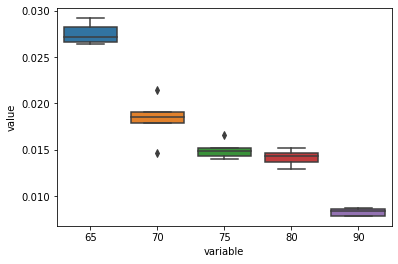

In [26]:
g = sns.boxplot(x='variable', y='value', data=df_melted) #90

In [27]:
dic

{65: [0.026615893777228856,
  0.027137418524457505,
  0.029176874566172562,
  0.028281224957805422,
  0.026390259855961606],
 70: [0.014605151236192805,
  0.021447451382556812,
  0.01857154952112991,
  0.01786349048842313,
  0.01907478709553792],
 75: [0.016589228522212895,
  0.015211175541730728,
  0.014860510010879511,
  0.01402772697461309,
  0.014316202571429655],
 80: [0.01362219473692897,
  0.015158836583231649,
  0.012930494144472207,
  0.014282176637154722,
  0.014625802532903368],
 90: [0.007877527655195131,
  0.008637521734213345,
  0.007859099909766588,
  0.008395992261997201,
  0.008697273016936551]}

In [28]:
df2

,capacity,long_interval
0,1.856487,0
1,1.846327,0
2,1.835349,0
3,1.835263,0
4,1.834646,0
...,...,...
163,1.293464,0
164,1.288003,0
165,1.287453,0
166,1.309015,1


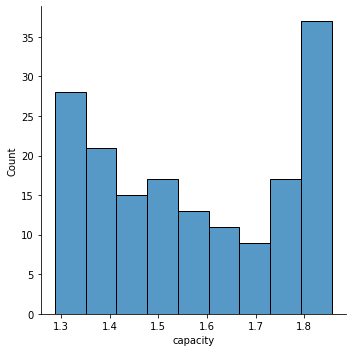

In [30]:
sns.displot(x = "capacity", data = df2)

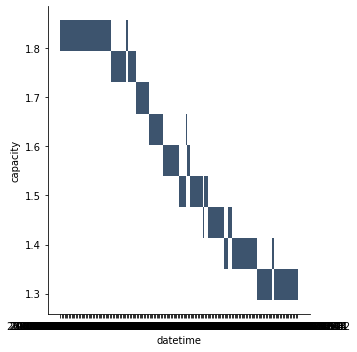

In [33]:
df3 =  df.drop_duplicates(subset=["datetime"], keep="first")
sns.displot(y = "capacity",x = "datetime" ,data = df3)

In [34]:
df3

,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
0,1,24,2008-04-02 15:25:41,1.856487,4.191492,-0.004902,24.330034,-0.0006,0.0,0.0
197,2,24,2008-04-02 19:43:48,1.846327,4.189773,0.000021,24.697752,-0.0006,0.0,0.0
393,3,24,2008-04-03 00:01:06,1.835349,4.188187,-0.001754,24.734266,-0.0006,0.0,0.0
588,4,24,2008-04-03 04:16:37,1.835263,4.188461,-0.002775,24.654236,-0.0006,0.0,0.0
782,5,24,2008-04-03 08:33:25,1.834646,4.188299,-0.007981,24.524797,-0.0006,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
48796,164,24,2008-05-26 10:44:38,1.293464,4.196641,-0.003172,23.741424,0.0006,0.0,0.0
49093,165,24,2008-05-26 15:30:43,1.288003,4.195624,-0.005227,23.803979,0.0006,0.0,0.0
49390,166,24,2008-05-26 20:21:04,1.287453,4.195862,-0.000555,23.849122,0.0006,0.0,0.0
49687,167,24,2008-05-27 15:52:41,1.309015,4.184827,-0.003813,24.934105,0.0006,0.0,0.0
